# Federated Learning for Melanoma Classification

## FedAdam and FedProx testing on non-IID

### Objective 3: Exploration of data distribution assumptions and novel application of federated learning aggregation strategies for our melanoma classification. 


#### Important notes:

- We test FedAdam and FedProx Algorithm on different data splits by image and different label distributions (non-IID test), client datasets will be balanced in term of size.
- Dirichlet with alpha infinity is used to simulate IID scenario. 
- Dirichlet with alpha 1  and 0.5 are used for non IID distributions. 
- The testing in this section covers 6 clients and takes into account full client participation in each federated learning rounds.
- We will compare the different algorithms against FedAvg on non iid datasets to understand how these algorithms cope with the challenges of data heterogeneity. 
- Similar to previous sections we will analyse the impact of these algorithm hyperparameters on the learning performance. 

##### Note: Further non-IID testing is explored for objective 3 in later notebooks. 

### Import Modules & Packages

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FLWorker import *
from FLScenario import *
from FedAvg import *
from FLutils import *
from FLTrainVal import *
from FocalLoss import *

### Package Versions

In [6]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


In [7]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [8]:
# Seed everything
set_seed(random_seed=5)

In [9]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. FedAdam

In the first three sections of testing, we tested FedAdam on IID, Dirichlet 1 and Dirichlet 0.5 label splits with below global aggregation parameters:

- beta 1 and beta 2 equal to 0.4
- tau equal to 5*1e-3
- global learning rate 51e-3

Other federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch Size 256
- FL rounds: 15
- Local learning rate decay 0.15

Tests are on 6 clients and full client participation.  

In the last section we tested different set of FedAdam global aggregation parameters on Dirichlet 0.5 label splits. We also tested the impact of local learning rate with FedAdam

##### Note: Testing was done with Adam optimizer for local updates

## 1.1 Testing on IID

In [6]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)


In [110]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAdam_6W_iid_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178



 epoch: 1, train loss: 0.013539, train acc: 0.9823



 epoch: 2, train loss: 0.013176, train acc: 0.9823



 epoch: 3, train loss: 0.011957, train acc: 0.9823



 epoch: 4, train loss: 0.011576, train acc: 0.9823
Training Finished
Training: 11.249958515167236 seconds
 round:0, worker: 3 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.7899
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184



 epoch: 1, train loss: 0.013329, train acc: 0.9823



 epoch: 2, train loss: 0.012553, train acc: 0.9823



 epoch: 3, train loss: 0.011292, train acc: 0.9823



 epoch: 4, train loss: 0.010525, train acc: 0.9823
Training Finished
Training: 10.966901540756226 seconds
 round:0, worker: 2 Validation



 val loss: 0.012366, val acc: 0.9830, val roc:0.7933
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163



 epoch: 1, train loss: 0.013833, train acc: 0.9823



 epoch: 2, train loss: 0.012563, train acc: 0.9823



 epoch: 3, train loss: 0.011836, train acc: 0.9823



 epoch: 4, train loss: 0.011127, train acc: 0.9823
Training Finished
Training: 10.833962440490723 seconds
 round:0, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8117
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184



 epoch: 1, train loss: 0.013815, train acc: 0.9823



 epoch: 2, train loss: 0.012669, train acc: 0.9823



 epoch: 3, train loss: 0.011863, train acc: 0.9823



 epoch: 4, train loss: 0.011305, train acc: 0.9823
Training Finished
Training: 10.795414924621582 seconds
 round:0, worker: 4 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7934
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178



 epoch: 1, train loss: 0.014593, train acc: 0.9823



 epoch: 2, train loss: 0.012880, train acc: 0.9823



 epoch: 3, train loss: 0.012492, train acc: 0.9823



 epoch: 4, train loss: 0.011797, train acc: 0.9823
Training Finished
Training: 10.657578229904175 seconds
 round:0, worker: 0 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7874
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165



 epoch: 1, train loss: 0.013889, train acc: 0.9821



 epoch: 2, train loss: 0.013119, train acc: 0.9821



 epoch: 3, train loss: 0.012281, train acc: 0.9821



 epoch: 4, train loss: 0.011688, train acc: 0.9821
Training Finished
Training: 10.77343201637268 seconds
 round:0, worker: 1 Validation



 val loss: 0.012274, val acc: 0.9830, val roc:0.8045
 round: 0, avg train loss: 0.011336, avg train acc: 0.9823
 round: 0, avg val loss: 0.012365, avg val acc: 0.9830, avg val roc:0.7967
 round:0, Center Validation



 val loss: 0.015584, val acc: 0.9830, val roc:0.8046
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.013396, train acc: 0.9823



 epoch: 1, train loss: 0.011631, train acc: 0.9823



 epoch: 2, train loss: 0.010998, train acc: 0.9823



 epoch: 3, train loss: 0.010434, train acc: 0.9826



 epoch: 4, train loss: 0.009811, train acc: 0.9826
Training Finished
Training: 4.314063787460327 seconds
 round:1, worker: 4 Validation



 val loss: 0.011909, val acc: 0.9830, val roc:0.8262
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.014605, train acc: 0.9823



 epoch: 1, train loss: 0.012116, train acc: 0.9823



 epoch: 2, train loss: 0.011337, train acc: 0.9823



 epoch: 3, train loss: 0.010622, train acc: 0.9823



 epoch: 4, train loss: 0.009936, train acc: 0.9823
Training Finished
Training: 4.395279169082642 seconds
 round:1, worker: 5 Validation



 val loss: 0.012209, val acc: 0.9827, val roc:0.8225
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.015211, train acc: 0.9821



 epoch: 1, train loss: 0.012936, train acc: 0.9821



 epoch: 2, train loss: 0.012225, train acc: 0.9821



 epoch: 3, train loss: 0.011522, train acc: 0.9821



 epoch: 4, train loss: 0.010928, train acc: 0.9821
Training Finished
Training: 4.224732875823975 seconds
 round:1, worker: 1 Validation



 val loss: 0.011839, val acc: 0.9828, val roc:0.8248
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.013117, train acc: 0.9823



 epoch: 1, train loss: 0.011071, train acc: 0.9823



 epoch: 2, train loss: 0.010183, train acc: 0.9823



 epoch: 3, train loss: 0.009272, train acc: 0.9831



 epoch: 4, train loss: 0.008441, train acc: 0.9834
Training Finished
Training: 4.336436033248901 seconds
 round:1, worker: 2 Validation



 val loss: 0.013221, val acc: 0.9827, val roc:0.8073
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.013973, train acc: 0.9823



 epoch: 1, train loss: 0.012764, train acc: 0.9823



 epoch: 2, train loss: 0.012487, train acc: 0.9823



 epoch: 3, train loss: 0.012631, train acc: 0.9821



 epoch: 4, train loss: 0.012274, train acc: 0.9823
Training Finished
Training: 4.366354942321777 seconds
 round:1, worker: 0 Validation



 val loss: 0.012240, val acc: 0.9830, val roc:0.8089
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.013811, train acc: 0.9823



 epoch: 1, train loss: 0.012062, train acc: 0.9823



 epoch: 2, train loss: 0.011563, train acc: 0.9823



 epoch: 3, train loss: 0.011087, train acc: 0.9823



 epoch: 4, train loss: 0.010503, train acc: 0.9823
Training Finished
Training: 4.3234710693359375 seconds
 round:1, worker: 3 Validation



 val loss: 0.012177, val acc: 0.9831, val roc:0.8235
 round: 1, avg train loss: 0.010315, avg train acc: 0.9825
 round: 1, avg val loss: 0.012266, avg val acc: 0.9829, avg val roc:0.8189
 round:1, Center Validation



 val loss: 0.012869, val acc: 0.9830, val roc:0.8142
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.012473, train acc: 0.9823



 epoch: 1, train loss: 0.011850, train acc: 0.9823



 epoch: 2, train loss: 0.011296, train acc: 0.9823



 epoch: 3, train loss: 0.010759, train acc: 0.9823



 epoch: 4, train loss: 0.010208, train acc: 0.9821
Training Finished
Training: 4.303522825241089 seconds
 round:2, worker: 3 Validation



 val loss: 0.012117, val acc: 0.9831, val roc:0.8303
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.011667, train acc: 0.9823



 epoch: 1, train loss: 0.010527, train acc: 0.9823



 epoch: 2, train loss: 0.009500, train acc: 0.9828



 epoch: 3, train loss: 0.008787, train acc: 0.9834



 epoch: 4, train loss: 0.008013, train acc: 0.9844
Training Finished
Training: 4.447150468826294 seconds
 round:2, worker: 2 Validation



 val loss: 0.013324, val acc: 0.9825, val roc:0.8073
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.012483, train acc: 0.9823



 epoch: 1, train loss: 0.011687, train acc: 0.9823



 epoch: 2, train loss: 0.011418, train acc: 0.9821



 epoch: 3, train loss: 0.011444, train acc: 0.9821



 epoch: 4, train loss: 0.011775, train acc: 0.9826
Training Finished
Training: 4.451129674911499 seconds
 round:2, worker: 0 Validation



 val loss: 0.015111, val acc: 0.9819, val roc:0.8154
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.014008, train acc: 0.9823



 epoch: 1, train loss: 0.011549, train acc: 0.9823



 epoch: 2, train loss: 0.010860, train acc: 0.9823



 epoch: 3, train loss: 0.010300, train acc: 0.9823



 epoch: 4, train loss: 0.009750, train acc: 0.9823
Training Finished
Training: 4.5409510135650635 seconds
 round:2, worker: 5 Validation



 val loss: 0.012203, val acc: 0.9825, val roc:0.8280
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.012843, train acc: 0.9823



 epoch: 1, train loss: 0.011650, train acc: 0.9823



 epoch: 2, train loss: 0.011072, train acc: 0.9823



 epoch: 3, train loss: 0.010572, train acc: 0.9826



 epoch: 4, train loss: 0.010061, train acc: 0.9826
Training Finished
Training: 4.533436298370361 seconds
 round:2, worker: 4 Validation



 val loss: 0.011805, val acc: 0.9830, val roc:0.8269
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.013078, train acc: 0.9821



 epoch: 1, train loss: 0.011742, train acc: 0.9821



 epoch: 2, train loss: 0.011221, train acc: 0.9821



 epoch: 3, train loss: 0.010766, train acc: 0.9821



 epoch: 4, train loss: 0.010252, train acc: 0.9823
Training Finished
Training: 4.611700773239136 seconds
 round:2, worker: 1 Validation



 val loss: 0.011660, val acc: 0.9827, val roc:0.8364
 round: 2, avg train loss: 0.010010, avg train acc: 0.9827
 round: 2, avg val loss: 0.012703, avg val acc: 0.9826, avg val roc:0.8241
 round:2, Center Validation



 val loss: 0.012730, val acc: 0.9830, val roc:0.8253
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.013113, train acc: 0.9823



 epoch: 1, train loss: 0.010914, train acc: 0.9823



 epoch: 2, train loss: 0.010392, train acc: 0.9823



 epoch: 3, train loss: 0.009948, train acc: 0.9823



 epoch: 4, train loss: 0.009492, train acc: 0.9823
Training Finished
Training: 4.29255223274231 seconds
 round:3, worker: 5 Validation



 val loss: 0.012089, val acc: 0.9825, val roc:0.8328
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.012143, train acc: 0.9823



 epoch: 1, train loss: 0.011178, train acc: 0.9823



 epoch: 2, train loss: 0.010712, train acc: 0.9823



 epoch: 3, train loss: 0.010256, train acc: 0.9826



 epoch: 4, train loss: 0.009790, train acc: 0.9828
Training Finished
Training: 4.433177947998047 seconds
 round:3, worker: 4 Validation



 val loss: 0.011676, val acc: 0.9830, val roc:0.8353
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010884, train acc: 0.9823



 epoch: 1, train loss: 0.010074, train acc: 0.9826



 epoch: 2, train loss: 0.009198, train acc: 0.9834



 epoch: 3, train loss: 0.008539, train acc: 0.9836



 epoch: 4, train loss: 0.007856, train acc: 0.9844
Training Finished
Training: 4.387299537658691 seconds
 round:3, worker: 2 Validation



 val loss: 0.013252, val acc: 0.9825, val roc:0.8124
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.012514, train acc: 0.9821



 epoch: 1, train loss: 0.011351, train acc: 0.9821



 epoch: 2, train loss: 0.010963, train acc: 0.9821



 epoch: 3, train loss: 0.010589, train acc: 0.9823



 epoch: 4, train loss: 0.010175, train acc: 0.9823
Training Finished
Training: 4.375331878662109 seconds
 round:3, worker: 1 Validation



 val loss: 0.011613, val acc: 0.9827, val roc:0.8425
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.012813, train acc: 0.9823



 epoch: 1, train loss: 0.011212, train acc: 0.9823



 epoch: 2, train loss: 0.010903, train acc: 0.9823



 epoch: 3, train loss: 0.010604, train acc: 0.9823



 epoch: 4, train loss: 0.010219, train acc: 0.9821
Training Finished
Training: 4.400265455245972 seconds
 round:3, worker: 3 Validation



 val loss: 0.012098, val acc: 0.9831, val roc:0.8362
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.012770, train acc: 0.9823



 epoch: 1, train loss: 0.012247, train acc: 0.9821



 epoch: 2, train loss: 0.012314, train acc: 0.9823



 epoch: 3, train loss: 0.011281, train acc: 0.9823



 epoch: 4, train loss: 0.010431, train acc: 0.9826
Training Finished
Training: 4.448139190673828 seconds
 round:3, worker: 0 Validation



 val loss: 0.011823, val acc: 0.9830, val roc:0.8264
 round: 3, avg train loss: 0.009660, avg train acc: 0.9828
 round: 3, avg val loss: 0.012092, avg val acc: 0.9828, avg val roc:0.8309
 round:3, Center Validation



 val loss: 0.012301, val acc: 0.9830, val roc:0.8358
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.012334, train acc: 0.9821



 epoch: 1, train loss: 0.010436, train acc: 0.9823



 epoch: 2, train loss: 0.010011, train acc: 0.9823



 epoch: 3, train loss: 0.009641, train acc: 0.9823



 epoch: 4, train loss: 0.009253, train acc: 0.9823
Training Finished
Training: 4.329454660415649 seconds
 round:4, worker: 5 Validation



 val loss: 0.011973, val acc: 0.9825, val roc:0.8383
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.011816, train acc: 0.9823



 epoch: 1, train loss: 0.010850, train acc: 0.9823



 epoch: 2, train loss: 0.010432, train acc: 0.9823



 epoch: 3, train loss: 0.010052, train acc: 0.9823



 epoch: 4, train loss: 0.009662, train acc: 0.9831
Training Finished
Training: 4.641556262969971 seconds
 round:4, worker: 4 Validation



 val loss: 0.011777, val acc: 0.9828, val roc:0.8420
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.012198, train acc: 0.9823



 epoch: 1, train loss: 0.010869, train acc: 0.9823



 epoch: 2, train loss: 0.010581, train acc: 0.9823



 epoch: 3, train loss: 0.010280, train acc: 0.9821



 epoch: 4, train loss: 0.009907, train acc: 0.9821
Training Finished
Training: 4.574311971664429 seconds
 round:4, worker: 3 Validation



 val loss: 0.011899, val acc: 0.9831, val roc:0.8436
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.012464, train acc: 0.9826



 epoch: 1, train loss: 0.011961, train acc: 0.9821



 epoch: 2, train loss: 0.011598, train acc: 0.9826



 epoch: 3, train loss: 0.010525, train acc: 0.9826



 epoch: 4, train loss: 0.010073, train acc: 0.9823
Training Finished
Training: 4.322472333908081 seconds
 round:4, worker: 0 Validation



 val loss: 0.011760, val acc: 0.9830, val roc:0.8338
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011754, train acc: 0.9821



 epoch: 1, train loss: 0.010990, train acc: 0.9823



 epoch: 2, train loss: 0.010640, train acc: 0.9823



 epoch: 3, train loss: 0.010295, train acc: 0.9823



 epoch: 4, train loss: 0.009924, train acc: 0.9826
Training Finished
Training: 4.5029919147491455 seconds
 round:4, worker: 1 Validation



 val loss: 0.011424, val acc: 0.9827, val roc:0.8483
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.010479, train acc: 0.9823



 epoch: 1, train loss: 0.009704, train acc: 0.9828



 epoch: 2, train loss: 0.009143, train acc: 0.9834



 epoch: 3, train loss: 0.008580, train acc: 0.9839



 epoch: 4, train loss: 0.008002, train acc: 0.9844
Training Finished
Training: 4.535902976989746 seconds
 round:4, worker: 2 Validation



 val loss: 0.013375, val acc: 0.9827, val roc:0.8228
 round: 4, avg train loss: 0.009470, avg train acc: 0.9828
 round: 4, avg val loss: 0.012035, avg val acc: 0.9828, avg val roc:0.8381
 round:4, Center Validation



 val loss: 0.011774, val acc: 0.9830, val roc:0.8456
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.010198, train acc: 0.9828



 epoch: 1, train loss: 0.009524, train acc: 0.9831



 epoch: 2, train loss: 0.009173, train acc: 0.9834



 epoch: 3, train loss: 0.008794, train acc: 0.9847



 epoch: 4, train loss: 0.008407, train acc: 0.9847
Training Finished
Training: 4.270610809326172 seconds
 round:5, worker: 2 Validation



 val loss: 0.012372, val acc: 0.9827, val roc:0.8328
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.011438, train acc: 0.9821



 epoch: 1, train loss: 0.010712, train acc: 0.9823



 epoch: 2, train loss: 0.010432, train acc: 0.9823



 epoch: 3, train loss: 0.010149, train acc: 0.9823



 epoch: 4, train loss: 0.009832, train acc: 0.9826
Training Finished
Training: 4.42719292640686 seconds
 round:5, worker: 1 Validation



 val loss: 0.011309, val acc: 0.9827, val roc:0.8520
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.011804, train acc: 0.9821



 epoch: 1, train loss: 0.010601, train acc: 0.9818



 epoch: 2, train loss: 0.010315, train acc: 0.9821



 epoch: 3, train loss: 0.010027, train acc: 0.9821



 epoch: 4, train loss: 0.009675, train acc: 0.9821
Training Finished
Training: 4.4491355419158936 seconds
 round:5, worker: 3 Validation



 val loss: 0.011705, val acc: 0.9831, val roc:0.8494
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.011693, train acc: 0.9821



 epoch: 1, train loss: 0.010063, train acc: 0.9823



 epoch: 2, train loss: 0.009693, train acc: 0.9823



 epoch: 3, train loss: 0.009375, train acc: 0.9823



 epoch: 4, train loss: 0.009039, train acc: 0.9823
Training Finished
Training: 4.479055404663086 seconds
 round:5, worker: 5 Validation



 val loss: 0.011804, val acc: 0.9824, val roc:0.8436
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.011905, train acc: 0.9826



 epoch: 1, train loss: 0.011488, train acc: 0.9823



 epoch: 2, train loss: 0.011192, train acc: 0.9826



 epoch: 3, train loss: 0.010164, train acc: 0.9823



 epoch: 4, train loss: 0.009781, train acc: 0.9823
Training Finished
Training: 4.5339438915252686 seconds
 round:5, worker: 0 Validation



 val loss: 0.011610, val acc: 0.9828, val roc:0.8400
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.011506, train acc: 0.9823



 epoch: 1, train loss: 0.010557, train acc: 0.9823



 epoch: 2, train loss: 0.010173, train acc: 0.9823



 epoch: 3, train loss: 0.009842, train acc: 0.9823



 epoch: 4, train loss: 0.009508, train acc: 0.9826
Training Finished
Training: 4.39924430847168 seconds
 round:5, worker: 4 Validation



 val loss: 0.011781, val acc: 0.9824, val roc:0.8481
 round: 5, avg train loss: 0.009373, avg train acc: 0.9828
 round: 5, avg val loss: 0.011763, avg val acc: 0.9827, avg val roc:0.8443
 round:5, Center Validation



 val loss: 0.011323, val acc: 0.9828, val roc:0.8539
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.011188, train acc: 0.9826



 epoch: 1, train loss: 0.010303, train acc: 0.9821



 epoch: 2, train loss: 0.009950, train acc: 0.9823



 epoch: 3, train loss: 0.009656, train acc: 0.9821



 epoch: 4, train loss: 0.009359, train acc: 0.9821
Training Finished
Training: 4.364359617233276 seconds
 round:6, worker: 4 Validation



 val loss: 0.011672, val acc: 0.9824, val roc:0.8524
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.011133, train acc: 0.9821



 epoch: 1, train loss: 0.009767, train acc: 0.9823



 epoch: 2, train loss: 0.009433, train acc: 0.9823



 epoch: 3, train loss: 0.009149, train acc: 0.9823



 epoch: 4, train loss: 0.008849, train acc: 0.9823
Training Finished
Training: 4.383310794830322 seconds
 round:6, worker: 5 Validation



 val loss: 0.011606, val acc: 0.9821, val roc:0.8489
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.011182, train acc: 0.9823



 epoch: 1, train loss: 0.010929, train acc: 0.9823



 epoch: 2, train loss: 0.010967, train acc: 0.9828



 epoch: 3, train loss: 0.010038, train acc: 0.9826



 epoch: 4, train loss: 0.009516, train acc: 0.9826
Training Finished
Training: 4.888962268829346 seconds
 round:6, worker: 0 Validation



 val loss: 0.011467, val acc: 0.9828, val roc:0.8441
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.011425, train acc: 0.9823



 epoch: 1, train loss: 0.010538, train acc: 0.9823



 epoch: 2, train loss: 0.010311, train acc: 0.9823



 epoch: 3, train loss: 0.010040, train acc: 0.9823



 epoch: 4, train loss: 0.009740, train acc: 0.9826
Training Finished
Training: 4.5708112716674805 seconds
 round:6, worker: 1 Validation



 val loss: 0.011152, val acc: 0.9827, val roc:0.8551
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.010035, train acc: 0.9828



 epoch: 1, train loss: 0.009219, train acc: 0.9839



 epoch: 2, train loss: 0.008966, train acc: 0.9839



 epoch: 3, train loss: 0.008658, train acc: 0.9847



 epoch: 4, train loss: 0.008300, train acc: 0.9847
Training Finished
Training: 4.506981134414673 seconds
 round:6, worker: 2 Validation



 val loss: 0.011883, val acc: 0.9824, val roc:0.8367
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.011440, train acc: 0.9818



 epoch: 1, train loss: 0.010369, train acc: 0.9818



 epoch: 2, train loss: 0.010076, train acc: 0.9821



 epoch: 3, train loss: 0.009797, train acc: 0.9821



 epoch: 4, train loss: 0.009465, train acc: 0.9821
Training Finished
Training: 4.457113742828369 seconds
 round:6, worker: 3 Validation



 val loss: 0.011523, val acc: 0.9831, val roc:0.8541
 round: 6, avg train loss: 0.009205, avg train acc: 0.9827
 round: 6, avg val loss: 0.011550, avg val acc: 0.9826, avg val roc:0.8485
 round:6, Center Validation



 val loss: 0.011066, val acc: 0.9828, val roc:0.8598
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.011189, train acc: 0.9826



 epoch: 1, train loss: 0.010848, train acc: 0.9823



 epoch: 2, train loss: 0.010329, train acc: 0.9826



 epoch: 3, train loss: 0.009542, train acc: 0.9826



 epoch: 4, train loss: 0.009388, train acc: 0.9826
Training Finished
Training: 4.394281625747681 seconds
 round:7, worker: 0 Validation



 val loss: 0.011421, val acc: 0.9828, val roc:0.8476
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.010669, train acc: 0.9815



 epoch: 1, train loss: 0.009532, train acc: 0.9823



 epoch: 2, train loss: 0.009227, train acc: 0.9823



 epoch: 3, train loss: 0.008965, train acc: 0.9823



 epoch: 4, train loss: 0.008687, train acc: 0.9826
Training Finished
Training: 4.359375715255737 seconds
 round:7, worker: 5 Validation



 val loss: 0.011407, val acc: 0.9819, val roc:0.8532
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.010892, train acc: 0.9828



 epoch: 1, train loss: 0.010071, train acc: 0.9826



 epoch: 2, train loss: 0.009747, train acc: 0.9823



 epoch: 3, train loss: 0.009487, train acc: 0.9821



 epoch: 4, train loss: 0.009215, train acc: 0.9821
Training Finished
Training: 4.579553127288818 seconds
 round:7, worker: 4 Validation



 val loss: 0.011514, val acc: 0.9822, val roc:0.8556
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.011232, train acc: 0.9823



 epoch: 1, train loss: 0.010410, train acc: 0.9823



 epoch: 2, train loss: 0.010155, train acc: 0.9823



 epoch: 3, train loss: 0.009859, train acc: 0.9823



 epoch: 4, train loss: 0.009596, train acc: 0.9826
Training Finished
Training: 4.4301862716674805 seconds
 round:7, worker: 1 Validation



 val loss: 0.011072, val acc: 0.9827, val roc:0.8581
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.009741, train acc: 0.9831



 epoch: 1, train loss: 0.009014, train acc: 0.9841



 epoch: 2, train loss: 0.008838, train acc: 0.9839



 epoch: 3, train loss: 0.008567, train acc: 0.9841



 epoch: 4, train loss: 0.008216, train acc: 0.9849
Training Finished
Training: 4.400265455245972 seconds
 round:7, worker: 2 Validation



 val loss: 0.011724, val acc: 0.9817, val roc:0.8402
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.011102, train acc: 0.9818



 epoch: 1, train loss: 0.010202, train acc: 0.9818



 epoch: 2, train loss: 0.009932, train acc: 0.9821



 epoch: 3, train loss: 0.009628, train acc: 0.9821



 epoch: 4, train loss: 0.009288, train acc: 0.9821
Training Finished
Training: 4.48703408241272 seconds
 round:7, worker: 3 Validation



 val loss: 0.011312, val acc: 0.9831, val roc:0.8572
 round: 7, avg train loss: 0.009065, avg train acc: 0.9828
 round: 7, avg val loss: 0.011408, avg val acc: 0.9824, avg val roc:0.8520
 round:7, Center Validation



 val loss: 0.010963, val acc: 0.9825, val roc:0.8635
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.010980, train acc: 0.9823



 epoch: 1, train loss: 0.010264, train acc: 0.9821



 epoch: 2, train loss: 0.009975, train acc: 0.9823



 epoch: 3, train loss: 0.009704, train acc: 0.9826



 epoch: 4, train loss: 0.009477, train acc: 0.9826
Training Finished
Training: 4.482048273086548 seconds
 round:8, worker: 1 Validation



 val loss: 0.011009, val acc: 0.9827, val roc:0.8607
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.009459, train acc: 0.9834



 epoch: 1, train loss: 0.008899, train acc: 0.9841



 epoch: 2, train loss: 0.008738, train acc: 0.9841



 epoch: 3, train loss: 0.008428, train acc: 0.9844



 epoch: 4, train loss: 0.008058, train acc: 0.9847
Training Finished
Training: 4.53291130065918 seconds
 round:8, worker: 2 Validation



 val loss: 0.011752, val acc: 0.9816, val roc:0.8434
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.010298, train acc: 0.9815



 epoch: 1, train loss: 0.009342, train acc: 0.9823



 epoch: 2, train loss: 0.009059, train acc: 0.9823



 epoch: 3, train loss: 0.008809, train acc: 0.9823



 epoch: 4, train loss: 0.008544, train acc: 0.9826
Training Finished
Training: 4.45811128616333 seconds
 round:8, worker: 5 Validation



 val loss: 0.011229, val acc: 0.9822, val roc:0.8569
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.010881, train acc: 0.9826



 epoch: 1, train loss: 0.010496, train acc: 0.9823



 epoch: 2, train loss: 0.009932, train acc: 0.9826



 epoch: 3, train loss: 0.009347, train acc: 0.9826



 epoch: 4, train loss: 0.009244, train acc: 0.9826
Training Finished
Training: 4.506981372833252 seconds
 round:8, worker: 0 Validation



 val loss: 0.011355, val acc: 0.9828, val roc:0.8499
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.010691, train acc: 0.9823



 epoch: 1, train loss: 0.009892, train acc: 0.9823



 epoch: 2, train loss: 0.009579, train acc: 0.9821



 epoch: 3, train loss: 0.009306, train acc: 0.9821



 epoch: 4, train loss: 0.009032, train acc: 0.9823
Training Finished
Training: 4.554853677749634 seconds
 round:8, worker: 4 Validation



 val loss: 0.011245, val acc: 0.9827, val roc:0.8586
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.010875, train acc: 0.9813



 epoch: 1, train loss: 0.010057, train acc: 0.9821



 epoch: 2, train loss: 0.009759, train acc: 0.9823



 epoch: 3, train loss: 0.009421, train acc: 0.9823



 epoch: 4, train loss: 0.009103, train acc: 0.9821
Training Finished
Training: 4.5273118019104 seconds
 round:8, worker: 3 Validation



 val loss: 0.011174, val acc: 0.9831, val roc:0.8604
 round: 8, avg train loss: 0.008910, avg train acc: 0.9828
 round: 8, avg val loss: 0.011294, avg val acc: 0.9825, avg val roc:0.8550
 round:8, Center Validation



 val loss: 0.010923, val acc: 0.9825, val roc:0.8656
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.009245, train acc: 0.9839



 epoch: 1, train loss: 0.008817, train acc: 0.9841



 epoch: 2, train loss: 0.008624, train acc: 0.9841



 epoch: 3, train loss: 0.008265, train acc: 0.9841



 epoch: 4, train loss: 0.007901, train acc: 0.9844
Training Finished
Training: 4.319481134414673 seconds
 round:9, worker: 2 Validation



 val loss: 0.011673, val acc: 0.9816, val roc:0.8464
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.010538, train acc: 0.9826



 epoch: 1, train loss: 0.010244, train acc: 0.9826



 epoch: 2, train loss: 0.009700, train acc: 0.9826



 epoch: 3, train loss: 0.009183, train acc: 0.9826



 epoch: 4, train loss: 0.009109, train acc: 0.9828
Training Finished
Training: 4.37632942199707 seconds
 round:9, worker: 0 Validation



 val loss: 0.011301, val acc: 0.9828, val roc:0.8521
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.010331, train acc: 0.9826



 epoch: 1, train loss: 0.009657, train acc: 0.9831



 epoch: 2, train loss: 0.009386, train acc: 0.9823



 epoch: 3, train loss: 0.009157, train acc: 0.9821



 epoch: 4, train loss: 0.008909, train acc: 0.9821
Training Finished
Training: 4.408249378204346 seconds
 round:9, worker: 4 Validation



 val loss: 0.011201, val acc: 0.9822, val roc:0.8603
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.010587, train acc: 0.9813



 epoch: 1, train loss: 0.009855, train acc: 0.9821



 epoch: 2, train loss: 0.009562, train acc: 0.9823



 epoch: 3, train loss: 0.009247, train acc: 0.9823



 epoch: 4, train loss: 0.008959, train acc: 0.9823
Training Finished
Training: 4.383311748504639 seconds
 round:9, worker: 3 Validation



 val loss: 0.011118, val acc: 0.9831, val roc:0.8628
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.010773, train acc: 0.9823



 epoch: 1, train loss: 0.010122, train acc: 0.9823



 epoch: 2, train loss: 0.009818, train acc: 0.9823



 epoch: 3, train loss: 0.009583, train acc: 0.9826



 epoch: 4, train loss: 0.009382, train acc: 0.9826
Training Finished
Training: 4.406252861022949 seconds
 round:9, worker: 1 Validation



 val loss: 0.010965, val acc: 0.9828, val roc:0.8628
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.010007, train acc: 0.9821



 epoch: 1, train loss: 0.009178, train acc: 0.9821



 epoch: 2, train loss: 0.008915, train acc: 0.9821



 epoch: 3, train loss: 0.008668, train acc: 0.9818



 epoch: 4, train loss: 0.008413, train acc: 0.9821
Training Finished
Training: 4.677526235580444 seconds
 round:9, worker: 5 Validation



 val loss: 0.011099, val acc: 0.9824, val roc:0.8601
 round: 9, avg train loss: 0.008779, avg train acc: 0.9827
 round: 9, avg val loss: 0.011226, avg val acc: 0.9825, avg val roc:0.8574
 round:9, Center Validation



 val loss: 0.010886, val acc: 0.9824, val roc:0.8675
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.010346, train acc: 0.9815



 epoch: 1, train loss: 0.009681, train acc: 0.9821



 epoch: 2, train loss: 0.009392, train acc: 0.9823



 epoch: 3, train loss: 0.009098, train acc: 0.9823



 epoch: 4, train loss: 0.008841, train acc: 0.9823
Training Finished
Training: 4.396275758743286 seconds
 round:10, worker: 3 Validation



 val loss: 0.011081, val acc: 0.9831, val roc:0.8648
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.010133, train acc: 0.9828



 epoch: 1, train loss: 0.009506, train acc: 0.9831



 epoch: 2, train loss: 0.009252, train acc: 0.9823



 epoch: 3, train loss: 0.009018, train acc: 0.9821



 epoch: 4, train loss: 0.008775, train acc: 0.9823
Training Finished
Training: 4.640628099441528 seconds
 round:10, worker: 4 Validation



 val loss: 0.011095, val acc: 0.9825, val roc:0.8620
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.009063, train acc: 0.9839



 epoch: 1, train loss: 0.008717, train acc: 0.9839



 epoch: 2, train loss: 0.008478, train acc: 0.9841



 epoch: 3, train loss: 0.008113, train acc: 0.9844



 epoch: 4, train loss: 0.007758, train acc: 0.9847
Training Finished
Training: 4.486875295639038 seconds
 round:10, worker: 2 Validation



 val loss: 0.011552, val acc: 0.9819, val roc:0.8495
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.010586, train acc: 0.9823



 epoch: 1, train loss: 0.009983, train acc: 0.9823



 epoch: 2, train loss: 0.009695, train acc: 0.9826



 epoch: 3, train loss: 0.009486, train acc: 0.9828



 epoch: 4, train loss: 0.009303, train acc: 0.9828
Training Finished
Training: 4.826563835144043 seconds
 round:10, worker: 1 Validation



 val loss: 0.010934, val acc: 0.9827, val roc:0.8643
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.010263, train acc: 0.9823



 epoch: 1, train loss: 0.010031, train acc: 0.9826



 epoch: 2, train loss: 0.009473, train acc: 0.9828



 epoch: 3, train loss: 0.009045, train acc: 0.9828



 epoch: 4, train loss: 0.008993, train acc: 0.9828
Training Finished
Training: 4.512965202331543 seconds
 round:10, worker: 0 Validation



 val loss: 0.011258, val acc: 0.9827, val roc:0.8542
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.009771, train acc: 0.9821



 epoch: 1, train loss: 0.009031, train acc: 0.9821



 epoch: 2, train loss: 0.008784, train acc: 0.9818



 epoch: 3, train loss: 0.008539, train acc: 0.9821



 epoch: 4, train loss: 0.008297, train acc: 0.9821
Training Finished
Training: 4.538896560668945 seconds
 round:10, worker: 5 Validation



 val loss: 0.011018, val acc: 0.9827, val roc:0.8626
 round: 10, avg train loss: 0.008661, avg train acc: 0.9828
 round: 10, avg val loss: 0.011156, avg val acc: 0.9826, avg val roc:0.8596
 round:10, Center Validation



 val loss: 0.010857, val acc: 0.9825, val roc:0.8686
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.010141, train acc: 0.9815



 epoch: 1, train loss: 0.009534, train acc: 0.9823



 epoch: 2, train loss: 0.009246, train acc: 0.9823



 epoch: 3, train loss: 0.008975, train acc: 0.9823



 epoch: 4, train loss: 0.008747, train acc: 0.9823
Training Finished
Training: 4.570811986923218 seconds
 round:11, worker: 3 Validation



 val loss: 0.011056, val acc: 0.9831, val roc:0.8661
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.009567, train acc: 0.9815



 epoch: 1, train loss: 0.008898, train acc: 0.9821



 epoch: 2, train loss: 0.008665, train acc: 0.9815



 epoch: 3, train loss: 0.008421, train acc: 0.9818



 epoch: 4, train loss: 0.008197, train acc: 0.9823
Training Finished
Training: 5.014641046524048 seconds
 round:11, worker: 5 Validation



 val loss: 0.010968, val acc: 0.9828, val roc:0.8647
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.010409, train acc: 0.9828



 epoch: 1, train loss: 0.009855, train acc: 0.9826



 epoch: 2, train loss: 0.009596, train acc: 0.9826



 epoch: 3, train loss: 0.009404, train acc: 0.9828



 epoch: 4, train loss: 0.009236, train acc: 0.9828
Training Finished
Training: 4.530426502227783 seconds
 round:11, worker: 1 Validation



 val loss: 0.010913, val acc: 0.9827, val roc:0.8655
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.010038, train acc: 0.9823



 epoch: 1, train loss: 0.009834, train acc: 0.9826



 epoch: 2, train loss: 0.009259, train acc: 0.9828



 epoch: 3, train loss: 0.008935, train acc: 0.9828



 epoch: 4, train loss: 0.008890, train acc: 0.9828
Training Finished
Training: 4.431183815002441 seconds
 round:11, worker: 0 Validation



 val loss: 0.011228, val acc: 0.9827, val roc:0.8560
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.009977, train acc: 0.9826



 epoch: 1, train loss: 0.009386, train acc: 0.9828



 epoch: 2, train loss: 0.009124, train acc: 0.9821



 epoch: 3, train loss: 0.008879, train acc: 0.9826



 epoch: 4, train loss: 0.008663, train acc: 0.9828
Training Finished
Training: 4.509973526000977 seconds
 round:11, worker: 4 Validation



 val loss: 0.011050, val acc: 0.9824, val roc:0.8636
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.008898, train acc: 0.9839



 epoch: 1, train loss: 0.008603, train acc: 0.9841



 epoch: 2, train loss: 0.008335, train acc: 0.9841



 epoch: 3, train loss: 0.007979, train acc: 0.9847



 epoch: 4, train loss: 0.007645, train acc: 0.9847
Training Finished
Training: 4.397273302078247 seconds
 round:11, worker: 2 Validation



 val loss: 0.011469, val acc: 0.9819, val roc:0.8524
 round: 11, avg train loss: 0.008563, avg train acc: 0.9830
 round: 11, avg val loss: 0.011114, avg val acc: 0.9826, avg val roc:0.8614
 round:11, Center Validation



 val loss: 0.010849, val acc: 0.9827, val roc:0.8696
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.008755, train acc: 0.9839



 epoch: 1, train loss: 0.008499, train acc: 0.9836



 epoch: 2, train loss: 0.008211, train acc: 0.9839



 epoch: 3, train loss: 0.007862, train acc: 0.9841



 epoch: 4, train loss: 0.007569, train acc: 0.9847
Training Finished
Training: 4.482702255249023 seconds
 round:12, worker: 2 Validation



 val loss: 0.011405, val acc: 0.9819, val roc:0.8550
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.009846, train acc: 0.9823



 epoch: 1, train loss: 0.009644, train acc: 0.9826



 epoch: 2, train loss: 0.009078, train acc: 0.9826



 epoch: 3, train loss: 0.008850, train acc: 0.9828



 epoch: 4, train loss: 0.008792, train acc: 0.9828
Training Finished
Training: 4.555850267410278 seconds
 round:12, worker: 0 Validation



 val loss: 0.011211, val acc: 0.9827, val roc:0.8578
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.010248, train acc: 0.9831



 epoch: 1, train loss: 0.009740, train acc: 0.9826



 epoch: 2, train loss: 0.009512, train acc: 0.9834



 epoch: 3, train loss: 0.009333, train acc: 0.9831



 epoch: 4, train loss: 0.009178, train acc: 0.9834
Training Finished
Training: 4.4700798988342285 seconds
 round:12, worker: 1 Validation



 val loss: 0.010898, val acc: 0.9824, val roc:0.8666
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.009959, train acc: 0.9818



 epoch: 1, train loss: 0.009409, train acc: 0.9823



 epoch: 2, train loss: 0.009121, train acc: 0.9823



 epoch: 3, train loss: 0.008876, train acc: 0.9823



 epoch: 4, train loss: 0.008674, train acc: 0.9823
Training Finished
Training: 4.5967419147491455 seconds
 round:12, worker: 3 Validation



 val loss: 0.011032, val acc: 0.9831, val roc:0.8674
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.009872, train acc: 0.9826



 epoch: 1, train loss: 0.009299, train acc: 0.9826



 epoch: 2, train loss: 0.008997, train acc: 0.9826



 epoch: 3, train loss: 0.008777, train acc: 0.9828



 epoch: 4, train loss: 0.008603, train acc: 0.9828
Training Finished
Training: 4.641621351242065 seconds
 round:12, worker: 4 Validation



 val loss: 0.011029, val acc: 0.9824, val roc:0.8650
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.009380, train acc: 0.9815



 epoch: 1, train loss: 0.008778, train acc: 0.9821



 epoch: 2, train loss: 0.008556, train acc: 0.9818



 epoch: 3, train loss: 0.008316, train acc: 0.9818



 epoch: 4, train loss: 0.008115, train acc: 0.9818
Training Finished
Training: 4.4980034828186035 seconds
 round:12, worker: 5 Validation



 val loss: 0.010935, val acc: 0.9828, val roc:0.8665
 round: 12, avg train loss: 0.008488, avg train acc: 0.9830
 round: 12, avg val loss: 0.011085, avg val acc: 0.9825, avg val roc:0.8630
 round:12, Center Validation



 val loss: 0.010852, val acc: 0.9827, val roc:0.8705
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.009794, train acc: 0.9821



 epoch: 1, train loss: 0.009300, train acc: 0.9823



 epoch: 2, train loss: 0.009016, train acc: 0.9823



 epoch: 3, train loss: 0.008798, train acc: 0.9823



 epoch: 4, train loss: 0.008616, train acc: 0.9823
Training Finished
Training: 4.364361763000488 seconds
 round:13, worker: 3 Validation



 val loss: 0.011009, val acc: 0.9830, val roc:0.8685
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.010106, train acc: 0.9834



 epoch: 1, train loss: 0.009639, train acc: 0.9828



 epoch: 2, train loss: 0.009440, train acc: 0.9834



 epoch: 3, train loss: 0.009272, train acc: 0.9834



 epoch: 4, train loss: 0.009130, train acc: 0.9831
Training Finished
Training: 4.480051755905151 seconds
 round:13, worker: 1 Validation



 val loss: 0.010888, val acc: 0.9824, val roc:0.8674
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.009675, train acc: 0.9826



 epoch: 1, train loss: 0.009469, train acc: 0.9826



 epoch: 2, train loss: 0.008936, train acc: 0.9826



 epoch: 3, train loss: 0.008782, train acc: 0.9828



 epoch: 4, train loss: 0.008699, train acc: 0.9826
Training Finished
Training: 4.510970592498779 seconds
 round:13, worker: 0 Validation



 val loss: 0.011203, val acc: 0.9827, val roc:0.8590
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.009205, train acc: 0.9815



 epoch: 1, train loss: 0.008672, train acc: 0.9818



 epoch: 2, train loss: 0.008456, train acc: 0.9815



 epoch: 3, train loss: 0.008226, train acc: 0.9818



 epoch: 4, train loss: 0.008049, train acc: 0.9818
Training Finished
Training: 4.496133327484131 seconds
 round:13, worker: 5 Validation



 val loss: 0.010912, val acc: 0.9828, val roc:0.8678
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.008634, train acc: 0.9839



 epoch: 1, train loss: 0.008410, train acc: 0.9836



 epoch: 2, train loss: 0.008107, train acc: 0.9847



 epoch: 3, train loss: 0.007764, train acc: 0.9841



 epoch: 4, train loss: 0.007530, train acc: 0.9847
Training Finished
Training: 4.842087507247925 seconds
 round:13, worker: 2 Validation



 val loss: 0.011349, val acc: 0.9817, val roc:0.8576
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.009713, train acc: 0.9821



 epoch: 1, train loss: 0.009181, train acc: 0.9826



 epoch: 2, train loss: 0.008896, train acc: 0.9826



 epoch: 3, train loss: 0.008706, train acc: 0.9828



 epoch: 4, train loss: 0.008549, train acc: 0.9828
Training Finished
Training: 4.92686128616333 seconds
 round:13, worker: 4 Validation



 val loss: 0.011014, val acc: 0.9824, val roc:0.8660
 round: 13, avg train loss: 0.008429, avg train acc: 0.9829
 round: 13, avg val loss: 0.011063, avg val acc: 0.9825, avg val roc:0.8644
 round:13, Center Validation



 val loss: 0.010852, val acc: 0.9827, val roc:0.8713
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.008536, train acc: 0.9836



 epoch: 1, train loss: 0.008327, train acc: 0.9836



 epoch: 2, train loss: 0.008017, train acc: 0.9844



 epoch: 3, train loss: 0.007696, train acc: 0.9841



 epoch: 4, train loss: 0.007515, train acc: 0.9844
Training Finished
Training: 4.434174299240112 seconds
 round:14, worker: 2 Validation



 val loss: 0.011297, val acc: 0.9817, val roc:0.8599
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.009519, train acc: 0.9826



 epoch: 1, train loss: 0.009313, train acc: 0.9826



 epoch: 2, train loss: 0.008825, train acc: 0.9826



 epoch: 3, train loss: 0.008723, train acc: 0.9828



 epoch: 4, train loss: 0.008615, train acc: 0.9826
Training Finished
Training: 4.572806119918823 seconds
 round:14, worker: 0 Validation



 val loss: 0.011197, val acc: 0.9827, val roc:0.8601
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.009042, train acc: 0.9813



 epoch: 1, train loss: 0.008579, train acc: 0.9818



 epoch: 2, train loss: 0.008363, train acc: 0.9815



 epoch: 3, train loss: 0.008153, train acc: 0.9818



 epoch: 4, train loss: 0.007995, train acc: 0.9818
Training Finished
Training: 4.594746351242065 seconds
 round:14, worker: 5 Validation



 val loss: 0.010897, val acc: 0.9828, val roc:0.8689
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.009646, train acc: 0.9821



 epoch: 1, train loss: 0.009205, train acc: 0.9826



 epoch: 2, train loss: 0.008931, train acc: 0.9826



 epoch: 3, train loss: 0.008738, train acc: 0.9826



 epoch: 4, train loss: 0.008568, train acc: 0.9823
Training Finished
Training: 4.901928663253784 seconds
 round:14, worker: 3 Validation



 val loss: 0.010990, val acc: 0.9828, val roc:0.8696
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.009565, train acc: 0.9821



 epoch: 1, train loss: 0.009080, train acc: 0.9826



 epoch: 2, train loss: 0.008819, train acc: 0.9828



 epoch: 3, train loss: 0.008650, train acc: 0.9828



 epoch: 4, train loss: 0.008504, train acc: 0.9828
Training Finished
Training: 4.526927709579468 seconds
 round:14, worker: 4 Validation



 val loss: 0.011002, val acc: 0.9822, val roc:0.8668
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.009980, train acc: 0.9831



 epoch: 1, train loss: 0.009553, train acc: 0.9828



 epoch: 2, train loss: 0.009379, train acc: 0.9839



 epoch: 3, train loss: 0.009222, train acc: 0.9836



 epoch: 4, train loss: 0.009093, train acc: 0.9834
Training Finished
Training: 4.570795297622681 seconds
 round:14, worker: 1 Validation



 val loss: 0.010882, val acc: 0.9825, val roc:0.8681
 round: 14, avg train loss: 0.008382, avg train acc: 0.9829
 round: 14, avg val loss: 0.011044, avg val acc: 0.9825, avg val roc:0.8656
 round:14, Center Validation



 val loss: 0.010849, val acc: 0.9827, val roc:0.8718
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 629.6263957023621 seconds


{'avg_train_loss': [0.011336491234639349,
  0.010315353857246615,
  0.010009859396329071,
  0.009660456643359794,
  0.009470207663298424,
  0.009373479559599218,
  0.00920482834832607,
  0.009065050354365667,
  0.008909663885181848,
  0.008778851873103122,
  0.008661248696322824,
  0.008562983704299162,
  0.00848847977188901,
  0.008428863770556442,
  0.00838193206982396],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9827093083723349,
  0.9827526434390709,
  0.9827959785058069,
  0.9827526434390709,
  0.9827093083723349,
  0.9827959785058069,
  0.9827959785058069,
  0.9827093083723349,
  0.9828393135725428,
  0.982969318772751,
  0.9829693187727511,
  0.9828826486392789,
  0.9828826486392789],
 'val_loss': [0.015583751922093549,
  0.012868561134311977,
  0.012730397674530852,
  0.012301430705193322,
  0.011773618902260601,
  0.01132337625581518,
  0.011066203294954832,
  0.010963066837646392,
  0.010922574006400785,
  0.010885584068674486,
  0.010856842955018313,
  0

## 1.2 Testing on non iid Dirichlet 1

In [115]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [116]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAdam_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.042060, train acc: 0.8786



 epoch: 1, train loss: 0.032955, train acc: 0.9373



 epoch: 2, train loss: 0.029624, train acc: 0.9373



 epoch: 3, train loss: 0.027666, train acc: 0.9373



 epoch: 4, train loss: 0.026481, train acc: 0.9373
Training Finished
Training: 10.963289260864258 seconds
 round:0, worker: 3 Validation



 val loss: 0.016098, val acc: 0.9822, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022731, train acc: 0.9217



 epoch: 1, train loss: 0.010831, train acc: 0.9878



 epoch: 2, train loss: 0.010318, train acc: 0.9878



 epoch: 3, train loss: 0.009433, train acc: 0.9878



 epoch: 4, train loss: 0.009128, train acc: 0.9878
Training Finished
Training: 11.300883769989014 seconds
 round:0, worker: 2 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7992
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.024783, train acc: 0.9186



 epoch: 1, train loss: 0.012381, train acc: 0.9847



 epoch: 2, train loss: 0.011620, train acc: 0.9847



 epoch: 3, train loss: 0.010800, train acc: 0.9847



 epoch: 4, train loss: 0.010132, train acc: 0.9847
Training Finished
Training: 11.206104278564453 seconds
 round:0, worker: 5 Validation



 val loss: 0.012279, val acc: 0.9830, val roc:0.8015
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.014852, train acc: 0.9298



 epoch: 1, train loss: 0.007861, train acc: 0.9958



 epoch: 2, train loss: 0.004282, train acc: 0.9958



 epoch: 3, train loss: 0.003948, train acc: 0.9958



 epoch: 4, train loss: 0.003608, train acc: 0.9958
Training Finished
Training: 11.445410966873169 seconds
 round:0, worker: 4 Validation



 val loss: 0.015549, val acc: 0.9830, val roc:0.7612
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.023233, train acc: 0.9241



 epoch: 1, train loss: 0.010846, train acc: 0.9886



 epoch: 2, train loss: 0.009352, train acc: 0.9886



 epoch: 3, train loss: 0.008626, train acc: 0.9886



 epoch: 4, train loss: 0.008180, train acc: 0.9886
Training Finished
Training: 11.062011957168579 seconds
 round:0, worker: 0 Validation



 val loss: 0.013408, val acc: 0.9830, val roc:0.7416
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.008847, train acc: 0.9329



 epoch: 1, train loss: 0.001874, train acc: 0.9995



 epoch: 2, train loss: 0.001797, train acc: 0.9995



 epoch: 3, train loss: 0.001607, train acc: 0.9995



 epoch: 4, train loss: 0.001321, train acc: 0.9995
Training Finished
Training: 11.270482063293457 seconds
 round:0, worker: 1 Validation



 val loss: 0.050693, val acc: 0.9830, val roc:0.5213
 round: 0, avg train loss: 0.009808, avg train acc: 0.9823
 round: 0, avg val loss: 0.020099, avg val acc: 0.9828, avg val roc:0.7405
 round:0, Center Validation



 val loss: 0.013766, val acc: 0.9830, val roc:0.7946
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.005250, train acc: 0.9958



 epoch: 1, train loss: 0.004098, train acc: 0.9958



 epoch: 2, train loss: 0.003785, train acc: 0.9958



 epoch: 3, train loss: 0.003384, train acc: 0.9958



 epoch: 4, train loss: 0.003006, train acc: 0.9958
Training Finished
Training: 4.54288649559021 seconds
 round:1, worker: 4 Validation



 val loss: 0.016862, val acc: 0.9830, val roc:0.7796
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.013747, train acc: 0.9847



 epoch: 1, train loss: 0.011218, train acc: 0.9847



 epoch: 2, train loss: 0.010464, train acc: 0.9847



 epoch: 3, train loss: 0.009811, train acc: 0.9847



 epoch: 4, train loss: 0.009159, train acc: 0.9847
Training Finished
Training: 4.448138236999512 seconds
 round:1, worker: 5 Validation



 val loss: 0.012120, val acc: 0.9828, val roc:0.8146
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.002022, train acc: 0.9995



 epoch: 1, train loss: 0.001389, train acc: 0.9995



 epoch: 2, train loss: 0.000736, train acc: 0.9995



 epoch: 3, train loss: 0.000772, train acc: 0.9995



 epoch: 4, train loss: 0.000582, train acc: 0.9995
Training Finished
Training: 4.619680166244507 seconds
 round:1, worker: 1 Validation



 val loss: 0.027891, val acc: 0.9830, val roc:0.5998
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.010816, train acc: 0.9878



 epoch: 1, train loss: 0.009487, train acc: 0.9878



 epoch: 2, train loss: 0.009019, train acc: 0.9878



 epoch: 3, train loss: 0.008408, train acc: 0.9878



 epoch: 4, train loss: 0.007760, train acc: 0.9878
Training Finished
Training: 4.481051921844482 seconds
 round:1, worker: 2 Validation



 val loss: 0.013235, val acc: 0.9830, val roc:0.8277
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.010447, train acc: 0.9886



 epoch: 1, train loss: 0.009267, train acc: 0.9886



 epoch: 2, train loss: 0.009073, train acc: 0.9886



 epoch: 3, train loss: 0.008601, train acc: 0.9886



 epoch: 4, train loss: 0.007787, train acc: 0.9886
Training Finished
Training: 4.366394758224487 seconds
 round:1, worker: 0 Validation



 val loss: 0.013417, val acc: 0.9830, val roc:0.7695
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.031607, train acc: 0.9373



 epoch: 1, train loss: 0.028979, train acc: 0.9379



 epoch: 2, train loss: 0.027258, train acc: 0.9368



 epoch: 3, train loss: 0.026191, train acc: 0.9379



 epoch: 4, train loss: 0.025332, train acc: 0.9386
Training Finished
Training: 4.370347023010254 seconds
 round:1, worker: 3 Validation



 val loss: 0.012840, val acc: 0.9822, val roc:0.8378
 round: 1, avg train loss: 0.008938, avg train acc: 0.9825
 round: 1, avg val loss: 0.016061, avg val acc: 0.9828, avg val roc:0.7715
 round:1, Center Validation



 val loss: 0.015615, val acc: 0.9830, val roc:0.8013
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.032662, train acc: 0.9373



 epoch: 1, train loss: 0.027350, train acc: 0.9373



 epoch: 2, train loss: 0.026603, train acc: 0.9371



 epoch: 3, train loss: 0.026097, train acc: 0.9384



 epoch: 4, train loss: 0.025464, train acc: 0.9399
Training Finished
Training: 4.304521560668945 seconds
 round:2, worker: 3 Validation



 val loss: 0.012943, val acc: 0.9822, val roc:0.8379
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010136, train acc: 0.9878



 epoch: 1, train loss: 0.009524, train acc: 0.9878



 epoch: 2, train loss: 0.009065, train acc: 0.9878



 epoch: 3, train loss: 0.008593, train acc: 0.9878



 epoch: 4, train loss: 0.008121, train acc: 0.9878
Training Finished
Training: 4.4780590534210205 seconds
 round:2, worker: 2 Validation



 val loss: 0.013186, val acc: 0.9830, val roc:0.8310
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.009834, train acc: 0.9886



 epoch: 1, train loss: 0.008963, train acc: 0.9886



 epoch: 2, train loss: 0.008765, train acc: 0.9886



 epoch: 3, train loss: 0.008054, train acc: 0.9888



 epoch: 4, train loss: 0.007416, train acc: 0.9888
Training Finished
Training: 4.661921739578247 seconds
 round:2, worker: 0 Validation



 val loss: 0.013141, val acc: 0.9830, val roc:0.7792
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.012523, train acc: 0.9847



 epoch: 1, train loss: 0.010973, train acc: 0.9847



 epoch: 2, train loss: 0.010068, train acc: 0.9847



 epoch: 3, train loss: 0.009408, train acc: 0.9847



 epoch: 4, train loss: 0.008853, train acc: 0.9847
Training Finished
Training: 4.350397109985352 seconds
 round:2, worker: 5 Validation



 val loss: 0.012046, val acc: 0.9828, val roc:0.8191
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.004472, train acc: 0.9958



 epoch: 1, train loss: 0.003680, train acc: 0.9958



 epoch: 2, train loss: 0.003355, train acc: 0.9958



 epoch: 3, train loss: 0.003049, train acc: 0.9958



 epoch: 4, train loss: 0.002740, train acc: 0.9958
Training Finished
Training: 4.291555404663086 seconds
 round:2, worker: 4 Validation



 val loss: 0.016869, val acc: 0.9830, val roc:0.7850
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001687, train acc: 0.9995



 epoch: 1, train loss: 0.000826, train acc: 0.9995



 epoch: 2, train loss: 0.000935, train acc: 0.9995



 epoch: 3, train loss: 0.000569, train acc: 0.9995



 epoch: 4, train loss: 0.000561, train acc: 0.9995
Training Finished
Training: 4.522937297821045 seconds
 round:2, worker: 1 Validation



 val loss: 0.029448, val acc: 0.9830, val roc:0.6399
 round: 2, avg train loss: 0.008859, avg train acc: 0.9828
 round: 2, avg val loss: 0.016272, avg val acc: 0.9828, avg val roc:0.7820
 round:2, Center Validation



 val loss: 0.016323, val acc: 0.9830, val roc:0.8111
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.011751, train acc: 0.9847



 epoch: 1, train loss: 0.010394, train acc: 0.9847



 epoch: 2, train loss: 0.009612, train acc: 0.9847



 epoch: 3, train loss: 0.009066, train acc: 0.9847



 epoch: 4, train loss: 0.008583, train acc: 0.9847
Training Finished
Training: 4.285569906234741 seconds
 round:3, worker: 5 Validation



 val loss: 0.011931, val acc: 0.9830, val roc:0.8231
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.003993, train acc: 0.9958



 epoch: 1, train loss: 0.003542, train acc: 0.9958



 epoch: 2, train loss: 0.003256, train acc: 0.9958



 epoch: 3, train loss: 0.002939, train acc: 0.9958



 epoch: 4, train loss: 0.002636, train acc: 0.9958
Training Finished
Training: 4.423203468322754 seconds
 round:3, worker: 4 Validation



 val loss: 0.017054, val acc: 0.9830, val roc:0.7942
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.009478, train acc: 0.9878



 epoch: 1, train loss: 0.008815, train acc: 0.9878



 epoch: 2, train loss: 0.008415, train acc: 0.9878



 epoch: 3, train loss: 0.007942, train acc: 0.9878



 epoch: 4, train loss: 0.007473, train acc: 0.9878
Training Finished
Training: 4.323470830917358 seconds
 round:3, worker: 2 Validation



 val loss: 0.013408, val acc: 0.9830, val roc:0.8349
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001540, train acc: 0.9995



 epoch: 1, train loss: 0.000738, train acc: 0.9995



 epoch: 2, train loss: 0.000850, train acc: 0.9995



 epoch: 3, train loss: 0.000539, train acc: 0.9995



 epoch: 4, train loss: 0.000520, train acc: 0.9995
Training Finished
Training: 4.408244848251343 seconds
 round:3, worker: 1 Validation



 val loss: 0.028597, val acc: 0.9830, val roc:0.6775
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.032030, train acc: 0.9376



 epoch: 1, train loss: 0.027235, train acc: 0.9368



 epoch: 2, train loss: 0.026950, train acc: 0.9371



 epoch: 3, train loss: 0.026223, train acc: 0.9381



 epoch: 4, train loss: 0.025475, train acc: 0.9384
Training Finished
Training: 4.326462030410767 seconds
 round:3, worker: 3 Validation



 val loss: 0.015876, val acc: 0.9805, val roc:0.8386
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.009515, train acc: 0.9886



 epoch: 1, train loss: 0.008683, train acc: 0.9886



 epoch: 2, train loss: 0.008143, train acc: 0.9888



 epoch: 3, train loss: 0.007551, train acc: 0.9888



 epoch: 4, train loss: 0.007150, train acc: 0.9888
Training Finished
Training: 4.519290447235107 seconds
 round:3, worker: 0 Validation



 val loss: 0.012826, val acc: 0.9828, val roc:0.7893
 round: 3, avg train loss: 0.008639, avg train acc: 0.9825
 round: 3, avg val loss: 0.016615, avg val acc: 0.9825, avg val roc:0.7929
 round:3, Center Validation



 val loss: 0.015532, val acc: 0.9830, val roc:0.8202
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.011086, train acc: 0.9847



 epoch: 1, train loss: 0.009770, train acc: 0.9847



 epoch: 2, train loss: 0.009170, train acc: 0.9847



 epoch: 3, train loss: 0.008745, train acc: 0.9847



 epoch: 4, train loss: 0.008326, train acc: 0.9847
Training Finished
Training: 4.35139536857605 seconds
 round:4, worker: 5 Validation



 val loss: 0.011841, val acc: 0.9828, val roc:0.8273
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.003757, train acc: 0.9958



 epoch: 1, train loss: 0.003378, train acc: 0.9958



 epoch: 2, train loss: 0.003101, train acc: 0.9958



 epoch: 3, train loss: 0.002814, train acc: 0.9958



 epoch: 4, train loss: 0.002548, train acc: 0.9958
Training Finished
Training: 4.236700534820557 seconds
 round:4, worker: 4 Validation



 val loss: 0.016696, val acc: 0.9830, val roc:0.8042
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.030760, train acc: 0.9363



 epoch: 1, train loss: 0.027022, train acc: 0.9376



 epoch: 2, train loss: 0.026428, train acc: 0.9381



 epoch: 3, train loss: 0.025524, train acc: 0.9386



 epoch: 4, train loss: 0.024845, train acc: 0.9394
Training Finished
Training: 4.499001979827881 seconds
 round:4, worker: 3 Validation



 val loss: 0.016096, val acc: 0.9798, val roc:0.8443
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.009118, train acc: 0.9886



 epoch: 1, train loss: 0.008273, train acc: 0.9886



 epoch: 2, train loss: 0.007749, train acc: 0.9888



 epoch: 3, train loss: 0.007285, train acc: 0.9888



 epoch: 4, train loss: 0.006976, train acc: 0.9888
Training Finished
Training: 4.2516608238220215 seconds
 round:4, worker: 0 Validation



 val loss: 0.012643, val acc: 0.9827, val roc:0.8000
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001414, train acc: 0.9995



 epoch: 1, train loss: 0.000702, train acc: 0.9995



 epoch: 2, train loss: 0.000745, train acc: 0.9995



 epoch: 3, train loss: 0.000529, train acc: 0.9995



 epoch: 4, train loss: 0.000478, train acc: 0.9995
Training Finished
Training: 4.397273063659668 seconds
 round:4, worker: 1 Validation



 val loss: 0.027436, val acc: 0.9830, val roc:0.7096
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009144, train acc: 0.9878



 epoch: 1, train loss: 0.008481, train acc: 0.9878



 epoch: 2, train loss: 0.008200, train acc: 0.9878



 epoch: 3, train loss: 0.007868, train acc: 0.9878



 epoch: 4, train loss: 0.007515, train acc: 0.9878
Training Finished
Training: 4.3703460693359375 seconds
 round:4, worker: 2 Validation



 val loss: 0.013324, val acc: 0.9830, val roc:0.8390
 round: 4, avg train loss: 0.008448, avg train acc: 0.9827
 round: 4, avg val loss: 0.016339, avg val acc: 0.9824, avg val roc:0.8041
 round:4, Center Validation



 val loss: 0.014429, val acc: 0.9830, val roc:0.8276
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.008911, train acc: 0.9878



 epoch: 1, train loss: 0.008297, train acc: 0.9878



 epoch: 2, train loss: 0.008120, train acc: 0.9878



 epoch: 3, train loss: 0.007910, train acc: 0.9878



 epoch: 4, train loss: 0.007645, train acc: 0.9875
Training Finished
Training: 4.415225267410278 seconds
 round:5, worker: 2 Validation



 val loss: 0.012235, val acc: 0.9830, val roc:0.8422
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001305, train acc: 0.9995



 epoch: 1, train loss: 0.000679, train acc: 0.9995



 epoch: 2, train loss: 0.000655, train acc: 0.9995



 epoch: 3, train loss: 0.000520, train acc: 0.9995



 epoch: 4, train loss: 0.000445, train acc: 0.9995
Training Finished
Training: 4.427193880081177 seconds
 round:5, worker: 1 Validation



 val loss: 0.026539, val acc: 0.9830, val roc:0.7349
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.029560, train acc: 0.9368



 epoch: 1, train loss: 0.026484, train acc: 0.9384



 epoch: 2, train loss: 0.025767, train acc: 0.9392



 epoch: 3, train loss: 0.024941, train acc: 0.9389



 epoch: 4, train loss: 0.024371, train acc: 0.9402
Training Finished
Training: 4.332446813583374 seconds
 round:5, worker: 3 Validation



 val loss: 0.015844, val acc: 0.9782, val roc:0.8497
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.010609, train acc: 0.9847



 epoch: 1, train loss: 0.009316, train acc: 0.9847



 epoch: 2, train loss: 0.008859, train acc: 0.9847



 epoch: 3, train loss: 0.008516, train acc: 0.9847



 epoch: 4, train loss: 0.008149, train acc: 0.9852
Training Finished
Training: 4.666343450546265 seconds
 round:5, worker: 5 Validation



 val loss: 0.011743, val acc: 0.9828, val roc:0.8322
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.008766, train acc: 0.9886



 epoch: 1, train loss: 0.007976, train acc: 0.9886



 epoch: 2, train loss: 0.007487, train acc: 0.9886



 epoch: 3, train loss: 0.007082, train acc: 0.9888



 epoch: 4, train loss: 0.006821, train acc: 0.9888
Training Finished
Training: 4.471075057983398 seconds
 round:5, worker: 0 Validation



 val loss: 0.012517, val acc: 0.9827, val roc:0.8097
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.003588, train acc: 0.9958



 epoch: 1, train loss: 0.003222, train acc: 0.9958



 epoch: 2, train loss: 0.002970, train acc: 0.9958



 epoch: 3, train loss: 0.002716, train acc: 0.9958



 epoch: 4, train loss: 0.002485, train acc: 0.9958
Training Finished
Training: 4.3234686851501465 seconds
 round:5, worker: 4 Validation



 val loss: 0.016462, val acc: 0.9830, val roc:0.8132
 round: 5, avg train loss: 0.008320, avg train acc: 0.9828
 round: 5, avg val loss: 0.015890, avg val acc: 0.9821, avg val roc:0.8136
 round:5, Center Validation



 val loss: 0.013453, val acc: 0.9830, val roc:0.8341
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.003491, train acc: 0.9958



 epoch: 1, train loss: 0.003097, train acc: 0.9958



 epoch: 2, train loss: 0.002887, train acc: 0.9958



 epoch: 3, train loss: 0.002653, train acc: 0.9958



 epoch: 4, train loss: 0.002445, train acc: 0.9958
Training Finished
Training: 4.303524971008301 seconds
 round:6, worker: 4 Validation



 val loss: 0.016223, val acc: 0.9830, val roc:0.8209
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.010321, train acc: 0.9844



 epoch: 1, train loss: 0.009060, train acc: 0.9847



 epoch: 2, train loss: 0.008729, train acc: 0.9847



 epoch: 3, train loss: 0.008382, train acc: 0.9847



 epoch: 4, train loss: 0.008037, train acc: 0.9847
Training Finished
Training: 4.459109306335449 seconds
 round:6, worker: 5 Validation



 val loss: 0.011636, val acc: 0.9828, val roc:0.8367
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.008473, train acc: 0.9888



 epoch: 1, train loss: 0.007753, train acc: 0.9886



 epoch: 2, train loss: 0.007286, train acc: 0.9886



 epoch: 3, train loss: 0.006915, train acc: 0.9886



 epoch: 4, train loss: 0.006690, train acc: 0.9888
Training Finished
Training: 4.408243656158447 seconds
 round:6, worker: 0 Validation



 val loss: 0.012425, val acc: 0.9825, val roc:0.8180
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001212, train acc: 0.9995



 epoch: 1, train loss: 0.000663, train acc: 0.9995



 epoch: 2, train loss: 0.000584, train acc: 0.9995



 epoch: 3, train loss: 0.000511, train acc: 0.9995



 epoch: 4, train loss: 0.000423, train acc: 0.9995
Training Finished
Training: 4.348402738571167 seconds
 round:6, worker: 1 Validation



 val loss: 0.025983, val acc: 0.9830, val roc:0.7544
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.008665, train acc: 0.9878



 epoch: 1, train loss: 0.008145, train acc: 0.9878



 epoch: 2, train loss: 0.008026, train acc: 0.9878



 epoch: 3, train loss: 0.007814, train acc: 0.9878



 epoch: 4, train loss: 0.007503, train acc: 0.9875
Training Finished
Training: 4.398270845413208 seconds
 round:6, worker: 2 Validation



 val loss: 0.011553, val acc: 0.9830, val roc:0.8446
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.028567, train acc: 0.9360



 epoch: 1, train loss: 0.025907, train acc: 0.9394



 epoch: 2, train loss: 0.025214, train acc: 0.9397



 epoch: 3, train loss: 0.024490, train acc: 0.9407



 epoch: 4, train loss: 0.023999, train acc: 0.9415
Training Finished
Training: 4.465093374252319 seconds
 round:6, worker: 3 Validation



 val loss: 0.015659, val acc: 0.9772, val roc:0.8544
 round: 6, avg train loss: 0.008183, avg train acc: 0.9830
 round: 6, avg val loss: 0.015580, avg val acc: 0.9819, avg val roc:0.8215
 round:6, Center Validation



 val loss: 0.012780, val acc: 0.9830, val roc:0.8397
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008218, train acc: 0.9888



 epoch: 1, train loss: 0.007559, train acc: 0.9886



 epoch: 2, train loss: 0.007108, train acc: 0.9886



 epoch: 3, train loss: 0.006772, train acc: 0.9886



 epoch: 4, train loss: 0.006577, train acc: 0.9888
Training Finished
Training: 4.468247175216675 seconds
 round:7, worker: 0 Validation



 val loss: 0.012357, val acc: 0.9824, val roc:0.8249
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.009976, train acc: 0.9844



 epoch: 1, train loss: 0.008895, train acc: 0.9847



 epoch: 2, train loss: 0.008534, train acc: 0.9847



 epoch: 3, train loss: 0.008194, train acc: 0.9847



 epoch: 4, train loss: 0.007883, train acc: 0.9849
Training Finished
Training: 4.4426188468933105 seconds
 round:7, worker: 5 Validation



 val loss: 0.011536, val acc: 0.9828, val roc:0.8408
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.003362, train acc: 0.9958



 epoch: 1, train loss: 0.003028, train acc: 0.9958



 epoch: 2, train loss: 0.002807, train acc: 0.9958



 epoch: 3, train loss: 0.002590, train acc: 0.9958



 epoch: 4, train loss: 0.002409, train acc: 0.9958
Training Finished
Training: 4.291556119918823 seconds
 round:7, worker: 4 Validation



 val loss: 0.016046, val acc: 0.9830, val roc:0.8277
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.001137, train acc: 0.9995



 epoch: 1, train loss: 0.000649, train acc: 0.9995



 epoch: 2, train loss: 0.000532, train acc: 0.9995



 epoch: 3, train loss: 0.000499, train acc: 0.9995



 epoch: 4, train loss: 0.000411, train acc: 0.9995
Training Finished
Training: 4.334442615509033 seconds
 round:7, worker: 1 Validation



 val loss: 0.025729, val acc: 0.9830, val roc:0.7699
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.008434, train acc: 0.9878



 epoch: 1, train loss: 0.008006, train acc: 0.9878



 epoch: 2, train loss: 0.007896, train acc: 0.9878



 epoch: 3, train loss: 0.007624, train acc: 0.9878



 epoch: 4, train loss: 0.007297, train acc: 0.9875
Training Finished
Training: 4.39328408241272 seconds
 round:7, worker: 2 Validation



 val loss: 0.011384, val acc: 0.9830, val roc:0.8467
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.027817, train acc: 0.9360



 epoch: 1, train loss: 0.025458, train acc: 0.9402



 epoch: 2, train loss: 0.024761, train acc: 0.9402



 epoch: 3, train loss: 0.024112, train acc: 0.9410



 epoch: 4, train loss: 0.023682, train acc: 0.9420
Training Finished
Training: 4.398271560668945 seconds
 round:7, worker: 3 Validation



 val loss: 0.015463, val acc: 0.9770, val roc:0.8578
 round: 7, avg train loss: 0.008043, avg train acc: 0.9831
 round: 7, avg val loss: 0.015419, avg val acc: 0.9818, avg val roc:0.8280
 round:7, Center Validation



 val loss: 0.012424, val acc: 0.9830, val roc:0.8445
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.001073, train acc: 0.9995



 epoch: 1, train loss: 0.000632, train acc: 0.9995



 epoch: 2, train loss: 0.000499, train acc: 0.9995



 epoch: 3, train loss: 0.000484, train acc: 0.9995



 epoch: 4, train loss: 0.000404, train acc: 0.9995
Training Finished
Training: 4.277592658996582 seconds
 round:8, worker: 1 Validation



 val loss: 0.025598, val acc: 0.9830, val roc:0.7823
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.008236, train acc: 0.9878



 epoch: 1, train loss: 0.007896, train acc: 0.9878



 epoch: 2, train loss: 0.007741, train acc: 0.9878



 epoch: 3, train loss: 0.007422, train acc: 0.9878



 epoch: 4, train loss: 0.007123, train acc: 0.9878
Training Finished
Training: 4.8949456214904785 seconds
 round:8, worker: 2 Validation



 val loss: 0.011339, val acc: 0.9830, val roc:0.8491
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.009663, train acc: 0.9844



 epoch: 1, train loss: 0.008731, train acc: 0.9847



 epoch: 2, train loss: 0.008353, train acc: 0.9847



 epoch: 3, train loss: 0.008027, train acc: 0.9847



 epoch: 4, train loss: 0.007755, train acc: 0.9852
Training Finished
Training: 4.373337030410767 seconds
 round:8, worker: 5 Validation



 val loss: 0.011462, val acc: 0.9828, val roc:0.8446
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.007997, train acc: 0.9888



 epoch: 1, train loss: 0.007375, train acc: 0.9886



 epoch: 2, train loss: 0.006940, train acc: 0.9886



 epoch: 3, train loss: 0.006648, train acc: 0.9886



 epoch: 4, train loss: 0.006476, train acc: 0.9888
Training Finished
Training: 4.372342348098755 seconds
 round:8, worker: 0 Validation



 val loss: 0.012318, val acc: 0.9827, val roc:0.8305
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.003252, train acc: 0.9958



 epoch: 1, train loss: 0.002964, train acc: 0.9958



 epoch: 2, train loss: 0.002732, train acc: 0.9958



 epoch: 3, train loss: 0.002540, train acc: 0.9958



 epoch: 4, train loss: 0.002378, train acc: 0.9958
Training Finished
Training: 4.486086368560791 seconds
 round:8, worker: 4 Validation



 val loss: 0.015906, val acc: 0.9830, val roc:0.8333
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.027329, train acc: 0.9355



 epoch: 1, train loss: 0.025170, train acc: 0.9399



 epoch: 2, train loss: 0.024383, train acc: 0.9402



 epoch: 3, train loss: 0.023778, train acc: 0.9410



 epoch: 4, train loss: 0.023412, train acc: 0.9415
Training Finished
Training: 4.5827796459198 seconds
 round:8, worker: 3 Validation



 val loss: 0.015223, val acc: 0.9772, val roc:0.8606
 round: 8, avg train loss: 0.007924, avg train acc: 0.9831
 round: 8, avg val loss: 0.015308, avg val acc: 0.9819, avg val roc:0.8334
 round:8, Center Validation



 val loss: 0.012315, val acc: 0.9830, val roc:0.8483
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.008017, train acc: 0.9878



 epoch: 1, train loss: 0.007757, train acc: 0.9878



 epoch: 2, train loss: 0.007566, train acc: 0.9878



 epoch: 3, train loss: 0.007255, train acc: 0.9878



 epoch: 4, train loss: 0.006987, train acc: 0.9878
Training Finished
Training: 4.487034559249878 seconds
 round:9, worker: 2 Validation



 val loss: 0.011328, val acc: 0.9830, val roc:0.8511
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.007801, train acc: 0.9888



 epoch: 1, train loss: 0.007199, train acc: 0.9886



 epoch: 2, train loss: 0.006786, train acc: 0.9886



 epoch: 3, train loss: 0.006542, train acc: 0.9888



 epoch: 4, train loss: 0.006382, train acc: 0.9888
Training Finished
Training: 4.409234046936035 seconds
 round:9, worker: 0 Validation



 val loss: 0.012305, val acc: 0.9827, val roc:0.8351
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.003155, train acc: 0.9958



 epoch: 1, train loss: 0.002895, train acc: 0.9958



 epoch: 2, train loss: 0.002665, train acc: 0.9958



 epoch: 3, train loss: 0.002498, train acc: 0.9958



 epoch: 4, train loss: 0.002345, train acc: 0.9958
Training Finished
Training: 4.338430643081665 seconds
 round:9, worker: 4 Validation



 val loss: 0.015734, val acc: 0.9830, val roc:0.8381
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.027102, train acc: 0.9363



 epoch: 1, train loss: 0.024986, train acc: 0.9410



 epoch: 2, train loss: 0.024053, train acc: 0.9402



 epoch: 3, train loss: 0.023490, train acc: 0.9415



 epoch: 4, train loss: 0.023205, train acc: 0.9415
Training Finished
Training: 4.268615484237671 seconds
 round:9, worker: 3 Validation



 val loss: 0.015032, val acc: 0.9766, val roc:0.8630
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.001014, train acc: 0.9995



 epoch: 1, train loss: 0.000611, train acc: 0.9995



 epoch: 2, train loss: 0.000478, train acc: 0.9995



 epoch: 3, train loss: 0.000467, train acc: 0.9995



 epoch: 4, train loss: 0.000397, train acc: 0.9995
Training Finished
Training: 4.4411561489105225 seconds
 round:9, worker: 1 Validation



 val loss: 0.025458, val acc: 0.9830, val roc:0.7922
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.009390, train acc: 0.9841



 epoch: 1, train loss: 0.008572, train acc: 0.9847



 epoch: 2, train loss: 0.008187, train acc: 0.9847



 epoch: 3, train loss: 0.007880, train acc: 0.9849



 epoch: 4, train loss: 0.007646, train acc: 0.9852
Training Finished
Training: 4.315490007400513 seconds
 round:9, worker: 5 Validation



 val loss: 0.011398, val acc: 0.9827, val roc:0.8479
 round: 9, avg train loss: 0.007827, avg train acc: 0.9831
 round: 9, avg val loss: 0.015209, avg val acc: 0.9818, avg val roc:0.8379
 round:9, Center Validation



 val loss: 0.012344, val acc: 0.9830, val roc:0.8513
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.027095, train acc: 0.9345



 epoch: 1, train loss: 0.024791, train acc: 0.9405



 epoch: 2, train loss: 0.023772, train acc: 0.9410



 epoch: 3, train loss: 0.023271, train acc: 0.9415



 epoch: 4, train loss: 0.023071, train acc: 0.9420
Training Finished
Training: 4.470091104507446 seconds
 round:10, worker: 3 Validation



 val loss: 0.015030, val acc: 0.9749, val roc:0.8646
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.003068, train acc: 0.9958



 epoch: 1, train loss: 0.002825, train acc: 0.9958



 epoch: 2, train loss: 0.002607, train acc: 0.9958



 epoch: 3, train loss: 0.002460, train acc: 0.9958



 epoch: 4, train loss: 0.002314, train acc: 0.9958
Training Finished
Training: 4.694624900817871 seconds
 round:10, worker: 4 Validation



 val loss: 0.015541, val acc: 0.9830, val roc:0.8421
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.007819, train acc: 0.9878



 epoch: 1, train loss: 0.007622, train acc: 0.9878



 epoch: 2, train loss: 0.007404, train acc: 0.9878



 epoch: 3, train loss: 0.007114, train acc: 0.9878



 epoch: 4, train loss: 0.006877, train acc: 0.9880
Training Finished
Training: 4.527027368545532 seconds
 round:10, worker: 2 Validation



 val loss: 0.011324, val acc: 0.9830, val roc:0.8528
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.000959, train acc: 0.9995



 epoch: 1, train loss: 0.000590, train acc: 0.9995



 epoch: 2, train loss: 0.000464, train acc: 0.9995



 epoch: 3, train loss: 0.000452, train acc: 0.9995



 epoch: 4, train loss: 0.000391, train acc: 0.9995
Training Finished
Training: 4.47606348991394 seconds
 round:10, worker: 1 Validation



 val loss: 0.025283, val acc: 0.9830, val roc:0.8007
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.007619, train acc: 0.9888



 epoch: 1, train loss: 0.007031, train acc: 0.9886



 epoch: 2, train loss: 0.006655, train acc: 0.9886



 epoch: 3, train loss: 0.006453, train acc: 0.9886



 epoch: 4, train loss: 0.006294, train acc: 0.9886
Training Finished
Training: 4.456118106842041 seconds
 round:10, worker: 0 Validation



 val loss: 0.012301, val acc: 0.9827, val roc:0.8386
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.009160, train acc: 0.9841



 epoch: 1, train loss: 0.008424, train acc: 0.9849



 epoch: 2, train loss: 0.008039, train acc: 0.9847



 epoch: 3, train loss: 0.007756, train acc: 0.9849



 epoch: 4, train loss: 0.007555, train acc: 0.9852
Training Finished
Training: 4.473071575164795 seconds
 round:10, worker: 5 Validation



 val loss: 0.011339, val acc: 0.9827, val roc:0.8507
 round: 10, avg train loss: 0.007750, avg train acc: 0.9832
 round: 10, avg val loss: 0.015136, avg val acc: 0.9815, avg val roc:0.8416
 round:10, Center Validation



 val loss: 0.012399, val acc: 0.9830, val roc:0.8540
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.027207, train acc: 0.9342



 epoch: 1, train loss: 0.024538, train acc: 0.9389



 epoch: 2, train loss: 0.023539, train acc: 0.9402



 epoch: 3, train loss: 0.023147, train acc: 0.9418



 epoch: 4, train loss: 0.022972, train acc: 0.9418
Training Finished
Training: 4.673537254333496 seconds
 round:11, worker: 3 Validation



 val loss: 0.015080, val acc: 0.9743, val roc:0.8658
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.008962, train acc: 0.9844



 epoch: 1, train loss: 0.008283, train acc: 0.9849



 epoch: 2, train loss: 0.007908, train acc: 0.9849



 epoch: 3, train loss: 0.007655, train acc: 0.9852



 epoch: 4, train loss: 0.007476, train acc: 0.9852
Training Finished
Training: 4.403257369995117 seconds
 round:11, worker: 5 Validation



 val loss: 0.011289, val acc: 0.9825, val roc:0.8533
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.000910, train acc: 0.9995



 epoch: 1, train loss: 0.000570, train acc: 0.9995



 epoch: 2, train loss: 0.000453, train acc: 0.9995



 epoch: 3, train loss: 0.000438, train acc: 0.9995



 epoch: 4, train loss: 0.000387, train acc: 0.9995
Training Finished
Training: 4.390292406082153 seconds
 round:11, worker: 1 Validation



 val loss: 0.025077, val acc: 0.9830, val roc:0.8082
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.007444, train acc: 0.9888



 epoch: 1, train loss: 0.006878, train acc: 0.9886



 epoch: 2, train loss: 0.006548, train acc: 0.9883



 epoch: 3, train loss: 0.006375, train acc: 0.9886



 epoch: 4, train loss: 0.006212, train acc: 0.9886
Training Finished
Training: 4.432179927825928 seconds
 round:11, worker: 0 Validation



 val loss: 0.012290, val acc: 0.9827, val roc:0.8416
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.002987, train acc: 0.9958



 epoch: 1, train loss: 0.002758, train acc: 0.9958



 epoch: 2, train loss: 0.002557, train acc: 0.9958



 epoch: 3, train loss: 0.002426, train acc: 0.9958



 epoch: 4, train loss: 0.002287, train acc: 0.9958
Training Finished
Training: 4.4301862716674805 seconds
 round:11, worker: 4 Validation



 val loss: 0.015360, val acc: 0.9830, val roc:0.8454
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.007651, train acc: 0.9878



 epoch: 1, train loss: 0.007498, train acc: 0.9878



 epoch: 2, train loss: 0.007258, train acc: 0.9878



 epoch: 3, train loss: 0.006990, train acc: 0.9878



 epoch: 4, train loss: 0.006792, train acc: 0.9883
Training Finished
Training: 4.4783899784088135 seconds
 round:11, worker: 2 Validation



 val loss: 0.011310, val acc: 0.9830, val roc:0.8544
 round: 11, avg train loss: 0.007688, avg train acc: 0.9832
 round: 11, avg val loss: 0.015068, avg val acc: 0.9814, avg val roc:0.8448
 round:11, Center Validation



 val loss: 0.012409, val acc: 0.9830, val roc:0.8562
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.007513, train acc: 0.9878



 epoch: 1, train loss: 0.007384, train acc: 0.9878



 epoch: 2, train loss: 0.007132, train acc: 0.9878



 epoch: 3, train loss: 0.006885, train acc: 0.9880



 epoch: 4, train loss: 0.006730, train acc: 0.9880
Training Finished
Training: 4.392286539077759 seconds
 round:12, worker: 2 Validation



 val loss: 0.011285, val acc: 0.9830, val roc:0.8558
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.007276, train acc: 0.9888



 epoch: 1, train loss: 0.006746, train acc: 0.9883



 epoch: 2, train loss: 0.006458, train acc: 0.9883



 epoch: 3, train loss: 0.006303, train acc: 0.9883



 epoch: 4, train loss: 0.006140, train acc: 0.9883
Training Finished
Training: 4.5229387283325195 seconds
 round:12, worker: 0 Validation



 val loss: 0.012272, val acc: 0.9827, val roc:0.8438
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.000868, train acc: 0.9995



 epoch: 1, train loss: 0.000553, train acc: 0.9995



 epoch: 2, train loss: 0.000445, train acc: 0.9995



 epoch: 3, train loss: 0.000426, train acc: 0.9995



 epoch: 4, train loss: 0.000383, train acc: 0.9995
Training Finished
Training: 4.497007131576538 seconds
 round:12, worker: 1 Validation



 val loss: 0.024831, val acc: 0.9830, val roc:0.8152
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.027323, train acc: 0.9319



 epoch: 1, train loss: 0.024277, train acc: 0.9397



 epoch: 2, train loss: 0.023350, train acc: 0.9405



 epoch: 3, train loss: 0.023090, train acc: 0.9418



 epoch: 4, train loss: 0.022874, train acc: 0.9412
Training Finished
Training: 4.447140693664551 seconds
 round:12, worker: 3 Validation



 val loss: 0.014946, val acc: 0.9738, val roc:0.8666
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.002912, train acc: 0.9958



 epoch: 1, train loss: 0.002696, train acc: 0.9958



 epoch: 2, train loss: 0.002514, train acc: 0.9958



 epoch: 3, train loss: 0.002395, train acc: 0.9958



 epoch: 4, train loss: 0.002266, train acc: 0.9958
Training Finished
Training: 4.382313013076782 seconds
 round:12, worker: 4 Validation



 val loss: 0.015217, val acc: 0.9830, val roc:0.8483
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.008789, train acc: 0.9847



 epoch: 1, train loss: 0.008150, train acc: 0.9849



 epoch: 2, train loss: 0.007792, train acc: 0.9849



 epoch: 3, train loss: 0.007575, train acc: 0.9852



 epoch: 4, train loss: 0.007404, train acc: 0.9852
Training Finished
Training: 4.379321336746216 seconds
 round:12, worker: 5 Validation



 val loss: 0.011253, val acc: 0.9824, val roc:0.8555
 round: 12, avg train loss: 0.007633, avg train acc: 0.9830
 round: 12, avg val loss: 0.014967, avg val acc: 0.9813, avg val roc:0.8475
 round:12, Center Validation



 val loss: 0.012373, val acc: 0.9830, val roc:0.8579
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.027393, train acc: 0.9337



 epoch: 1, train loss: 0.024063, train acc: 0.9399



 epoch: 2, train loss: 0.023222, train acc: 0.9405



 epoch: 3, train loss: 0.023046, train acc: 0.9407



 epoch: 4, train loss: 0.022785, train acc: 0.9410
Training Finished
Training: 4.5109703540802 seconds
 round:13, worker: 3 Validation



 val loss: 0.014673, val acc: 0.9741, val roc:0.8671
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.000834, train acc: 0.9995



 epoch: 1, train loss: 0.000539, train acc: 0.9995



 epoch: 2, train loss: 0.000439, train acc: 0.9995



 epoch: 3, train loss: 0.000415, train acc: 0.9995



 epoch: 4, train loss: 0.000381, train acc: 0.9995
Training Finished
Training: 4.346409797668457 seconds
 round:13, worker: 1 Validation



 val loss: 0.024541, val acc: 0.9830, val roc:0.8214
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.007122, train acc: 0.9888



 epoch: 1, train loss: 0.006634, train acc: 0.9883



 epoch: 2, train loss: 0.006382, train acc: 0.9883



 epoch: 3, train loss: 0.006238, train acc: 0.9883



 epoch: 4, train loss: 0.006081, train acc: 0.9886
Training Finished
Training: 4.525853157043457 seconds
 round:13, worker: 0 Validation



 val loss: 0.012252, val acc: 0.9828, val roc:0.8457
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.008632, train acc: 0.9844



 epoch: 1, train loss: 0.008026, train acc: 0.9852



 epoch: 2, train loss: 0.007693, train acc: 0.9849



 epoch: 3, train loss: 0.007507, train acc: 0.9852



 epoch: 4, train loss: 0.007341, train acc: 0.9854
Training Finished
Training: 4.479055643081665 seconds
 round:13, worker: 5 Validation



 val loss: 0.011233, val acc: 0.9824, val roc:0.8573
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.007397, train acc: 0.9878



 epoch: 1, train loss: 0.007273, train acc: 0.9878



 epoch: 2, train loss: 0.007023, train acc: 0.9880



 epoch: 3, train loss: 0.006803, train acc: 0.9880



 epoch: 4, train loss: 0.006682, train acc: 0.9880
Training Finished
Training: 4.429188966751099 seconds
 round:13, worker: 2 Validation



 val loss: 0.011262, val acc: 0.9830, val roc:0.8569
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.002847, train acc: 0.9958



 epoch: 1, train loss: 0.002638, train acc: 0.9958



 epoch: 2, train loss: 0.002478, train acc: 0.9958



 epoch: 3, train loss: 0.002368, train acc: 0.9958



 epoch: 4, train loss: 0.002251, train acc: 0.9958
Training Finished
Training: 4.335439443588257 seconds
 round:13, worker: 4 Validation



 val loss: 0.015126, val acc: 0.9830, val roc:0.8507
 round: 13, avg train loss: 0.007587, avg train acc: 0.9831
 round: 13, avg val loss: 0.014848, avg val acc: 0.9814, avg val roc:0.8499
 round:13, Center Validation



 val loss: 0.012325, val acc: 0.9830, val roc:0.8590
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.007299, train acc: 0.9883



 epoch: 1, train loss: 0.007169, train acc: 0.9878



 epoch: 2, train loss: 0.006928, train acc: 0.9880



 epoch: 3, train loss: 0.006744, train acc: 0.9880



 epoch: 4, train loss: 0.006639, train acc: 0.9880
Training Finished
Training: 4.89295220375061 seconds
 round:14, worker: 2 Validation



 val loss: 0.011255, val acc: 0.9830, val roc:0.8580
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.006982, train acc: 0.9888



 epoch: 1, train loss: 0.006539, train acc: 0.9883



 epoch: 2, train loss: 0.006318, train acc: 0.9883



 epoch: 3, train loss: 0.006181, train acc: 0.9883



 epoch: 4, train loss: 0.006033, train acc: 0.9886
Training Finished
Training: 4.464094400405884 seconds
 round:14, worker: 0 Validation



 val loss: 0.012235, val acc: 0.9828, val roc:0.8473
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.008489, train acc: 0.9844



 epoch: 1, train loss: 0.007913, train acc: 0.9852



 epoch: 2, train loss: 0.007610, train acc: 0.9847



 epoch: 3, train loss: 0.007448, train acc: 0.9849



 epoch: 4, train loss: 0.007287, train acc: 0.9849
Training Finished
Training: 4.474069118499756 seconds
 round:14, worker: 5 Validation



 val loss: 0.011219, val acc: 0.9824, val roc:0.8589
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.027432, train acc: 0.9340



 epoch: 1, train loss: 0.023911, train acc: 0.9399



 epoch: 2, train loss: 0.023167, train acc: 0.9399



 epoch: 3, train loss: 0.022992, train acc: 0.9407



 epoch: 4, train loss: 0.022720, train acc: 0.9410
Training Finished
Training: 4.215757369995117 seconds
 round:14, worker: 3 Validation



 val loss: 0.014481, val acc: 0.9738, val roc:0.8674
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.002790, train acc: 0.9958



 epoch: 1, train loss: 0.002586, train acc: 0.9958



 epoch: 2, train loss: 0.002449, train acc: 0.9958



 epoch: 3, train loss: 0.002344, train acc: 0.9958



 epoch: 4, train loss: 0.002240, train acc: 0.9958
Training Finished
Training: 4.515957355499268 seconds
 round:14, worker: 4 Validation



 val loss: 0.015071, val acc: 0.9830, val roc:0.8528
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.000809, train acc: 0.9995



 epoch: 1, train loss: 0.000526, train acc: 0.9995



 epoch: 2, train loss: 0.000436, train acc: 0.9995



 epoch: 3, train loss: 0.000407, train acc: 0.9995



 epoch: 4, train loss: 0.000379, train acc: 0.9995
Training Finished
Training: 4.420212745666504 seconds
 round:14, worker: 1 Validation



 val loss: 0.024232, val acc: 0.9830, val roc:0.8270
 round: 14, avg train loss: 0.007550, avg train acc: 0.9830
 round: 14, avg val loss: 0.014749, avg val acc: 0.9813, avg val roc:0.8519
 round:14, Center Validation



 val loss: 0.012292, val acc: 0.9830, val roc:0.8598
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 625.316077709198 seconds


{'avg_train_loss': [0.009808297209596972,
  0.008937598652134207,
  0.008859242047227175,
  0.008639462836034303,
  0.008448058710958625,
  0.008319510225173113,
  0.0081827938942259,
  0.00804310461512614,
  0.007924480709884088,
  0.007827166502844799,
  0.007750417801920169,
  0.007687702146275417,
  0.007633037558340068,
  0.007586520103359362,
  0.0075497438127930154],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9827526434390709,
  0.9824926330386549,
  0.9826659733055988,
  0.9828393135725428,
  0.982969318772751,
  0.983099323972959,
  0.983099323972959,
  0.983099323972959,
  0.983185994106431,
  0.9831859941064308,
  0.9830126538394869,
  0.9830559889062229,
  0.982969318772751],
 'val_loss': [0.01376593759672228,
  0.01561517232505704,
  0.01632278209814386,
  0.015532459988110717,
  0.014428752054459216,
  0.013453427671671854,
  0.012779786564280885,
  0.012423772205207587,
  0.012315137294862527,
  0.012344253548981568,
  0.012399129928383542,
  0.01240

## 1.3 Testing on non iid Dirichlet 0.5

In [117]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [118]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301



 epoch: 1, train loss: 0.007748, train acc: 0.9961



 epoch: 2, train loss: 0.004382, train acc: 0.9961



 epoch: 3, train loss: 0.003724, train acc: 0.9961



 epoch: 4, train loss: 0.003652, train acc: 0.9961
Training Finished
Training: 11.308868169784546 seconds
 round:0, worker: 3 Validation



 val loss: 0.018315, val acc: 0.9830, val roc:0.6142
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301



 epoch: 1, train loss: 0.007107, train acc: 0.9966



 epoch: 2, train loss: 0.003765, train acc: 0.9966



 epoch: 3, train loss: 0.003390, train acc: 0.9966



 epoch: 4, train loss: 0.003209, train acc: 0.9966
Training Finished
Training: 11.057513236999512 seconds
 round:0, worker: 2 Validation



 val loss: 0.016787, val acc: 0.9830, val roc:0.7341
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332



 epoch: 1, train loss: 0.000886, train acc: 0.9997



 epoch: 2, train loss: 0.000918, train acc: 0.9997



 epoch: 3, train loss: 0.000860, train acc: 0.9997



 epoch: 4, train loss: 0.000753, train acc: 0.9997
Training Finished
Training: 10.907713174819946 seconds
 round:0, worker: 5 Validation



 val loss: 0.061891, val acc: 0.9830, val roc:0.5259
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622



 epoch: 1, train loss: 0.036044, train acc: 0.9199



 epoch: 2, train loss: 0.032447, train acc: 0.9194



 epoch: 3, train loss: 0.030316, train acc: 0.9207



 epoch: 4, train loss: 0.028858, train acc: 0.9220
Training Finished
Training: 11.077845096588135 seconds
 round:0, worker: 4 Validation



 val loss: 0.018845, val acc: 0.9754, val roc:0.8329
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308



 epoch: 1, train loss: 0.008967, train acc: 0.9958



 epoch: 2, train loss: 0.004806, train acc: 0.9958



 epoch: 3, train loss: 0.004105, train acc: 0.9958



 epoch: 4, train loss: 0.003847, train acc: 0.9958
Training Finished
Training: 10.936279773712158 seconds
 round:0, worker: 0 Validation



 val loss: 0.017243, val acc: 0.9830, val roc:0.6776
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194



 epoch: 1, train loss: 0.012157, train acc: 0.9854



 epoch: 2, train loss: 0.011291, train acc: 0.9854



 epoch: 3, train loss: 0.010609, train acc: 0.9854



 epoch: 4, train loss: 0.009940, train acc: 0.9854
Training Finished
Training: 10.9769287109375 seconds
 round:0, worker: 1 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7988
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round: 0, avg val loss: 0.024231, avg val acc: 0.9817, avg val roc:0.6973
 round:0, Center Validation



 val loss: 0.013959, val acc: 0.9830, val roc:0.7858
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.038572, train acc: 0.9199



 epoch: 1, train loss: 0.033052, train acc: 0.9197



 epoch: 2, train loss: 0.030587, train acc: 0.9189



 epoch: 3, train loss: 0.028995, train acc: 0.9220



 epoch: 4, train loss: 0.027822, train acc: 0.9212
Training Finished
Training: 4.412234783172607 seconds
 round:1, worker: 4 Validation



 val loss: 0.017903, val acc: 0.9747, val roc:0.8434
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000707, train acc: 0.9997



 epoch: 1, train loss: 0.000596, train acc: 0.9997



 epoch: 2, train loss: 0.000372, train acc: 0.9997



 epoch: 3, train loss: 0.000229, train acc: 0.9997



 epoch: 4, train loss: 0.000174, train acc: 0.9997
Training Finished
Training: 4.774268388748169 seconds
 round:1, worker: 5 Validation



 val loss: 0.038572, val acc: 0.9830, val roc:0.5803
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012857, train acc: 0.9854



 epoch: 1, train loss: 0.011086, train acc: 0.9854



 epoch: 2, train loss: 0.010403, train acc: 0.9854



 epoch: 3, train loss: 0.009877, train acc: 0.9854



 epoch: 4, train loss: 0.009337, train acc: 0.9857
Training Finished
Training: 4.436168432235718 seconds
 round:1, worker: 1 Validation



 val loss: 0.012587, val acc: 0.9828, val roc:0.8261
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.005083, train acc: 0.9966



 epoch: 1, train loss: 0.004240, train acc: 0.9966



 epoch: 2, train loss: 0.003382, train acc: 0.9966



 epoch: 3, train loss: 0.003039, train acc: 0.9966



 epoch: 4, train loss: 0.002871, train acc: 0.9966
Training Finished
Training: 4.516954183578491 seconds
 round:1, worker: 2 Validation



 val loss: 0.015546, val acc: 0.9830, val roc:0.7590
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.004838, train acc: 0.9958



 epoch: 1, train loss: 0.004183, train acc: 0.9958



 epoch: 2, train loss: 0.004069, train acc: 0.9958



 epoch: 3, train loss: 0.003760, train acc: 0.9958



 epoch: 4, train loss: 0.003298, train acc: 0.9958
Training Finished
Training: 4.4986419677734375 seconds
 round:1, worker: 0 Validation



 val loss: 0.020020, val acc: 0.9830, val roc:0.7064
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.005367, train acc: 0.9961



 epoch: 1, train loss: 0.005004, train acc: 0.9961



 epoch: 2, train loss: 0.003771, train acc: 0.9961



 epoch: 3, train loss: 0.003306, train acc: 0.9961



 epoch: 4, train loss: 0.003106, train acc: 0.9961
Training Finished
Training: 4.6436169147491455 seconds
 round:1, worker: 3 Validation



 val loss: 0.021389, val acc: 0.9830, val roc:0.6734
 round: 1, avg train loss: 0.007768, avg train acc: 0.9825
 round: 1, avg val loss: 0.021003, avg val acc: 0.9816, avg val roc:0.7314
 round:1, Center Validation



 val loss: 0.018064, val acc: 0.9830, val roc:0.7907
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.004493, train acc: 0.9961



 epoch: 1, train loss: 0.004414, train acc: 0.9961



 epoch: 2, train loss: 0.003858, train acc: 0.9961



 epoch: 3, train loss: 0.003122, train acc: 0.9961



 epoch: 4, train loss: 0.002832, train acc: 0.9961
Training Finished
Training: 4.383310794830322 seconds
 round:2, worker: 3 Validation



 val loss: 0.022205, val acc: 0.9830, val roc:0.6901
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.004246, train acc: 0.9966



 epoch: 1, train loss: 0.004087, train acc: 0.9966



 epoch: 2, train loss: 0.003383, train acc: 0.9966



 epoch: 3, train loss: 0.002912, train acc: 0.9966



 epoch: 4, train loss: 0.002733, train acc: 0.9966
Training Finished
Training: 4.389298439025879 seconds
 round:2, worker: 2 Validation



 val loss: 0.015420, val acc: 0.9830, val roc:0.7751
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.005063, train acc: 0.9958



 epoch: 1, train loss: 0.004291, train acc: 0.9958



 epoch: 2, train loss: 0.003771, train acc: 0.9958



 epoch: 3, train loss: 0.003411, train acc: 0.9958



 epoch: 4, train loss: 0.003167, train acc: 0.9958
Training Finished
Training: 4.349400758743286 seconds
 round:2, worker: 0 Validation



 val loss: 0.018208, val acc: 0.9830, val roc:0.7233
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000583, train acc: 0.9997



 epoch: 1, train loss: 0.000374, train acc: 0.9997



 epoch: 2, train loss: 0.000248, train acc: 0.9997



 epoch: 3, train loss: 0.000164, train acc: 0.9997



 epoch: 4, train loss: 0.000104, train acc: 0.9997
Training Finished
Training: 4.350356578826904 seconds
 round:2, worker: 5 Validation



 val loss: 0.041144, val acc: 0.9830, val roc:0.6104
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.040512, train acc: 0.9199



 epoch: 1, train loss: 0.031721, train acc: 0.9199



 epoch: 2, train loss: 0.030205, train acc: 0.9199



 epoch: 3, train loss: 0.029094, train acc: 0.9212



 epoch: 4, train loss: 0.028103, train acc: 0.9217
Training Finished
Training: 4.250665903091431 seconds
 round:2, worker: 4 Validation



 val loss: 0.018218, val acc: 0.9751, val roc:0.8420
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011711, train acc: 0.9854



 epoch: 1, train loss: 0.010662, train acc: 0.9854



 epoch: 2, train loss: 0.010102, train acc: 0.9854



 epoch: 3, train loss: 0.009573, train acc: 0.9857



 epoch: 4, train loss: 0.008920, train acc: 0.9857
Training Finished
Training: 4.478058099746704 seconds
 round:2, worker: 1 Validation



 val loss: 0.011882, val acc: 0.9828, val roc:0.8308
 round: 2, avg train loss: 0.007643, avg train acc: 0.9826
 round: 2, avg val loss: 0.021180, avg val acc: 0.9816, avg val roc:0.7453
 round:2, Center Validation



 val loss: 0.019144, val acc: 0.9830, val roc:0.8012
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000532, train acc: 0.9997



 epoch: 1, train loss: 0.000326, train acc: 0.9997



 epoch: 2, train loss: 0.000216, train acc: 0.9997



 epoch: 3, train loss: 0.000139, train acc: 0.9997



 epoch: 4, train loss: 0.000084, train acc: 0.9997
Training Finished
Training: 4.200795412063599 seconds
 round:3, worker: 5 Validation



 val loss: 0.041241, val acc: 0.9830, val roc:0.6552
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.039866, train acc: 0.9186



 epoch: 1, train loss: 0.031717, train acc: 0.9207



 epoch: 2, train loss: 0.030138, train acc: 0.9199



 epoch: 3, train loss: 0.029111, train acc: 0.9212



 epoch: 4, train loss: 0.028306, train acc: 0.9230
Training Finished
Training: 4.254586935043335 seconds
 round:3, worker: 4 Validation



 val loss: 0.021440, val acc: 0.9678, val roc:0.8421
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.004098, train acc: 0.9966



 epoch: 1, train loss: 0.003840, train acc: 0.9966



 epoch: 2, train loss: 0.003152, train acc: 0.9966



 epoch: 3, train loss: 0.002823, train acc: 0.9966



 epoch: 4, train loss: 0.002677, train acc: 0.9966
Training Finished
Training: 4.4179160594940186 seconds
 round:3, worker: 2 Validation



 val loss: 0.015073, val acc: 0.9830, val roc:0.7877
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011190, train acc: 0.9854



 epoch: 1, train loss: 0.009924, train acc: 0.9854



 epoch: 2, train loss: 0.009419, train acc: 0.9854



 epoch: 3, train loss: 0.008956, train acc: 0.9857



 epoch: 4, train loss: 0.008472, train acc: 0.9860
Training Finished
Training: 4.244680643081665 seconds
 round:3, worker: 1 Validation



 val loss: 0.012063, val acc: 0.9825, val roc:0.8368
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.004070, train acc: 0.9961



 epoch: 1, train loss: 0.003952, train acc: 0.9961



 epoch: 2, train loss: 0.003691, train acc: 0.9961



 epoch: 3, train loss: 0.002951, train acc: 0.9961



 epoch: 4, train loss: 0.002661, train acc: 0.9964
Training Finished
Training: 4.311502695083618 seconds
 round:3, worker: 3 Validation



 val loss: 0.022093, val acc: 0.9830, val roc:0.7069
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004758, train acc: 0.9958



 epoch: 1, train loss: 0.003970, train acc: 0.9958



 epoch: 2, train loss: 0.003561, train acc: 0.9958



 epoch: 3, train loss: 0.003290, train acc: 0.9958



 epoch: 4, train loss: 0.003061, train acc: 0.9958
Training Finished
Training: 4.553856134414673 seconds
 round:3, worker: 0 Validation



 val loss: 0.018159, val acc: 0.9830, val roc:0.7368
 round: 3, avg train loss: 0.007543, avg train acc: 0.9829
 round: 3, avg val loss: 0.021678, avg val acc: 0.9804, avg val roc:0.7609
 round:3, Center Validation



 val loss: 0.018207, val acc: 0.9830, val roc:0.8107
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000469, train acc: 0.9997



 epoch: 1, train loss: 0.000296, train acc: 0.9997



 epoch: 2, train loss: 0.000195, train acc: 0.9997



 epoch: 3, train loss: 0.000126, train acc: 0.9997



 epoch: 4, train loss: 0.000076, train acc: 0.9997
Training Finished
Training: 4.344414234161377 seconds
 round:4, worker: 5 Validation



 val loss: 0.040566, val acc: 0.9830, val roc:0.6960
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.038265, train acc: 0.9152



 epoch: 1, train loss: 0.031178, train acc: 0.9207



 epoch: 2, train loss: 0.029480, train acc: 0.9207



 epoch: 3, train loss: 0.028621, train acc: 0.9228



 epoch: 4, train loss: 0.027896, train acc: 0.9230
Training Finished
Training: 4.405251979827881 seconds
 round:4, worker: 4 Validation



 val loss: 0.020387, val acc: 0.9699, val roc:0.8464
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003869, train acc: 0.9961



 epoch: 1, train loss: 0.003789, train acc: 0.9961



 epoch: 2, train loss: 0.003371, train acc: 0.9961



 epoch: 3, train loss: 0.002782, train acc: 0.9961



 epoch: 4, train loss: 0.002600, train acc: 0.9964
Training Finished
Training: 4.544878959655762 seconds
 round:4, worker: 3 Validation



 val loss: 0.021662, val acc: 0.9830, val roc:0.7243
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004494, train acc: 0.9958



 epoch: 1, train loss: 0.003772, train acc: 0.9958



 epoch: 2, train loss: 0.003424, train acc: 0.9958



 epoch: 3, train loss: 0.003197, train acc: 0.9958



 epoch: 4, train loss: 0.002978, train acc: 0.9958
Training Finished
Training: 4.38829779624939 seconds
 round:4, worker: 0 Validation



 val loss: 0.017952, val acc: 0.9830, val roc:0.7522
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.010633, train acc: 0.9854



 epoch: 1, train loss: 0.009405, train acc: 0.9854



 epoch: 2, train loss: 0.008975, train acc: 0.9857



 epoch: 3, train loss: 0.008582, train acc: 0.9860



 epoch: 4, train loss: 0.008173, train acc: 0.9860
Training Finished
Training: 4.48603630065918 seconds
 round:4, worker: 1 Validation



 val loss: 0.011877, val acc: 0.9825, val roc:0.8402
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003931, train acc: 0.9966



 epoch: 1, train loss: 0.003599, train acc: 0.9966



 epoch: 2, train loss: 0.002989, train acc: 0.9966



 epoch: 3, train loss: 0.002755, train acc: 0.9966



 epoch: 4, train loss: 0.002605, train acc: 0.9966
Training Finished
Training: 4.38553524017334 seconds
 round:4, worker: 2 Validation



 val loss: 0.014949, val acc: 0.9830, val roc:0.7980
 round: 4, avg train loss: 0.007388, avg train acc: 0.9829
 round: 4, avg val loss: 0.021232, avg val acc: 0.9807, avg val roc:0.7762
 round:4, Center Validation



 val loss: 0.016904, val acc: 0.9830, val roc:0.8189
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003773, train acc: 0.9966



 epoch: 1, train loss: 0.003390, train acc: 0.9966



 epoch: 2, train loss: 0.002870, train acc: 0.9966



 epoch: 3, train loss: 0.002693, train acc: 0.9966



 epoch: 4, train loss: 0.002538, train acc: 0.9966
Training Finished
Training: 4.544880390167236 seconds
 round:5, worker: 2 Validation



 val loss: 0.014946, val acc: 0.9830, val roc:0.8067
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010151, train acc: 0.9854



 epoch: 1, train loss: 0.009039, train acc: 0.9857



 epoch: 2, train loss: 0.008655, train acc: 0.9860



 epoch: 3, train loss: 0.008305, train acc: 0.9860



 epoch: 4, train loss: 0.007943, train acc: 0.9860
Training Finished
Training: 4.37533164024353 seconds
 round:5, worker: 1 Validation



 val loss: 0.011649, val acc: 0.9825, val roc:0.8427
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.003707, train acc: 0.9961



 epoch: 1, train loss: 0.003613, train acc: 0.9961



 epoch: 2, train loss: 0.003100, train acc: 0.9961



 epoch: 3, train loss: 0.002675, train acc: 0.9964



 epoch: 4, train loss: 0.002545, train acc: 0.9964
Training Finished
Training: 4.390291690826416 seconds
 round:5, worker: 3 Validation



 val loss: 0.020982, val acc: 0.9830, val roc:0.7396
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000414, train acc: 0.9997



 epoch: 1, train loss: 0.000277, train acc: 0.9997



 epoch: 2, train loss: 0.000181, train acc: 0.9997



 epoch: 3, train loss: 0.000119, train acc: 0.9997



 epoch: 4, train loss: 0.000076, train acc: 0.9997
Training Finished
Training: 4.397274494171143 seconds
 round:5, worker: 5 Validation



 val loss: 0.039467, val acc: 0.9830, val roc:0.7264
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.004305, train acc: 0.9958



 epoch: 1, train loss: 0.003641, train acc: 0.9958



 epoch: 2, train loss: 0.003320, train acc: 0.9958



 epoch: 3, train loss: 0.003120, train acc: 0.9958



 epoch: 4, train loss: 0.002911, train acc: 0.9958
Training Finished
Training: 4.358378648757935 seconds
 round:5, worker: 0 Validation



 val loss: 0.017680, val acc: 0.9830, val roc:0.7662
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.036738, train acc: 0.9111



 epoch: 1, train loss: 0.030444, train acc: 0.9212



 epoch: 2, train loss: 0.028858, train acc: 0.9225



 epoch: 3, train loss: 0.028113, train acc: 0.9225



 epoch: 4, train loss: 0.027474, train acc: 0.9228
Training Finished
Training: 4.441156387329102 seconds
 round:5, worker: 4 Validation



 val loss: 0.019639, val acc: 0.9699, val roc:0.8510
 round: 5, avg train loss: 0.007248, avg train acc: 0.9829
 round: 5, avg val loss: 0.020727, avg val acc: 0.9807, avg val roc:0.7888
 round:5, Center Validation



 val loss: 0.015908, val acc: 0.9830, val roc:0.8262
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.035693, train acc: 0.9090



 epoch: 1, train loss: 0.029827, train acc: 0.9202



 epoch: 2, train loss: 0.028356, train acc: 0.9233



 epoch: 3, train loss: 0.027670, train acc: 0.9230



 epoch: 4, train loss: 0.027104, train acc: 0.9236
Training Finished
Training: 4.351395606994629 seconds
 round:6, worker: 4 Validation



 val loss: 0.018980, val acc: 0.9694, val roc:0.8550
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000374, train acc: 0.9997



 epoch: 1, train loss: 0.000266, train acc: 0.9997



 epoch: 2, train loss: 0.000174, train acc: 0.9997



 epoch: 3, train loss: 0.000114, train acc: 0.9997



 epoch: 4, train loss: 0.000077, train acc: 0.9997
Training Finished
Training: 4.335438251495361 seconds
 round:6, worker: 5 Validation



 val loss: 0.038441, val acc: 0.9830, val roc:0.7472
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.004158, train acc: 0.9958



 epoch: 1, train loss: 0.003532, train acc: 0.9958



 epoch: 2, train loss: 0.003230, train acc: 0.9958



 epoch: 3, train loss: 0.003048, train acc: 0.9958



 epoch: 4, train loss: 0.002849, train acc: 0.9958
Training Finished
Training: 4.6010191440582275 seconds
 round:6, worker: 0 Validation



 val loss: 0.017402, val acc: 0.9830, val roc:0.7783
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.009761, train acc: 0.9857



 epoch: 1, train loss: 0.008747, train acc: 0.9860



 epoch: 2, train loss: 0.008397, train acc: 0.9860



 epoch: 3, train loss: 0.008083, train acc: 0.9860



 epoch: 4, train loss: 0.007761, train acc: 0.9860
Training Finished
Training: 4.307753562927246 seconds
 round:6, worker: 1 Validation



 val loss: 0.011495, val acc: 0.9825, val roc:0.8448
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.003635, train acc: 0.9966



 epoch: 1, train loss: 0.003221, train acc: 0.9966



 epoch: 2, train loss: 0.002775, train acc: 0.9966



 epoch: 3, train loss: 0.002638, train acc: 0.9966



 epoch: 4, train loss: 0.002481, train acc: 0.9966
Training Finished
Training: 4.498006343841553 seconds
 round:6, worker: 2 Validation



 val loss: 0.014982, val acc: 0.9830, val roc:0.8139
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.003590, train acc: 0.9961



 epoch: 1, train loss: 0.003475, train acc: 0.9961



 epoch: 2, train loss: 0.002894, train acc: 0.9961



 epoch: 3, train loss: 0.002621, train acc: 0.9964



 epoch: 4, train loss: 0.002506, train acc: 0.9964
Training Finished
Training: 4.317483901977539 seconds
 round:6, worker: 3 Validation



 val loss: 0.020170, val acc: 0.9830, val roc:0.7515
 round: 6, avg train loss: 0.007130, avg train acc: 0.9830
 round: 6, avg val loss: 0.020245, avg val acc: 0.9806, avg val roc:0.7985
 round:6, Center Validation



 val loss: 0.015348, val acc: 0.9830, val roc:0.8323
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.004024, train acc: 0.9958



 epoch: 1, train loss: 0.003432, train acc: 0.9958



 epoch: 2, train loss: 0.003149, train acc: 0.9958



 epoch: 3, train loss: 0.002978, train acc: 0.9958



 epoch: 4, train loss: 0.002788, train acc: 0.9958
Training Finished
Training: 4.353390216827393 seconds
 round:7, worker: 0 Validation



 val loss: 0.017156, val acc: 0.9830, val roc:0.7886
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000347, train acc: 0.9997



 epoch: 1, train loss: 0.000258, train acc: 0.9997



 epoch: 2, train loss: 0.000169, train acc: 0.9997



 epoch: 3, train loss: 0.000111, train acc: 0.9997



 epoch: 4, train loss: 0.000077, train acc: 0.9997
Training Finished
Training: 4.472074747085571 seconds
 round:7, worker: 5 Validation



 val loss: 0.037526, val acc: 0.9830, val roc:0.7614
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.035173, train acc: 0.9111



 epoch: 1, train loss: 0.029359, train acc: 0.9217



 epoch: 2, train loss: 0.028000, train acc: 0.9243



 epoch: 3, train loss: 0.027290, train acc: 0.9238



 epoch: 4, train loss: 0.026793, train acc: 0.9238
Training Finished
Training: 4.325464725494385 seconds
 round:7, worker: 4 Validation



 val loss: 0.018342, val acc: 0.9705, val roc:0.8583
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.009438, train acc: 0.9860



 epoch: 1, train loss: 0.008502, train acc: 0.9860



 epoch: 2, train loss: 0.008190, train acc: 0.9860



 epoch: 3, train loss: 0.007909, train acc: 0.9860



 epoch: 4, train loss: 0.007619, train acc: 0.9860
Training Finished
Training: 4.404255628585815 seconds
 round:7, worker: 1 Validation



 val loss: 0.011418, val acc: 0.9825, val roc:0.8466
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003509, train acc: 0.9966



 epoch: 1, train loss: 0.003091, train acc: 0.9966



 epoch: 2, train loss: 0.002701, train acc: 0.9966



 epoch: 3, train loss: 0.002588, train acc: 0.9966



 epoch: 4, train loss: 0.002431, train acc: 0.9966
Training Finished
Training: 4.3872997760772705 seconds
 round:7, worker: 2 Validation



 val loss: 0.015011, val acc: 0.9830, val roc:0.8196
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.003459, train acc: 0.9961



 epoch: 1, train loss: 0.003289, train acc: 0.9961



 epoch: 2, train loss: 0.002748, train acc: 0.9961



 epoch: 3, train loss: 0.002560, train acc: 0.9964



 epoch: 4, train loss: 0.002437, train acc: 0.9964
Training Finished
Training: 4.258597373962402 seconds
 round:7, worker: 3 Validation



 val loss: 0.019639, val acc: 0.9830, val roc:0.7619
 round: 7, avg train loss: 0.007024, avg train acc: 0.9831
 round: 7, avg val loss: 0.019849, avg val acc: 0.9808, avg val roc:0.8061
 round:7, Center Validation



 val loss: 0.015150, val acc: 0.9830, val roc:0.8370
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.009169, train acc: 0.9857



 epoch: 1, train loss: 0.008302, train acc: 0.9860



 epoch: 2, train loss: 0.008030, train acc: 0.9860



 epoch: 3, train loss: 0.007773, train acc: 0.9860



 epoch: 4, train loss: 0.007505, train acc: 0.9860
Training Finished
Training: 4.612566947937012 seconds
 round:8, worker: 1 Validation



 val loss: 0.011394, val acc: 0.9825, val roc:0.8482
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.003390, train acc: 0.9966



 epoch: 1, train loss: 0.002988, train acc: 0.9966



 epoch: 2, train loss: 0.002640, train acc: 0.9966



 epoch: 3, train loss: 0.002542, train acc: 0.9966



 epoch: 4, train loss: 0.002388, train acc: 0.9966
Training Finished
Training: 4.537900447845459 seconds
 round:8, worker: 2 Validation



 val loss: 0.015013, val acc: 0.9830, val roc:0.8245
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000328, train acc: 0.9997



 epoch: 1, train loss: 0.000249, train acc: 0.9997



 epoch: 2, train loss: 0.000166, train acc: 0.9997



 epoch: 3, train loss: 0.000109, train acc: 0.9997



 epoch: 4, train loss: 0.000077, train acc: 0.9997
Training Finished
Training: 4.454123497009277 seconds
 round:8, worker: 5 Validation



 val loss: 0.036711, val acc: 0.9830, val roc:0.7709
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.003888, train acc: 0.9958



 epoch: 1, train loss: 0.003332, train acc: 0.9958



 epoch: 2, train loss: 0.003072, train acc: 0.9958



 epoch: 3, train loss: 0.002907, train acc: 0.9958



 epoch: 4, train loss: 0.002729, train acc: 0.9958
Training Finished
Training: 4.25066614151001 seconds
 round:8, worker: 0 Validation



 val loss: 0.016972, val acc: 0.9830, val roc:0.7971
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.035115, train acc: 0.9108



 epoch: 1, train loss: 0.028975, train acc: 0.9215



 epoch: 2, train loss: 0.027766, train acc: 0.9246



 epoch: 3, train loss: 0.026967, train acc: 0.9241



 epoch: 4, train loss: 0.026563, train acc: 0.9243
Training Finished
Training: 4.614693641662598 seconds
 round:8, worker: 4 Validation



 val loss: 0.017960, val acc: 0.9699, val roc:0.8605
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.003323, train acc: 0.9961



 epoch: 1, train loss: 0.003115, train acc: 0.9961



 epoch: 2, train loss: 0.002638, train acc: 0.9964



 epoch: 3, train loss: 0.002497, train acc: 0.9964



 epoch: 4, train loss: 0.002366, train acc: 0.9964
Training Finished
Training: 4.361358404159546 seconds
 round:8, worker: 3 Validation



 val loss: 0.019302, val acc: 0.9830, val roc:0.7707
 round: 8, avg train loss: 0.006938, avg train acc: 0.9831
 round: 8, avg val loss: 0.019558, avg val acc: 0.9807, avg val roc:0.8120
 round:8, Center Validation



 val loss: 0.015155, val acc: 0.9830, val roc:0.8402
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.003280, train acc: 0.9966



 epoch: 1, train loss: 0.002901, train acc: 0.9966



 epoch: 2, train loss: 0.002588, train acc: 0.9966



 epoch: 3, train loss: 0.002499, train acc: 0.9966



 epoch: 4, train loss: 0.002351, train acc: 0.9966
Training Finished
Training: 4.38730001449585 seconds
 round:9, worker: 2 Validation



 val loss: 0.014989, val acc: 0.9830, val roc:0.8283
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.003748, train acc: 0.9958



 epoch: 1, train loss: 0.003233, train acc: 0.9958



 epoch: 2, train loss: 0.002998, train acc: 0.9958



 epoch: 3, train loss: 0.002837, train acc: 0.9958



 epoch: 4, train loss: 0.002673, train acc: 0.9958
Training Finished
Training: 4.55186128616333 seconds
 round:9, worker: 0 Validation



 val loss: 0.016853, val acc: 0.9830, val roc:0.8040
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.035359, train acc: 0.9108



 epoch: 1, train loss: 0.028628, train acc: 0.9220



 epoch: 2, train loss: 0.027561, train acc: 0.9220



 epoch: 3, train loss: 0.026737, train acc: 0.9251



 epoch: 4, train loss: 0.026428, train acc: 0.9246
Training Finished
Training: 4.571809768676758 seconds
 round:9, worker: 4 Validation



 val loss: 0.017856, val acc: 0.9684, val roc:0.8623
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.003196, train acc: 0.9961



 epoch: 1, train loss: 0.002971, train acc: 0.9961



 epoch: 2, train loss: 0.002553, train acc: 0.9964



 epoch: 3, train loss: 0.002441, train acc: 0.9964



 epoch: 4, train loss: 0.002303, train acc: 0.9964
Training Finished
Training: 4.41192889213562 seconds
 round:9, worker: 3 Validation



 val loss: 0.019073, val acc: 0.9830, val roc:0.7778
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.008945, train acc: 0.9854



 epoch: 1, train loss: 0.008150, train acc: 0.9860



 epoch: 2, train loss: 0.007911, train acc: 0.9860



 epoch: 3, train loss: 0.007662, train acc: 0.9860



 epoch: 4, train loss: 0.007412, train acc: 0.9860
Training Finished
Training: 4.439137697219849 seconds
 round:9, worker: 1 Validation



 val loss: 0.011401, val acc: 0.9825, val roc:0.8495
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000313, train acc: 0.9997



 epoch: 1, train loss: 0.000240, train acc: 0.9997



 epoch: 2, train loss: 0.000163, train acc: 0.9997



 epoch: 3, train loss: 0.000108, train acc: 0.9997



 epoch: 4, train loss: 0.000078, train acc: 0.9997
Training Finished
Training: 4.355385780334473 seconds
 round:9, worker: 5 Validation



 val loss: 0.035955, val acc: 0.9830, val roc:0.7786
 round: 9, avg train loss: 0.006874, avg train acc: 0.9832
 round: 9, avg val loss: 0.019355, avg val acc: 0.9805, avg val roc:0.8167
 round:9, Center Validation



 val loss: 0.015206, val acc: 0.9830, val roc:0.8423
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.003086, train acc: 0.9961



 epoch: 1, train loss: 0.002853, train acc: 0.9961



 epoch: 2, train loss: 0.002487, train acc: 0.9964



 epoch: 3, train loss: 0.002391, train acc: 0.9964



 epoch: 4, train loss: 0.002251, train acc: 0.9964
Training Finished
Training: 4.448137283325195 seconds
 round:10, worker: 3 Validation



 val loss: 0.018912, val acc: 0.9830, val roc:0.7834
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.035688, train acc: 0.9098



 epoch: 1, train loss: 0.028354, train acc: 0.9241



 epoch: 2, train loss: 0.027331, train acc: 0.9210



 epoch: 3, train loss: 0.026621, train acc: 0.9246



 epoch: 4, train loss: 0.026362, train acc: 0.9249
Training Finished
Training: 4.990691423416138 seconds
 round:10, worker: 4 Validation



 val loss: 0.017694, val acc: 0.9676, val roc:0.8634
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.003178, train acc: 0.9966



 epoch: 1, train loss: 0.002822, train acc: 0.9966



 epoch: 2, train loss: 0.002545, train acc: 0.9966



 epoch: 3, train loss: 0.002457, train acc: 0.9966



 epoch: 4, train loss: 0.002320, train acc: 0.9966
Training Finished
Training: 4.30452036857605 seconds
 round:10, worker: 2 Validation



 val loss: 0.014961, val acc: 0.9830, val roc:0.8317
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.008760, train acc: 0.9854



 epoch: 1, train loss: 0.008036, train acc: 0.9860



 epoch: 2, train loss: 0.007819, train acc: 0.9860



 epoch: 3, train loss: 0.007565, train acc: 0.9860



 epoch: 4, train loss: 0.007340, train acc: 0.9860
Training Finished
Training: 4.201794385910034 seconds
 round:10, worker: 1 Validation



 val loss: 0.011418, val acc: 0.9825, val roc:0.8502
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.003609, train acc: 0.9958



 epoch: 1, train loss: 0.003138, train acc: 0.9958



 epoch: 2, train loss: 0.002926, train acc: 0.9958



 epoch: 3, train loss: 0.002770, train acc: 0.9958



 epoch: 4, train loss: 0.002621, train acc: 0.9958
Training Finished
Training: 4.337435007095337 seconds
 round:10, worker: 0 Validation



 val loss: 0.016784, val acc: 0.9830, val roc:0.8097
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000299, train acc: 0.9997



 epoch: 1, train loss: 0.000231, train acc: 0.9997



 epoch: 2, train loss: 0.000161, train acc: 0.9997



 epoch: 3, train loss: 0.000109, train acc: 0.9997



 epoch: 4, train loss: 0.000079, train acc: 0.9997
Training Finished
Training: 4.201794624328613 seconds
 round:10, worker: 5 Validation



 val loss: 0.035225, val acc: 0.9830, val roc:0.7858
 round: 10, avg train loss: 0.006829, avg train acc: 0.9832
 round: 10, avg val loss: 0.019165, avg val acc: 0.9803, avg val roc:0.8207
 round:10, Center Validation



 val loss: 0.015211, val acc: 0.9830, val roc:0.8436
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.002994, train acc: 0.9961



 epoch: 1, train loss: 0.002754, train acc: 0.9961



 epoch: 2, train loss: 0.002437, train acc: 0.9964



 epoch: 3, train loss: 0.002349, train acc: 0.9964



 epoch: 4, train loss: 0.002211, train acc: 0.9964
Training Finished
Training: 4.40625 seconds
 round:11, worker: 3 Validation



 val loss: 0.018783, val acc: 0.9830, val roc:0.7883
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000287, train acc: 0.9997



 epoch: 1, train loss: 0.000223, train acc: 0.9997



 epoch: 2, train loss: 0.000159, train acc: 0.9997



 epoch: 3, train loss: 0.000110, train acc: 0.9997



 epoch: 4, train loss: 0.000081, train acc: 0.9997
Training Finished
Training: 4.875786781311035 seconds
 round:11, worker: 5 Validation



 val loss: 0.034500, val acc: 0.9830, val roc:0.7934
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.008605, train acc: 0.9854



 epoch: 1, train loss: 0.007947, train acc: 0.9860



 epoch: 2, train loss: 0.007741, train acc: 0.9860



 epoch: 3, train loss: 0.007484, train acc: 0.9857



 epoch: 4, train loss: 0.007292, train acc: 0.9857
Training Finished
Training: 4.69148850440979 seconds
 round:11, worker: 1 Validation



 val loss: 0.011438, val acc: 0.9824, val roc:0.8505
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.003475, train acc: 0.9958



 epoch: 1, train loss: 0.003047, train acc: 0.9958



 epoch: 2, train loss: 0.002858, train acc: 0.9958



 epoch: 3, train loss: 0.002709, train acc: 0.9958



 epoch: 4, train loss: 0.002574, train acc: 0.9958
Training Finished
Training: 4.473071336746216 seconds
 round:11, worker: 0 Validation



 val loss: 0.016743, val acc: 0.9830, val roc:0.8143
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.035951, train acc: 0.9111



 epoch: 1, train loss: 0.028211, train acc: 0.9243



 epoch: 2, train loss: 0.027115, train acc: 0.9215



 epoch: 3, train loss: 0.026586, train acc: 0.9254



 epoch: 4, train loss: 0.026339, train acc: 0.9251
Training Finished
Training: 4.529919385910034 seconds
 round:11, worker: 4 Validation



 val loss: 0.017311, val acc: 0.9684, val roc:0.8639
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.003083, train acc: 0.9966



 epoch: 1, train loss: 0.002749, train acc: 0.9969



 epoch: 2, train loss: 0.002509, train acc: 0.9966



 epoch: 3, train loss: 0.002419, train acc: 0.9966



 epoch: 4, train loss: 0.002296, train acc: 0.9966
Training Finished
Training: 4.570812463760376 seconds
 round:11, worker: 2 Validation



 val loss: 0.014952, val acc: 0.9830, val roc:0.8341
 round: 11, avg train loss: 0.006799, avg train acc: 0.9832
 round: 11, avg val loss: 0.018954, avg val acc: 0.9804, avg val roc:0.8241
 round:11, Center Validation



 val loss: 0.015164, val acc: 0.9830, val roc:0.8446
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.002996, train acc: 0.9966



 epoch: 1, train loss: 0.002684, train acc: 0.9969



 epoch: 2, train loss: 0.002479, train acc: 0.9966



 epoch: 3, train loss: 0.002385, train acc: 0.9966



 epoch: 4, train loss: 0.002277, train acc: 0.9966
Training Finished
Training: 4.362365961074829 seconds
 round:12, worker: 2 Validation



 val loss: 0.014981, val acc: 0.9830, val roc:0.8361
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.003349, train acc: 0.9958



 epoch: 1, train loss: 0.002963, train acc: 0.9958



 epoch: 2, train loss: 0.002795, train acc: 0.9958



 epoch: 3, train loss: 0.002653, train acc: 0.9958



 epoch: 4, train loss: 0.002532, train acc: 0.9958
Training Finished
Training: 4.285571098327637 seconds
 round:12, worker: 0 Validation



 val loss: 0.016709, val acc: 0.9830, val roc:0.8181
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.008475, train acc: 0.9854



 epoch: 1, train loss: 0.007877, train acc: 0.9857



 epoch: 2, train loss: 0.007668, train acc: 0.9857



 epoch: 3, train loss: 0.007423, train acc: 0.9857



 epoch: 4, train loss: 0.007261, train acc: 0.9860
Training Finished
Training: 4.433177709579468 seconds
 round:12, worker: 1 Validation



 val loss: 0.011471, val acc: 0.9821, val roc:0.8508
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.002916, train acc: 0.9961



 epoch: 1, train loss: 0.002673, train acc: 0.9961



 epoch: 2, train loss: 0.002398, train acc: 0.9964



 epoch: 3, train loss: 0.002312, train acc: 0.9964



 epoch: 4, train loss: 0.002182, train acc: 0.9964
Training Finished
Training: 4.382312059402466 seconds
 round:12, worker: 3 Validation



 val loss: 0.018648, val acc: 0.9830, val roc:0.7924
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.036123, train acc: 0.9124



 epoch: 1, train loss: 0.028219, train acc: 0.9241



 epoch: 2, train loss: 0.026984, train acc: 0.9223



 epoch: 3, train loss: 0.026599, train acc: 0.9249



 epoch: 4, train loss: 0.026336, train acc: 0.9251
Training Finished
Training: 4.47116756439209 seconds
 round:12, worker: 4 Validation



 val loss: 0.016855, val acc: 0.9684, val roc:0.8639
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000277, train acc: 0.9997



 epoch: 1, train loss: 0.000216, train acc: 0.9997



 epoch: 2, train loss: 0.000158, train acc: 0.9997



 epoch: 3, train loss: 0.000111, train acc: 0.9997



 epoch: 4, train loss: 0.000083, train acc: 0.9997
Training Finished
Training: 4.522236585617065 seconds
 round:12, worker: 5 Validation



 val loss: 0.033784, val acc: 0.9830, val roc:0.8008
 round: 12, avg train loss: 0.006778, avg train acc: 0.9833
 round: 12, avg val loss: 0.018741, avg val acc: 0.9804, avg val roc:0.8270
 round:12, Center Validation



 val loss: 0.015101, val acc: 0.9830, val roc:0.8454
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.002848, train acc: 0.9961



 epoch: 1, train loss: 0.002606, train acc: 0.9961



 epoch: 2, train loss: 0.002369, train acc: 0.9964



 epoch: 3, train loss: 0.002281, train acc: 0.9964



 epoch: 4, train loss: 0.002161, train acc: 0.9964
Training Finished
Training: 4.449136257171631 seconds
 round:13, worker: 3 Validation



 val loss: 0.018487, val acc: 0.9830, val roc:0.7961
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.008367, train acc: 0.9854



 epoch: 1, train loss: 0.007821, train acc: 0.9857



 epoch: 2, train loss: 0.007600, train acc: 0.9854



 epoch: 3, train loss: 0.007383, train acc: 0.9857



 epoch: 4, train loss: 0.007242, train acc: 0.9860
Training Finished
Training: 4.398271322250366 seconds
 round:13, worker: 1 Validation



 val loss: 0.011518, val acc: 0.9821, val roc:0.8508
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.003233, train acc: 0.9958



 epoch: 1, train loss: 0.002887, train acc: 0.9958



 epoch: 2, train loss: 0.002738, train acc: 0.9958



 epoch: 3, train loss: 0.002605, train acc: 0.9958



 epoch: 4, train loss: 0.002495, train acc: 0.9958
Training Finished
Training: 4.446145296096802 seconds
 round:13, worker: 0 Validation



 val loss: 0.016667, val acc: 0.9830, val roc:0.8213
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000271, train acc: 0.9997



 epoch: 1, train loss: 0.000208, train acc: 0.9997



 epoch: 2, train loss: 0.000158, train acc: 0.9997



 epoch: 3, train loss: 0.000113, train acc: 0.9997



 epoch: 4, train loss: 0.000086, train acc: 0.9997
Training Finished
Training: 4.609707593917847 seconds
 round:13, worker: 5 Validation



 val loss: 0.033106, val acc: 0.9830, val roc:0.8077
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.002920, train acc: 0.9966



 epoch: 1, train loss: 0.002627, train acc: 0.9969



 epoch: 2, train loss: 0.002455, train acc: 0.9966



 epoch: 3, train loss: 0.002356, train acc: 0.9969



 epoch: 4, train loss: 0.002264, train acc: 0.9969
Training Finished
Training: 4.3095057010650635 seconds
 round:13, worker: 2 Validation



 val loss: 0.015042, val acc: 0.9830, val roc:0.8378
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.036262, train acc: 0.9147



 epoch: 1, train loss: 0.028354, train acc: 0.9220



 epoch: 2, train loss: 0.026977, train acc: 0.9220



 epoch: 3, train loss: 0.026646, train acc: 0.9246



 epoch: 4, train loss: 0.026337, train acc: 0.9254
Training Finished
Training: 4.407247066497803 seconds
 round:13, worker: 4 Validation



 val loss: 0.016605, val acc: 0.9684, val roc:0.8634
 round: 13, avg train loss: 0.006764, avg train acc: 0.9834
 round: 13, avg val loss: 0.018571, avg val acc: 0.9804, avg val roc:0.8295
 round:13, Center Validation



 val loss: 0.015049, val acc: 0.9830, val roc:0.8459
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.002854, train acc: 0.9966



 epoch: 1, train loss: 0.002579, train acc: 0.9969



 epoch: 2, train loss: 0.002434, train acc: 0.9966



 epoch: 3, train loss: 0.002335, train acc: 0.9969



 epoch: 4, train loss: 0.002253, train acc: 0.9969
Training Finished
Training: 4.356382608413696 seconds
 round:14, worker: 2 Validation



 val loss: 0.015116, val acc: 0.9830, val roc:0.8397
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.003129, train acc: 0.9958



 epoch: 1, train loss: 0.002820, train acc: 0.9958



 epoch: 2, train loss: 0.002687, train acc: 0.9958



 epoch: 3, train loss: 0.002564, train acc: 0.9958



 epoch: 4, train loss: 0.002464, train acc: 0.9958
Training Finished
Training: 4.552279949188232 seconds
 round:14, worker: 0 Validation



 val loss: 0.016609, val acc: 0.9830, val roc:0.8241
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000269, train acc: 0.9997



 epoch: 1, train loss: 0.000200, train acc: 0.9997



 epoch: 2, train loss: 0.000158, train acc: 0.9997



 epoch: 3, train loss: 0.000116, train acc: 0.9997



 epoch: 4, train loss: 0.000090, train acc: 0.9997
Training Finished
Training: 4.57120418548584 seconds
 round:14, worker: 5 Validation



 val loss: 0.032505, val acc: 0.9830, val roc:0.8136
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.002785, train acc: 0.9961



 epoch: 1, train loss: 0.002551, train acc: 0.9961



 epoch: 2, train loss: 0.002346, train acc: 0.9964



 epoch: 3, train loss: 0.002255, train acc: 0.9964



 epoch: 4, train loss: 0.002147, train acc: 0.9964
Training Finished
Training: 4.38929557800293 seconds
 round:14, worker: 3 Validation



 val loss: 0.018299, val acc: 0.9830, val roc:0.7995
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.036441, train acc: 0.9163



 epoch: 1, train loss: 0.028570, train acc: 0.9184



 epoch: 2, train loss: 0.027085, train acc: 0.9233



 epoch: 3, train loss: 0.026725, train acc: 0.9254



 epoch: 4, train loss: 0.026359, train acc: 0.9254
Training Finished
Training: 4.45811128616333 seconds
 round:14, worker: 4 Validation



 val loss: 0.016734, val acc: 0.9673, val roc:0.8627
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.008280, train acc: 0.9852



 epoch: 1, train loss: 0.007781, train acc: 0.9857



 epoch: 2, train loss: 0.007540, train acc: 0.9857



 epoch: 3, train loss: 0.007362, train acc: 0.9860



 epoch: 4, train loss: 0.007229, train acc: 0.9860
Training Finished
Training: 4.333441972732544 seconds
 round:14, worker: 1 Validation



 val loss: 0.011569, val acc: 0.9822, val roc:0.8507
 round: 14, avg train loss: 0.006757, avg train acc: 0.9834
 round: 14, avg val loss: 0.018472, avg val acc: 0.9802, avg val roc:0.8317
 round:14, Center Validation



 val loss: 0.015003, val acc: 0.9830, val roc:0.8461
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 624.7856512069702 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007767898856172906,
  0.0076431300788992,
  0.007543470032051876,
  0.007388049056534858,
  0.007247983349344622,
  0.007129647892459919,
  0.007024362974239769,
  0.006938067511176389,
  0.0068740301143369225,
  0.0068288807053136225,
  0.006798619822385869,
  0.006778499336348887,
  0.006764197706047526,
  0.006757156384992413],
 'avg_train_acc': [0.9826226382388629,
  0.9825359681053908,
  0.9826226382388628,
  0.9829259837060148,
  0.9829259837060148,
  0.9828826486392789,
  0.9830126538394869,
  0.9830559889062229,
  0.9831426590396949,
  0.983185994106431,
  0.983229329173167,
  0.983229329173167,
  0.9832726642399029,
  0.983359334373375,
  0.983359334373375],
 'val_loss': [0.013958711227971736,
  0.018064120844728766,
  0.019143619365087097,
  0.018206840250765435,
  0.016903668787492578,
  0.015908369882647128,
  0.015348219502184911,
  0.015149928165432428,
  0.015155433595759197,
  0.015206231745395095,
  0.01521135071358639,
  0

## 1.4 Hyperparameter testing

### Testing different lower local learning rates decay

In [46]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.05)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [47]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_05_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301



 epoch: 1, train loss: 0.007748, train acc: 0.9961



 epoch: 2, train loss: 0.004382, train acc: 0.9961



 epoch: 3, train loss: 0.003724, train acc: 0.9961



 epoch: 4, train loss: 0.003652, train acc: 0.9961
Training Finished
Training: 15.789400339126587 seconds
 round:0, worker: 3 Validation



 val loss: 0.018315, val acc: 0.9830, val roc:0.6142
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301



 epoch: 1, train loss: 0.007107, train acc: 0.9966



 epoch: 2, train loss: 0.003765, train acc: 0.9966



 epoch: 3, train loss: 0.003390, train acc: 0.9966



 epoch: 4, train loss: 0.003209, train acc: 0.9966
Training Finished
Training: 15.497589588165283 seconds
 round:0, worker: 2 Validation



 val loss: 0.016787, val acc: 0.9830, val roc:0.7341
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332



 epoch: 1, train loss: 0.000886, train acc: 0.9997



 epoch: 2, train loss: 0.000918, train acc: 0.9997



 epoch: 3, train loss: 0.000860, train acc: 0.9997



 epoch: 4, train loss: 0.000753, train acc: 0.9997
Training Finished
Training: 15.566670179367065 seconds
 round:0, worker: 5 Validation



 val loss: 0.061891, val acc: 0.9830, val roc:0.5259
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622



 epoch: 1, train loss: 0.036044, train acc: 0.9199



 epoch: 2, train loss: 0.032447, train acc: 0.9194



 epoch: 3, train loss: 0.030316, train acc: 0.9207



 epoch: 4, train loss: 0.028858, train acc: 0.9220
Training Finished
Training: 15.587589740753174 seconds
 round:0, worker: 4 Validation



 val loss: 0.018845, val acc: 0.9754, val roc:0.8329
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308



 epoch: 1, train loss: 0.008967, train acc: 0.9958



 epoch: 2, train loss: 0.004806, train acc: 0.9958



 epoch: 3, train loss: 0.004105, train acc: 0.9958



 epoch: 4, train loss: 0.003847, train acc: 0.9958
Training Finished
Training: 15.545588970184326 seconds
 round:0, worker: 0 Validation



 val loss: 0.017243, val acc: 0.9830, val roc:0.6776
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194



 epoch: 1, train loss: 0.012157, train acc: 0.9854



 epoch: 2, train loss: 0.011291, train acc: 0.9854



 epoch: 3, train loss: 0.010609, train acc: 0.9854



 epoch: 4, train loss: 0.009940, train acc: 0.9854
Training Finished
Training: 15.537296772003174 seconds
 round:0, worker: 1 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7988
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round: 0, avg val loss: 0.024231, avg val acc: 0.9817, avg val roc:0.6973
 round:0, Center Validation



 val loss: 0.013959, val acc: 0.9830, val roc:0.7858
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.038529, train acc: 0.9199



 epoch: 1, train loss: 0.032907, train acc: 0.9197



 epoch: 2, train loss: 0.030442, train acc: 0.9204



 epoch: 3, train loss: 0.028816, train acc: 0.9217



 epoch: 4, train loss: 0.027632, train acc: 0.9212
Training Finished
Training: 6.665766954421997 seconds
 round:1, worker: 4 Validation



 val loss: 0.018150, val acc: 0.9738, val roc:0.8451
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000725, train acc: 0.9997



 epoch: 1, train loss: 0.000605, train acc: 0.9997



 epoch: 2, train loss: 0.000357, train acc: 0.9997



 epoch: 3, train loss: 0.000212, train acc: 0.9997



 epoch: 4, train loss: 0.000161, train acc: 0.9997
Training Finished
Training: 6.552132606506348 seconds
 round:1, worker: 5 Validation



 val loss: 0.039430, val acc: 0.9830, val roc:0.5744
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.013041, train acc: 0.9854



 epoch: 1, train loss: 0.011106, train acc: 0.9854



 epoch: 2, train loss: 0.010375, train acc: 0.9854



 epoch: 3, train loss: 0.009836, train acc: 0.9854



 epoch: 4, train loss: 0.009277, train acc: 0.9857
Training Finished
Training: 6.452765226364136 seconds
 round:1, worker: 1 Validation



 val loss: 0.012673, val acc: 0.9828, val roc:0.8275
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.005179, train acc: 0.9966



 epoch: 1, train loss: 0.004313, train acc: 0.9966



 epoch: 2, train loss: 0.003376, train acc: 0.9966



 epoch: 3, train loss: 0.002995, train acc: 0.9966



 epoch: 4, train loss: 0.002826, train acc: 0.9966
Training Finished
Training: 6.536238193511963 seconds
 round:1, worker: 2 Validation



 val loss: 0.015652, val acc: 0.9830, val roc:0.7569
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.004900, train acc: 0.9958



 epoch: 1, train loss: 0.004182, train acc: 0.9958



 epoch: 2, train loss: 0.004075, train acc: 0.9958



 epoch: 3, train loss: 0.003761, train acc: 0.9958



 epoch: 4, train loss: 0.003274, train acc: 0.9958
Training Finished
Training: 6.524324893951416 seconds
 round:1, worker: 0 Validation



 val loss: 0.020381, val acc: 0.9830, val roc:0.7050
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.005434, train acc: 0.9961



 epoch: 1, train loss: 0.005092, train acc: 0.9961



 epoch: 2, train loss: 0.003754, train acc: 0.9961



 epoch: 3, train loss: 0.003240, train acc: 0.9961



 epoch: 4, train loss: 0.003046, train acc: 0.9961
Training Finished
Training: 6.538150787353516 seconds
 round:1, worker: 3 Validation



 val loss: 0.021862, val acc: 0.9830, val roc:0.6745
 round: 1, avg train loss: 0.007703, avg train acc: 0.9825
 round: 1, avg val loss: 0.021358, avg val acc: 0.9814, avg val roc:0.7306
 round:1, Center Validation



 val loss: 0.018082, val acc: 0.9830, val roc:0.7907
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.004655, train acc: 0.9961



 epoch: 1, train loss: 0.004438, train acc: 0.9961



 epoch: 2, train loss: 0.003840, train acc: 0.9961



 epoch: 3, train loss: 0.003066, train acc: 0.9961



 epoch: 4, train loss: 0.002735, train acc: 0.9961
Training Finished
Training: 6.5232343673706055 seconds
 round:2, worker: 3 Validation



 val loss: 0.023076, val acc: 0.9830, val roc:0.6906
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.004311, train acc: 0.9966



 epoch: 1, train loss: 0.004060, train acc: 0.9966



 epoch: 2, train loss: 0.003483, train acc: 0.9966



 epoch: 3, train loss: 0.002887, train acc: 0.9966



 epoch: 4, train loss: 0.002608, train acc: 0.9966
Training Finished
Training: 6.562773942947388 seconds
 round:2, worker: 2 Validation



 val loss: 0.015909, val acc: 0.9830, val roc:0.7701
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.005157, train acc: 0.9958



 epoch: 1, train loss: 0.004341, train acc: 0.9958



 epoch: 2, train loss: 0.003780, train acc: 0.9958



 epoch: 3, train loss: 0.003348, train acc: 0.9958



 epoch: 4, train loss: 0.003056, train acc: 0.9958
Training Finished
Training: 6.6591856479644775 seconds
 round:2, worker: 0 Validation



 val loss: 0.018484, val acc: 0.9830, val roc:0.7185
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000622, train acc: 0.9997



 epoch: 1, train loss: 0.000357, train acc: 0.9997



 epoch: 2, train loss: 0.000221, train acc: 0.9997



 epoch: 3, train loss: 0.000132, train acc: 0.9997



 epoch: 4, train loss: 0.000079, train acc: 0.9997
Training Finished
Training: 6.5659873485565186 seconds
 round:2, worker: 5 Validation



 val loss: 0.043491, val acc: 0.9830, val roc:0.5966
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.040531, train acc: 0.9199



 epoch: 1, train loss: 0.031628, train acc: 0.9202



 epoch: 2, train loss: 0.029784, train acc: 0.9207



 epoch: 3, train loss: 0.028653, train acc: 0.9215



 epoch: 4, train loss: 0.027660, train acc: 0.9217
Training Finished
Training: 6.500841856002808 seconds
 round:2, worker: 4 Validation



 val loss: 0.017652, val acc: 0.9740, val roc:0.8456
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011911, train acc: 0.9854



 epoch: 1, train loss: 0.010730, train acc: 0.9854



 epoch: 2, train loss: 0.010126, train acc: 0.9854



 epoch: 3, train loss: 0.009640, train acc: 0.9857



 epoch: 4, train loss: 0.008947, train acc: 0.9857
Training Finished
Training: 6.73464035987854 seconds
 round:2, worker: 1 Validation



 val loss: 0.011954, val acc: 0.9828, val roc:0.8317
 round: 2, avg train loss: 0.007514, avg train acc: 0.9826
 round: 2, avg val loss: 0.021761, avg val acc: 0.9814, avg val roc:0.7422
 round:2, Center Validation



 val loss: 0.019172, val acc: 0.9830, val roc:0.8017
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000584, train acc: 0.9997



 epoch: 1, train loss: 0.000299, train acc: 0.9997



 epoch: 2, train loss: 0.000175, train acc: 0.9997



 epoch: 3, train loss: 0.000096, train acc: 0.9997



 epoch: 4, train loss: 0.000051, train acc: 0.9997
Training Finished
Training: 6.510592937469482 seconds
 round:3, worker: 5 Validation



 val loss: 0.045043, val acc: 0.9830, val roc:0.6312
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.039829, train acc: 0.9184



 epoch: 1, train loss: 0.030386, train acc: 0.9215



 epoch: 2, train loss: 0.029256, train acc: 0.9220



 epoch: 3, train loss: 0.028346, train acc: 0.9217



 epoch: 4, train loss: 0.027469, train acc: 0.9228
Training Finished
Training: 6.565861463546753 seconds
 round:3, worker: 4 Validation



 val loss: 0.018023, val acc: 0.9735, val roc:0.8476
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.004146, train acc: 0.9966



 epoch: 1, train loss: 0.003892, train acc: 0.9966



 epoch: 2, train loss: 0.003256, train acc: 0.9966



 epoch: 3, train loss: 0.002740, train acc: 0.9966



 epoch: 4, train loss: 0.002498, train acc: 0.9966
Training Finished
Training: 6.543663024902344 seconds
 round:3, worker: 2 Validation



 val loss: 0.015801, val acc: 0.9830, val roc:0.7788
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011311, train acc: 0.9854



 epoch: 1, train loss: 0.010077, train acc: 0.9854



 epoch: 2, train loss: 0.009541, train acc: 0.9857



 epoch: 3, train loss: 0.009048, train acc: 0.9860



 epoch: 4, train loss: 0.008483, train acc: 0.9860
Training Finished
Training: 6.486793756484985 seconds
 round:3, worker: 1 Validation



 val loss: 0.012360, val acc: 0.9821, val roc:0.8374
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.004155, train acc: 0.9961



 epoch: 1, train loss: 0.003840, train acc: 0.9961



 epoch: 2, train loss: 0.003727, train acc: 0.9961



 epoch: 3, train loss: 0.003003, train acc: 0.9961



 epoch: 4, train loss: 0.002522, train acc: 0.9964
Training Finished
Training: 6.491543531417847 seconds
 round:3, worker: 3 Validation



 val loss: 0.022773, val acc: 0.9830, val roc:0.7053
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004953, train acc: 0.9958



 epoch: 1, train loss: 0.004051, train acc: 0.9958



 epoch: 2, train loss: 0.003542, train acc: 0.9958



 epoch: 3, train loss: 0.003170, train acc: 0.9958



 epoch: 4, train loss: 0.002904, train acc: 0.9961
Training Finished
Training: 6.550123929977417 seconds
 round:3, worker: 0 Validation



 val loss: 0.018541, val acc: 0.9830, val roc:0.7277
 round: 3, avg train loss: 0.007321, avg train acc: 0.9829
 round: 3, avg val loss: 0.022090, avg val acc: 0.9812, avg val roc:0.7547
 round:3, Center Validation



 val loss: 0.018422, val acc: 0.9830, val roc:0.8114
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000530, train acc: 0.9997



 epoch: 1, train loss: 0.000258, train acc: 0.9997



 epoch: 2, train loss: 0.000142, train acc: 0.9997



 epoch: 3, train loss: 0.000073, train acc: 0.9997



 epoch: 4, train loss: 0.000034, train acc: 0.9997
Training Finished
Training: 7.174772024154663 seconds
 round:4, worker: 5 Validation



 val loss: 0.045892, val acc: 0.9830, val roc:0.6635
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.038248, train acc: 0.9145



 epoch: 1, train loss: 0.029493, train acc: 0.9212



 epoch: 2, train loss: 0.028591, train acc: 0.9233



 epoch: 3, train loss: 0.027802, train acc: 0.9230



 epoch: 4, train loss: 0.027007, train acc: 0.9233
Training Finished
Training: 7.164161443710327 seconds
 round:4, worker: 4 Validation



 val loss: 0.018024, val acc: 0.9723, val roc:0.8520
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003934, train acc: 0.9961



 epoch: 1, train loss: 0.003577, train acc: 0.9961



 epoch: 2, train loss: 0.003479, train acc: 0.9961



 epoch: 3, train loss: 0.002840, train acc: 0.9961



 epoch: 4, train loss: 0.002399, train acc: 0.9964
Training Finished
Training: 7.077713966369629 seconds
 round:4, worker: 3 Validation



 val loss: 0.022663, val acc: 0.9830, val roc:0.7217
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004737, train acc: 0.9958



 epoch: 1, train loss: 0.003843, train acc: 0.9958



 epoch: 2, train loss: 0.003374, train acc: 0.9958



 epoch: 3, train loss: 0.003030, train acc: 0.9958



 epoch: 4, train loss: 0.002773, train acc: 0.9961
Training Finished
Training: 6.607017517089844 seconds
 round:4, worker: 0 Validation



 val loss: 0.018544, val acc: 0.9828, val roc:0.7378
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.010801, train acc: 0.9854



 epoch: 1, train loss: 0.009586, train acc: 0.9857



 epoch: 2, train loss: 0.009071, train acc: 0.9860



 epoch: 3, train loss: 0.008585, train acc: 0.9860



 epoch: 4, train loss: 0.008075, train acc: 0.9860
Training Finished
Training: 6.56728196144104 seconds
 round:4, worker: 1 Validation



 val loss: 0.012411, val acc: 0.9811, val roc:0.8408
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003983, train acc: 0.9966



 epoch: 1, train loss: 0.003708, train acc: 0.9966



 epoch: 2, train loss: 0.003086, train acc: 0.9966



 epoch: 3, train loss: 0.002610, train acc: 0.9966



 epoch: 4, train loss: 0.002390, train acc: 0.9966
Training Finished
Training: 6.4625396728515625 seconds
 round:4, worker: 2 Validation



 val loss: 0.015757, val acc: 0.9830, val roc:0.7860
 round: 4, avg train loss: 0.007113, avg train acc: 0.9830
 round: 4, avg val loss: 0.022215, avg val acc: 0.9809, avg val roc:0.7670
 round:4, Center Validation



 val loss: 0.017446, val acc: 0.9830, val roc:0.8199
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003856, train acc: 0.9966



 epoch: 1, train loss: 0.003545, train acc: 0.9966



 epoch: 2, train loss: 0.002945, train acc: 0.9966



 epoch: 3, train loss: 0.002496, train acc: 0.9966



 epoch: 4, train loss: 0.002299, train acc: 0.9966
Training Finished
Training: 6.575688123703003 seconds
 round:5, worker: 2 Validation



 val loss: 0.015695, val acc: 0.9828, val roc:0.7918
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010371, train acc: 0.9857



 epoch: 1, train loss: 0.009188, train acc: 0.9860



 epoch: 2, train loss: 0.008690, train acc: 0.9860



 epoch: 3, train loss: 0.008232, train acc: 0.9860



 epoch: 4, train loss: 0.007764, train acc: 0.9857
Training Finished
Training: 6.576178073883057 seconds
 round:5, worker: 1 Validation



 val loss: 0.012338, val acc: 0.9801, val roc:0.8434
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.003789, train acc: 0.9961



 epoch: 1, train loss: 0.003428, train acc: 0.9961



 epoch: 2, train loss: 0.003251, train acc: 0.9961



 epoch: 3, train loss: 0.002645, train acc: 0.9964



 epoch: 4, train loss: 0.002282, train acc: 0.9964
Training Finished
Training: 6.531265020370483 seconds
 round:5, worker: 3 Validation



 val loss: 0.022737, val acc: 0.9830, val roc:0.7366
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000479, train acc: 0.9997



 epoch: 1, train loss: 0.000226, train acc: 0.9997



 epoch: 2, train loss: 0.000115, train acc: 0.9997



 epoch: 3, train loss: 0.000058, train acc: 0.9997



 epoch: 4, train loss: 0.000026, train acc: 1.0000
Training Finished
Training: 6.569746017456055 seconds
 round:5, worker: 5 Validation



 val loss: 0.045883, val acc: 0.9830, val roc:0.6891
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.004564, train acc: 0.9958



 epoch: 1, train loss: 0.003680, train acc: 0.9958



 epoch: 2, train loss: 0.003235, train acc: 0.9958



 epoch: 3, train loss: 0.002902, train acc: 0.9958



 epoch: 4, train loss: 0.002649, train acc: 0.9964
Training Finished
Training: 6.503615379333496 seconds
 round:5, worker: 0 Validation



 val loss: 0.018539, val acc: 0.9828, val roc:0.7478
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.036962, train acc: 0.9106



 epoch: 1, train loss: 0.028762, train acc: 0.9207



 epoch: 2, train loss: 0.027922, train acc: 0.9225



 epoch: 3, train loss: 0.027234, train acc: 0.9236



 epoch: 4, train loss: 0.026510, train acc: 0.9241
Training Finished
Training: 6.567335367202759 seconds
 round:5, worker: 4 Validation



 val loss: 0.017854, val acc: 0.9713, val roc:0.8565
 round: 5, avg train loss: 0.006922, avg train acc: 0.9832
 round: 5, avg val loss: 0.022174, avg val acc: 0.9805, avg val roc:0.7775
 round:5, Center Validation



 val loss: 0.016822, val acc: 0.9830, val roc:0.8271
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.036198, train acc: 0.9090



 epoch: 1, train loss: 0.028199, train acc: 0.9212



 epoch: 2, train loss: 0.027360, train acc: 0.9230



 epoch: 3, train loss: 0.026750, train acc: 0.9233



 epoch: 4, train loss: 0.026087, train acc: 0.9246
Training Finished
Training: 6.519663572311401 seconds
 round:6, worker: 4 Validation



 val loss: 0.017874, val acc: 0.9693, val roc:0.8604
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000439, train acc: 0.9997



 epoch: 1, train loss: 0.000197, train acc: 0.9997



 epoch: 2, train loss: 0.000093, train acc: 0.9997



 epoch: 3, train loss: 0.000046, train acc: 0.9997



 epoch: 4, train loss: 0.000022, train acc: 1.0000
Training Finished
Training: 6.544804811477661 seconds
 round:6, worker: 5 Validation



 val loss: 0.045727, val acc: 0.9830, val roc:0.7065
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.004417, train acc: 0.9958



 epoch: 1, train loss: 0.003532, train acc: 0.9958



 epoch: 2, train loss: 0.003105, train acc: 0.9958



 epoch: 3, train loss: 0.002778, train acc: 0.9958



 epoch: 4, train loss: 0.002527, train acc: 0.9964
Training Finished
Training: 6.566832542419434 seconds
 round:6, worker: 0 Validation



 val loss: 0.018558, val acc: 0.9828, val roc:0.7562
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.010026, train acc: 0.9857



 epoch: 1, train loss: 0.008855, train acc: 0.9860



 epoch: 2, train loss: 0.008377, train acc: 0.9860



 epoch: 3, train loss: 0.007952, train acc: 0.9860



 epoch: 4, train loss: 0.007520, train acc: 0.9857
Training Finished
Training: 6.605330944061279 seconds
 round:6, worker: 1 Validation



 val loss: 0.012269, val acc: 0.9796, val roc:0.8459
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.003758, train acc: 0.9966



 epoch: 1, train loss: 0.003405, train acc: 0.9966



 epoch: 2, train loss: 0.002824, train acc: 0.9966



 epoch: 3, train loss: 0.002393, train acc: 0.9966



 epoch: 4, train loss: 0.002220, train acc: 0.9966
Training Finished
Training: 6.900695085525513 seconds
 round:6, worker: 2 Validation



 val loss: 0.015634, val acc: 0.9827, val roc:0.7964
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.003666, train acc: 0.9961



 epoch: 1, train loss: 0.003302, train acc: 0.9961



 epoch: 2, train loss: 0.003049, train acc: 0.9961



 epoch: 3, train loss: 0.002484, train acc: 0.9964



 epoch: 4, train loss: 0.002181, train acc: 0.9966
Training Finished
Training: 7.81543493270874 seconds
 round:6, worker: 3 Validation



 val loss: 0.022807, val acc: 0.9830, val roc:0.7481
 round: 6, avg train loss: 0.006759, avg train acc: 0.9833
 round: 6, avg val loss: 0.022145, avg val acc: 0.9800, avg val roc:0.7856
 round:6, Center Validation



 val loss: 0.016592, val acc: 0.9830, val roc:0.8332
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.004277, train acc: 0.9958



 epoch: 1, train loss: 0.003386, train acc: 0.9961



 epoch: 2, train loss: 0.002974, train acc: 0.9958



 epoch: 3, train loss: 0.002651, train acc: 0.9958



 epoch: 4, train loss: 0.002400, train acc: 0.9966
Training Finished
Training: 6.6841795444488525 seconds
 round:7, worker: 0 Validation



 val loss: 0.018632, val acc: 0.9828, val roc:0.7626
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000408, train acc: 0.9997



 epoch: 1, train loss: 0.000171, train acc: 0.9997



 epoch: 2, train loss: 0.000074, train acc: 0.9997



 epoch: 3, train loss: 0.000036, train acc: 0.9997



 epoch: 4, train loss: 0.000018, train acc: 1.0000
Training Finished
Training: 6.627617835998535 seconds
 round:7, worker: 5 Validation



 val loss: 0.045663, val acc: 0.9830, val roc:0.7171
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.035848, train acc: 0.9090



 epoch: 1, train loss: 0.027770, train acc: 0.9225



 epoch: 2, train loss: 0.026909, train acc: 0.9241



 epoch: 3, train loss: 0.026355, train acc: 0.9241



 epoch: 4, train loss: 0.025744, train acc: 0.9259
Training Finished
Training: 6.542434930801392 seconds
 round:7, worker: 4 Validation



 val loss: 0.018051, val acc: 0.9678, val roc:0.8637
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.009747, train acc: 0.9860



 epoch: 1, train loss: 0.008570, train acc: 0.9860



 epoch: 2, train loss: 0.008113, train acc: 0.9860



 epoch: 3, train loss: 0.007719, train acc: 0.9854



 epoch: 4, train loss: 0.007317, train acc: 0.9860
Training Finished
Training: 6.617281913757324 seconds
 round:7, worker: 1 Validation



 val loss: 0.012220, val acc: 0.9798, val roc:0.8479
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003665, train acc: 0.9966



 epoch: 1, train loss: 0.003287, train acc: 0.9966



 epoch: 2, train loss: 0.002717, train acc: 0.9966



 epoch: 3, train loss: 0.002299, train acc: 0.9966



 epoch: 4, train loss: 0.002143, train acc: 0.9969
Training Finished
Training: 6.548912286758423 seconds
 round:7, worker: 2 Validation



 val loss: 0.015610, val acc: 0.9827, val roc:0.7999
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.003534, train acc: 0.9961



 epoch: 1, train loss: 0.003153, train acc: 0.9961



 epoch: 2, train loss: 0.002878, train acc: 0.9964



 epoch: 3, train loss: 0.002354, train acc: 0.9964



 epoch: 4, train loss: 0.002077, train acc: 0.9966
Training Finished
Training: 6.508116245269775 seconds
 round:7, worker: 3 Validation



 val loss: 0.022828, val acc: 0.9830, val roc:0.7573
 round: 7, avg train loss: 0.006616, avg train acc: 0.9837
 round: 7, avg val loss: 0.022167, avg val acc: 0.9798, avg val roc:0.7914
 round:7, Center Validation



 val loss: 0.016633, val acc: 0.9830, val roc:0.8377
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.009517, train acc: 0.9860



 epoch: 1, train loss: 0.008329, train acc: 0.9860



 epoch: 2, train loss: 0.007892, train acc: 0.9860



 epoch: 3, train loss: 0.007525, train acc: 0.9857



 epoch: 4, train loss: 0.007145, train acc: 0.9862
Training Finished
Training: 6.60060977935791 seconds
 round:8, worker: 1 Validation



 val loss: 0.012185, val acc: 0.9787, val roc:0.8496
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.003570, train acc: 0.9966



 epoch: 1, train loss: 0.003188, train acc: 0.9966



 epoch: 2, train loss: 0.002622, train acc: 0.9969



 epoch: 3, train loss: 0.002209, train acc: 0.9969



 epoch: 4, train loss: 0.002066, train acc: 0.9969
Training Finished
Training: 6.553704023361206 seconds
 round:8, worker: 2 Validation



 val loss: 0.015638, val acc: 0.9827, val roc:0.8027
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000384, train acc: 0.9997



 epoch: 1, train loss: 0.000145, train acc: 0.9997



 epoch: 2, train loss: 0.000059, train acc: 0.9997



 epoch: 3, train loss: 0.000029, train acc: 1.0000



 epoch: 4, train loss: 0.000015, train acc: 1.0000
Training Finished
Training: 6.550318002700806 seconds
 round:8, worker: 5 Validation



 val loss: 0.045670, val acc: 0.9830, val roc:0.7242
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.004138, train acc: 0.9958



 epoch: 1, train loss: 0.003243, train acc: 0.9964



 epoch: 2, train loss: 0.002840, train acc: 0.9958



 epoch: 3, train loss: 0.002521, train acc: 0.9961



 epoch: 4, train loss: 0.002270, train acc: 0.9966
Training Finished
Training: 6.668685436248779 seconds
 round:8, worker: 0 Validation



 val loss: 0.018780, val acc: 0.9828, val roc:0.7672
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.035756, train acc: 0.9082



 epoch: 1, train loss: 0.027441, train acc: 0.9225



 epoch: 2, train loss: 0.026544, train acc: 0.9249



 epoch: 3, train loss: 0.026027, train acc: 0.9249



 epoch: 4, train loss: 0.025459, train acc: 0.9269
Training Finished
Training: 6.639396667480469 seconds
 round:8, worker: 4 Validation



 val loss: 0.018310, val acc: 0.9659, val roc:0.8667
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.003404, train acc: 0.9961



 epoch: 1, train loss: 0.002990, train acc: 0.9964



 epoch: 2, train loss: 0.002711, train acc: 0.9964



 epoch: 3, train loss: 0.002233, train acc: 0.9966



 epoch: 4, train loss: 0.001968, train acc: 0.9966
Training Finished
Training: 6.57546067237854 seconds
 round:8, worker: 3 Validation



 val loss: 0.022894, val acc: 0.9830, val roc:0.7644
 round: 8, avg train loss: 0.006487, avg train acc: 0.9839
 round: 8, avg val loss: 0.022246, avg val acc: 0.9793, avg val roc:0.7958
 round:8, Center Validation



 val loss: 0.016800, val acc: 0.9830, val roc:0.8409
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.003472, train acc: 0.9966



 epoch: 1, train loss: 0.003100, train acc: 0.9966



 epoch: 2, train loss: 0.002533, train acc: 0.9969



 epoch: 3, train loss: 0.002121, train acc: 0.9969



 epoch: 4, train loss: 0.001987, train acc: 0.9971
Training Finished
Training: 6.576370716094971 seconds
 round:9, worker: 2 Validation



 val loss: 0.015718, val acc: 0.9827, val roc:0.8044
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.003996, train acc: 0.9958



 epoch: 1, train loss: 0.003104, train acc: 0.9964



 epoch: 2, train loss: 0.002704, train acc: 0.9958



 epoch: 3, train loss: 0.002389, train acc: 0.9964



 epoch: 4, train loss: 0.002139, train acc: 0.9966
Training Finished
Training: 6.571676015853882 seconds
 round:9, worker: 0 Validation



 val loss: 0.019008, val acc: 0.9828, val roc:0.7703
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.035793, train acc: 0.9100



 epoch: 1, train loss: 0.027192, train acc: 0.9223



 epoch: 2, train loss: 0.026243, train acc: 0.9251



 epoch: 3, train loss: 0.025748, train acc: 0.9267



 epoch: 4, train loss: 0.025213, train acc: 0.9267
Training Finished
Training: 6.531835556030273 seconds
 round:9, worker: 4 Validation



 val loss: 0.018577, val acc: 0.9656, val roc:0.8692
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.003277, train acc: 0.9961



 epoch: 1, train loss: 0.002825, train acc: 0.9964



 epoch: 2, train loss: 0.002553, train acc: 0.9964



 epoch: 3, train loss: 0.002120, train acc: 0.9966



 epoch: 4, train loss: 0.001862, train acc: 0.9966
Training Finished
Training: 6.55539608001709 seconds
 round:9, worker: 3 Validation



 val loss: 0.023030, val acc: 0.9830, val roc:0.7694
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.009324, train acc: 0.9860



 epoch: 1, train loss: 0.008127, train acc: 0.9860



 epoch: 2, train loss: 0.007709, train acc: 0.9860



 epoch: 3, train loss: 0.007360, train acc: 0.9857



 epoch: 4, train loss: 0.006996, train acc: 0.9862
Training Finished
Training: 6.530389070510864 seconds
 round:9, worker: 1 Validation



 val loss: 0.012154, val acc: 0.9779, val roc:0.8510
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000362, train acc: 0.9997



 epoch: 1, train loss: 0.000121, train acc: 0.9997



 epoch: 2, train loss: 0.000048, train acc: 0.9997



 epoch: 3, train loss: 0.000024, train acc: 1.0000



 epoch: 4, train loss: 0.000013, train acc: 1.0000
Training Finished
Training: 6.5637829303741455 seconds
 round:9, worker: 5 Validation



 val loss: 0.045709, val acc: 0.9830, val roc:0.7295
 round: 9, avg train loss: 0.006368, avg train acc: 0.9839
 round: 9, avg val loss: 0.022366, avg val acc: 0.9792, avg val roc:0.7990
 round:9, Center Validation



 val loss: 0.016988, val acc: 0.9830, val roc:0.8424
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.003161, train acc: 0.9961



 epoch: 1, train loss: 0.002666, train acc: 0.9964



 epoch: 2, train loss: 0.002395, train acc: 0.9964



 epoch: 3, train loss: 0.002008, train acc: 0.9966



 epoch: 4, train loss: 0.001760, train acc: 0.9969
Training Finished
Training: 6.5682971477508545 seconds
 round:10, worker: 3 Validation



 val loss: 0.023285, val acc: 0.9830, val roc:0.7730
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.035874, train acc: 0.9100



 epoch: 1, train loss: 0.027003, train acc: 0.9238



 epoch: 2, train loss: 0.025996, train acc: 0.9259



 epoch: 3, train loss: 0.025505, train acc: 0.9275



 epoch: 4, train loss: 0.024991, train acc: 0.9267
Training Finished
Training: 6.575946569442749 seconds
 round:10, worker: 4 Validation



 val loss: 0.018800, val acc: 0.9636, val roc:0.8713
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.003374, train acc: 0.9966



 epoch: 1, train loss: 0.003020, train acc: 0.9966



 epoch: 2, train loss: 0.002450, train acc: 0.9969



 epoch: 3, train loss: 0.002037, train acc: 0.9969



 epoch: 4, train loss: 0.001908, train acc: 0.9974
Training Finished
Training: 6.765193700790405 seconds
 round:10, worker: 2 Validation



 val loss: 0.015844, val acc: 0.9827, val roc:0.8059
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.009158, train acc: 0.9860



 epoch: 1, train loss: 0.007958, train acc: 0.9860



 epoch: 2, train loss: 0.007553, train acc: 0.9862



 epoch: 3, train loss: 0.007215, train acc: 0.9857



 epoch: 4, train loss: 0.006862, train acc: 0.9865
Training Finished
Training: 6.5555419921875 seconds
 round:10, worker: 1 Validation



 val loss: 0.012120, val acc: 0.9781, val roc:0.8519
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.003846, train acc: 0.9958



 epoch: 1, train loss: 0.002968, train acc: 0.9964



 epoch: 2, train loss: 0.002570, train acc: 0.9966



 epoch: 3, train loss: 0.002258, train acc: 0.9966



 epoch: 4, train loss: 0.002010, train acc: 0.9969
Training Finished
Training: 6.680026531219482 seconds
 round:10, worker: 0 Validation



 val loss: 0.019316, val acc: 0.9828, val roc:0.7721
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000339, train acc: 0.9997



 epoch: 1, train loss: 0.000100, train acc: 0.9997



 epoch: 2, train loss: 0.000039, train acc: 0.9997



 epoch: 3, train loss: 0.000020, train acc: 1.0000



 epoch: 4, train loss: 0.000012, train acc: 1.0000
Training Finished
Training: 6.975507736206055 seconds
 round:10, worker: 5 Validation



 val loss: 0.045763, val acc: 0.9830, val roc:0.7348
 round: 10, avg train loss: 0.006257, avg train acc: 0.9841
 round: 10, avg val loss: 0.022521, avg val acc: 0.9789, avg val roc:0.8015
 round:10, Center Validation



 val loss: 0.017159, val acc: 0.9830, val roc:0.8434
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.003050, train acc: 0.9961



 epoch: 1, train loss: 0.002513, train acc: 0.9964



 epoch: 2, train loss: 0.002242, train acc: 0.9964



 epoch: 3, train loss: 0.001898, train acc: 0.9966



 epoch: 4, train loss: 0.001664, train acc: 0.9969
Training Finished
Training: 6.74689793586731 seconds
 round:11, worker: 3 Validation



 val loss: 0.023654, val acc: 0.9830, val roc:0.7749
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000315, train acc: 0.9997



 epoch: 1, train loss: 0.000082, train acc: 0.9997



 epoch: 2, train loss: 0.000033, train acc: 1.0000



 epoch: 3, train loss: 0.000017, train acc: 1.0000



 epoch: 4, train loss: 0.000011, train acc: 1.0000
Training Finished
Training: 6.188856840133667 seconds
 round:11, worker: 5 Validation



 val loss: 0.045836, val acc: 0.9830, val roc:0.7400
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.009013, train acc: 0.9860



 epoch: 1, train loss: 0.007815, train acc: 0.9857



 epoch: 2, train loss: 0.007417, train acc: 0.9860



 epoch: 3, train loss: 0.007084, train acc: 0.9860



 epoch: 4, train loss: 0.006735, train acc: 0.9865
Training Finished
Training: 5.947263717651367 seconds
 round:11, worker: 1 Validation



 val loss: 0.012082, val acc: 0.9781, val roc:0.8528
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.003688, train acc: 0.9958



 epoch: 1, train loss: 0.002837, train acc: 0.9964



 epoch: 2, train loss: 0.002440, train acc: 0.9966



 epoch: 3, train loss: 0.002129, train acc: 0.9966



 epoch: 4, train loss: 0.001884, train acc: 0.9969
Training Finished
Training: 6.767203330993652 seconds
 round:11, worker: 0 Validation



 val loss: 0.019696, val acc: 0.9828, val roc:0.7728
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.035968, train acc: 0.9093



 epoch: 1, train loss: 0.026862, train acc: 0.9230



 epoch: 2, train loss: 0.025795, train acc: 0.9269



 epoch: 3, train loss: 0.025295, train acc: 0.9277



 epoch: 4, train loss: 0.024792, train acc: 0.9264
Training Finished
Training: 6.715020418167114 seconds
 round:11, worker: 4 Validation



 val loss: 0.018963, val acc: 0.9630, val roc:0.8725
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.003276, train acc: 0.9966



 epoch: 1, train loss: 0.002943, train acc: 0.9966



 epoch: 2, train loss: 0.002370, train acc: 0.9969



 epoch: 3, train loss: 0.001955, train acc: 0.9969



 epoch: 4, train loss: 0.001831, train acc: 0.9974
Training Finished
Training: 6.698031663894653 seconds
 round:11, worker: 2 Validation



 val loss: 0.016005, val acc: 0.9827, val roc:0.8069
 round: 11, avg train loss: 0.006153, avg train acc: 0.9840
 round: 11, avg val loss: 0.022706, avg val acc: 0.9788, avg val roc:0.8033
 round:11, Center Validation



 val loss: 0.017327, val acc: 0.9830, val roc:0.8437
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.003181, train acc: 0.9964



 epoch: 1, train loss: 0.002867, train acc: 0.9966



 epoch: 2, train loss: 0.002296, train acc: 0.9969



 epoch: 3, train loss: 0.001876, train acc: 0.9969



 epoch: 4, train loss: 0.001755, train acc: 0.9974
Training Finished
Training: 6.691760778427124 seconds
 round:12, worker: 2 Validation



 val loss: 0.016196, val acc: 0.9827, val roc:0.8075
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.003523, train acc: 0.9958



 epoch: 1, train loss: 0.002711, train acc: 0.9964



 epoch: 2, train loss: 0.002318, train acc: 0.9966



 epoch: 3, train loss: 0.002005, train acc: 0.9969



 epoch: 4, train loss: 0.001765, train acc: 0.9969
Training Finished
Training: 6.674503803253174 seconds
 round:12, worker: 0 Validation



 val loss: 0.020135, val acc: 0.9828, val roc:0.7732
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.008887, train acc: 0.9857



 epoch: 1, train loss: 0.007691, train acc: 0.9857



 epoch: 2, train loss: 0.007292, train acc: 0.9862



 epoch: 3, train loss: 0.006957, train acc: 0.9867



 epoch: 4, train loss: 0.006608, train acc: 0.9867
Training Finished
Training: 6.87588095664978 seconds
 round:12, worker: 1 Validation



 val loss: 0.012049, val acc: 0.9779, val roc:0.8536
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.002937, train acc: 0.9961



 epoch: 1, train loss: 0.002367, train acc: 0.9964



 epoch: 2, train loss: 0.002104, train acc: 0.9964



 epoch: 3, train loss: 0.001797, train acc: 0.9969



 epoch: 4, train loss: 0.001576, train acc: 0.9969
Training Finished
Training: 6.7101731300354 seconds
 round:12, worker: 3 Validation



 val loss: 0.024096, val acc: 0.9828, val roc:0.7756
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.036083, train acc: 0.9090



 epoch: 1, train loss: 0.026761, train acc: 0.9223



 epoch: 2, train loss: 0.025636, train acc: 0.9272



 epoch: 3, train loss: 0.025116, train acc: 0.9259



 epoch: 4, train loss: 0.024616, train acc: 0.9262
Training Finished
Training: 6.669680595397949 seconds
 round:12, worker: 4 Validation



 val loss: 0.019070, val acc: 0.9621, val roc:0.8733
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000289, train acc: 0.9997



 epoch: 1, train loss: 0.000066, train acc: 0.9997



 epoch: 2, train loss: 0.000028, train acc: 1.0000



 epoch: 3, train loss: 0.000015, train acc: 1.0000



 epoch: 4, train loss: 0.000010, train acc: 1.0000
Training Finished
Training: 6.714467763900757 seconds
 round:12, worker: 5 Validation



 val loss: 0.045942, val acc: 0.9830, val roc:0.7452
 round: 12, avg train loss: 0.006055, avg train acc: 0.9840
 round: 12, avg val loss: 0.022915, avg val acc: 0.9786, avg val roc:0.8047
 round:12, Center Validation



 val loss: 0.017525, val acc: 0.9830, val roc:0.8437
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.002824, train acc: 0.9961



 epoch: 1, train loss: 0.002229, train acc: 0.9964



 epoch: 2, train loss: 0.001972, train acc: 0.9969



 epoch: 3, train loss: 0.001701, train acc: 0.9969



 epoch: 4, train loss: 0.001495, train acc: 0.9971
Training Finished
Training: 6.610158205032349 seconds
 round:13, worker: 3 Validation



 val loss: 0.024628, val acc: 0.9828, val roc:0.7753
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.008778, train acc: 0.9857



 epoch: 1, train loss: 0.007579, train acc: 0.9857



 epoch: 2, train loss: 0.007171, train acc: 0.9862



 epoch: 3, train loss: 0.006829, train acc: 0.9867



 epoch: 4, train loss: 0.006479, train acc: 0.9867
Training Finished
Training: 6.631606578826904 seconds
 round:13, worker: 1 Validation



 val loss: 0.012035, val acc: 0.9779, val roc:0.8541
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.003357, train acc: 0.9958



 epoch: 1, train loss: 0.002592, train acc: 0.9964



 epoch: 2, train loss: 0.002203, train acc: 0.9966



 epoch: 3, train loss: 0.001888, train acc: 0.9969



 epoch: 4, train loss: 0.001654, train acc: 0.9969
Training Finished
Training: 6.542738676071167 seconds
 round:13, worker: 0 Validation



 val loss: 0.020612, val acc: 0.9828, val roc:0.7732
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000263, train acc: 0.9997



 epoch: 1, train loss: 0.000054, train acc: 0.9997



 epoch: 2, train loss: 0.000024, train acc: 1.0000



 epoch: 3, train loss: 0.000014, train acc: 1.0000



 epoch: 4, train loss: 0.000009, train acc: 1.0000
Training Finished
Training: 6.664599657058716 seconds
 round:13, worker: 5 Validation



 val loss: 0.046096, val acc: 0.9830, val roc:0.7500
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.003091, train acc: 0.9966



 epoch: 1, train loss: 0.002790, train acc: 0.9966



 epoch: 2, train loss: 0.002225, train acc: 0.9971



 epoch: 3, train loss: 0.001802, train acc: 0.9974



 epoch: 4, train loss: 0.001684, train acc: 0.9974
Training Finished
Training: 6.80017876625061 seconds
 round:13, worker: 2 Validation



 val loss: 0.016406, val acc: 0.9827, val roc:0.8081
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.036242, train acc: 0.9100



 epoch: 1, train loss: 0.026695, train acc: 0.9230



 epoch: 2, train loss: 0.025514, train acc: 0.9275



 epoch: 3, train loss: 0.024967, train acc: 0.9267



 epoch: 4, train loss: 0.024466, train acc: 0.9269
Training Finished
Training: 6.694693088531494 seconds
 round:13, worker: 4 Validation



 val loss: 0.019125, val acc: 0.9618, val roc:0.8735
 round: 13, avg train loss: 0.005965, avg train acc: 0.9842
 round: 13, avg val loss: 0.023150, avg val acc: 0.9785, avg val roc:0.8057
 round:13, Center Validation



 val loss: 0.017774, val acc: 0.9830, val roc:0.8433
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.003008, train acc: 0.9969



 epoch: 1, train loss: 0.002714, train acc: 0.9966



 epoch: 2, train loss: 0.002157, train acc: 0.9971



 epoch: 3, train loss: 0.001732, train acc: 0.9974



 epoch: 4, train loss: 0.001616, train acc: 0.9974
Training Finished
Training: 7.055846452713013 seconds
 round:14, worker: 2 Validation



 val loss: 0.016625, val acc: 0.9827, val roc:0.8086
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.003196, train acc: 0.9961



 epoch: 1, train loss: 0.002482, train acc: 0.9964



 epoch: 2, train loss: 0.002095, train acc: 0.9966



 epoch: 3, train loss: 0.001779, train acc: 0.9969



 epoch: 4, train loss: 0.001553, train acc: 0.9971
Training Finished
Training: 6.6887123584747314 seconds
 round:14, worker: 0 Validation



 val loss: 0.021100, val acc: 0.9828, val roc:0.7730
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000237, train acc: 0.9997



 epoch: 1, train loss: 0.000044, train acc: 0.9997



 epoch: 2, train loss: 0.000020, train acc: 1.0000



 epoch: 3, train loss: 0.000012, train acc: 1.0000



 epoch: 4, train loss: 0.000008, train acc: 1.0000
Training Finished
Training: 6.770854234695435 seconds
 round:14, worker: 5 Validation



 val loss: 0.046308, val acc: 0.9830, val roc:0.7537
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.002710, train acc: 0.9961



 epoch: 1, train loss: 0.002100, train acc: 0.9964



 epoch: 2, train loss: 0.001853, train acc: 0.9969



 epoch: 3, train loss: 0.001611, train acc: 0.9969



 epoch: 4, train loss: 0.001422, train acc: 0.9974
Training Finished
Training: 6.644952297210693 seconds
 round:14, worker: 3 Validation



 val loss: 0.025217, val acc: 0.9828, val roc:0.7739
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.036457, train acc: 0.9087



 epoch: 1, train loss: 0.026663, train acc: 0.9228



 epoch: 2, train loss: 0.025428, train acc: 0.9280



 epoch: 3, train loss: 0.024849, train acc: 0.9275



 epoch: 4, train loss: 0.024342, train acc: 0.9269
Training Finished
Training: 6.69852352142334 seconds
 round:14, worker: 4 Validation



 val loss: 0.019142, val acc: 0.9614, val roc:0.8735
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.008685, train acc: 0.9854



 epoch: 1, train loss: 0.007472, train acc: 0.9857



 epoch: 2, train loss: 0.007049, train acc: 0.9862



 epoch: 3, train loss: 0.006698, train acc: 0.9867



 epoch: 4, train loss: 0.006349, train acc: 0.9870
Training Finished
Training: 6.794806718826294 seconds
 round:14, worker: 1 Validation



 val loss: 0.012051, val acc: 0.9781, val roc:0.8544
 round: 14, avg train loss: 0.005882, avg train acc: 0.9843
 round: 14, avg val loss: 0.023407, avg val acc: 0.9785, avg val roc:0.8062
 round:14, Center Validation



 val loss: 0.018076, val acc: 0.9830, val roc:0.8426
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_05_C1.pth.tar saved.
Training Finished
Training and validation time: 941.3656060695648 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007702778410703104,
  0.0075139777959710346,
  0.007321270486845795,
  0.007112834989068044,
  0.006921756317841717,
  0.006759295374597703,
  0.006616413477686933,
  0.006487143672501361,
  0.006368375178974854,
  0.0062571144558395035,
  0.006152700410915202,
  0.006055106948349949,
  0.005964519752964748,
  0.005881812438855623],
 'avg_train_acc': [0.9826226382388629,
  0.9825359681053908,
  0.9826226382388628,
  0.9829259837060148,
  0.9830126538394869,
  0.9831859941064308,
  0.9833159993066388,
  0.9836626798405268,
  0.9838793551742069,
  0.983879355174207,
  0.9840526954411509,
  0.984009360374415,
  0.984009360374415,
  0.9841827006413589,
  0.984312705841567],
 'val_loss': [0.013958711227971736,
  0.0180819331264537,
  0.019172373100481158,
  0.01842165182899001,
  0.017446428391708343,
  0.01682232884110632,
  0.01659210568725683,
  0.016632817354795264,
  0.01680000540328515,
  0.016988139718802628,
  0.017158834307196832,
  0.0

In [86]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.3)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [87]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.013959, val acc: 0.9830, val roc:0.7858
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007848, avg train acc: 0.9825
 round:1, Center Validation



 val loss: 0.018066, val acc: 0.9830, val roc:0.7905
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007869, avg train acc: 0.9826
 round:2, Center Validation



 val loss: 0.019039, val acc: 0.9830, val roc:0.8003
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007788, avg train acc: 0.9827
 round:3, Center Validation



 val loss: 0.017868, val acc: 0.9830, val roc:0.8088
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007711, avg train acc: 0.9827
 round:4, Center Validation



 val loss: 0.016181, val acc: 0.9830, val roc:0.8164
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007648, avg train acc: 0.9827
 round:5, Center Validation



 val loss: 0.014870, val acc: 0.9830, val roc:0.8229
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.007607, avg train acc: 0.9828
 round:6, Center Validation



 val loss: 0.014145, val acc: 0.9830, val roc:0.8284
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.007592, avg train acc: 0.9828
 round:7, Center Validation



 val loss: 0.013877, val acc: 0.9830, val roc:0.8328
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.007594, avg train acc: 0.9828
 round:8, Center Validation



 val loss: 0.013886, val acc: 0.9830, val roc:0.8354
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.007601, avg train acc: 0.9827
 round:9, Center Validation



 val loss: 0.013988, val acc: 0.9830, val roc:0.8377
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.007615, avg train acc: 0.9828
 round:10, Center Validation



 val loss: 0.014016, val acc: 0.9830, val roc:0.8390
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.007637, avg train acc: 0.9829
 round:11, Center Validation



 val loss: 0.013955, val acc: 0.9830, val roc:0.8400
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.007656, avg train acc: 0.9830
 round:12, Center Validation



 val loss: 0.013837, val acc: 0.9830, val roc:0.8405
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.007680, avg train acc: 0.9828
 round:13, Center Validation



 val loss: 0.013669, val acc: 0.9830, val roc:0.8409
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.007695, avg train acc: 0.9828
 round:14, Center Validation



 val loss: 0.013491, val acc: 0.9830, val roc:0.8411
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_C1.pth.tar saved.
Training Finished
Training and validation time: 454.9312674999237 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007847821920070904,
  0.007869394803113513,
  0.007787543914162143,
  0.0077105836694499885,
  0.007647815418029798,
  0.007607208780503545,
  0.007592174304628922,
  0.007594274728793001,
  0.007600881137174535,
  0.007614611246215948,
  0.00763749075205548,
  0.007655699362733988,
  0.00768041614833237,
  0.00769486692100448],
 'avg_train_acc': [0.9826226382388629,
  0.9824926330386549,
  0.9826226382388628,
  0.9826659733055988,
  0.9826659733055988,
  0.982665973305599,
  0.9827526434390709,
  0.9827526434390709,
  0.9828393135725428,
  0.9827093083723349,
  0.982839313572543,
  0.9829259837060148,
  0.9829693187727511,
  0.9827526434390709,
  0.982795978505807],
 'val_loss': [0.013958711227971736,
  0.018066148506760037,
  0.019039313688515958,
  0.01786750828338961,
  0.016180727708558055,
  0.014869684827326372,
  0.014145261540531985,
  0.01387651630075992,
  0.013886049476020419,
  0.013988409552200995,
  0.014016315634294585,
  0.

### Testing different values of betas parameters

In [28]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.6
beta2 =0.6
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [29]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdambeta0_6_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.013859, val acc: 0.9830, val roc:0.7866
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007748, avg train acc: 0.9825
 round:1, Center Validation



 val loss: 0.018920, val acc: 0.9830, val roc:0.7858
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007692, avg train acc: 0.9826
 round:2, Center Validation



 val loss: 0.021397, val acc: 0.9830, val roc:0.7946
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007623, avg train acc: 0.9827
 round:3, Center Validation



 val loss: 0.021019, val acc: 0.9830, val roc:0.8030
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007533, avg train acc: 0.9828
 round:4, Center Validation



 val loss: 0.019249, val acc: 0.9830, val roc:0.8106
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007417, avg train acc: 0.9828
 round:5, Center Validation



 val loss: 0.017162, val acc: 0.9830, val roc:0.8178
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.007312, avg train acc: 0.9828
 round:6, Center Validation



 val loss: 0.015430, val acc: 0.9830, val roc:0.8242
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.007225, avg train acc: 0.9830
 round:7, Center Validation



 val loss: 0.014324, val acc: 0.9830, val roc:0.8298
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.007159, avg train acc: 0.9830
 round:8, Center Validation



 val loss: 0.013807, val acc: 0.9830, val roc:0.8346
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.007112, avg train acc: 0.9830
 round:9, Center Validation



 val loss: 0.013742, val acc: 0.9830, val roc:0.8376
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.007074, avg train acc: 0.9831
 round:10, Center Validation



 val loss: 0.013989, val acc: 0.9830, val roc:0.8394
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.007039, avg train acc: 0.9831
 round:11, Center Validation



 val loss: 0.014383, val acc: 0.9830, val roc:0.8403
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.007012, avg train acc: 0.9828
 round:12, Center Validation



 val loss: 0.014736, val acc: 0.9830, val roc:0.8411
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.006999, avg train acc: 0.9830
 round:13, Center Validation



 val loss: 0.014913, val acc: 0.9830, val roc:0.8420
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.006994, avg train acc: 0.9830
 round:14, Center Validation



 val loss: 0.014896, val acc: 0.9830, val roc:0.8430
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdambeta0_6_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 448.1165020465851 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007747880396209439,
  0.007692236059701448,
  0.0076230123202852456,
  0.007532631937920087,
  0.00741743300784492,
  0.0073122084308086715,
  0.007225147696260592,
  0.007159238457821478,
  0.007112404283854327,
  0.00707392240686507,
  0.007038605724801528,
  0.0070116571434558255,
  0.006998937106269902,
  0.006993841255848565],
 'avg_train_acc': [0.9826226382388629,
  0.9825359681053908,
  0.9826226382388628,
  0.9827093083723349,
  0.9827526434390709,
  0.9827526434390709,
  0.9827959785058068,
  0.982969318772751,
  0.983012653839487,
  0.9829693187727511,
  0.9830559889062229,
  0.9830559889062229,
  0.982795978505807,
  0.983012653839487,
  0.982969318772751],
 'val_loss': [0.013859302645268877,
  0.018919747278859467,
  0.021396825691129565,
  0.021018744647591625,
  0.01924940314750273,
  0.017161604508111092,
  0.015430426766030101,
  0.014323892982397455,
  0.01380671777828027,
  0.013741606408198933,
  0.013988605000811078,
  0

In [30]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.9
beta2 =0.9
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [31]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdambeta0_9_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.013657, val acc: 0.9830, val roc:0.7882
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007701, avg train acc: 0.9826
 round:1, Center Validation



 val loss: 0.019098, val acc: 0.9830, val roc:0.7837
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007716, avg train acc: 0.9826
 round:2, Center Validation



 val loss: 0.024182, val acc: 0.9830, val roc:0.7887
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007805, avg train acc: 0.9827
 round:3, Center Validation



 val loss: 0.027447, val acc: 0.9830, val roc:0.7934
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007864, avg train acc: 0.9826
 round:4, Center Validation



 val loss: 0.029254, val acc: 0.9830, val roc:0.7969
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007954, avg train acc: 0.9824
 round:5, Center Validation



 val loss: 0.029777, val acc: 0.9830, val roc:0.7995
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.008011, avg train acc: 0.9824
 round:6, Center Validation



 val loss: 0.029196, val acc: 0.9830, val roc:0.8018
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.008043, avg train acc: 0.9824
 round:7, Center Validation



 val loss: 0.027735, val acc: 0.9830, val roc:0.8040
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.008068, avg train acc: 0.9824
 round:8, Center Validation



 val loss: 0.025639, val acc: 0.9830, val roc:0.8061
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.008100, avg train acc: 0.9824
 round:9, Center Validation



 val loss: 0.023177, val acc: 0.9830, val roc:0.8080
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.008132, avg train acc: 0.9824
 round:10, Center Validation



 val loss: 0.020619, val acc: 0.9830, val roc:0.8100
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.008156, avg train acc: 0.9824
 round:11, Center Validation



 val loss: 0.018212, val acc: 0.9830, val roc:0.8118
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.008170, avg train acc: 0.9824
 round:12, Center Validation



 val loss: 0.016149, val acc: 0.9830, val roc:0.8136
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.008175, avg train acc: 0.9824
 round:13, Center Validation



 val loss: 0.014547, val acc: 0.9830, val roc:0.8154
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.008174, avg train acc: 0.9824
 round:14, Center Validation



 val loss: 0.013429, val acc: 0.9830, val roc:0.8171
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdambeta0_9_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 441.83099937438965 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007700601507072709,
  0.007715626231506197,
  0.007805183031772837,
  0.00786443691436034,
  0.007954249493138832,
  0.008010980781061031,
  0.00804256081511312,
  0.008068312842264428,
  0.008099522080309876,
  0.008131578215966329,
  0.008156061820405588,
  0.008169897431571371,
  0.008174508440371634,
  0.008174029938383379],
 'avg_train_acc': [0.9826226382388629,
  0.9826226382388628,
  0.9826226382388628,
  0.9827093083723349,
  0.9826226382388629,
  0.9823626278384469,
  0.9824492979719187,
  0.9823626278384467,
  0.9824059629051828,
  0.9823626278384469,
  0.9823626278384469,
  0.9823626278384467,
  0.9823626278384469,
  0.9824059629051828,
  0.982405962905183],
 'val_loss': [0.013657481570104227,
  0.019098306741300988,
  0.024182435881247,
  0.027447364345383356,
  0.029254303359231168,
  0.02977744476977941,
  0.029196473190989936,
  0.027734627150705828,
  0.0256391534274954,
  0.02317712624843127,
  0.020618966635896144,
  0.018

In [32]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.2
beta2 =0.2
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [33]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdambeta0_2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.014058, val acc: 0.9830, val roc:0.7852
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007799, avg train acc: 0.9825
 round:1, Center Validation



 val loss: 0.016834, val acc: 0.9830, val roc:0.7962
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007598, avg train acc: 0.9825
 round:2, Center Validation



 val loss: 0.017206, val acc: 0.9830, val roc:0.8071
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007427, avg train acc: 0.9828
 round:3, Center Validation



 val loss: 0.016853, val acc: 0.9830, val roc:0.8164
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007283, avg train acc: 0.9831
 round:4, Center Validation



 val loss: 0.016429, val acc: 0.9830, val roc:0.8241
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007159, avg train acc: 0.9831
 round:5, Center Validation



 val loss: 0.016070, val acc: 0.9830, val roc:0.8311
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.007046, avg train acc: 0.9831
 round:6, Center Validation



 val loss: 0.015816, val acc: 0.9830, val roc:0.8363
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.006942, avg train acc: 0.9830
 round:7, Center Validation



 val loss: 0.015668, val acc: 0.9830, val roc:0.8402
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.006848, avg train acc: 0.9832
 round:8, Center Validation



 val loss: 0.015590, val acc: 0.9830, val roc:0.8427
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.006774, avg train acc: 0.9834
 round:9, Center Validation



 val loss: 0.015532, val acc: 0.9830, val roc:0.8443
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.006725, avg train acc: 0.9834
 round:10, Center Validation



 val loss: 0.015461, val acc: 0.9830, val roc:0.8453
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.006695, avg train acc: 0.9834
 round:11, Center Validation



 val loss: 0.015378, val acc: 0.9830, val roc:0.8460
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.006680, avg train acc: 0.9835
 round:12, Center Validation



 val loss: 0.015306, val acc: 0.9830, val roc:0.8465
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.006676, avg train acc: 0.9834
 round:13, Center Validation



 val loss: 0.015259, val acc: 0.9830, val roc:0.8467
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.006675, avg train acc: 0.9834
 round:14, Center Validation



 val loss: 0.015224, val acc: 0.9830, val roc:0.8467
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdambeta0_2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 445.2528975009918 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007798735248589613,
  0.007598127136437445,
  0.007426957651830435,
  0.007283166855756917,
  0.007158982601424668,
  0.007046403178482781,
  0.006941659545589118,
  0.0068476782791909345,
  0.006774159355378136,
  0.006724727268040927,
  0.0066949773137897255,
  0.0066804155546265065,
  0.006675816458482586,
  0.006675407694918552],
 'avg_train_acc': [0.9826226382388629,
  0.9825359681053908,
  0.9824926330386549,
  0.9828393135725428,
  0.9831426590396949,
  0.9830993239729588,
  0.9830559889062229,
  0.9830126538394869,
  0.983229329173167,
  0.983359334373375,
  0.983359334373375,
  0.983446004506847,
  0.9834893395735831,
  0.983446004506847,
  0.9834026694401109],
 'val_loss': [0.014057867051536235,
  0.016834477222642127,
  0.017206140856871166,
  0.01685333905941626,
  0.01642937224499036,
  0.016069885229158386,
  0.01581649007603472,
  0.015668091857274632,
  0.015590050963298373,
  0.01553225344868074,
  0.015460902905527919,
  0

### Testing different global learning

In [42]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 1e-2
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [43]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdam_GLR1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.022191, val acc: 0.9830, val roc:0.7760
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007736, avg train acc: 0.9826
 round:1, Center Validation



 val loss: 0.023273, val acc: 0.9830, val roc:0.7979
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007479, avg train acc: 0.9828
 round:2, Center Validation



 val loss: 0.017790, val acc: 0.9830, val roc:0.8141
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007176, avg train acc: 0.9831
 round:3, Center Validation



 val loss: 0.014345, val acc: 0.9830, val roc:0.8274
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.006951, avg train acc: 0.9833
 round:4, Center Validation



 val loss: 0.013867, val acc: 0.9830, val roc:0.8361
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.006760, avg train acc: 0.9833
 round:5, Center Validation



 val loss: 0.015198, val acc: 0.9830, val roc:0.8372
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.006578, avg train acc: 0.9837
 round:6, Center Validation



 val loss: 0.016847, val acc: 0.9830, val roc:0.8340
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.006431, avg train acc: 0.9837
 round:7, Center Validation



 val loss: 0.017391, val acc: 0.9830, val roc:0.8328
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.006311, avg train acc: 0.9837
 round:8, Center Validation



 val loss: 0.017259, val acc: 0.9830, val roc:0.8335
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.006217, avg train acc: 0.9837
 round:9, Center Validation



 val loss: 0.017364, val acc: 0.9830, val roc:0.8335
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.006154, avg train acc: 0.9837
 round:10, Center Validation



 val loss: 0.017842, val acc: 0.9830, val roc:0.8321
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.006118, avg train acc: 0.9838
 round:11, Center Validation



 val loss: 0.018320, val acc: 0.9830, val roc:0.8301
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.006103, avg train acc: 0.9837
 round:12, Center Validation



 val loss: 0.018546, val acc: 0.9830, val roc:0.8285
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.006100, avg train acc: 0.9838
 round:13, Center Validation



 val loss: 0.018611, val acc: 0.9830, val roc:0.8279
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.006105, avg train acc: 0.9839
 round:14, Center Validation



 val loss: 0.018702, val acc: 0.9830, val roc:0.8274
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_GLR1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 442.7906002998352 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007735616415269912,
  0.007479247153023986,
  0.007175948345633287,
  0.006950926643715623,
  0.006759915051541536,
  0.006578284692674667,
  0.006431249087569313,
  0.006311355220788073,
  0.006217308743842409,
  0.006153531426145757,
  0.006118035700178363,
  0.006103121584350409,
  0.0061001871563253944,
  0.006104770680323668],
 'avg_train_acc': [0.9826226382388629,
  0.9825793031721268,
  0.982839313572543,
  0.9831426590396948,
  0.9833159993066389,
  0.9832726642399029,
  0.9837060149072628,
  0.9837060149072628,
  0.983749349973999,
  0.983749349973999,
  0.983749349973999,
  0.983836020107471,
  0.983749349973999,
  0.983792685040735,
  0.9839226902409429],
 'val_loss': [0.022191410642741723,
  0.023273192562114277,
  0.01778976826855655,
  0.014345346048199661,
  0.013866534893168136,
  0.015198418130115968,
  0.016847305981588134,
  0.017390893863087963,
  0.01725876458672732,
  0.017363891777615242,
  0.017841547914640526,
  0.0

In [44]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 1e-3
beta1 = 0.4
beta2 =0.4
tau = 5*1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [45]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdam_GLR1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.049421, val acc: 0.9830, val roc:0.7588
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.008228, avg train acc: 0.9826
 round:1, Center Validation



 val loss: 0.028500, val acc: 0.9830, val roc:0.7839
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.008105, avg train acc: 0.9825
 round:2, Center Validation



 val loss: 0.019388, val acc: 0.9830, val roc:0.7915
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.008119, avg train acc: 0.9826
 round:3, Center Validation



 val loss: 0.015639, val acc: 0.9830, val roc:0.7941
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.008040, avg train acc: 0.9826
 round:4, Center Validation



 val loss: 0.014190, val acc: 0.9830, val roc:0.7956
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.008141, avg train acc: 0.9825
 round:5, Center Validation



 val loss: 0.013689, val acc: 0.9830, val roc:0.7970
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.008161, avg train acc: 0.9825
 round:6, Center Validation



 val loss: 0.013583, val acc: 0.9830, val roc:0.7983
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.008185, avg train acc: 0.9824
 round:7, Center Validation



 val loss: 0.013648, val acc: 0.9830, val roc:0.7995
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.008266, avg train acc: 0.9824
 round:8, Center Validation



 val loss: 0.013782, val acc: 0.9830, val roc:0.8005
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.008325, avg train acc: 0.9823
 round:9, Center Validation



 val loss: 0.013935, val acc: 0.9830, val roc:0.8015
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.008359, avg train acc: 0.9826
 round:10, Center Validation



 val loss: 0.014085, val acc: 0.9830, val roc:0.8025
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.008415, avg train acc: 0.9824
 round:11, Center Validation



 val loss: 0.014219, val acc: 0.9830, val roc:0.8032
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.008461, avg train acc: 0.9823
 round:12, Center Validation



 val loss: 0.014332, val acc: 0.9830, val roc:0.8039
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.008494, avg train acc: 0.9823
 round:13, Center Validation



 val loss: 0.014422, val acc: 0.9830, val roc:0.8047
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.008530, avg train acc: 0.9823
 round:14, Center Validation



 val loss: 0.014486, val acc: 0.9830, val roc:0.8053
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_GLR1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 469.84301590919495 seconds


{'avg_train_loss': [0.008376328417367018,
  0.008228390423381823,
  0.00810545481555991,
  0.008118603214886852,
  0.008040310119705888,
  0.008141088177012534,
  0.008161464626330902,
  0.008184987916251885,
  0.00826557243631972,
  0.008324730242748046,
  0.00835937451040536,
  0.008415406525349075,
  0.008461054911625373,
  0.008494070901330511,
  0.008530349621537425],
 'avg_train_acc': [0.9826226382388629,
  0.9825793031721268,
  0.9825359681053909,
  0.9825793031721268,
  0.9825793031721268,
  0.982492633038655,
  0.9824926330386549,
  0.9823626278384467,
  0.9823626278384469,
  0.9823192927717109,
  0.9825793031721268,
  0.9824492979719189,
  0.9823192927717109,
  0.9823192927717109,
  0.9823192927717109],
 'val_loss': [0.04942149016101962,
  0.028499671420787725,
  0.019387581091808173,
  0.015638929642556074,
  0.014190052776118216,
  0.013689370905003936,
  0.013582852403452457,
  0.013648478612665412,
  0.013782414444948285,
  0.013935370081402724,
  0.014085416427194096,
  

### Testing different global learning variance floor: tau parameter

In [52]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 1e-3

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [53]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdam_tau1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.027757, val acc: 0.9830, val roc:0.7699
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007852, avg train acc: 0.9827
 round:1, Center Validation



 val loss: 0.028316, val acc: 0.9830, val roc:0.7897
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007666, avg train acc: 0.9828
 round:2, Center Validation



 val loss: 0.019827, val acc: 0.9830, val roc:0.8056
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007317, avg train acc: 0.9829
 round:3, Center Validation



 val loss: 0.014323, val acc: 0.9830, val roc:0.8192
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007088, avg train acc: 0.9834
 round:4, Center Validation



 val loss: 0.013629, val acc: 0.9830, val roc:0.8309
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.006897, avg train acc: 0.9832
 round:5, Center Validation



 val loss: 0.015799, val acc: 0.9830, val roc:0.8381
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.006688, avg train acc: 0.9835
 round:6, Center Validation



 val loss: 0.017746, val acc: 0.9830, val roc:0.8376
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.006520, avg train acc: 0.9838
 round:7, Center Validation



 val loss: 0.017090, val acc: 0.9830, val roc:0.8330
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.006360, avg train acc: 0.9838
 round:8, Center Validation



 val loss: 0.016755, val acc: 0.9830, val roc:0.8327
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.006218, avg train acc: 0.9839
 round:9, Center Validation



 val loss: 0.017997, val acc: 0.9830, val roc:0.8336
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.006108, avg train acc: 0.9838
 round:10, Center Validation



 val loss: 0.019277, val acc: 0.9830, val roc:0.8293
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.006035, avg train acc: 0.9839
 round:11, Center Validation



 val loss: 0.019500, val acc: 0.9830, val roc:0.8228
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.005983, avg train acc: 0.9841
 round:12, Center Validation



 val loss: 0.019635, val acc: 0.9830, val roc:0.8211
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.005951, avg train acc: 0.9841
 round:13, Center Validation



 val loss: 0.020344, val acc: 0.9830, val roc:0.8197
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.005943, avg train acc: 0.9837
 round:14, Center Validation



 val loss: 0.020872, val acc: 0.9830, val roc:0.8142
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_tau1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 474.6745059490204 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007851514715885818,
  0.007666269992720724,
  0.007316838192546508,
  0.007087674238287415,
  0.006896815845436777,
  0.006688186256297968,
  0.006519708220944646,
  0.006360469712452262,
  0.006217936657440267,
  0.006108251540117256,
  0.006035052603823014,
  0.00598330656024378,
  0.005950980699675294,
  0.0059428437995355425],
 'avg_train_acc': [0.9826226382388629,
  0.9826659733055988,
  0.9827959785058069,
  0.9829259837060148,
  0.9833593343733749,
  0.983185994106431,
  0.9835326746403189,
  0.9837926850407349,
  0.983836020107471,
  0.983879355174207,
  0.983836020107471,
  0.9839226902409429,
  0.984139365574623,
  0.984096030507887,
  0.983749349973999],
 'val_loss': [0.02775679898663883,
  0.028315553581299717,
  0.019826597973079313,
  0.014322882712291988,
  0.013629417515527095,
  0.015799456743356203,
  0.017745569267522687,
  0.01708962374121839,
  0.016754800060244608,
  0.01799681954851851,
  0.019276706592261213,
  0.019

In [56]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
global_lr = 5*1e-3
beta1 = 0.4
beta2 =0.4
tau = 1e-2

fedavg=FedAdamAggregator(fl_rounds,client_ratio,global_lr,beta1,beta2,tau,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [57]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedAdam_tau1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.018732, val acc: 0.9830, val roc:0.7922
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007868, avg train acc: 0.9829
 round:1, Center Validation



 val loss: 0.013715, val acc: 0.9830, val roc:0.7932
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007746, avg train acc: 0.9825
 round:2, Center Validation



 val loss: 0.015077, val acc: 0.9830, val roc:0.7985
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.007668, avg train acc: 0.9825
 round:3, Center Validation



 val loss: 0.016042, val acc: 0.9830, val roc:0.8047
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.007612, avg train acc: 0.9827
 round:4, Center Validation



 val loss: 0.016335, val acc: 0.9830, val roc:0.8109
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007565, avg train acc: 0.9830
 round:5, Center Validation



 val loss: 0.016222, val acc: 0.9830, val roc:0.8164
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.007483, avg train acc: 0.9828
 round:6, Center Validation



 val loss: 0.015945, val acc: 0.9830, val roc:0.8214
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.007412, avg train acc: 0.9829
 round:7, Center Validation



 val loss: 0.015628, val acc: 0.9830, val roc:0.8256
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.007362, avg train acc: 0.9828
 round:8, Center Validation



 val loss: 0.015326, val acc: 0.9830, val roc:0.8293
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.007329, avg train acc: 0.9830
 round:9, Center Validation



 val loss: 0.015061, val acc: 0.9830, val roc:0.8326
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.007309, avg train acc: 0.9830
 round:10, Center Validation



 val loss: 0.014841, val acc: 0.9830, val roc:0.8351
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.007297, avg train acc: 0.9831
 round:11, Center Validation



 val loss: 0.014667, val acc: 0.9830, val roc:0.8370
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.007289, avg train acc: 0.9830
 round:12, Center Validation



 val loss: 0.014529, val acc: 0.9830, val roc:0.8386
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.007285, avg train acc: 0.9829
 round:13, Center Validation



 val loss: 0.014412, val acc: 0.9830, val roc:0.8402
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.007291, avg train acc: 0.9828
 round:14, Center Validation



 val loss: 0.014302, val acc: 0.9830, val roc:0.8413
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAdam_tau1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 464.6075167655945 seconds


{'avg_train_loss': [0.008376328417367018,
  0.0078682545345193,
  0.007746157340174402,
  0.007668468991842777,
  0.0076118260710889745,
  0.007565153010811325,
  0.007483271491139476,
  0.007411913757512896,
  0.0073621023901940435,
  0.007329090173281354,
  0.007308904185038045,
  0.007297064407490931,
  0.007288659372799581,
  0.0072850389083972305,
  0.007291441533046357],
 'avg_train_acc': [0.9826226382388629,
  0.9828826486392788,
  0.9825359681053909,
  0.9825359681053909,
  0.9827093083723349,
  0.982969318772751,
  0.9828393135725428,
  0.9828826486392788,
  0.9828393135725428,
  0.983012653839487,
  0.983012653839487,
  0.9830559889062229,
  0.9829693187727511,
  0.982925983706015,
  0.982795978505807],
 'val_loss': [0.018732264488754632,
  0.013715249282823316,
  0.01507726957223568,
  0.016042310971420854,
  0.016335444971613895,
  0.016222353084566685,
  0.01594492764247794,
  0.01562767419048576,
  0.01532553101240463,
  0.015060715730108764,
  0.014840952992282165,
  0.0

## 2. FedProx

In the first three sections of testing, we tested FedProx on IID, Dirichlet 1 and Dirichlet 0.5 label splits with regularization weight mu equal to 1e-4.

Other federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch Size 256
- FL rounds: 15
- No learning rate decay.

IID and Dirichlet 1 tests are on 6 clients with full participation. 

Dirichlet 0.5 tests are on 6 and 96 clients with full client participation.  

In the last section we tested the impact of regularization weight mu on Dirichlet 0.5 label splits for 6 workers and 96 workers. We also tesitng the impact of learning rate decay for Dirichlet 0.5 label splits.

##### Note: Testing was done with Adam optimizer for local updates

## 2.1 Testing on IID split

In [31]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [32]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedProx1e4_6W_iid_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.012916, val acc: 0.9830, val roc:0.7838
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.012685, val acc: 0.9830, val roc:0.7864
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.012890, val acc: 0.9830, val roc:0.8098
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.012801, val acc: 0.9830, val roc:0.7892
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.013324, val acc: 0.9830, val roc:0.7721
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.012836, val acc: 0.9830, val roc:0.7934
 round: 0, avg train loss: 0.013070, avg train acc: 0.9823
 round: 0, avg val loss: 0.012909, avg val acc: 0.9830, avg val roc:0.7891
 round:0, Center Validation



 val loss: 0.012733, val acc: 0.9830, val roc:0.7995
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.011863, val acc: 0.9830, val roc:0.8288
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.011832, val acc: 0.9830, val roc:0.8312
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.011793, val acc: 0.9830, val roc:0.8338
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.012395, val acc: 0.9830, val roc:0.8192
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.012732, val acc: 0.9830, val roc:0.8054
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.012069, val acc: 0.9830, val roc:0.8197
 round: 1, avg train loss: 0.011552, avg train acc: 0.9823
 round: 1, avg val loss: 0.012114, avg val acc: 0.9830, avg val roc:0.8230
 round:1, Center Validation



 val loss: 0.011700, val acc: 0.9830, val roc:0.8324
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.011441, val acc: 0.9831, val roc:0.8445
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.012222, val acc: 0.9830, val roc:0.8320
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.016091, val acc: 0.9813, val roc:0.8243
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.011595, val acc: 0.9830, val roc:0.8438
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.011663, val acc: 0.9830, val roc:0.8405
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.011442, val acc: 0.9827, val roc:0.8495
 round: 2, avg train loss: 0.010769, avg train acc: 0.9824
 round: 2, avg val loss: 0.012409, avg val acc: 0.9827, avg val roc:0.8391
 round:2, Center Validation



 val loss: 0.011324, val acc: 0.9828, val roc:0.8512
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.011436, val acc: 0.9827, val roc:0.8504
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.011272, val acc: 0.9831, val roc:0.8524
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.012298, val acc: 0.9828, val roc:0.8368
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.011276, val acc: 0.9828, val roc:0.8561
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.011262, val acc: 0.9831, val roc:0.8534
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.011968, val acc: 0.9830, val roc:0.8372
 round: 3, avg train loss: 0.010126, avg train acc: 0.9827
 round: 3, avg val loss: 0.011585, avg val acc: 0.9829, avg val roc:0.8477
 round:3, Center Validation



 val loss: 0.011030, val acc: 0.9828, val roc:0.8608
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.011397, val acc: 0.9827, val roc:0.8551
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.011228, val acc: 0.9831, val roc:0.8557
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.011220, val acc: 0.9831, val roc:0.8566
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.011494, val acc: 0.9827, val roc:0.8436
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.011181, val acc: 0.9827, val roc:0.8595
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.012419, val acc: 0.9828, val roc:0.8388
 round: 4, avg train loss: 0.009387, avg train acc: 0.9826
 round: 4, avg val loss: 0.011490, avg val acc: 0.9828, avg val roc:0.8515
 round:4, Center Validation



 val loss: 0.010899, val acc: 0.9828, val roc:0.8659
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.012589, val acc: 0.9825, val roc:0.8404
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.011151, val acc: 0.9825, val roc:0.8617
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.011261, val acc: 0.9828, val roc:0.8579
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.011418, val acc: 0.9824, val roc:0.8587
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.011844, val acc: 0.9828, val roc:0.8466
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.011209, val acc: 0.9831, val roc:0.8581
 round: 5, avg train loss: 0.008807, avg train acc: 0.9828
 round: 5, avg val loss: 0.011578, avg val acc: 0.9827, avg val roc:0.8539
 round:5, Center Validation



 val loss: 0.010878, val acc: 0.9825, val roc:0.8694
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.011218, val acc: 0.9825, val roc:0.8597
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.011539, val acc: 0.9813, val roc:0.8612
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.012069, val acc: 0.9830, val roc:0.8478
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.011278, val acc: 0.9822, val roc:0.8624
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.012770, val acc: 0.9822, val roc:0.8412
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.011312, val acc: 0.9827, val roc:0.8589
 round: 6, avg train loss: 0.008388, avg train acc: 0.9829
 round: 6, avg val loss: 0.011698, avg val acc: 0.9823, avg val roc:0.8552
 round:6, Center Validation



 val loss: 0.010856, val acc: 0.9827, val roc:0.8716
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.012033, val acc: 0.9830, val roc:0.8504
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.011696, val acc: 0.9810, val roc:0.8628
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.011295, val acc: 0.9821, val roc:0.8601
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.011419, val acc: 0.9810, val roc:0.8617
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.012947, val acc: 0.9822, val roc:0.8422
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.011528, val acc: 0.9816, val roc:0.8568
 round: 7, avg train loss: 0.008016, avg train acc: 0.9831
 round: 7, avg val loss: 0.011819, avg val acc: 0.9818, avg val roc:0.8557
 round:7, Center Validation



 val loss: 0.010866, val acc: 0.9824, val roc:0.8729
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.011490, val acc: 0.9808, val roc:0.8604
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.013157, val acc: 0.9824, val roc:0.8425
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.011910, val acc: 0.9795, val roc:0.8633
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.012382, val acc: 0.9825, val roc:0.8508
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.011368, val acc: 0.9822, val roc:0.8605
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.011688, val acc: 0.9814, val roc:0.8563
 round: 8, avg train loss: 0.007659, avg train acc: 0.9836
 round: 8, avg val loss: 0.011999, avg val acc: 0.9815, avg val roc:0.8556
 round:8, Center Validation



 val loss: 0.010931, val acc: 0.9825, val roc:0.8735
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.013389, val acc: 0.9821, val roc:0.8427
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.012508, val acc: 0.9824, val roc:0.8514
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.011457, val acc: 0.9819, val roc:0.8601
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.011889, val acc: 0.9813, val roc:0.8547
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.011510, val acc: 0.9808, val roc:0.8588
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.012177, val acc: 0.9776, val roc:0.8634
 round: 9, avg train loss: 0.007359, avg train acc: 0.9839
 round: 9, avg val loss: 0.012155, avg val acc: 0.9810, avg val roc:0.8552
 round:9, Center Validation



 val loss: 0.011014, val acc: 0.9822, val roc:0.8735
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.012048, val acc: 0.9807, val roc:0.8531
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.011559, val acc: 0.9817, val roc:0.8596
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.013630, val acc: 0.9819, val roc:0.8421
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.011556, val acc: 0.9804, val roc:0.8571
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.012674, val acc: 0.9824, val roc:0.8520
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.012420, val acc: 0.9761, val roc:0.8630
 round: 10, avg train loss: 0.007104, avg train acc: 0.9842
 round: 10, avg val loss: 0.012314, avg val acc: 0.9805, avg val roc:0.8545
 round:10, Center Validation



 val loss: 0.011110, val acc: 0.9821, val roc:0.8730
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.012206, val acc: 0.9808, val roc:0.8520
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.012637, val acc: 0.9747, val roc:0.8627
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.011636, val acc: 0.9801, val roc:0.8556
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.012927, val acc: 0.9819, val roc:0.8526
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.011669, val acc: 0.9817, val roc:0.8588
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.013872, val acc: 0.9817, val roc:0.8417
 round: 11, avg train loss: 0.006885, avg train acc: 0.9847
 round: 11, avg val loss: 0.012491, avg val acc: 0.9802, avg val roc:0.8539
 round:11, Center Validation



 val loss: 0.011222, val acc: 0.9821, val roc:0.8725
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.014107, val acc: 0.9819, val roc:0.8410
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.013047, val acc: 0.9817, val roc:0.8528
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.011741, val acc: 0.9799, val roc:0.8540
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.012263, val acc: 0.9805, val roc:0.8523
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.011779, val acc: 0.9816, val roc:0.8581
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.012834, val acc: 0.9740, val roc:0.8620
 round: 12, avg train loss: 0.006701, avg train acc: 0.9848
 round: 12, avg val loss: 0.012629, avg val acc: 0.9799, avg val roc:0.8534
 round:12, Center Validation



 val loss: 0.011313, val acc: 0.9816, val roc:0.8718
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.012430, val acc: 0.9804, val roc:0.8511
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.011847, val acc: 0.9796, val roc:0.8524
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.012606, val acc: 0.9816, val roc:0.8536
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.013074, val acc: 0.9722, val roc:0.8613
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.014348, val acc: 0.9821, val roc:0.8407
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.011894, val acc: 0.9811, val roc:0.8571
 round: 13, avg train loss: 0.006575, avg train acc: 0.9850
 round: 13, avg val loss: 0.012700, avg val acc: 0.9795, avg val roc:0.8527
 round:13, Center Validation



 val loss: 0.011372, val acc: 0.9817, val roc:0.8708
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.014580, val acc: 0.9821, val roc:0.8404
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.012217, val acc: 0.9792, val roc:0.8528
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.013383, val acc: 0.9709, val roc:0.8609
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.012664, val acc: 0.9801, val roc:0.8485
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.012013, val acc: 0.9808, val roc:0.8560
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.011959, val acc: 0.9793, val roc:0.8507
 round: 14, avg train loss: 0.006563, avg train acc: 0.9849
 round: 14, avg val loss: 0.012803, avg val acc: 0.9787, avg val roc:0.8515
 round:14, Center Validation



 val loss: 0.011384, val acc: 0.9814, val roc:0.8699
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_iid_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 904.348979473114 seconds


{'avg_train_loss': [0.01306968310624749,
  0.011552140742423944,
  0.010768800645261459,
  0.010126418887618152,
  0.009386669785574972,
  0.008807314211784009,
  0.008387952186846329,
  0.008015827828785405,
  0.007658619862316603,
  0.0073588175079445746,
  0.007103637788532069,
  0.006884688833451946,
  0.006700793386698933,
  0.0065751293410964235,
  0.006562672976542672],
 'avg_train_acc': [0.9822759577049749,
  0.9822759577049748,
  0.9823626278384467,
  0.9827093083723349,
  0.9826226382388629,
  0.9828393135725428,
  0.9829259837060148,
  0.9831426590396949,
  0.983619344773791,
  0.983879355174207,
  0.9842260357080951,
  0.984659386375455,
  0.984789391575663,
  0.9849627318426072,
  0.984919396775871],
 'val_loss': [0.012732657633305899,
  0.011699614151227243,
  0.011324051594660049,
  0.011029627770343706,
  0.010898799114991703,
  0.010877775991317427,
  0.010855549983725458,
  0.010866281631271563,
  0.010931442387162446,
  0.01101428901186683,
  0.01110954359919737,
  0

## 2.2 Testing on Dirichlet 1 split

In [33]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [34]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedProx1e4_6W_DAlpha1_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.013198, val acc: 0.9830, val roc:0.8143
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.013374, val acc: 0.9830, val roc:0.7975
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.012792, val acc: 0.9830, val roc:0.7999
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.016006, val acc: 0.9830, val roc:0.7655
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.013494, val acc: 0.9830, val roc:0.7314
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.044451, val acc: 0.9830, val roc:0.5167
 round: 0, avg train loss: 0.011239, avg train acc: 0.9824
 round: 0, avg val loss: 0.018886, avg val acc: 0.9830, avg val roc:0.7376
 round:0, Center Validation



 val loss: 0.015557, val acc: 0.9830, val roc:0.7906
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.013042, val acc: 0.9830, val roc:0.8038
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.011857, val acc: 0.9830, val roc:0.8233
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.022007, val acc: 0.9830, val roc:0.7516
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.014180, val acc: 0.9830, val roc:0.8281
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.014231, val acc: 0.9828, val roc:0.7687
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.013511, val acc: 0.9827, val roc:0.8355
 round: 1, avg train loss: 0.010250, avg train acc: 0.9824
 round: 1, avg val loss: 0.014805, avg val acc: 0.9829, avg val roc:0.8018
 round:1, Center Validation



 val loss: 0.012456, val acc: 0.9830, val roc:0.8199
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.012614, val acc: 0.9825, val roc:0.8447
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.011904, val acc: 0.9830, val roc:0.8443
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.012325, val acc: 0.9830, val roc:0.7970
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.011749, val acc: 0.9830, val roc:0.8344
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.013013, val acc: 0.9830, val roc:0.8225
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.021303, val acc: 0.9830, val roc:0.7959
 round: 2, avg train loss: 0.009537, avg train acc: 0.9825
 round: 2, avg val loss: 0.013818, avg val acc: 0.9829, avg val roc:0.8231
 round:2, Center Validation



 val loss: 0.012246, val acc: 0.9830, val roc:0.8366
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.011701, val acc: 0.9830, val roc:0.8393
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.013227, val acc: 0.9830, val roc:0.8325
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.011853, val acc: 0.9830, val roc:0.8486
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.020601, val acc: 0.9830, val roc:0.8123
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.012699, val acc: 0.9822, val roc:0.8536
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.012116, val acc: 0.9830, val roc:0.8105
 round: 3, avg train loss: 0.009093, avg train acc: 0.9827
 round: 3, avg val loss: 0.013699, avg val acc: 0.9828, avg val roc:0.8328
 round:3, Center Validation



 val loss: 0.012038, val acc: 0.9830, val roc:0.8466
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.011684, val acc: 0.9830, val roc:0.8427
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.013369, val acc: 0.9830, val roc:0.8373
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.012862, val acc: 0.9814, val roc:0.8597
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.012007, val acc: 0.9827, val roc:0.8189
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.020355, val acc: 0.9830, val roc:0.8196
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.011900, val acc: 0.9830, val roc:0.8498
 round: 4, avg train loss: 0.008723, avg train acc: 0.9829
 round: 4, avg val loss: 0.013696, avg val acc: 0.9827, avg val roc:0.8380
 round:4, Center Validation



 val loss: 0.011914, val acc: 0.9830, val roc:0.8526
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.011966, val acc: 0.9830, val roc:0.8502
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.020338, val acc: 0.9830, val roc:0.8223
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.013068, val acc: 0.9795, val roc:0.8638
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.011678, val acc: 0.9828, val roc:0.8455
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.012015, val acc: 0.9822, val roc:0.8247
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.013499, val acc: 0.9830, val roc:0.8395
 round: 5, avg train loss: 0.008400, avg train acc: 0.9831
 round: 5, avg val loss: 0.013761, avg val acc: 0.9822, avg val roc:0.8410
 round:5, Center Validation



 val loss: 0.011800, val acc: 0.9830, val roc:0.8565
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.013672, val acc: 0.9830, val roc:0.8409
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.011688, val acc: 0.9827, val roc:0.8478
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.012109, val acc: 0.9811, val roc:0.8283
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.020572, val acc: 0.9830, val roc:0.8230
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.012205, val acc: 0.9830, val roc:0.8501
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.013278, val acc: 0.9792, val roc:0.8671
 round: 6, avg train loss: 0.008098, avg train acc: 0.9832
 round: 6, avg val loss: 0.013921, avg val acc: 0.9820, avg val roc:0.8429
 round:6, Center Validation



 val loss: 0.011757, val acc: 0.9830, val roc:0.8594
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.012358, val acc: 0.9807, val roc:0.8309
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.011723, val acc: 0.9825, val roc:0.8496
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.013902, val acc: 0.9830, val roc:0.8414
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.021114, val acc: 0.9830, val roc:0.8226
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.012642, val acc: 0.9830, val roc:0.8501
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.013572, val acc: 0.9784, val roc:0.8698
 round: 7, avg train loss: 0.007807, avg train acc: 0.9834
 round: 7, avg val loss: 0.014219, avg val acc: 0.9817, avg val roc:0.8441
 round:7, Center Validation



 val loss: 0.011768, val acc: 0.9830, val roc:0.8613
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.022042, val acc: 0.9830, val roc:0.8222
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.012976, val acc: 0.9830, val roc:0.8498
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.011786, val acc: 0.9822, val roc:0.8511
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.012747, val acc: 0.9787, val roc:0.8325
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.014194, val acc: 0.9830, val roc:0.8413
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.013811, val acc: 0.9766, val roc:0.8718
 round: 8, avg train loss: 0.007531, avg train acc: 0.9832
 round: 8, avg val loss: 0.014593, avg val acc: 0.9811, avg val roc:0.8448
 round:8, Center Validation



 val loss: 0.011822, val acc: 0.9830, val roc:0.8626
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.013479, val acc: 0.9830, val roc:0.8493
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.013034, val acc: 0.9776, val roc:0.8335
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.014542, val acc: 0.9830, val roc:0.8407
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.013798, val acc: 0.9741, val roc:0.8731
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.023357, val acc: 0.9830, val roc:0.8215
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.011882, val acc: 0.9819, val roc:0.8516
 round: 9, avg train loss: 0.007289, avg train acc: 0.9837
 round: 9, avg val loss: 0.015015, avg val acc: 0.9804, avg val roc:0.8450
 round:9, Center Validation



 val loss: 0.012004, val acc: 0.9830, val roc:0.8635
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.014170, val acc: 0.9714, val roc:0.8739
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.014942, val acc: 0.9830, val roc:0.8399
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.013703, val acc: 0.9827, val roc:0.8498
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.025151, val acc: 0.9830, val roc:0.8209
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.013564, val acc: 0.9757, val roc:0.8339
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.012017, val acc: 0.9817, val roc:0.8514
 round: 10, avg train loss: 0.007080, avg train acc: 0.9837
 round: 10, avg val loss: 0.015591, avg val acc: 0.9796, avg val roc:0.8450
 round:10, Center Validation



 val loss: 0.012179, val acc: 0.9830, val roc:0.8640
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.014644, val acc: 0.9685, val roc:0.8740
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.012193, val acc: 0.9813, val roc:0.8507
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.026942, val acc: 0.9830, val roc:0.8203
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.013429, val acc: 0.9757, val roc:0.8347
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.015389, val acc: 0.9830, val roc:0.8392
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.013946, val acc: 0.9827, val roc:0.8516
 round: 11, avg train loss: 0.006923, avg train acc: 0.9837
 round: 11, avg val loss: 0.016090, avg val acc: 0.9790, avg val roc:0.8451
 round:11, Center Validation



 val loss: 0.012456, val acc: 0.9830, val roc:0.8641
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.014129, val acc: 0.9827, val roc:0.8536
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.014855, val acc: 0.9691, val roc:0.8336
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.028569, val acc: 0.9830, val roc:0.8197
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.014806, val acc: 0.9671, val roc:0.8740
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.015869, val acc: 0.9830, val roc:0.8387
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.012397, val acc: 0.9811, val roc:0.8498
 round: 12, avg train loss: 0.006725, avg train acc: 0.9839
 round: 12, avg val loss: 0.016771, avg val acc: 0.9777, avg val roc:0.8449
 round:12, Center Validation



 val loss: 0.012611, val acc: 0.9828, val roc:0.8640
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.014879, val acc: 0.9667, val roc:0.8735
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.029850, val acc: 0.9830, val roc:0.8199
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.014333, val acc: 0.9697, val roc:0.8348
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.012586, val acc: 0.9808, val roc:0.8493
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.015358, val acc: 0.9824, val roc:0.8480
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.016348, val acc: 0.9830, val roc:0.8382
 round: 13, avg train loss: 0.006578, avg train acc: 0.9841
 round: 13, avg val loss: 0.017225, avg val acc: 0.9776, avg val roc:0.8440
 round:13, Center Validation



 val loss: 0.013054, val acc: 0.9828, val roc:0.8633
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.014913, val acc: 0.9821, val roc:0.8479
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.016533, val acc: 0.9620, val roc:0.8325
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.012449, val acc: 0.9799, val roc:0.8502
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.015115, val acc: 0.9650, val roc:0.8727
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.017032, val acc: 0.9830, val roc:0.8374
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.031180, val acc: 0.9830, val roc:0.8182
 round: 14, avg train loss: 0.006382, avg train acc: 0.9844
 round: 14, avg val loss: 0.017870, avg val acc: 0.9758, avg val roc:0.8431
 round:14, Center Validation



 val loss: 0.013010, val acc: 0.9827, val roc:0.8626
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha1_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 893.5348603725433 seconds


{'avg_train_loss': [0.011238512334481735,
  0.010249981442257194,
  0.009536665214000095,
  0.009092557312366504,
  0.008722879506422032,
  0.008399677655385554,
  0.008097623589492287,
  0.00780717088931245,
  0.007531216647900389,
  0.007289004580949647,
  0.007080242958636518,
  0.006923248421723353,
  0.006725025178790626,
  0.006577843307468356,
  0.006382431698057189],
 'avg_train_acc': [0.9823626278384469,
  0.9823626278384469,
  0.9825359681053909,
  0.9827093083723349,
  0.982925983706015,
  0.983099323972959,
  0.983185994106431,
  0.9834026694401111,
  0.983229329173167,
  0.9836626798405271,
  0.983749349973999,
  0.9837060149072628,
  0.9839226902409429,
  0.984096030507887,
  0.9844427110417749],
 'val_loss': [0.01555690225309837,
  0.012456483784633534,
  0.012246401316499862,
  0.012038271473234665,
  0.01191356559272729,
  0.011800444268427102,
  0.011757252974101134,
  0.011768419197218005,
  0.011821623632483166,
  0.01200441191073516,
  0.01217915550455252,
  0.0124

## 2.3 Testing on Dirichlet 0.5 split

In [35]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [36]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.018068, val acc: 0.9830, val roc:0.6053
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.016401, val acc: 0.9830, val roc:0.7391
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.055151, val acc: 0.9830, val roc:0.5118
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.018655, val acc: 0.9801, val roc:0.8355
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.017118, val acc: 0.9830, val roc:0.6566
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.012919, val acc: 0.9830, val roc:0.7874
 round: 0, avg train loss: 0.009635, avg train acc: 0.9824
 round: 0, avg val loss: 0.023052, avg val acc: 0.9825, avg val roc:0.6893
 round:0, Center Validation



 val loss: 0.018310, val acc: 0.9830, val roc:0.7747
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.019416, val acc: 0.9754, val roc:0.8448
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.031714, val acc: 0.9830, val roc:0.7518
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.013081, val acc: 0.9830, val roc:0.8181
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.015333, val acc: 0.9830, val roc:0.7897
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.016279, val acc: 0.9830, val roc:0.7330
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.020840, val acc: 0.9830, val roc:0.7308
 round: 1, avg train loss: 0.008916, avg train acc: 0.9826
 round: 1, avg val loss: 0.019444, avg val acc: 0.9817, avg val roc:0.7781
 round:1, Center Validation



 val loss: 0.014652, val acc: 0.9830, val roc:0.8056
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.020639, val acc: 0.9830, val roc:0.7727
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.014988, val acc: 0.9830, val roc:0.8111
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.015505, val acc: 0.9830, val roc:0.7657
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.029980, val acc: 0.9830, val roc:0.7902
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.018948, val acc: 0.9722, val roc:0.8516
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.011934, val acc: 0.9828, val roc:0.8366
 round: 2, avg train loss: 0.008288, avg train acc: 0.9829
 round: 2, avg val loss: 0.018666, avg val acc: 0.9811, avg val roc:0.8046
 round:2, Center Validation



 val loss: 0.014403, val acc: 0.9830, val roc:0.8237
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.029868, val acc: 0.9830, val roc:0.8072
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.018944, val acc: 0.9693, val roc:0.8564
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.014559, val acc: 0.9830, val roc:0.8236
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.012745, val acc: 0.9825, val roc:0.8416
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.020504, val acc: 0.9830, val roc:0.7895
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.015335, val acc: 0.9830, val roc:0.7834
 round: 3, avg train loss: 0.007978, avg train acc: 0.9830
 round: 3, avg val loss: 0.018659, avg val acc: 0.9806, avg val roc:0.8170
 round:3, Center Validation



 val loss: 0.013974, val acc: 0.9830, val roc:0.8346
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.029998, val acc: 0.9830, val roc:0.8161
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.018868, val acc: 0.9685, val roc:0.8599
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.020653, val acc: 0.9830, val roc:0.7997
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.015232, val acc: 0.9830, val roc:0.7934
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.012517, val acc: 0.9817, val roc:0.8463
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.014462, val acc: 0.9830, val roc:0.8301
 round: 4, avg train loss: 0.007669, avg train acc: 0.9831
 round: 4, avg val loss: 0.018622, avg val acc: 0.9804, avg val roc:0.8242
 round:4, Center Validation



 val loss: 0.013977, val acc: 0.9830, val roc:0.8415
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.014410, val acc: 0.9830, val roc:0.8333
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.012443, val acc: 0.9808, val roc:0.8490
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.020743, val acc: 0.9830, val roc:0.8061
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.030555, val acc: 0.9830, val roc:0.8204
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.015268, val acc: 0.9830, val roc:0.7999
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.018941, val acc: 0.9658, val roc:0.8628
 round: 5, avg train loss: 0.007421, avg train acc: 0.9831
 round: 5, avg val loss: 0.018727, avg val acc: 0.9797, avg val roc:0.8286
 round:5, Center Validation



 val loss: 0.013997, val acc: 0.9830, val roc:0.8459
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.018992, val acc: 0.9624, val roc:0.8653
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.031287, val acc: 0.9830, val roc:0.8225
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.015379, val acc: 0.9830, val roc:0.8037
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.012429, val acc: 0.9799, val roc:0.8509
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.014431, val acc: 0.9830, val roc:0.8346
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.020880, val acc: 0.9830, val roc:0.8109
 round: 6, avg train loss: 0.007200, avg train acc: 0.9832
 round: 6, avg val loss: 0.018900, avg val acc: 0.9790, avg val roc:0.8313
 round:6, Center Validation



 val loss: 0.014067, val acc: 0.9830, val roc:0.8490
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.015566, val acc: 0.9828, val roc:0.8057
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.032118, val acc: 0.9830, val roc:0.8237
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.019043, val acc: 0.9611, val roc:0.8676
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.012516, val acc: 0.9789, val roc:0.8521
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.014464, val acc: 0.9830, val roc:0.8351
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.021042, val acc: 0.9830, val roc:0.8147
 round: 7, avg train loss: 0.007003, avg train acc: 0.9833
 round: 7, avg val loss: 0.019125, avg val acc: 0.9786, avg val roc:0.8331
 round:7, Center Validation



 val loss: 0.014146, val acc: 0.9830, val roc:0.8514
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.012633, val acc: 0.9776, val roc:0.8531
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.014491, val acc: 0.9830, val roc:0.8345
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.032947, val acc: 0.9830, val roc:0.8251
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.015819, val acc: 0.9828, val roc:0.8069
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.019088, val acc: 0.9600, val roc:0.8694
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.021256, val acc: 0.9830, val roc:0.8177
 round: 8, avg train loss: 0.006824, avg train acc: 0.9834
 round: 8, avg val loss: 0.019372, avg val acc: 0.9782, avg val roc:0.8344
 round:8, Center Validation



 val loss: 0.014241, val acc: 0.9830, val roc:0.8532
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.014498, val acc: 0.9830, val roc:0.8337
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.016151, val acc: 0.9828, val roc:0.8070
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.019153, val acc: 0.9589, val roc:0.8709
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.021546, val acc: 0.9830, val roc:0.8204
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.012746, val acc: 0.9769, val roc:0.8541
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.033712, val acc: 0.9830, val roc:0.8267
 round: 9, avg train loss: 0.006659, avg train acc: 0.9836
 round: 9, avg val loss: 0.019634, avg val acc: 0.9779, avg val roc:0.8354
 round:9, Center Validation



 val loss: 0.014352, val acc: 0.9830, val roc:0.8547
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.021929, val acc: 0.9830, val roc:0.8228
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.019267, val acc: 0.9582, val roc:0.8723
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.014491, val acc: 0.9831, val roc:0.8324
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.012837, val acc: 0.9760, val roc:0.8547
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.016569, val acc: 0.9828, val roc:0.8065
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.034371, val acc: 0.9830, val roc:0.8284
 round: 10, avg train loss: 0.006508, avg train acc: 0.9837
 round: 10, avg val loss: 0.019911, avg val acc: 0.9777, avg val roc:0.8362
 round:10, Center Validation



 val loss: 0.014481, val acc: 0.9830, val roc:0.8557
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.022413, val acc: 0.9830, val roc:0.8250
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.034912, val acc: 0.9830, val roc:0.8301
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.012885, val acc: 0.9755, val roc:0.8555
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.017071, val acc: 0.9828, val roc:0.8056
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.019431, val acc: 0.9568, val roc:0.8729
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.014482, val acc: 0.9831, val roc:0.8309
 round: 11, avg train loss: 0.006367, avg train acc: 0.9838
 round: 11, avg val loss: 0.020199, avg val acc: 0.9774, avg val roc:0.8367
 round:11, Center Validation



 val loss: 0.014631, val acc: 0.9830, val roc:0.8566
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.014481, val acc: 0.9831, val roc:0.8291
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.017649, val acc: 0.9828, val roc:0.8046
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.012895, val acc: 0.9746, val roc:0.8560
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.022984, val acc: 0.9830, val roc:0.8269
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.019626, val acc: 0.9557, val roc:0.8739
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.035355, val acc: 0.9830, val roc:0.8320
 round: 12, avg train loss: 0.006235, avg train acc: 0.9840
 round: 12, avg val loss: 0.020498, avg val acc: 0.9770, avg val roc:0.8371
 round:12, Center Validation



 val loss: 0.014803, val acc: 0.9830, val roc:0.8575
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.023606, val acc: 0.9830, val roc:0.8283
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.012870, val acc: 0.9746, val roc:0.8565
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.018292, val acc: 0.9828, val roc:0.8036
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.035739, val acc: 0.9830, val roc:0.8335
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.014499, val acc: 0.9827, val roc:0.8273
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.019830, val acc: 0.9544, val roc:0.8743
 round: 13, avg train loss: 0.006110, avg train acc: 0.9841
 round: 13, avg val loss: 0.020806, avg val acc: 0.9767, avg val roc:0.8373
 round:13, Center Validation



 val loss: 0.015000, val acc: 0.9830, val roc:0.8581
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.014540, val acc: 0.9824, val roc:0.8254
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.018994, val acc: 0.9828, val roc:0.8027
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.036094, val acc: 0.9830, val roc:0.8350
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.024260, val acc: 0.9830, val roc:0.8290
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.020033, val acc: 0.9531, val roc:0.8746
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.012816, val acc: 0.9741, val roc:0.8569
 round: 14, avg train loss: 0.005991, avg train acc: 0.9842
 round: 14, avg val loss: 0.021123, avg val acc: 0.9764, avg val roc:0.8373
 round:14, Center Validation



 val loss: 0.015222, val acc: 0.9828, val roc:0.8584
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 902.1168599128723 seconds


{'avg_train_loss': [0.009634627645027649,
  0.00891566313422724,
  0.008287973575079377,
  0.007978346490062904,
  0.007669296765925537,
  0.007420836116580176,
  0.007199548032986058,
  0.0070029156699244295,
  0.006823567621192221,
  0.006659057668988074,
  0.006507610022329875,
  0.006366766124453231,
  0.0062345513608003484,
  0.006109772286436055,
  0.005991448654337243],
 'avg_train_acc': [0.9824059629051828,
  0.9825793031721268,
  0.9829259837060148,
  0.9830126538394869,
  0.9830993239729588,
  0.9830559889062229,
  0.9831859941064308,
  0.9833159993066388,
  0.9834460045068468,
  0.9835760097070549,
  0.9837060149072631,
  0.983836020107471,
  0.9839660253076788,
  0.984096030507887,
  0.9842260357080949],
 'val_loss': [0.018310141310862095,
  0.014652014053901386,
  0.014403310797948083,
  0.013973983672947072,
  0.013976551810204893,
  0.013997397232671875,
  0.01406671476236192,
  0.014145690589765702,
  0.01424078377728346,
  0.014352295312350074,
  0.014480847222091928,


In [41]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [42]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedProx1e4_96W_DAlpha0_5_FLR15_LB256_E5R_C1',display_worker_output=False)

 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.015918, val acc: 0.9773, val roc:0.7360
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.016577, val acc: 0.9690, val roc:0.7619
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.065371, val acc: 0.9830, val roc:0.6020
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.065418, val acc: 0.9830, val roc:0.5875
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.025749, val acc: 0.9830, val roc:0.5225
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.065383, val acc: 0.9830, val roc:0.6006
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.017420, val acc: 0.9830, val roc:0.7573
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.017824, val acc: 0.9830, val roc:0.6665
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.065420, val acc: 0.9830, val roc:0.5933
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.017238, val acc: 0.9688, val roc:0.7245
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.017269, val acc: 0.9830, val roc:0.6585
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.014666, val acc: 0.9830, val roc:0.6817
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.065406, val acc: 0.9830, val roc:0.5886
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.015768, val acc: 0.9828, val roc:0.6531
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.065368, val acc: 0.9830, val roc:0.5918
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.024717, val acc: 0.9830, val roc:0.6142
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.065381, val acc: 0.9830, val roc:0.5856
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.017457, val acc: 0.9761, val roc:0.6861
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.014092, val acc: 0.9798, val roc:0.7713
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.023043, val acc: 0.9830, val roc:0.6950
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.016118, val acc: 0.9746, val roc:0.7532
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.020361, val acc: 0.9830, val roc:0.5687
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.014948, val acc: 0.9814, val roc:0.7135
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.016295, val acc: 0.9830, val roc:0.6541
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.065404, val acc: 0.9830, val roc:0.5924
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.014810, val acc: 0.9761, val roc:0.7706
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.016915, val acc: 0.9830, val roc:0.6603
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.014700, val acc: 0.9781, val roc:0.7059
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.018630, val acc: 0.9830, val roc:0.5624
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.017545, val acc: 0.9830, val roc:0.7068
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.015723, val acc: 0.9830, val roc:0.6676
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.014351, val acc: 0.9828, val roc:0.7073
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.020886, val acc: 0.9595, val roc:0.6879
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.023242, val acc: 0.9830, val roc:0.5513
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.017701, val acc: 0.9830, val roc:0.5889
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.065403, val acc: 0.9830, val roc:0.5796
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.014723, val acc: 0.9827, val roc:0.7316
 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.017242, val acc: 0.9830, val roc:0.6212
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.016489, val acc: 0.9817, val roc:0.6297
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.024398, val acc: 0.9830, val roc:0.5553
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.065399, val acc: 0.9830, val roc:0.5832
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.023307, val acc: 0.9830, val roc:0.6079
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.018439, val acc: 0.9830, val roc:0.6563
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.065395, val acc: 0.9830, val roc:0.6061
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.018431, val acc: 0.9830, val roc:0.6055
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.025001, val acc: 0.9462, val roc:0.7357
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.065367, val acc: 0.9830, val roc:0.5986
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.065407, val acc: 0.9830, val roc:0.5957
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.024569, val acc: 0.9830, val roc:0.5489
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.019339, val acc: 0.9830, val roc:0.6089
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.065390, val acc: 0.9830, val roc:0.5907
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.065406, val acc: 0.9830, val roc:0.5922
 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.065410, val acc: 0.9830, val roc:0.5913
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.019332, val acc: 0.9830, val roc:0.7177
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.065395, val acc: 0.9830, val roc:0.5856
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.024464, val acc: 0.9830, val roc:0.5504
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.065395, val acc: 0.9830, val roc:0.5975
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.016421, val acc: 0.9830, val roc:0.6441
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.017196, val acc: 0.9723, val roc:0.7165
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.013925, val acc: 0.9828, val roc:0.7095
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.065398, val acc: 0.9830, val roc:0.6026
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.016863, val acc: 0.9830, val roc:0.6623
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.018684, val acc: 0.9636, val roc:0.7499
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.015942, val acc: 0.9824, val roc:0.7513
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.023243, val acc: 0.9830, val roc:0.6316
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.023953, val acc: 0.9830, val roc:0.4504
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.065399, val acc: 0.9830, val roc:0.5940
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.065402, val acc: 0.9830, val roc:0.5870
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.065397, val acc: 0.9830, val roc:0.5935
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.065412, val acc: 0.9830, val roc:0.5831
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.065427, val acc: 0.9830, val roc:0.5875
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.015886, val acc: 0.9782, val roc:0.7367
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.065429, val acc: 0.9830, val roc:0.5787
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.065362, val acc: 0.9830, val roc:0.5998
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.065387, val acc: 0.9830, val roc:0.5899
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.016523, val acc: 0.9827, val roc:0.6779
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.024433, val acc: 0.9830, val roc:0.4314
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.065447, val acc: 0.9830, val roc:0.5839
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.065377, val acc: 0.9830, val roc:0.5936
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.065389, val acc: 0.9830, val roc:0.5905
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.016324, val acc: 0.9830, val roc:0.6532
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.065374, val acc: 0.9830, val roc:0.5935
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.065394, val acc: 0.9830, val roc:0.5892
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.014757, val acc: 0.9828, val roc:0.7329
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.065403, val acc: 0.9830, val roc:0.5862
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.014088, val acc: 0.9827, val roc:0.7368
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.018845, val acc: 0.9830, val roc:0.5237
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.015820, val acc: 0.9822, val roc:0.6534
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.017800, val acc: 0.9612, val roc:0.7731
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.015892, val acc: 0.9747, val roc:0.7230
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.6936
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.017507, val acc: 0.9830, val roc:0.6524
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.021633, val acc: 0.9830, val roc:0.5889
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.017150, val acc: 0.9830, val roc:0.6241
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.065412, val acc: 0.9830, val roc:0.5968
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.015436, val acc: 0.9782, val roc:0.7112
 round: 0, avg train loss: 0.004496, avg train acc: 0.9929
 round: 0, avg val loss: 0.034922, avg val acc: 0.9809, avg val roc:0.6368
 round:0, Center Validation



 val loss: 0.033781, val acc: 0.9830, val roc:0.8267
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.023892, val acc: 0.9827, val roc:0.7861
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.016540, val acc: 0.9755, val roc:0.7241
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.024745, val acc: 0.9799, val roc:0.6930
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.019307, val acc: 0.9813, val roc:0.7619
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.025421, val acc: 0.9831, val roc:0.7559
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.016551, val acc: 0.9726, val roc:0.7325
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.014406, val acc: 0.9770, val roc:0.7852
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.056669, val acc: 0.9830, val roc:0.8266
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.029654, val acc: 0.9830, val roc:0.7028
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.015827, val acc: 0.9824, val roc:0.7087
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.056545, val acc: 0.9830, val roc:0.8266
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.031120, val acc: 0.9828, val roc:0.6274
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.056759, val acc: 0.9830, val roc:0.8266
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.056605, val acc: 0.9830, val roc:0.8266
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.056659, val acc: 0.9830, val roc:0.8266
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.056541, val acc: 0.9830, val roc:0.8266
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.017287, val acc: 0.9787, val roc:0.7246
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.016300, val acc: 0.9688, val roc:0.7852
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.056652, val acc: 0.9830, val roc:0.8266
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.021650, val acc: 0.9827, val roc:0.6966
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.056629, val acc: 0.9830, val roc:0.8266
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.025124, val acc: 0.9830, val roc:0.7240
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.056743, val acc: 0.9830, val roc:0.8267
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.056845, val acc: 0.9830, val roc:0.8266
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.021366, val acc: 0.9825, val roc:0.6852
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.056635, val acc: 0.9830, val roc:0.8266
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.056809, val acc: 0.9830, val roc:0.8267
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.028396, val acc: 0.9830, val roc:0.5649
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.016259, val acc: 0.9699, val roc:0.7724
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.056706, val acc: 0.9830, val roc:0.8266
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.056751, val acc: 0.9830, val roc:0.8266
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.016645, val acc: 0.9731, val roc:0.7496
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.024284, val acc: 0.9828, val roc:0.7464
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.056818, val acc: 0.9830, val roc:0.8266
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.016530, val acc: 0.9760, val roc:0.7255
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.023880, val acc: 0.9830, val roc:0.7364
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.028519, val acc: 0.9830, val roc:0.6809
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.056725, val acc: 0.9830, val roc:0.8266
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.056728, val acc: 0.9830, val roc:0.8266
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.015903, val acc: 0.9737, val roc:0.7613
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.022661, val acc: 0.9828, val roc:0.6890
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.033789, val acc: 0.9830, val roc:0.5879
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.018149, val acc: 0.9682, val roc:0.7121
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.020448, val acc: 0.9821, val roc:0.7248
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.029612, val acc: 0.9830, val roc:0.7574
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.015061, val acc: 0.9770, val roc:0.7516
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.017012, val acc: 0.9817, val roc:0.7510
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.020459, val acc: 0.9541, val roc:0.7564
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.016111, val acc: 0.9773, val roc:0.7492
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.030225, val acc: 0.9830, val roc:0.6787
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.056642, val acc: 0.9830, val roc:0.8266
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.022836, val acc: 0.9828, val roc:0.7023
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.025765, val acc: 0.9775, val roc:0.6213
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.018981, val acc: 0.9751, val roc:0.7527
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.018157, val acc: 0.9732, val roc:0.7039
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.019125, val acc: 0.9804, val roc:0.7444
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.025160, val acc: 0.9827, val roc:0.6581
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.056548, val acc: 0.9830, val roc:0.8266
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.056760, val acc: 0.9830, val roc:0.8266
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.023988, val acc: 0.9830, val roc:0.6419
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.056904, val acc: 0.9830, val roc:0.8266
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.056565, val acc: 0.9830, val roc:0.8266
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.022574, val acc: 0.9821, val roc:0.6834
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.015701, val acc: 0.9831, val roc:0.7135
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.030054, val acc: 0.9830, val roc:0.7134
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.017880, val acc: 0.9814, val roc:0.7454
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.022465, val acc: 0.9830, val roc:0.7272
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.056727, val acc: 0.9830, val roc:0.8266
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.029483, val acc: 0.9830, val roc:0.7338
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.056677, val acc: 0.9830, val roc:0.8266
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.029587, val acc: 0.9830, val roc:0.7689
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.056709, val acc: 0.9830, val roc:0.8266
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.016962, val acc: 0.9813, val roc:0.6494
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.027439, val acc: 0.9828, val roc:0.6688
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.056690, val acc: 0.9830, val roc:0.8266
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.018360, val acc: 0.9796, val roc:0.6686
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.019441, val acc: 0.9824, val roc:0.7345
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.018080, val acc: 0.9805, val roc:0.7335
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.028203, val acc: 0.9825, val roc:0.6542
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.020764, val acc: 0.9825, val roc:0.6950
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.031129, val acc: 0.9830, val roc:0.6465
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.056690, val acc: 0.9830, val roc:0.8266
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.028443, val acc: 0.9830, val roc:0.7713
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.056815, val acc: 0.9830, val roc:0.8266
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.014863, val acc: 0.9776, val roc:0.7765
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.056650, val acc: 0.9830, val roc:0.8266
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.017467, val acc: 0.9673, val roc:0.7605
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.032063, val acc: 0.9830, val roc:0.6654
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.023750, val acc: 0.9831, val roc:0.7251
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.023024, val acc: 0.9828, val roc:0.7005
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.056632, val acc: 0.9830, val roc:0.8266
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.056752, val acc: 0.9830, val roc:0.8266
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.019306, val acc: 0.9811, val roc:0.6923
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.056677, val acc: 0.9830, val roc:0.8266
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.056527, val acc: 0.9830, val roc:0.8266
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.056909, val acc: 0.9830, val roc:0.8266
 round: 1, avg train loss: 0.002980, avg train acc: 0.9970
 round: 1, avg val loss: 0.034395, avg val acc: 0.9808, avg val roc:0.7536
 round:1, Center Validation



 val loss: 0.031876, val acc: 0.9830, val roc:0.8375
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.054148, val acc: 0.9830, val roc:0.8375
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.054447, val acc: 0.9830, val roc:0.8375
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.018078, val acc: 0.9801, val roc:0.7586
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.016789, val acc: 0.9706, val roc:0.7689
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.054170, val acc: 0.9830, val roc:0.8375
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.034090, val acc: 0.9830, val roc:0.6529
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.017261, val acc: 0.9811, val roc:0.7651
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.021791, val acc: 0.9819, val roc:0.7499
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.054580, val acc: 0.9830, val roc:0.8375
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.024550, val acc: 0.9830, val roc:0.7743
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.017113, val acc: 0.9766, val roc:0.7544
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.053900, val acc: 0.9830, val roc:0.8375
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.019872, val acc: 0.9802, val roc:0.7100
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.016692, val acc: 0.9824, val roc:0.7202
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.019932, val acc: 0.9790, val roc:0.7602
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.021303, val acc: 0.9827, val roc:0.7178
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.017595, val acc: 0.9782, val roc:0.7400
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.031202, val acc: 0.9830, val roc:0.7887
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.029363, val acc: 0.9830, val roc:0.8036
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.016950, val acc: 0.9673, val roc:0.7810
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.024234, val acc: 0.9830, val roc:0.7274
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.016899, val acc: 0.9738, val roc:0.7378
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.022766, val acc: 0.9500, val roc:0.7642
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.022772, val acc: 0.9828, val roc:0.7226
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.026632, val acc: 0.9801, val roc:0.7202
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.017757, val acc: 0.9601, val roc:0.7912
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.054544, val acc: 0.9830, val roc:0.8375
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.054091, val acc: 0.9830, val roc:0.8375
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.054193, val acc: 0.9830, val roc:0.8375
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.054316, val acc: 0.9830, val roc:0.8375
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.033026, val acc: 0.9830, val roc:0.7146
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.054420, val acc: 0.9830, val roc:0.8375
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.054409, val acc: 0.9830, val roc:0.8375
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.025481, val acc: 0.9828, val roc:0.7582
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.054834, val acc: 0.9830, val roc:0.8375
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.028581, val acc: 0.9828, val roc:0.7110
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.030054, val acc: 0.9830, val roc:0.7538
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.027008, val acc: 0.9764, val roc:0.6824
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.020946, val acc: 0.9810, val roc:0.7753
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.016549, val acc: 0.9697, val roc:0.7478
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.054235, val acc: 0.9830, val roc:0.8375
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.025412, val acc: 0.9830, val roc:0.7542
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.031094, val acc: 0.9830, val roc:0.8140
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.018894, val acc: 0.9779, val roc:0.6861
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.054788, val acc: 0.9830, val roc:0.8375
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.022784, val acc: 0.9827, val roc:0.7143
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.055011, val acc: 0.9830, val roc:0.8375
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.024529, val acc: 0.9830, val roc:0.6975
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.054517, val acc: 0.9830, val roc:0.8375
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.054582, val acc: 0.9830, val roc:0.8375
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.031088, val acc: 0.9830, val roc:0.7255
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.023418, val acc: 0.9828, val roc:0.7247
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.028087, val acc: 0.9830, val roc:0.7207
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.023324, val acc: 0.9828, val roc:0.7617
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.030529, val acc: 0.9825, val roc:0.6842
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.054416, val acc: 0.9830, val roc:0.8375
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.020023, val acc: 0.9594, val roc:0.7177
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.020578, val acc: 0.9817, val roc:0.7613
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.055063, val acc: 0.9830, val roc:0.8375
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.029875, val acc: 0.9830, val roc:0.7729
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.024171, val acc: 0.9827, val roc:0.7366
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.054167, val acc: 0.9830, val roc:0.8375
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.054543, val acc: 0.9830, val roc:0.8375
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.054214, val acc: 0.9830, val roc:0.8375
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.015499, val acc: 0.9741, val roc:0.7524
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.054649, val acc: 0.9830, val roc:0.8375
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.054218, val acc: 0.9830, val roc:0.8375
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.054850, val acc: 0.9830, val roc:0.8375
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.015688, val acc: 0.9760, val roc:0.7815
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.054624, val acc: 0.9830, val roc:0.8375
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.016726, val acc: 0.9741, val roc:0.7467
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.030217, val acc: 0.9828, val roc:0.6861
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.054888, val acc: 0.9830, val roc:0.8375
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.054508, val acc: 0.9830, val roc:0.8375
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.054714, val acc: 0.9830, val roc:0.8376
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.054639, val acc: 0.9830, val roc:0.8375
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.026072, val acc: 0.9825, val roc:0.8046
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.054274, val acc: 0.9830, val roc:0.8375
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.014313, val acc: 0.9766, val roc:0.7987
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.017678, val acc: 0.9795, val roc:0.6664
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.017989, val acc: 0.9713, val roc:0.7301
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.054429, val acc: 0.9830, val roc:0.8375
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.031085, val acc: 0.9830, val roc:0.6022
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.031937, val acc: 0.9830, val roc:0.7103
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.024113, val acc: 0.9822, val roc:0.7057
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.054479, val acc: 0.9830, val roc:0.8375
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.026144, val acc: 0.9830, val roc:0.7711
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.020229, val acc: 0.9755, val roc:0.7639
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.019074, val acc: 0.9810, val roc:0.7630
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.031415, val acc: 0.9830, val roc:0.7605
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.018700, val acc: 0.9638, val roc:0.7679
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.026889, val acc: 0.9825, val roc:0.6981
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.016101, val acc: 0.9824, val roc:0.7250
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.025830, val acc: 0.9830, val roc:0.7802
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.054153, val acc: 0.9830, val roc:0.8375
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.018882, val acc: 0.9722, val roc:0.7203
 round: 2, avg train loss: 0.002261, avg train acc: 0.9986
 round: 2, avg val loss: 0.034226, avg val acc: 0.9802, avg val roc:0.7743
 round:2, Center Validation



 val loss: 0.031361, val acc: 0.9830, val roc:0.8444
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.053841, val acc: 0.9830, val roc:0.8446
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.022408, val acc: 0.9802, val roc:0.7834
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.032899, val acc: 0.9830, val roc:0.7814
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.028419, val acc: 0.9828, val roc:0.7239
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.023204, val acc: 0.9827, val roc:0.7443
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.032950, val acc: 0.9830, val roc:0.8061
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.024238, val acc: 0.9816, val roc:0.7160
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.018361, val acc: 0.9816, val roc:0.7234
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.022876, val acc: 0.9828, val roc:0.7318
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.054284, val acc: 0.9830, val roc:0.8446
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.027051, val acc: 0.9824, val roc:0.7163
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.017568, val acc: 0.9665, val roc:0.7481
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.027793, val acc: 0.9830, val roc:0.7395
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.054346, val acc: 0.9830, val roc:0.8445
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.018277, val acc: 0.9734, val roc:0.7554
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.023916, val acc: 0.9489, val roc:0.7700
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.017635, val acc: 0.9653, val roc:0.7878
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.018674, val acc: 0.9761, val roc:0.7565
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.053014, val acc: 0.9830, val roc:0.8445
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.024197, val acc: 0.9828, val roc:0.7365
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.030056, val acc: 0.9830, val roc:0.8163
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.019123, val acc: 0.9779, val roc:0.7705
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.052544, val acc: 0.9830, val roc:0.8446
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.054626, val acc: 0.9830, val roc:0.8446
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.033992, val acc: 0.9830, val roc:0.7375
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.053807, val acc: 0.9830, val roc:0.8446
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.053091, val acc: 0.9830, val roc:0.8446
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.053416, val acc: 0.9830, val roc:0.8445
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.024175, val acc: 0.9830, val roc:0.7904
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.053567, val acc: 0.9830, val roc:0.8446
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.053159, val acc: 0.9830, val roc:0.8446
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.052989, val acc: 0.9830, val roc:0.8445
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.026753, val acc: 0.9830, val roc:0.7933
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.054091, val acc: 0.9830, val roc:0.8445
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.053672, val acc: 0.9830, val roc:0.8445
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.054684, val acc: 0.9830, val roc:0.8446
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.029927, val acc: 0.9830, val roc:0.6140
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.018852, val acc: 0.9805, val roc:0.7747
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.019056, val acc: 0.9770, val roc:0.6770
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.020952, val acc: 0.9802, val roc:0.7240
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.016045, val acc: 0.9731, val roc:0.7523
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.017634, val acc: 0.9700, val roc:0.7756
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.031796, val acc: 0.9830, val roc:0.7412
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.022030, val acc: 0.9746, val roc:0.7707
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.019816, val acc: 0.9617, val roc:0.7740
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.024024, val acc: 0.9827, val roc:0.7454
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.025141, val acc: 0.9830, val roc:0.7649
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.029543, val acc: 0.9830, val roc:0.7099
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.020840, val acc: 0.9781, val roc:0.6954
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.053578, val acc: 0.9830, val roc:0.8446
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.021175, val acc: 0.9579, val roc:0.7223
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.018477, val acc: 0.9735, val roc:0.7444
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.053245, val acc: 0.9830, val roc:0.8446
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.031726, val acc: 0.9830, val roc:0.8310
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.023528, val acc: 0.9830, val roc:0.7751
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.053183, val acc: 0.9830, val roc:0.8446
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.018174, val acc: 0.9588, val roc:0.7958
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.031028, val acc: 0.9830, val roc:0.7908
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.053624, val acc: 0.9830, val roc:0.8446
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.018961, val acc: 0.9766, val roc:0.7488
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.053009, val acc: 0.9830, val roc:0.8446
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.026840, val acc: 0.9769, val roc:0.7111
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.053776, val acc: 0.9830, val roc:0.8446
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.020240, val acc: 0.9706, val roc:0.7313
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.053525, val acc: 0.9830, val roc:0.8446
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.029748, val acc: 0.9830, val roc:0.7760
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.022528, val acc: 0.9822, val roc:0.7303
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.054511, val acc: 0.9830, val roc:0.8445
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.034532, val acc: 0.9830, val roc:0.6778
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.052746, val acc: 0.9830, val roc:0.8445
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.016857, val acc: 0.9758, val roc:0.7864
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.023765, val acc: 0.9830, val roc:0.7260
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.054354, val acc: 0.9830, val roc:0.8446
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.053659, val acc: 0.9830, val roc:0.8446
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.025117, val acc: 0.9828, val roc:0.7732
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.022637, val acc: 0.9816, val roc:0.7622
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.020515, val acc: 0.9817, val roc:0.7716
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.054146, val acc: 0.9830, val roc:0.8446
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.026598, val acc: 0.9830, val roc:0.7840
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.054030, val acc: 0.9830, val roc:0.8446
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.053994, val acc: 0.9830, val roc:0.8447
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.026417, val acc: 0.9825, val roc:0.8143
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.020262, val acc: 0.9805, val roc:0.7743
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.053547, val acc: 0.9830, val roc:0.8446
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.031049, val acc: 0.9825, val roc:0.7003
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.019274, val acc: 0.9699, val roc:0.7294
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.053658, val acc: 0.9830, val roc:0.8446
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.053874, val acc: 0.9830, val roc:0.8446
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.053412, val acc: 0.9830, val roc:0.8446
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.020940, val acc: 0.9779, val roc:0.7707
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.022675, val acc: 0.9828, val roc:0.7250
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.014661, val acc: 0.9752, val roc:0.8064
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.032484, val acc: 0.9830, val roc:0.7495
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.017424, val acc: 0.9819, val roc:0.7391
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.053776, val acc: 0.9830, val roc:0.8446
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.026667, val acc: 0.9802, val roc:0.7328
 round: 3, avg train loss: 0.001827, avg train acc: 0.9992
 round: 3, avg val loss: 0.034368, avg val acc: 0.9799, avg val roc:0.7848
 round:3, Center Validation



 val loss: 0.031399, val acc: 0.9830, val roc:0.8492
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.028353, val acc: 0.9830, val roc:0.8022
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.022768, val acc: 0.9746, val roc:0.7751
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.030732, val acc: 0.9830, val roc:0.7291
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.054260, val acc: 0.9830, val roc:0.8495
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.032654, val acc: 0.9830, val roc:0.8016
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.025088, val acc: 0.9827, val roc:0.7509
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.054390, val acc: 0.9830, val roc:0.8495
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.022080, val acc: 0.9586, val roc:0.7253
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.020452, val acc: 0.9696, val roc:0.7299
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.053807, val acc: 0.9830, val roc:0.8495
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.028285, val acc: 0.9773, val roc:0.7259
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.022939, val acc: 0.9813, val roc:0.7669
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.025380, val acc: 0.9830, val roc:0.7993
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.018208, val acc: 0.9652, val roc:0.7931
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.031838, val acc: 0.9830, val roc:0.8236
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.054443, val acc: 0.9830, val roc:0.8495
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.053459, val acc: 0.9830, val roc:0.8494
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.035100, val acc: 0.9830, val roc:0.7973
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.016933, val acc: 0.9711, val roc:0.7516
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.019569, val acc: 0.9757, val roc:0.7599
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.026182, val acc: 0.9828, val roc:0.7816
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.053051, val acc: 0.9830, val roc:0.8494
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.055097, val acc: 0.9830, val roc:0.8494
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.024954, val acc: 0.9831, val roc:0.7818
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.053526, val acc: 0.9830, val roc:0.8495
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.052883, val acc: 0.9830, val roc:0.8495
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.054627, val acc: 0.9830, val roc:0.8494
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.024771, val acc: 0.9817, val roc:0.7218
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.052739, val acc: 0.9830, val roc:0.8494
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.018412, val acc: 0.9737, val roc:0.7638
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.028634, val acc: 0.9824, val roc:0.7255
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.054995, val acc: 0.9830, val roc:0.8493
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.054123, val acc: 0.9830, val roc:0.8494
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.032985, val acc: 0.9830, val roc:0.7579
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.018916, val acc: 0.9811, val roc:0.7258
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.052050, val acc: 0.9830, val roc:0.8494
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.028286, val acc: 0.9804, val roc:0.7394
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.023442, val acc: 0.9828, val roc:0.7319
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.053857, val acc: 0.9830, val roc:0.8495
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.024612, val acc: 0.9828, val roc:0.7402
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.031751, val acc: 0.9825, val roc:0.7067
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.027732, val acc: 0.9825, val roc:0.8217
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.023133, val acc: 0.9828, val roc:0.7384
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.018580, val acc: 0.9805, val roc:0.7803
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.053826, val acc: 0.9830, val roc:0.8495
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.052450, val acc: 0.9830, val roc:0.8494
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.029002, val acc: 0.9830, val roc:0.7495
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.023254, val acc: 0.9805, val roc:0.7892
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.026014, val acc: 0.9830, val roc:0.7750
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.053945, val acc: 0.9830, val roc:0.8496
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.053665, val acc: 0.9830, val roc:0.8494
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.021161, val acc: 0.9776, val roc:0.7028
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.053622, val acc: 0.9830, val roc:0.8495
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.019243, val acc: 0.9773, val roc:0.7564
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.035397, val acc: 0.9830, val roc:0.7549
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.033615, val acc: 0.9830, val roc:0.7658
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.023696, val acc: 0.9821, val roc:0.7352
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.021042, val acc: 0.9795, val roc:0.7294
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.018396, val acc: 0.9646, val roc:0.7478
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.053455, val acc: 0.9830, val roc:0.8495
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.053005, val acc: 0.9830, val roc:0.8494
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.017774, val acc: 0.9814, val roc:0.7465
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.052062, val acc: 0.9830, val roc:0.8494
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.053541, val acc: 0.9830, val roc:0.8495
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.052749, val acc: 0.9830, val roc:0.8494
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.018440, val acc: 0.9681, val roc:0.7807
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.030822, val acc: 0.9830, val roc:0.7916
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.019648, val acc: 0.9773, val roc:0.7763
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.053801, val acc: 0.9830, val roc:0.8494
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.053532, val acc: 0.9830, val roc:0.8495
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.023590, val acc: 0.9831, val roc:0.7356
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.030183, val acc: 0.9828, val roc:0.7279
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.015175, val acc: 0.9729, val roc:0.8108
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.053923, val acc: 0.9830, val roc:0.8495
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.032991, val acc: 0.9830, val roc:0.8407
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.053171, val acc: 0.9830, val roc:0.8494
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.054805, val acc: 0.9830, val roc:0.8494
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.024810, val acc: 0.9489, val roc:0.7739
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.021108, val acc: 0.9696, val roc:0.7393
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.020905, val acc: 0.9816, val roc:0.7762
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.021432, val acc: 0.9789, val roc:0.7778
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.052916, val acc: 0.9830, val roc:0.8494
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.017775, val acc: 0.9761, val roc:0.7901
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.034335, val acc: 0.9831, val roc:0.8171
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.053123, val acc: 0.9830, val roc:0.8495
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.023241, val acc: 0.9828, val roc:0.7542
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.019187, val acc: 0.9545, val roc:0.7982
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.019799, val acc: 0.9760, val roc:0.6860
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.019259, val acc: 0.9729, val roc:0.7493
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.055121, val acc: 0.9830, val roc:0.8494
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.036652, val acc: 0.9830, val roc:0.6967
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.020042, val acc: 0.9807, val roc:0.7815
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.053939, val acc: 0.9830, val roc:0.8494
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.020581, val acc: 0.9618, val roc:0.7787
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.030619, val acc: 0.9830, val roc:0.6149
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.027958, val acc: 0.9830, val roc:0.7914
 round: 4, avg train loss: 0.001599, avg train acc: 0.9994
 round: 4, avg val loss: 0.034936, avg val acc: 0.9798, avg val roc:0.7914
 round:4, Center Validation



 val loss: 0.031875, val acc: 0.9830, val roc:0.8523
 round:5, worker: 77 Training
 round:5, worker: 77 Validation



 val loss: 0.051720, val acc: 0.9830, val roc:0.8525
 round:5, worker: 91 Training
 round:5, worker: 91 Validation



 val loss: 0.055075, val acc: 0.9830, val roc:0.8525
 round:5, worker: 11 Training
 round:5, worker: 11 Validation



 val loss: 0.055614, val acc: 0.9830, val roc:0.8525
 round:5, worker: 94 Training
 round:5, worker: 94 Validation



 val loss: 0.017714, val acc: 0.9805, val roc:0.7510
 round:5, worker: 38 Training
 round:5, worker: 38 Validation



 val loss: 0.055841, val acc: 0.9830, val roc:0.8525
 round:5, worker: 51 Training
 round:5, worker: 51 Validation



 val loss: 0.027326, val acc: 0.9830, val roc:0.7839
 round:5, worker: 36 Training
 round:5, worker: 36 Validation



 val loss: 0.019931, val acc: 0.9746, val roc:0.7627
 round:5, worker: 23 Training
 round:5, worker: 23 Validation



 val loss: 0.021645, val acc: 0.9795, val roc:0.7344
 round:5, worker: 13 Training
 round:5, worker: 13 Validation



 val loss: 0.054103, val acc: 0.9830, val roc:0.8526
 round:5, worker: 14 Training
 round:5, worker: 14 Validation



 val loss: 0.024270, val acc: 0.9811, val roc:0.7720
 round:5, worker: 18 Training
 round:5, worker: 18 Validation



 val loss: 0.053256, val acc: 0.9830, val roc:0.8525
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.034791, val acc: 0.9830, val roc:0.7699
 round:5, worker: 52 Training
 round:5, worker: 52 Validation



 val loss: 0.036276, val acc: 0.9830, val roc:0.7658
 round:5, worker: 34 Training
 round:5, worker: 34 Validation



 val loss: 0.027003, val acc: 0.9828, val roc:0.7866
 round:5, worker: 37 Training
 round:5, worker: 37 Validation



 val loss: 0.021083, val acc: 0.9612, val roc:0.7826
 round:5, worker: 67 Training
 round:5, worker: 67 Validation



 val loss: 0.024086, val acc: 0.9821, val roc:0.7362
 round:5, worker: 68 Training
 round:5, worker: 68 Validation



 val loss: 0.054837, val acc: 0.9830, val roc:0.8526
 round:5, worker: 24 Training
 round:5, worker: 24 Validation



 val loss: 0.053239, val acc: 0.9830, val roc:0.8524
 round:5, worker: 17 Training
 round:5, worker: 17 Validation



 val loss: 0.026220, val acc: 0.9830, val roc:0.8009
 round:5, worker: 28 Training
 round:5, worker: 28 Validation



 val loss: 0.029546, val acc: 0.9824, val roc:0.7290
 round:5, worker: 26 Training
 round:5, worker: 26 Validation



 val loss: 0.054385, val acc: 0.9830, val roc:0.8526
 round:5, worker: 65 Training
 round:5, worker: 65 Validation



 val loss: 0.019226, val acc: 0.9773, val roc:0.7615
 round:5, worker: 88 Training
 round:5, worker: 88 Validation



 val loss: 0.052893, val acc: 0.9830, val roc:0.8524
 round:5, worker: 69 Training
 round:5, worker: 69 Validation



 val loss: 0.032866, val acc: 0.9830, val roc:0.6178
 round:5, worker: 73 Training
 round:5, worker: 73 Validation



 val loss: 0.032382, val acc: 0.9830, val roc:0.7461
 round:5, worker: 61 Training
 round:5, worker: 61 Validation



 val loss: 0.054008, val acc: 0.9830, val roc:0.8524
 round:5, worker: 10 Training
 round:5, worker: 10 Validation



 val loss: 0.023953, val acc: 0.9828, val roc:0.7352
 round:5, worker: 62 Training
 round:5, worker: 62 Validation



 val loss: 0.029332, val acc: 0.9830, val roc:0.7957
 round:5, worker: 58 Training
 round:5, worker: 58 Validation



 val loss: 0.053762, val acc: 0.9830, val roc:0.8526
 round:5, worker: 95 Training
 round:5, worker: 95 Validation



 val loss: 0.019377, val acc: 0.9729, val roc:0.7531
 round:5, worker: 82 Training
 round:5, worker: 82 Validation



 val loss: 0.053179, val acc: 0.9830, val roc:0.8526
 round:5, worker: 19 Training
 round:5, worker: 19 Validation



 val loss: 0.035305, val acc: 0.9831, val roc:0.8239
 round:5, worker: 45 Training
 round:5, worker: 45 Validation



 val loss: 0.021145, val acc: 0.9688, val roc:0.7312
 round:5, worker: 6 Training
 round:5, worker: 6 Validation



 val loss: 0.052991, val acc: 0.9830, val roc:0.8525
 round:5, worker: 43 Training
 round:5, worker: 43 Validation



 val loss: 0.033664, val acc: 0.9830, val roc:0.8077
 round:5, worker: 35 Training
 round:5, worker: 35 Validation



 val loss: 0.055088, val acc: 0.9830, val roc:0.8526
 round:5, worker: 40 Training
 round:5, worker: 40 Validation



 val loss: 0.053763, val acc: 0.9830, val roc:0.8526
 round:5, worker: 72 Training
 round:5, worker: 72 Validation



 val loss: 0.054075, val acc: 0.9830, val roc:0.8525
 round:5, worker: 57 Training
 round:5, worker: 57 Validation



 val loss: 0.054401, val acc: 0.9830, val roc:0.8524
 round:5, worker: 48 Training
 round:5, worker: 48 Validation



 val loss: 0.055748, val acc: 0.9830, val roc:0.8524
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.052754, val acc: 0.9830, val roc:0.8525
 round:5, worker: 56 Training
 round:5, worker: 56 Validation



 val loss: 0.030519, val acc: 0.9830, val roc:0.7569
 round:5, worker: 29 Training
 round:5, worker: 29 Validation



 val loss: 0.021498, val acc: 0.9817, val roc:0.7792
 round:5, worker: 8 Training
 round:5, worker: 8 Validation



 val loss: 0.034203, val acc: 0.9830, val roc:0.8469
 round:5, worker: 81 Training
 round:5, worker: 81 Validation



 val loss: 0.023645, val acc: 0.9805, val roc:0.7932
 round:5, worker: 21 Training
 round:5, worker: 21 Validation



 val loss: 0.028873, val acc: 0.9828, val roc:0.8080
 round:5, worker: 85 Training
 round:5, worker: 85 Validation



 val loss: 0.025746, val acc: 0.9828, val roc:0.7446
 round:5, worker: 89 Training
 round:5, worker: 89 Validation



 val loss: 0.018753, val acc: 0.9678, val roc:0.7841
 round:5, worker: 12 Training
 round:5, worker: 12 Validation



 val loss: 0.053807, val acc: 0.9830, val roc:0.8526
 round:5, worker: 46 Training
 round:5, worker: 46 Validation



 val loss: 0.052190, val acc: 0.9830, val roc:0.8525
 round:5, worker: 41 Training
 round:5, worker: 41 Validation



 val loss: 0.029521, val acc: 0.9801, val roc:0.7430
 round:5, worker: 33 Training
 round:5, worker: 33 Validation



 val loss: 0.023239, val acc: 0.9822, val roc:0.7418
 round:5, worker: 64 Training
 round:5, worker: 64 Validation



 val loss: 0.053507, val acc: 0.9830, val roc:0.8524
 round:5, worker: 87 Training
 round:5, worker: 87 Validation



 val loss: 0.018504, val acc: 0.9653, val roc:0.7973
 round:5, worker: 93 Training
 round:5, worker: 93 Validation



 val loss: 0.028650, val acc: 0.9827, val roc:0.8271
 round:5, worker: 70 Training
 round:5, worker: 70 Validation



 val loss: 0.054363, val acc: 0.9830, val roc:0.8525
 round:5, worker: 25 Training
 round:5, worker: 25 Validation



 val loss: 0.024170, val acc: 0.9828, val roc:0.7601
 round:5, worker: 76 Training
 round:5, worker: 76 Validation



 val loss: 0.020154, val acc: 0.9810, val roc:0.7863
 round:5, worker: 47 Training
 round:5, worker: 47 Validation



 val loss: 0.053057, val acc: 0.9830, val roc:0.8526
 round:5, worker: 32 Training
 round:5, worker: 32 Validation



 val loss: 0.023174, val acc: 0.9738, val roc:0.7776
 round:5, worker: 74 Training
 round:5, worker: 74 Validation



 val loss: 0.038220, val acc: 0.9830, val roc:0.7086
 round:5, worker: 15 Training
 round:5, worker: 15 Validation



 val loss: 0.026457, val acc: 0.9827, val roc:0.7581
 round:5, worker: 16 Training
 round:5, worker: 16 Validation



 val loss: 0.025825, val acc: 0.9831, val roc:0.7838
 round:5, worker: 60 Training
 round:5, worker: 60 Validation



 val loss: 0.021697, val acc: 0.9779, val roc:0.7814
 round:5, worker: 53 Training
 round:5, worker: 53 Validation



 val loss: 0.034536, val acc: 0.9830, val roc:0.7767
 round:5, worker: 86 Training
 round:5, worker: 86 Validation



 val loss: 0.025559, val acc: 0.9817, val roc:0.7255
 round:5, worker: 80 Training
 round:5, worker: 80 Validation



 val loss: 0.024972, val acc: 0.9831, val roc:0.7427
 round:5, worker: 66 Training
 round:5, worker: 66 Validation



 val loss: 0.054129, val acc: 0.9830, val roc:0.8525
 round:5, worker: 83 Training
 round:5, worker: 83 Validation



 val loss: 0.025384, val acc: 0.9493, val roc:0.7772
 round:5, worker: 49 Training
 round:5, worker: 49 Validation



 val loss: 0.033010, val acc: 0.9830, val roc:0.8279
 round:5, worker: 27 Training
 round:5, worker: 27 Validation



 val loss: 0.018770, val acc: 0.9630, val roc:0.7505
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.033564, val acc: 0.9824, val roc:0.7111
 round:5, worker: 55 Training
 round:5, worker: 55 Validation



 val loss: 0.018218, val acc: 0.9737, val roc:0.7698
 round:5, worker: 84 Training
 round:5, worker: 84 Validation



 val loss: 0.053485, val acc: 0.9830, val roc:0.8525
 round:5, worker: 59 Training
 round:5, worker: 59 Validation



 val loss: 0.019854, val acc: 0.9516, val roc:0.8009
 round:5, worker: 71 Training
 round:5, worker: 71 Validation



 val loss: 0.029788, val acc: 0.9764, val roc:0.7334
 round:5, worker: 22 Training
 round:5, worker: 22 Validation



 val loss: 0.019328, val acc: 0.9810, val roc:0.7274
 round:5, worker: 78 Training
 round:5, worker: 78 Validation



 val loss: 0.021282, val acc: 0.9770, val roc:0.7080
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.015333, val acc: 0.9725, val roc:0.8147
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.031741, val acc: 0.9828, val roc:0.8008
 round:5, worker: 20 Training
 round:5, worker: 20 Validation



 val loss: 0.052069, val acc: 0.9830, val roc:0.8526
 round:5, worker: 30 Training
 round:5, worker: 30 Validation



 val loss: 0.020019, val acc: 0.9746, val roc:0.6920
 round:5, worker: 92 Training
 round:5, worker: 92 Validation



 val loss: 0.055476, val acc: 0.9830, val roc:0.8524
 round:5, worker: 31 Training
 round:5, worker: 31 Validation



 val loss: 0.054134, val acc: 0.9830, val roc:0.8526
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.036407, val acc: 0.9830, val roc:0.8058
 round:5, worker: 63 Training
 round:5, worker: 63 Validation



 val loss: 0.019146, val acc: 0.9811, val roc:0.7851
 round:5, worker: 90 Training
 round:5, worker: 90 Validation



 val loss: 0.018188, val acc: 0.9757, val roc:0.7925
 round:5, worker: 79 Training
 round:5, worker: 79 Validation



 val loss: 0.054793, val acc: 0.9830, val roc:0.8526
 round:5, worker: 50 Training
 round:5, worker: 50 Validation



 val loss: 0.053774, val acc: 0.9830, val roc:0.8525
 round:5, worker: 7 Training
 round:5, worker: 7 Validation



 val loss: 0.053997, val acc: 0.9830, val roc:0.8525
 round:5, worker: 39 Training
 round:5, worker: 39 Validation



 val loss: 0.053056, val acc: 0.9830, val roc:0.8525
 round:5, worker: 9 Training
 round:5, worker: 9 Validation



 val loss: 0.021435, val acc: 0.9691, val roc:0.7446
 round:5, worker: 42 Training
 round:5, worker: 42 Validation



 val loss: 0.022838, val acc: 0.9571, val roc:0.7276
 round:5, worker: 44 Training
 round:5, worker: 44 Validation



 val loss: 0.019737, val acc: 0.9766, val roc:0.7780
 round:5, worker: 54 Training
 round:5, worker: 54 Validation



 val loss: 0.017340, val acc: 0.9709, val roc:0.7537
 round:5, worker: 75 Training
 round:5, worker: 75 Validation



 val loss: 0.032265, val acc: 0.9828, val roc:0.7301
 round: 5, avg train loss: 0.001467, avg train acc: 0.9995
 round: 5, avg val loss: 0.035534, avg val acc: 0.9796, avg val roc:0.7957
 round:5, Center Validation



 val loss: 0.032315, val acc: 0.9830, val roc:0.8545
 round:6, worker: 33 Training
 round:6, worker: 33 Validation



 val loss: 0.024106, val acc: 0.9821, val roc:0.7462
 round:6, worker: 70 Training
 round:6, worker: 70 Validation



 val loss: 0.054764, val acc: 0.9830, val roc:0.8547
 round:6, worker: 14 Training
 round:6, worker: 14 Validation



 val loss: 0.025058, val acc: 0.9811, val roc:0.7746
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.036136, val acc: 0.9830, val roc:0.7781
 round:6, worker: 75 Training
 round:6, worker: 75 Validation



 val loss: 0.033763, val acc: 0.9828, val roc:0.7318
 round:6, worker: 72 Training
 round:6, worker: 72 Validation



 val loss: 0.054411, val acc: 0.9830, val roc:0.8547
 round:6, worker: 52 Training
 round:6, worker: 52 Validation



 val loss: 0.037058, val acc: 0.9828, val roc:0.7726
 round:6, worker: 59 Training
 round:6, worker: 59 Validation



 val loss: 0.020126, val acc: 0.9493, val roc:0.8036
 round:6, worker: 71 Training
 round:6, worker: 71 Validation



 val loss: 0.031216, val acc: 0.9758, val roc:0.7385
 round:6, worker: 29 Training
 round:6, worker: 29 Validation



 val loss: 0.022375, val acc: 0.9817, val roc:0.7828
 round:6, worker: 13 Training
 round:6, worker: 13 Validation



 val loss: 0.054300, val acc: 0.9830, val roc:0.8549
 round:6, worker: 58 Training
 round:6, worker: 58 Validation



 val loss: 0.054134, val acc: 0.9830, val roc:0.8548
 round:6, worker: 45 Training
 round:6, worker: 45 Validation



 val loss: 0.021584, val acc: 0.9685, val roc:0.7328
 round:6, worker: 90 Training
 round:6, worker: 90 Validation



 val loss: 0.018451, val acc: 0.9757, val roc:0.7942
 round:6, worker: 11 Training
 round:6, worker: 11 Validation



 val loss: 0.055985, val acc: 0.9830, val roc:0.8547
 round:6, worker: 26 Training
 round:6, worker: 26 Validation



 val loss: 0.055012, val acc: 0.9830, val roc:0.8548
 round:6, worker: 18 Training
 round:6, worker: 18 Validation



 val loss: 0.053563, val acc: 0.9830, val roc:0.8547
 round:6, worker: 48 Training
 round:6, worker: 48 Validation



 val loss: 0.056361, val acc: 0.9830, val roc:0.8546
 round:6, worker: 43 Training
 round:6, worker: 43 Validation



 val loss: 0.034519, val acc: 0.9830, val roc:0.8121
 round:6, worker: 25 Training
 round:6, worker: 25 Validation



 val loss: 0.025522, val acc: 0.9828, val roc:0.7644
 round:6, worker: 65 Training
 round:6, worker: 65 Validation



 val loss: 0.019231, val acc: 0.9767, val roc:0.7655
 round:6, worker: 37 Training
 round:6, worker: 37 Validation



 val loss: 0.021472, val acc: 0.9611, val roc:0.7856
 round:6, worker: 7 Training
 round:6, worker: 7 Validation



 val loss: 0.054168, val acc: 0.9830, val roc:0.8548
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.052641, val acc: 0.9830, val roc:0.8547
 round:6, worker: 40 Training
 round:6, worker: 40 Validation



 val loss: 0.054012, val acc: 0.9830, val roc:0.8549
 round:6, worker: 46 Training
 round:6, worker: 46 Validation



 val loss: 0.052083, val acc: 0.9830, val roc:0.8547
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.015402, val acc: 0.9728, val roc:0.8179
 round:6, worker: 92 Training
 round:6, worker: 92 Validation



 val loss: 0.056306, val acc: 0.9830, val roc:0.8547
 round:6, worker: 67 Training
 round:6, worker: 67 Validation



 val loss: 0.024625, val acc: 0.9821, val roc:0.7366
 round:6, worker: 73 Training
 round:6, worker: 73 Validation



 val loss: 0.033025, val acc: 0.9827, val roc:0.7555
 round:6, worker: 78 Training
 round:6, worker: 78 Validation



 val loss: 0.021770, val acc: 0.9775, val roc:0.7121
 round:6, worker: 91 Training
 round:6, worker: 91 Validation



 val loss: 0.055518, val acc: 0.9830, val roc:0.8547
 round:6, worker: 41 Training
 round:6, worker: 41 Validation



 val loss: 0.030754, val acc: 0.9799, val roc:0.7457
 round:6, worker: 51 Training
 round:6, worker: 51 Validation



 val loss: 0.028822, val acc: 0.9831, val roc:0.7916
 round:6, worker: 60 Training
 round:6, worker: 60 Validation



 val loss: 0.022255, val acc: 0.9775, val roc:0.7840
 round:6, worker: 38 Training
 round:6, worker: 38 Validation



 val loss: 0.056595, val acc: 0.9830, val roc:0.8548
 round:6, worker: 21 Training
 round:6, worker: 21 Validation



 val loss: 0.029399, val acc: 0.9828, val roc:0.8119
 round:6, worker: 81 Training
 round:6, worker: 81 Validation



 val loss: 0.024130, val acc: 0.9801, val roc:0.7962
 round:6, worker: 36 Training
 round:6, worker: 36 Validation



 val loss: 0.020230, val acc: 0.9738, val roc:0.7648
 round:6, worker: 54 Training
 round:6, worker: 54 Validation



 val loss: 0.017520, val acc: 0.9717, val roc:0.7566
 round:6, worker: 49 Training
 round:6, worker: 49 Validation



 val loss: 0.033838, val acc: 0.9830, val roc:0.8306
 round:6, worker: 61 Training
 round:6, worker: 61 Validation



 val loss: 0.054141, val acc: 0.9830, val roc:0.8547
 round:6, worker: 47 Training
 round:6, worker: 47 Validation



 val loss: 0.053009, val acc: 0.9830, val roc:0.8548
 round:6, worker: 68 Training
 round:6, worker: 68 Validation



 val loss: 0.055278, val acc: 0.9830, val roc:0.8548
 round:6, worker: 86 Training
 round:6, worker: 86 Validation



 val loss: 0.026852, val acc: 0.9814, val roc:0.7291
 round:6, worker: 56 Training
 round:6, worker: 56 Validation



 val loss: 0.031321, val acc: 0.9830, val roc:0.7616
 round:6, worker: 30 Training
 round:6, worker: 30 Validation



 val loss: 0.020188, val acc: 0.9746, val roc:0.6974
 round:6, worker: 19 Training
 round:6, worker: 19 Validation



 val loss: 0.036047, val acc: 0.9831, val roc:0.8286
 round:6, worker: 53 Training
 round:6, worker: 53 Validation



 val loss: 0.035360, val acc: 0.9830, val roc:0.7841
 round:6, worker: 28 Training
 round:6, worker: 28 Validation



 val loss: 0.030765, val acc: 0.9825, val roc:0.7318
 round:6, worker: 50 Training
 round:6, worker: 50 Validation



 val loss: 0.054037, val acc: 0.9830, val roc:0.8548
 round:6, worker: 10 Training
 round:6, worker: 10 Validation



 val loss: 0.024909, val acc: 0.9828, val roc:0.7387
 round:6, worker: 12 Training
 round:6, worker: 12 Validation



 val loss: 0.054199, val acc: 0.9830, val roc:0.8549
 round:6, worker: 16 Training
 round:6, worker: 16 Validation



 val loss: 0.026687, val acc: 0.9830, val roc:0.7854
 round:6, worker: 74 Training
 round:6, worker: 74 Validation



 val loss: 0.040515, val acc: 0.9830, val roc:0.7194
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.037563, val acc: 0.9830, val roc:0.8103
 round:6, worker: 62 Training
 round:6, worker: 62 Validation



 val loss: 0.030387, val acc: 0.9827, val roc:0.7985
 round:6, worker: 6 Training
 round:6, worker: 6 Validation



 val loss: 0.053147, val acc: 0.9830, val roc:0.8548
 round:6, worker: 93 Training
 round:6, worker: 93 Validation



 val loss: 0.029365, val acc: 0.9825, val roc:0.8312
 round:6, worker: 57 Training
 round:6, worker: 57 Validation



 val loss: 0.054663, val acc: 0.9830, val roc:0.8547
 round:6, worker: 39 Training
 round:6, worker: 39 Validation



 val loss: 0.053633, val acc: 0.9830, val roc:0.8548
 round:6, worker: 83 Training
 round:6, worker: 83 Validation



 val loss: 0.025822, val acc: 0.9486, val roc:0.7802
 round:6, worker: 95 Training
 round:6, worker: 95 Validation



 val loss: 0.019476, val acc: 0.9726, val roc:0.7564
 round:6, worker: 64 Training
 round:6, worker: 64 Validation



 val loss: 0.053714, val acc: 0.9830, val roc:0.8545
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.032510, val acc: 0.9828, val roc:0.8077
 round:6, worker: 82 Training
 round:6, worker: 82 Validation



 val loss: 0.053386, val acc: 0.9830, val roc:0.8547
 round:6, worker: 79 Training
 round:6, worker: 79 Validation



 val loss: 0.055165, val acc: 0.9830, val roc:0.8549
 round:6, worker: 32 Training
 round:6, worker: 32 Validation



 val loss: 0.023679, val acc: 0.9726, val roc:0.7802
 round:6, worker: 89 Training
 round:6, worker: 89 Validation



 val loss: 0.018910, val acc: 0.9681, val roc:0.7869
 round:6, worker: 42 Training
 round:6, worker: 42 Validation



 val loss: 0.023410, val acc: 0.9560, val roc:0.7297
 round:6, worker: 76 Training
 round:6, worker: 76 Validation



 val loss: 0.020716, val acc: 0.9814, val roc:0.7900
 round:6, worker: 66 Training
 round:6, worker: 66 Validation



 val loss: 0.054417, val acc: 0.9830, val roc:0.8548
 round:6, worker: 9 Training
 round:6, worker: 9 Validation



 val loss: 0.021680, val acc: 0.9679, val roc:0.7491
 round:6, worker: 94 Training
 round:6, worker: 94 Validation



 val loss: 0.017944, val acc: 0.9801, val roc:0.7550
 round:6, worker: 15 Training
 round:6, worker: 15 Validation



 val loss: 0.027258, val acc: 0.9827, val roc:0.7650
 round:6, worker: 27 Training
 round:6, worker: 27 Validation



 val loss: 0.019246, val acc: 0.9618, val roc:0.7530
 round:6, worker: 85 Training
 round:6, worker: 85 Validation



 val loss: 0.026614, val acc: 0.9828, val roc:0.7484
 round:6, worker: 55 Training
 round:6, worker: 55 Validation



 val loss: 0.018177, val acc: 0.9731, val roc:0.7742
 round:6, worker: 63 Training
 round:6, worker: 63 Validation



 val loss: 0.019499, val acc: 0.9811, val roc:0.7886
 round:6, worker: 23 Training
 round:6, worker: 23 Validation



 val loss: 0.021973, val acc: 0.9792, val roc:0.7376
 round:6, worker: 24 Training
 round:6, worker: 24 Validation



 val loss: 0.053385, val acc: 0.9830, val roc:0.8547
 round:6, worker: 17 Training
 round:6, worker: 17 Validation



 val loss: 0.027758, val acc: 0.9830, val roc:0.8015
 round:6, worker: 69 Training
 round:6, worker: 69 Validation



 val loss: 0.034209, val acc: 0.9830, val roc:0.6174
 round:6, worker: 84 Training
 round:6, worker: 84 Validation



 val loss: 0.053551, val acc: 0.9830, val roc:0.8548
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.035245, val acc: 0.9822, val roc:0.7147
 round:6, worker: 22 Training
 round:6, worker: 22 Validation



 val loss: 0.019539, val acc: 0.9807, val roc:0.7274
 round:6, worker: 8 Training
 round:6, worker: 8 Validation



 val loss: 0.035099, val acc: 0.9830, val roc:0.8511
 round:6, worker: 88 Training
 round:6, worker: 88 Validation



 val loss: 0.053218, val acc: 0.9830, val roc:0.8546
 round:6, worker: 77 Training
 round:6, worker: 77 Validation



 val loss: 0.051547, val acc: 0.9830, val roc:0.8547
 round:6, worker: 80 Training
 round:6, worker: 80 Validation



 val loss: 0.025973, val acc: 0.9831, val roc:0.7465
 round:6, worker: 34 Training
 round:6, worker: 34 Validation



 val loss: 0.027989, val acc: 0.9828, val roc:0.7907
 round:6, worker: 44 Training
 round:6, worker: 44 Validation



 val loss: 0.020200, val acc: 0.9757, val roc:0.7797
 round:6, worker: 31 Training
 round:6, worker: 31 Validation



 val loss: 0.054644, val acc: 0.9830, val roc:0.8548
 round:6, worker: 20 Training
 round:6, worker: 20 Validation



 val loss: 0.052280, val acc: 0.9830, val roc:0.8548
 round:6, worker: 87 Training
 round:6, worker: 87 Validation



 val loss: 0.018687, val acc: 0.9655, val roc:0.8006
 round:6, worker: 35 Training
 round:6, worker: 35 Validation



 val loss: 0.055973, val acc: 0.9830, val roc:0.8548
 round: 6, avg train loss: 0.001373, avg train acc: 0.9995
 round: 6, avg val loss: 0.036117, avg val acc: 0.9795, avg val roc:0.7989
 round:6, Center Validation



 val loss: 0.032766, val acc: 0.9830, val roc:0.8561
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.037109, val acc: 0.9830, val roc:0.7837
 round:7, worker: 36 Training
 round:7, worker: 36 Validation



 val loss: 0.020554, val acc: 0.9737, val roc:0.7669
 round:7, worker: 72 Training
 round:7, worker: 72 Validation



 val loss: 0.054781, val acc: 0.9830, val roc:0.8565
 round:7, worker: 6 Training
 round:7, worker: 6 Validation



 val loss: 0.053335, val acc: 0.9830, val roc:0.8565
 round:7, worker: 73 Training
 round:7, worker: 73 Validation



 val loss: 0.034477, val acc: 0.9827, val roc:0.7638
 round:7, worker: 62 Training
 round:7, worker: 62 Validation



 val loss: 0.031342, val acc: 0.9824, val roc:0.8010
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.015475, val acc: 0.9729, val roc:0.8207
 round:7, worker: 18 Training
 round:7, worker: 18 Validation



 val loss: 0.053864, val acc: 0.9830, val roc:0.8564
 round:7, worker: 56 Training
 round:7, worker: 56 Validation



 val loss: 0.033002, val acc: 0.9830, val roc:0.7670
 round:7, worker: 50 Training
 round:7, worker: 50 Validation



 val loss: 0.054356, val acc: 0.9830, val roc:0.8565
 round:7, worker: 45 Training
 round:7, worker: 45 Validation



 val loss: 0.021957, val acc: 0.9684, val roc:0.7345
 round:7, worker: 69 Training
 round:7, worker: 69 Validation



 val loss: 0.035553, val acc: 0.9830, val roc:0.6177
 round:7, worker: 17 Training
 round:7, worker: 17 Validation



 val loss: 0.029361, val acc: 0.9830, val roc:0.8019
 round:7, worker: 32 Training
 round:7, worker: 32 Validation



 val loss: 0.024261, val acc: 0.9731, val roc:0.7828
 round:7, worker: 74 Training
 round:7, worker: 74 Validation



 val loss: 0.041867, val acc: 0.9830, val roc:0.7249
 round:7, worker: 89 Training
 round:7, worker: 89 Validation



 val loss: 0.019105, val acc: 0.9678, val roc:0.7889
 round:7, worker: 26 Training
 round:7, worker: 26 Validation



 val loss: 0.055625, val acc: 0.9830, val roc:0.8565
 round:7, worker: 41 Training
 round:7, worker: 41 Validation



 val loss: 0.031858, val acc: 0.9796, val roc:0.7480
 round:7, worker: 46 Training
 round:7, worker: 46 Validation



 val loss: 0.052098, val acc: 0.9830, val roc:0.8564
 round:7, worker: 65 Training
 round:7, worker: 65 Validation



 val loss: 0.019416, val acc: 0.9767, val roc:0.7696
 round:7, worker: 61 Training
 round:7, worker: 61 Validation



 val loss: 0.054320, val acc: 0.9830, val roc:0.8564
 round:7, worker: 23 Training
 round:7, worker: 23 Validation



 val loss: 0.022350, val acc: 0.9786, val roc:0.7401
 round:7, worker: 9 Training
 round:7, worker: 9 Validation



 val loss: 0.021939, val acc: 0.9679, val roc:0.7531
 round:7, worker: 54 Training
 round:7, worker: 54 Validation



 val loss: 0.017615, val acc: 0.9726, val roc:0.7596
 round:7, worker: 94 Training
 round:7, worker: 94 Validation



 val loss: 0.018362, val acc: 0.9807, val roc:0.7590
 round:7, worker: 38 Training
 round:7, worker: 38 Validation



 val loss: 0.057324, val acc: 0.9830, val roc:0.8565
 round:7, worker: 15 Training
 round:7, worker: 15 Validation



 val loss: 0.027757, val acc: 0.9827, val roc:0.7714
 round:7, worker: 22 Training
 round:7, worker: 22 Validation



 val loss: 0.020009, val acc: 0.9801, val roc:0.7279
 round:7, worker: 64 Training
 round:7, worker: 64 Validation



 val loss: 0.054065, val acc: 0.9830, val roc:0.8564
 round:7, worker: 66 Training
 round:7, worker: 66 Validation



 val loss: 0.054694, val acc: 0.9830, val roc:0.8564
 round:7, worker: 84 Training
 round:7, worker: 84 Validation



 val loss: 0.053648, val acc: 0.9830, val roc:0.8565
 round:7, worker: 53 Training
 round:7, worker: 53 Validation



 val loss: 0.036113, val acc: 0.9830, val roc:0.7894
 round:7, worker: 85 Training
 round:7, worker: 85 Validation



 val loss: 0.027585, val acc: 0.9828, val roc:0.7520
 round:7, worker: 27 Training
 round:7, worker: 27 Validation



 val loss: 0.019786, val acc: 0.9609, val roc:0.7549
 round:7, worker: 10 Training
 round:7, worker: 10 Validation



 val loss: 0.025888, val acc: 0.9828, val roc:0.7419
 round:7, worker: 13 Training
 round:7, worker: 13 Validation



 val loss: 0.054517, val acc: 0.9830, val roc:0.8566
 round:7, worker: 33 Training
 round:7, worker: 33 Validation



 val loss: 0.024989, val acc: 0.9821, val roc:0.7495
 round:7, worker: 51 Training
 round:7, worker: 51 Validation



 val loss: 0.029734, val acc: 0.9831, val roc:0.7974
 round:7, worker: 14 Training
 round:7, worker: 14 Validation



 val loss: 0.025656, val acc: 0.9807, val roc:0.7763
 round:7, worker: 42 Training
 round:7, worker: 42 Validation



 val loss: 0.023851, val acc: 0.9550, val roc:0.7313
 round:7, worker: 67 Training
 round:7, worker: 67 Validation



 val loss: 0.025628, val acc: 0.9821, val roc:0.7378
 round:7, worker: 75 Training
 round:7, worker: 75 Validation



 val loss: 0.034941, val acc: 0.9828, val roc:0.7334
 round:7, worker: 31 Training
 round:7, worker: 31 Validation



 val loss: 0.055117, val acc: 0.9830, val roc:0.8566
 round:7, worker: 43 Training
 round:7, worker: 43 Validation



 val loss: 0.035267, val acc: 0.9830, val roc:0.8150
 round:7, worker: 49 Training
 round:7, worker: 49 Validation



 val loss: 0.034464, val acc: 0.9830, val roc:0.8323
 round:7, worker: 19 Training
 round:7, worker: 19 Validation



 val loss: 0.036635, val acc: 0.9831, val roc:0.8320
 round:7, worker: 25 Training
 round:7, worker: 25 Validation



 val loss: 0.026639, val acc: 0.9828, val roc:0.7671
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.036664, val acc: 0.9822, val roc:0.7175
 round:7, worker: 83 Training
 round:7, worker: 83 Validation



 val loss: 0.026174, val acc: 0.9483, val roc:0.7829
 round:7, worker: 95 Training
 round:7, worker: 95 Validation



 val loss: 0.019779, val acc: 0.9725, val roc:0.7595
 round:7, worker: 90 Training
 round:7, worker: 90 Validation



 val loss: 0.018719, val acc: 0.9760, val roc:0.7959
 round:7, worker: 52 Training
 round:7, worker: 52 Validation



 val loss: 0.037836, val acc: 0.9828, val roc:0.7767
 round:7, worker: 55 Training
 round:7, worker: 55 Validation



 val loss: 0.018454, val acc: 0.9728, val roc:0.7771
 round:7, worker: 48 Training
 round:7, worker: 48 Validation



 val loss: 0.056836, val acc: 0.9830, val roc:0.8563
 round:7, worker: 70 Training
 round:7, worker: 70 Validation



 val loss: 0.055127, val acc: 0.9830, val roc:0.8564
 round:7, worker: 71 Training
 round:7, worker: 71 Validation



 val loss: 0.032508, val acc: 0.9749, val roc:0.7425
 round:7, worker: 44 Training
 round:7, worker: 44 Validation



 val loss: 0.021008, val acc: 0.9754, val roc:0.7816
 round:7, worker: 80 Training
 round:7, worker: 80 Validation



 val loss: 0.026732, val acc: 0.9831, val roc:0.7491
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.038610, val acc: 0.9830, val roc:0.8128
 round:7, worker: 79 Training
 round:7, worker: 79 Validation



 val loss: 0.055487, val acc: 0.9830, val roc:0.8566
 round:7, worker: 93 Training
 round:7, worker: 93 Validation



 val loss: 0.029966, val acc: 0.9827, val roc:0.8343
 round:7, worker: 28 Training
 round:7, worker: 28 Validation



 val loss: 0.031983, val acc: 0.9825, val roc:0.7343
 round:7, worker: 16 Training
 round:7, worker: 16 Validation



 val loss: 0.027674, val acc: 0.9828, val roc:0.7873
 round:7, worker: 68 Training
 round:7, worker: 68 Validation



 val loss: 0.055729, val acc: 0.9830, val roc:0.8565
 round:7, worker: 40 Training
 round:7, worker: 40 Validation



 val loss: 0.054244, val acc: 0.9830, val roc:0.8566
 round:7, worker: 92 Training
 round:7, worker: 92 Validation



 val loss: 0.057194, val acc: 0.9830, val roc:0.8564
 round:7, worker: 77 Training
 round:7, worker: 77 Validation



 val loss: 0.051469, val acc: 0.9830, val roc:0.8564
 round:7, worker: 7 Training
 round:7, worker: 7 Validation



 val loss: 0.054332, val acc: 0.9830, val roc:0.8564
 round:7, worker: 88 Training
 round:7, worker: 88 Validation



 val loss: 0.053660, val acc: 0.9830, val roc:0.8564
 round:7, worker: 24 Training
 round:7, worker: 24 Validation



 val loss: 0.053563, val acc: 0.9830, val roc:0.8564
 round:7, worker: 78 Training
 round:7, worker: 78 Validation



 val loss: 0.022323, val acc: 0.9778, val roc:0.7150
 round:7, worker: 11 Training
 round:7, worker: 11 Validation



 val loss: 0.056229, val acc: 0.9830, val roc:0.8565
 round:7, worker: 30 Training
 round:7, worker: 30 Validation



 val loss: 0.020430, val acc: 0.9744, val roc:0.7018
 round:7, worker: 57 Training
 round:7, worker: 57 Validation



 val loss: 0.054874, val acc: 0.9830, val roc:0.8563
 round:7, worker: 63 Training
 round:7, worker: 63 Validation



 val loss: 0.019639, val acc: 0.9807, val roc:0.7910
 round:7, worker: 60 Training
 round:7, worker: 60 Validation



 val loss: 0.022941, val acc: 0.9778, val roc:0.7861
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.033112, val acc: 0.9828, val roc:0.8129
 round:7, worker: 86 Training
 round:7, worker: 86 Validation



 val loss: 0.027935, val acc: 0.9813, val roc:0.7318
 round:7, worker: 12 Training
 round:7, worker: 12 Validation



 val loss: 0.054656, val acc: 0.9830, val roc:0.8566
 round:7, worker: 37 Training
 round:7, worker: 37 Validation



 val loss: 0.021787, val acc: 0.9605, val roc:0.7880
 round:7, worker: 81 Training
 round:7, worker: 81 Validation



 val loss: 0.024746, val acc: 0.9798, val roc:0.7988
 round:7, worker: 91 Training
 round:7, worker: 91 Validation



 val loss: 0.055928, val acc: 0.9830, val roc:0.8564
 round:7, worker: 87 Training
 round:7, worker: 87 Validation



 val loss: 0.018824, val acc: 0.9656, val roc:0.8034
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.052565, val acc: 0.9830, val roc:0.8564
 round:7, worker: 8 Training
 round:7, worker: 8 Validation



 val loss: 0.035876, val acc: 0.9830, val roc:0.8534
 round:7, worker: 29 Training
 round:7, worker: 29 Validation



 val loss: 0.023091, val acc: 0.9816, val roc:0.7865
 round:7, worker: 34 Training
 round:7, worker: 34 Validation



 val loss: 0.028833, val acc: 0.9828, val roc:0.7937
 round:7, worker: 20 Training
 round:7, worker: 20 Validation



 val loss: 0.052609, val acc: 0.9830, val roc:0.8565
 round:7, worker: 21 Training
 round:7, worker: 21 Validation



 val loss: 0.029813, val acc: 0.9830, val roc:0.8146
 round:7, worker: 39 Training
 round:7, worker: 39 Validation



 val loss: 0.054356, val acc: 0.9830, val roc:0.8565
 round:7, worker: 47 Training
 round:7, worker: 47 Validation



 val loss: 0.052965, val acc: 0.9830, val roc:0.8566
 round:7, worker: 35 Training
 round:7, worker: 35 Validation



 val loss: 0.056783, val acc: 0.9830, val roc:0.8566
 round:7, worker: 82 Training
 round:7, worker: 82 Validation



 val loss: 0.053616, val acc: 0.9830, val roc:0.8565
 round:7, worker: 59 Training
 round:7, worker: 59 Validation



 val loss: 0.020249, val acc: 0.9497, val roc:0.8062
 round:7, worker: 58 Training
 round:7, worker: 58 Validation



 val loss: 0.054578, val acc: 0.9830, val roc:0.8566
 round:7, worker: 76 Training
 round:7, worker: 76 Validation



 val loss: 0.021277, val acc: 0.9813, val roc:0.7931
 round: 7, avg train loss: 0.001295, avg train acc: 0.9995
 round: 7, avg val loss: 0.036688, avg val acc: 0.9794, avg val roc:0.8015
 round:7, Center Validation



 val loss: 0.033255, val acc: 0.9830, val roc:0.8574
 round:8, worker: 85 Training
 round:8, worker: 85 Validation



 val loss: 0.028468, val acc: 0.9828, val roc:0.7551
 round:8, worker: 33 Training
 round:8, worker: 33 Validation



 val loss: 0.025733, val acc: 0.9819, val roc:0.7520
 round:8, worker: 62 Training
 round:8, worker: 62 Validation



 val loss: 0.032202, val acc: 0.9824, val roc:0.8028
 round:8, worker: 80 Training
 round:8, worker: 80 Validation



 val loss: 0.027326, val acc: 0.9831, val roc:0.7512
 round:8, worker: 42 Training
 round:8, worker: 42 Validation



 val loss: 0.024245, val acc: 0.9538, val roc:0.7329
 round:8, worker: 92 Training
 round:8, worker: 92 Validation



 val loss: 0.058089, val acc: 0.9830, val roc:0.8576
 round:8, worker: 35 Training
 round:8, worker: 35 Validation



 val loss: 0.057480, val acc: 0.9830, val roc:0.8578
 round:8, worker: 95 Training
 round:8, worker: 95 Validation



 val loss: 0.020145, val acc: 0.9723, val roc:0.7621
 round:8, worker: 16 Training
 round:8, worker: 16 Validation



 val loss: 0.028606, val acc: 0.9825, val roc:0.7894
 round:8, worker: 89 Training
 round:8, worker: 89 Validation



 val loss: 0.019315, val acc: 0.9671, val roc:0.7904
 round:8, worker: 50 Training
 round:8, worker: 50 Validation



 val loss: 0.054693, val acc: 0.9830, val roc:0.8577
 round:8, worker: 58 Training
 round:8, worker: 58 Validation



 val loss: 0.055044, val acc: 0.9830, val roc:0.8578
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.037921, val acc: 0.9821, val roc:0.7198
 round:8, worker: 71 Training
 round:8, worker: 71 Validation



 val loss: 0.033668, val acc: 0.9746, val roc:0.7453
 round:8, worker: 12 Training
 round:8, worker: 12 Validation



 val loss: 0.055149, val acc: 0.9830, val roc:0.8579
 round:8, worker: 79 Training
 round:8, worker: 79 Validation



 val loss: 0.055770, val acc: 0.9830, val roc:0.8578
 round:8, worker: 55 Training
 round:8, worker: 55 Validation



 val loss: 0.018775, val acc: 0.9729, val roc:0.7794
 round:8, worker: 38 Training
 round:8, worker: 38 Validation



 val loss: 0.057995, val acc: 0.9830, val roc:0.8578
 round:8, worker: 51 Training
 round:8, worker: 51 Validation



 val loss: 0.030343, val acc: 0.9831, val roc:0.8013
 round:8, worker: 28 Training
 round:8, worker: 28 Validation



 val loss: 0.033111, val acc: 0.9825, val roc:0.7363
 round:8, worker: 59 Training
 round:8, worker: 59 Validation



 val loss: 0.020151, val acc: 0.9504, val roc:0.8087
 round:8, worker: 78 Training
 round:8, worker: 78 Validation



 val loss: 0.022771, val acc: 0.9776, val roc:0.7176
 round:8, worker: 73 Training
 round:8, worker: 73 Validation



 val loss: 0.035145, val acc: 0.9827, val roc:0.7680
 round:8, worker: 11 Training
 round:8, worker: 11 Validation



 val loss: 0.056388, val acc: 0.9830, val roc:0.8577
 round:8, worker: 43 Training
 round:8, worker: 43 Validation



 val loss: 0.035924, val acc: 0.9830, val roc:0.8173
 round:8, worker: 46 Training
 round:8, worker: 46 Validation



 val loss: 0.052205, val acc: 0.9830, val roc:0.8577
 round:8, worker: 17 Training
 round:8, worker: 17 Validation



 val loss: 0.030821, val acc: 0.9830, val roc:0.8022
 round:8, worker: 27 Training
 round:8, worker: 27 Validation



 val loss: 0.020287, val acc: 0.9606, val roc:0.7567
 round:8, worker: 36 Training
 round:8, worker: 36 Validation



 val loss: 0.020878, val acc: 0.9738, val roc:0.7687
 round:8, worker: 90 Training
 round:8, worker: 90 Validation



 val loss: 0.019005, val acc: 0.9758, val roc:0.7976
 round:8, worker: 14 Training
 round:8, worker: 14 Validation



 val loss: 0.026193, val acc: 0.9805, val roc:0.7776
 round:8, worker: 37 Training
 round:8, worker: 37 Validation



 val loss: 0.022031, val acc: 0.9608, val roc:0.7903
 round:8, worker: 49 Training
 round:8, worker: 49 Validation



 val loss: 0.035003, val acc: 0.9830, val roc:0.8340
 round:8, worker: 22 Training
 round:8, worker: 22 Validation



 val loss: 0.020523, val acc: 0.9799, val roc:0.7286
 round:8, worker: 74 Training
 round:8, worker: 74 Validation



 val loss: 0.042986, val acc: 0.9830, val roc:0.7274
 round:8, worker: 44 Training
 round:8, worker: 44 Validation



 val loss: 0.021756, val acc: 0.9751, val roc:0.7833
 round:8, worker: 91 Training
 round:8, worker: 91 Validation



 val loss: 0.056305, val acc: 0.9830, val roc:0.8577
 round:8, worker: 29 Training
 round:8, worker: 29 Validation



 val loss: 0.023698, val acc: 0.9814, val roc:0.7895
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.015574, val acc: 0.9728, val roc:0.8228
 round:8, worker: 88 Training
 round:8, worker: 88 Validation



 val loss: 0.054200, val acc: 0.9830, val roc:0.8576
 round:8, worker: 93 Training
 round:8, worker: 93 Validation



 val loss: 0.030483, val acc: 0.9828, val roc:0.8371
 round:8, worker: 15 Training
 round:8, worker: 15 Validation



 val loss: 0.028272, val acc: 0.9827, val roc:0.7768
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.038055, val acc: 0.9830, val roc:0.7884
 round:8, worker: 84 Training
 round:8, worker: 84 Validation



 val loss: 0.053781, val acc: 0.9830, val roc:0.8576
 round:8, worker: 45 Training
 round:8, worker: 45 Validation



 val loss: 0.022318, val acc: 0.9671, val roc:0.7359
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.033658, val acc: 0.9828, val roc:0.8163
 round:8, worker: 64 Training
 round:8, worker: 64 Validation



 val loss: 0.054517, val acc: 0.9830, val roc:0.8575
 round:8, worker: 34 Training
 round:8, worker: 34 Validation



 val loss: 0.029497, val acc: 0.9828, val roc:0.7959
 round:8, worker: 10 Training
 round:8, worker: 10 Validation



 val loss: 0.026740, val acc: 0.9830, val roc:0.7446
 round:8, worker: 72 Training
 round:8, worker: 72 Validation



 val loss: 0.055174, val acc: 0.9830, val roc:0.8577
 round:8, worker: 94 Training
 round:8, worker: 94 Validation



 val loss: 0.018725, val acc: 0.9801, val roc:0.7627
 round:8, worker: 8 Training
 round:8, worker: 8 Validation



 val loss: 0.036616, val acc: 0.9830, val roc:0.8552
 round:8, worker: 53 Training
 round:8, worker: 53 Validation



 val loss: 0.036836, val acc: 0.9830, val roc:0.7935
 round:8, worker: 68 Training
 round:8, worker: 68 Validation



 val loss: 0.056169, val acc: 0.9830, val roc:0.8577
 round:8, worker: 66 Training
 round:8, worker: 66 Validation



 val loss: 0.054961, val acc: 0.9830, val roc:0.8577
 round:8, worker: 87 Training
 round:8, worker: 87 Validation



 val loss: 0.018934, val acc: 0.9649, val roc:0.8057
 round:8, worker: 9 Training
 round:8, worker: 9 Validation



 val loss: 0.022209, val acc: 0.9687, val roc:0.7565
 round:8, worker: 60 Training
 round:8, worker: 60 Validation



 val loss: 0.023595, val acc: 0.9776, val roc:0.7880
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.052553, val acc: 0.9830, val roc:0.8576
 round:8, worker: 21 Training
 round:8, worker: 21 Validation



 val loss: 0.030204, val acc: 0.9830, val roc:0.8165
 round:8, worker: 18 Training
 round:8, worker: 18 Validation



 val loss: 0.054138, val acc: 0.9830, val roc:0.8576
 round:8, worker: 6 Training
 round:8, worker: 6 Validation



 val loss: 0.053540, val acc: 0.9830, val roc:0.8577
 round:8, worker: 61 Training
 round:8, worker: 61 Validation



 val loss: 0.054541, val acc: 0.9830, val roc:0.8576
 round:8, worker: 81 Training
 round:8, worker: 81 Validation



 val loss: 0.025369, val acc: 0.9801, val roc:0.8009
 round:8, worker: 20 Training
 round:8, worker: 20 Validation



 val loss: 0.052994, val acc: 0.9830, val roc:0.8577
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.039486, val acc: 0.9828, val roc:0.8144
 round:8, worker: 65 Training
 round:8, worker: 65 Validation



 val loss: 0.019659, val acc: 0.9766, val roc:0.7733
 round:8, worker: 48 Training
 round:8, worker: 48 Validation



 val loss: 0.057210, val acc: 0.9830, val roc:0.8574
 round:8, worker: 86 Training
 round:8, worker: 86 Validation



 val loss: 0.028812, val acc: 0.9810, val roc:0.7337
 round:8, worker: 77 Training
 round:8, worker: 77 Validation



 val loss: 0.051438, val acc: 0.9830, val roc:0.8576
 round:8, worker: 82 Training
 round:8, worker: 82 Validation



 val loss: 0.053846, val acc: 0.9830, val roc:0.8577
 round:8, worker: 69 Training
 round:8, worker: 69 Validation



 val loss: 0.036893, val acc: 0.9830, val roc:0.6189
 round:8, worker: 13 Training
 round:8, worker: 13 Validation



 val loss: 0.054758, val acc: 0.9830, val roc:0.8578
 round:8, worker: 39 Training
 round:8, worker: 39 Validation



 val loss: 0.055115, val acc: 0.9830, val roc:0.8577
 round:8, worker: 26 Training
 round:8, worker: 26 Validation



 val loss: 0.056203, val acc: 0.9830, val roc:0.8578
 round:8, worker: 31 Training
 round:8, worker: 31 Validation



 val loss: 0.055532, val acc: 0.9830, val roc:0.8577
 round:8, worker: 19 Training
 round:8, worker: 19 Validation



 val loss: 0.037140, val acc: 0.9831, val roc:0.8344
 round:8, worker: 70 Training
 round:8, worker: 70 Validation



 val loss: 0.055485, val acc: 0.9830, val roc:0.8576
 round:8, worker: 24 Training
 round:8, worker: 24 Validation



 val loss: 0.053757, val acc: 0.9830, val roc:0.8576
 round:8, worker: 25 Training
 round:8, worker: 25 Validation



 val loss: 0.027612, val acc: 0.9828, val roc:0.7691
 round:8, worker: 41 Training
 round:8, worker: 41 Validation



 val loss: 0.032780, val acc: 0.9793, val roc:0.7499
 round:8, worker: 57 Training
 round:8, worker: 57 Validation



 val loss: 0.055038, val acc: 0.9830, val roc:0.8576
 round:8, worker: 32 Training
 round:8, worker: 32 Validation



 val loss: 0.024813, val acc: 0.9740, val roc:0.7851
 round:8, worker: 63 Training
 round:8, worker: 63 Validation



 val loss: 0.019815, val acc: 0.9792, val roc:0.7931
 round:8, worker: 75 Training
 round:8, worker: 75 Validation



 val loss: 0.035948, val acc: 0.9827, val roc:0.7347
 round:8, worker: 7 Training
 round:8, worker: 7 Validation



 val loss: 0.054498, val acc: 0.9830, val roc:0.8577
 round:8, worker: 54 Training
 round:8, worker: 54 Validation



 val loss: 0.017676, val acc: 0.9723, val roc:0.7625
 round:8, worker: 47 Training
 round:8, worker: 47 Validation



 val loss: 0.052943, val acc: 0.9830, val roc:0.8578
 round:8, worker: 83 Training
 round:8, worker: 83 Validation



 val loss: 0.026477, val acc: 0.9475, val roc:0.7853
 round:8, worker: 76 Training
 round:8, worker: 76 Validation



 val loss: 0.021776, val acc: 0.9816, val roc:0.7955
 round:8, worker: 56 Training
 round:8, worker: 56 Validation



 val loss: 0.034384, val acc: 0.9830, val roc:0.7709
 round:8, worker: 67 Training
 round:8, worker: 67 Validation



 val loss: 0.026660, val acc: 0.9821, val roc:0.7389
 round:8, worker: 40 Training
 round:8, worker: 40 Validation



 val loss: 0.054452, val acc: 0.9830, val roc:0.8579
 round:8, worker: 30 Training
 round:8, worker: 30 Validation



 val loss: 0.020735, val acc: 0.9740, val roc:0.7055
 round:8, worker: 23 Training
 round:8, worker: 23 Validation



 val loss: 0.022785, val acc: 0.9787, val roc:0.7424
 round:8, worker: 52 Training
 round:8, worker: 52 Validation



 val loss: 0.038607, val acc: 0.9828, val roc:0.7793
 round: 8, avg train loss: 0.001233, avg train acc: 0.9996
 round: 8, avg val loss: 0.037210, avg val acc: 0.9793, avg val roc:0.8034
 round:8, Center Validation



 val loss: 0.033709, val acc: 0.9830, val roc:0.8584
 round:9, worker: 24 Training
 round:9, worker: 24 Validation



 val loss: 0.053950, val acc: 0.9830, val roc:0.8586
 round:9, worker: 61 Training
 round:9, worker: 61 Validation



 val loss: 0.054787, val acc: 0.9830, val roc:0.8585
 round:9, worker: 23 Training
 round:9, worker: 23 Validation



 val loss: 0.023247, val acc: 0.9786, val roc:0.7444
 round:9, worker: 92 Training
 round:9, worker: 92 Validation



 val loss: 0.058893, val acc: 0.9830, val roc:0.8587
 round:9, worker: 26 Training
 round:9, worker: 26 Validation



 val loss: 0.056728, val acc: 0.9830, val roc:0.8587
 round:9, worker: 58 Training
 round:9, worker: 58 Validation



 val loss: 0.055491, val acc: 0.9830, val roc:0.8587
 round:9, worker: 25 Training
 round:9, worker: 25 Validation



 val loss: 0.028459, val acc: 0.9828, val roc:0.7709
 round:9, worker: 39 Training
 round:9, worker: 39 Validation



 val loss: 0.055821, val acc: 0.9830, val roc:0.8588
 round:9, worker: 59 Training
 round:9, worker: 59 Validation



 val loss: 0.020220, val acc: 0.9509, val roc:0.8107
 round:9, worker: 49 Training
 round:9, worker: 49 Validation



 val loss: 0.035498, val acc: 0.9830, val roc:0.8352
 round:9, worker: 94 Training
 round:9, worker: 94 Validation



 val loss: 0.018991, val acc: 0.9796, val roc:0.7660
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.015688, val acc: 0.9723, val roc:0.8246
 round:9, worker: 22 Training
 round:9, worker: 22 Validation



 val loss: 0.021000, val acc: 0.9798, val roc:0.7293
 round:9, worker: 37 Training
 round:9, worker: 37 Validation



 val loss: 0.022230, val acc: 0.9615, val roc:0.7922
 round:9, worker: 68 Training
 round:9, worker: 68 Validation



 val loss: 0.056584, val acc: 0.9830, val roc:0.8586
 round:9, worker: 8 Training
 round:9, worker: 8 Validation



 val loss: 0.037314, val acc: 0.9830, val roc:0.8562
 round:9, worker: 52 Training
 round:9, worker: 52 Validation



 val loss: 0.039314, val acc: 0.9828, val roc:0.7811
 round:9, worker: 56 Training
 round:9, worker: 56 Validation



 val loss: 0.035222, val acc: 0.9830, val roc:0.7734
 round:9, worker: 79 Training
 round:9, worker: 79 Validation



 val loss: 0.056013, val acc: 0.9830, val roc:0.8588
 round:9, worker: 6 Training
 round:9, worker: 6 Validation



 val loss: 0.053746, val acc: 0.9830, val roc:0.8587
 round:9, worker: 13 Training
 round:9, worker: 13 Validation



 val loss: 0.055006, val acc: 0.9830, val roc:0.8588
 round:9, worker: 41 Training
 round:9, worker: 41 Validation



 val loss: 0.033563, val acc: 0.9793, val roc:0.7513
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.040172, val acc: 0.9828, val roc:0.8157
 round:9, worker: 54 Training
 round:9, worker: 54 Validation



 val loss: 0.017746, val acc: 0.9725, val roc:0.7651
 round:9, worker: 95 Training
 round:9, worker: 95 Validation



 val loss: 0.020495, val acc: 0.9728, val roc:0.7644
 round:9, worker: 80 Training
 round:9, worker: 80 Validation



 val loss: 0.027826, val acc: 0.9831, val roc:0.7528
 round:9, worker: 66 Training
 round:9, worker: 66 Validation



 val loss: 0.055206, val acc: 0.9830, val roc:0.8586
 round:9, worker: 62 Training
 round:9, worker: 62 Validation



 val loss: 0.032978, val acc: 0.9824, val roc:0.8042
 round:9, worker: 16 Training
 round:9, worker: 16 Validation



 val loss: 0.029438, val acc: 0.9825, val roc:0.7915
 round:9, worker: 75 Training
 round:9, worker: 75 Validation



 val loss: 0.036834, val acc: 0.9827, val roc:0.7360
 round:9, worker: 44 Training
 round:9, worker: 44 Validation



 val loss: 0.022339, val acc: 0.9752, val roc:0.7847
 round:9, worker: 76 Training
 round:9, worker: 76 Validation



 val loss: 0.022211, val acc: 0.9814, val roc:0.7978
 round:9, worker: 38 Training
 round:9, worker: 38 Validation



 val loss: 0.058571, val acc: 0.9830, val roc:0.8588
 round:9, worker: 78 Training
 round:9, worker: 78 Validation



 val loss: 0.023141, val acc: 0.9775, val roc:0.7196
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.038954, val acc: 0.9830, val roc:0.7922
 round:9, worker: 82 Training
 round:9, worker: 82 Validation



 val loss: 0.054053, val acc: 0.9830, val roc:0.8587
 round:9, worker: 60 Training
 round:9, worker: 60 Validation



 val loss: 0.024174, val acc: 0.9779, val roc:0.7897
 round:9, worker: 36 Training
 round:9, worker: 36 Validation



 val loss: 0.021196, val acc: 0.9741, val roc:0.7703
 round:9, worker: 90 Training
 round:9, worker: 90 Validation



 val loss: 0.019305, val acc: 0.9758, val roc:0.7992
 round:9, worker: 89 Training
 round:9, worker: 89 Validation



 val loss: 0.019507, val acc: 0.9671, val roc:0.7919
 round:9, worker: 65 Training
 round:9, worker: 65 Validation



 val loss: 0.019905, val acc: 0.9766, val roc:0.7767
 round:9, worker: 32 Training
 round:9, worker: 32 Validation



 val loss: 0.025294, val acc: 0.9740, val roc:0.7872
 round:9, worker: 87 Training
 round:9, worker: 87 Validation



 val loss: 0.019029, val acc: 0.9647, val roc:0.8078
 round:9, worker: 72 Training
 round:9, worker: 72 Validation



 val loss: 0.055561, val acc: 0.9830, val roc:0.8586
 round:9, worker: 93 Training
 round:9, worker: 93 Validation



 val loss: 0.030890, val acc: 0.9828, val roc:0.8392
 round:9, worker: 18 Training
 round:9, worker: 18 Validation



 val loss: 0.054375, val acc: 0.9830, val roc:0.8586
 round:9, worker: 86 Training
 round:9, worker: 86 Validation



 val loss: 0.029522, val acc: 0.9810, val roc:0.7353
 round:9, worker: 83 Training
 round:9, worker: 83 Validation



 val loss: 0.026770, val acc: 0.9468, val roc:0.7873
 round:9, worker: 30 Training
 round:9, worker: 30 Validation



 val loss: 0.021013, val acc: 0.9737, val roc:0.7085
 round:9, worker: 19 Training
 round:9, worker: 19 Validation



 val loss: 0.037590, val acc: 0.9831, val roc:0.8364
 round:9, worker: 47 Training
 round:9, worker: 47 Validation



 val loss: 0.052951, val acc: 0.9830, val roc:0.8588
 round:9, worker: 70 Training
 round:9, worker: 70 Validation



 val loss: 0.055831, val acc: 0.9830, val roc:0.8584
 round:9, worker: 17 Training
 round:9, worker: 17 Validation



 val loss: 0.032100, val acc: 0.9830, val roc:0.8026
 round:9, worker: 21 Training
 round:9, worker: 21 Validation



 val loss: 0.030583, val acc: 0.9830, val roc:0.8178
 round:9, worker: 73 Training
 round:9, worker: 73 Validation



 val loss: 0.035669, val acc: 0.9827, val roc:0.7710
 round:9, worker: 34 Training
 round:9, worker: 34 Validation



 val loss: 0.030060, val acc: 0.9828, val roc:0.7973
 round:9, worker: 14 Training
 round:9, worker: 14 Validation



 val loss: 0.026701, val acc: 0.9801, val roc:0.7786
 round:9, worker: 15 Training
 round:9, worker: 15 Validation



 val loss: 0.028809, val acc: 0.9827, val roc:0.7815
 round:9, worker: 10 Training
 round:9, worker: 10 Validation



 val loss: 0.027444, val acc: 0.9830, val roc:0.7471
 round:9, worker: 69 Training
 round:9, worker: 69 Validation



 val loss: 0.038153, val acc: 0.9828, val roc:0.6207
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.039042, val acc: 0.9821, val roc:0.7217
 round:9, worker: 64 Training
 round:9, worker: 64 Validation



 val loss: 0.055005, val acc: 0.9830, val roc:0.8586
 round:9, worker: 20 Training
 round:9, worker: 20 Validation



 val loss: 0.053380, val acc: 0.9830, val roc:0.8588
 round:9, worker: 74 Training
 round:9, worker: 74 Validation



 val loss: 0.044066, val acc: 0.9830, val roc:0.7287
 round:9, worker: 88 Training
 round:9, worker: 88 Validation



 val loss: 0.054798, val acc: 0.9830, val roc:0.8584
 round:9, worker: 67 Training
 round:9, worker: 67 Validation



 val loss: 0.027562, val acc: 0.9821, val roc:0.7399
 round:9, worker: 81 Training
 round:9, worker: 81 Validation



 val loss: 0.025968, val acc: 0.9801, val roc:0.8029
 round:9, worker: 46 Training
 round:9, worker: 46 Validation



 val loss: 0.052341, val acc: 0.9830, val roc:0.8587
 round:9, worker: 91 Training
 round:9, worker: 91 Validation



 val loss: 0.056642, val acc: 0.9830, val roc:0.8587
 round:9, worker: 51 Training
 round:9, worker: 51 Validation



 val loss: 0.030910, val acc: 0.9831, val roc:0.8045
 round:9, worker: 48 Training
 round:9, worker: 48 Validation



 val loss: 0.057504, val acc: 0.9830, val roc:0.8584
 round:9, worker: 12 Training
 round:9, worker: 12 Validation



 val loss: 0.055641, val acc: 0.9830, val roc:0.8589
 round:9, worker: 45 Training
 round:9, worker: 45 Validation



 val loss: 0.022650, val acc: 0.9667, val roc:0.7373
 round:9, worker: 53 Training
 round:9, worker: 53 Validation



 val loss: 0.037459, val acc: 0.9830, val roc:0.7968
 round:9, worker: 43 Training
 round:9, worker: 43 Validation



 val loss: 0.036518, val acc: 0.9828, val roc:0.8189
 round:9, worker: 42 Training
 round:9, worker: 42 Validation



 val loss: 0.024631, val acc: 0.9528, val roc:0.7343
 round:9, worker: 84 Training
 round:9, worker: 84 Validation



 val loss: 0.053941, val acc: 0.9830, val roc:0.8586
 round:9, worker: 55 Training
 round:9, worker: 55 Validation



 val loss: 0.019080, val acc: 0.9719, val roc:0.7814
 round:9, worker: 9 Training
 round:9, worker: 9 Validation



 val loss: 0.022490, val acc: 0.9687, val roc:0.7594
 round:9, worker: 33 Training
 round:9, worker: 33 Validation



 val loss: 0.026350, val acc: 0.9819, val roc:0.7541
 round:9, worker: 77 Training
 round:9, worker: 77 Validation



 val loss: 0.051411, val acc: 0.9830, val roc:0.8586
 round:9, worker: 27 Training
 round:9, worker: 27 Validation



 val loss: 0.020728, val acc: 0.9595, val roc:0.7585
 round:9, worker: 35 Training
 round:9, worker: 35 Validation



 val loss: 0.058044, val acc: 0.9830, val roc:0.8588
 round:9, worker: 85 Training
 round:9, worker: 85 Validation



 val loss: 0.029145, val acc: 0.9827, val roc:0.7574
 round:9, worker: 31 Training
 round:9, worker: 31 Validation



 val loss: 0.055886, val acc: 0.9830, val roc:0.8588
 round:9, worker: 71 Training
 round:9, worker: 71 Validation



 val loss: 0.034705, val acc: 0.9744, val roc:0.7479
 round:9, worker: 29 Training
 round:9, worker: 29 Validation



 val loss: 0.024225, val acc: 0.9814, val roc:0.7921
 round:9, worker: 40 Training
 round:9, worker: 40 Validation



 val loss: 0.054627, val acc: 0.9830, val roc:0.8589
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.034199, val acc: 0.9828, val roc:0.8187
 round:9, worker: 11 Training
 round:9, worker: 11 Validation



 val loss: 0.056491, val acc: 0.9830, val roc:0.8587
 round:9, worker: 28 Training
 round:9, worker: 28 Validation



 val loss: 0.034110, val acc: 0.9825, val roc:0.7382
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.052568, val acc: 0.9830, val roc:0.8586
 round:9, worker: 50 Training
 round:9, worker: 50 Validation



 val loss: 0.055018, val acc: 0.9830, val roc:0.8587
 round:9, worker: 7 Training
 round:9, worker: 7 Validation



 val loss: 0.054663, val acc: 0.9830, val roc:0.8587
 round:9, worker: 57 Training
 round:9, worker: 57 Validation



 val loss: 0.055159, val acc: 0.9830, val roc:0.8585
 round:9, worker: 63 Training
 round:9, worker: 63 Validation



 val loss: 0.020067, val acc: 0.9787, val roc:0.7952
 round: 9, avg train loss: 0.001182, avg train acc: 0.9997
 round: 9, avg val loss: 0.037679, avg val acc: 0.9793, avg val roc:0.8051
 round:9, Center Validation



 val loss: 0.034115, val acc: 0.9830, val roc:0.8593
 round:10, worker: 15 Training
 round:10, worker: 15 Validation



 val loss: 0.029308, val acc: 0.9827, val roc:0.7850
 round:10, worker: 35 Training
 round:10, worker: 35 Validation



 val loss: 0.058482, val acc: 0.9830, val roc:0.8596
 round:10, worker: 34 Training
 round:10, worker: 34 Validation



 val loss: 0.030546, val acc: 0.9828, val roc:0.7984
 round:10, worker: 21 Training
 round:10, worker: 21 Validation



 val loss: 0.030907, val acc: 0.9830, val roc:0.8187
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.034757, val acc: 0.9828, val roc:0.8207
 round:10, worker: 32 Training
 round:10, worker: 32 Validation



 val loss: 0.025694, val acc: 0.9740, val roc:0.7891
 round:10, worker: 67 Training
 round:10, worker: 67 Validation



 val loss: 0.028321, val acc: 0.9821, val roc:0.7410
 round:10, worker: 80 Training
 round:10, worker: 80 Validation



 val loss: 0.028306, val acc: 0.9831, val roc:0.7543
 round:10, worker: 87 Training
 round:10, worker: 87 Validation



 val loss: 0.019123, val acc: 0.9650, val roc:0.8096
 round:10, worker: 91 Training
 round:10, worker: 91 Validation



 val loss: 0.056941, val acc: 0.9830, val roc:0.8595
 round:10, worker: 6 Training
 round:10, worker: 6 Validation



 val loss: 0.053947, val acc: 0.9830, val roc:0.8595
 round:10, worker: 71 Training
 round:10, worker: 71 Validation



 val loss: 0.035637, val acc: 0.9740, val roc:0.7501
 round:10, worker: 55 Training
 round:10, worker: 55 Validation



 val loss: 0.019357, val acc: 0.9720, val roc:0.7832
 round:10, worker: 36 Training
 round:10, worker: 36 Validation



 val loss: 0.021492, val acc: 0.9743, val roc:0.7718
 round:10, worker: 62 Training
 round:10, worker: 62 Validation



 val loss: 0.033674, val acc: 0.9822, val roc:0.8053
 round:10, worker: 49 Training
 round:10, worker: 49 Validation



 val loss: 0.035951, val acc: 0.9830, val roc:0.8365
 round:10, worker: 56 Training
 round:10, worker: 56 Validation



 val loss: 0.035900, val acc: 0.9830, val roc:0.7751
 round:10, worker: 28 Training
 round:10, worker: 28 Validation



 val loss: 0.035008, val acc: 0.9825, val roc:0.7398
 round:10, worker: 48 Training
 round:10, worker: 48 Validation



 val loss: 0.057738, val acc: 0.9830, val roc:0.8592
 round:10, worker: 60 Training
 round:10, worker: 60 Validation



 val loss: 0.024675, val acc: 0.9781, val roc:0.7912
 round:10, worker: 93 Training
 round:10, worker: 93 Validation



 val loss: 0.031187, val acc: 0.9828, val roc:0.8408
 round:10, worker: 81 Training
 round:10, worker: 81 Validation



 val loss: 0.026523, val acc: 0.9799, val roc:0.8047
 round:10, worker: 54 Training
 round:10, worker: 54 Validation



 val loss: 0.017829, val acc: 0.9729, val roc:0.7676
 round:10, worker: 53 Training
 round:10, worker: 53 Validation



 val loss: 0.037961, val acc: 0.9830, val roc:0.7997
 round:10, worker: 59 Training
 round:10, worker: 59 Validation



 val loss: 0.020324, val acc: 0.9501, val roc:0.8125
 round:10, worker: 45 Training
 round:10, worker: 45 Validation



 val loss: 0.022945, val acc: 0.9664, val roc:0.7388
 round:10, worker: 27 Training
 round:10, worker: 27 Validation



 val loss: 0.021096, val acc: 0.9588, val roc:0.7605
 round:10, worker: 77 Training
 round:10, worker: 77 Validation



 val loss: 0.051399, val acc: 0.9830, val roc:0.8595
 round:10, worker: 88 Training
 round:10, worker: 88 Validation



 val loss: 0.055428, val acc: 0.9830, val roc:0.8593
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.052578, val acc: 0.9830, val roc:0.8594
 round:10, worker: 66 Training
 round:10, worker: 66 Validation



 val loss: 0.055430, val acc: 0.9830, val roc:0.8595
 round:10, worker: 47 Training
 round:10, worker: 47 Validation



 val loss: 0.052984, val acc: 0.9830, val roc:0.8597
 round:10, worker: 52 Training
 round:10, worker: 52 Validation



 val loss: 0.039921, val acc: 0.9828, val roc:0.7823
 round:10, worker: 76 Training
 round:10, worker: 76 Validation



 val loss: 0.022592, val acc: 0.9816, val roc:0.7999
 round:10, worker: 79 Training
 round:10, worker: 79 Validation



 val loss: 0.056224, val acc: 0.9830, val roc:0.8596
 round:10, worker: 57 Training
 round:10, worker: 57 Validation



 val loss: 0.055245, val acc: 0.9830, val roc:0.8594
 round:10, worker: 16 Training
 round:10, worker: 16 Validation



 val loss: 0.030168, val acc: 0.9824, val roc:0.7934
 round:10, worker: 75 Training
 round:10, worker: 75 Validation



 val loss: 0.037640, val acc: 0.9827, val roc:0.7366
 round:10, worker: 78 Training
 round:10, worker: 78 Validation



 val loss: 0.023471, val acc: 0.9770, val roc:0.7216
 round:10, worker: 94 Training
 round:10, worker: 94 Validation



 val loss: 0.019192, val acc: 0.9793, val roc:0.7691
 round:10, worker: 85 Training
 round:10, worker: 85 Validation



 val loss: 0.029649, val acc: 0.9827, val roc:0.7594
 round:10, worker: 83 Training
 round:10, worker: 83 Validation



 val loss: 0.026984, val acc: 0.9466, val roc:0.7892
 round:10, worker: 61 Training
 round:10, worker: 61 Validation



 val loss: 0.055058, val acc: 0.9830, val roc:0.8595
 round:10, worker: 50 Training
 round:10, worker: 50 Validation



 val loss: 0.055324, val acc: 0.9830, val roc:0.8596
 round:10, worker: 73 Training
 round:10, worker: 73 Validation



 val loss: 0.036155, val acc: 0.9827, val roc:0.7734
 round:10, worker: 74 Training
 round:10, worker: 74 Validation



 val loss: 0.045036, val acc: 0.9830, val roc:0.7297
 round:10, worker: 10 Training
 round:10, worker: 10 Validation



 val loss: 0.028018, val acc: 0.9830, val roc:0.7493
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.039794, val acc: 0.9830, val roc:0.7954
 round:10, worker: 8 Training
 round:10, worker: 8 Validation



 val loss: 0.037988, val acc: 0.9830, val roc:0.8570
 round:10, worker: 51 Training
 round:10, worker: 51 Validation



 val loss: 0.031447, val acc: 0.9831, val roc:0.8071
 round:10, worker: 33 Training
 round:10, worker: 33 Validation



 val loss: 0.026871, val acc: 0.9817, val roc:0.7562
 round:10, worker: 86 Training
 round:10, worker: 86 Validation



 val loss: 0.030110, val acc: 0.9807, val roc:0.7366
 round:10, worker: 41 Training
 round:10, worker: 41 Validation



 val loss: 0.034236, val acc: 0.9792, val roc:0.7525
 round:10, worker: 95 Training
 round:10, worker: 95 Validation



 val loss: 0.020807, val acc: 0.9729, val roc:0.7665
 round:10, worker: 38 Training
 round:10, worker: 38 Validation



 val loss: 0.059053, val acc: 0.9830, val roc:0.8597
 round:10, worker: 58 Training
 round:10, worker: 58 Validation



 val loss: 0.055905, val acc: 0.9830, val roc:0.8597
 round:10, worker: 17 Training
 round:10, worker: 17 Validation



 val loss: 0.033229, val acc: 0.9830, val roc:0.8027
 round:10, worker: 39 Training
 round:10, worker: 39 Validation



 val loss: 0.056447, val acc: 0.9830, val roc:0.8597
 round:10, worker: 7 Training
 round:10, worker: 7 Validation



 val loss: 0.054831, val acc: 0.9830, val roc:0.8596
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.040044, val acc: 0.9819, val roc:0.7236
 round:10, worker: 22 Training
 round:10, worker: 22 Validation



 val loss: 0.021431, val acc: 0.9799, val roc:0.7302
 round:10, worker: 19 Training
 round:10, worker: 19 Validation



 val loss: 0.038008, val acc: 0.9831, val roc:0.8380
 round:10, worker: 64 Training
 round:10, worker: 64 Validation



 val loss: 0.055484, val acc: 0.9830, val roc:0.8595
 round:10, worker: 20 Training
 round:10, worker: 20 Validation



 val loss: 0.053745, val acc: 0.9830, val roc:0.8597
 round:10, worker: 69 Training
 round:10, worker: 69 Validation



 val loss: 0.039274, val acc: 0.9828, val roc:0.6226
 round:10, worker: 12 Training
 round:10, worker: 12 Validation



 val loss: 0.056109, val acc: 0.9830, val roc:0.8598
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.040746, val acc: 0.9828, val roc:0.8169
 round:10, worker: 42 Training
 round:10, worker: 42 Validation



 val loss: 0.024978, val acc: 0.9521, val roc:0.7357
 round:10, worker: 65 Training
 round:10, worker: 65 Validation



 val loss: 0.020128, val acc: 0.9764, val roc:0.7795
 round:10, worker: 13 Training
 round:10, worker: 13 Validation



 val loss: 0.055254, val acc: 0.9830, val roc:0.8596
 round:10, worker: 70 Training
 round:10, worker: 70 Validation



 val loss: 0.056168, val acc: 0.9830, val roc:0.8593
 round:10, worker: 84 Training
 round:10, worker: 84 Validation



 val loss: 0.054123, val acc: 0.9830, val roc:0.8595
 round:10, worker: 46 Training
 round:10, worker: 46 Validation



 val loss: 0.052477, val acc: 0.9830, val roc:0.8595
 round:10, worker: 24 Training
 round:10, worker: 24 Validation



 val loss: 0.054141, val acc: 0.9830, val roc:0.8594
 round:10, worker: 43 Training
 round:10, worker: 43 Validation



 val loss: 0.037015, val acc: 0.9827, val roc:0.8204
 round:10, worker: 11 Training
 round:10, worker: 11 Validation



 val loss: 0.056567, val acc: 0.9830, val roc:0.8596
 round:10, worker: 9 Training
 round:10, worker: 9 Validation



 val loss: 0.022775, val acc: 0.9687, val roc:0.7618
 round:10, worker: 40 Training
 round:10, worker: 40 Validation



 val loss: 0.054771, val acc: 0.9830, val roc:0.8597
 round:10, worker: 26 Training
 round:10, worker: 26 Validation



 val loss: 0.057203, val acc: 0.9830, val roc:0.8596
 round:10, worker: 63 Training
 round:10, worker: 63 Validation



 val loss: 0.020347, val acc: 0.9784, val roc:0.7973
 round:10, worker: 89 Training
 round:10, worker: 89 Validation



 val loss: 0.019674, val acc: 0.9670, val roc:0.7934
 round:10, worker: 37 Training
 round:10, worker: 37 Validation



 val loss: 0.022404, val acc: 0.9614, val roc:0.7940
 round:10, worker: 29 Training
 round:10, worker: 29 Validation



 val loss: 0.024686, val acc: 0.9814, val roc:0.7946
 round:10, worker: 82 Training
 round:10, worker: 82 Validation



 val loss: 0.054230, val acc: 0.9830, val roc:0.8595
 round:10, worker: 23 Training
 round:10, worker: 23 Validation



 val loss: 0.023692, val acc: 0.9782, val roc:0.7464
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.015805, val acc: 0.9720, val roc:0.8261
 round:10, worker: 68 Training
 round:10, worker: 68 Validation



 val loss: 0.056970, val acc: 0.9830, val roc:0.8596
 round:10, worker: 31 Training
 round:10, worker: 31 Validation



 val loss: 0.056192, val acc: 0.9830, val roc:0.8596
 round:10, worker: 90 Training
 round:10, worker: 90 Validation



 val loss: 0.019603, val acc: 0.9763, val roc:0.8008
 round:10, worker: 25 Training
 round:10, worker: 25 Validation



 val loss: 0.029198, val acc: 0.9828, val roc:0.7723
 round:10, worker: 18 Training
 round:10, worker: 18 Validation



 val loss: 0.054583, val acc: 0.9830, val roc:0.8595
 round:10, worker: 14 Training
 round:10, worker: 14 Validation



 val loss: 0.027170, val acc: 0.9798, val roc:0.7794
 round:10, worker: 44 Training
 round:10, worker: 44 Validation



 val loss: 0.022786, val acc: 0.9752, val roc:0.7859
 round:10, worker: 92 Training
 round:10, worker: 92 Validation



 val loss: 0.059574, val acc: 0.9830, val roc:0.8596
 round:10, worker: 30 Training
 round:10, worker: 30 Validation



 val loss: 0.021257, val acc: 0.9734, val roc:0.7113
 round:10, worker: 72 Training
 round:10, worker: 72 Validation



 val loss: 0.055930, val acc: 0.9830, val roc:0.8596
 round: 10, avg train loss: 0.001139, avg train acc: 0.9997
 round: 10, avg val loss: 0.038098, avg val acc: 0.9792, avg val roc:0.8065
 round:10, Center Validation



 val loss: 0.034476, val acc: 0.9830, val roc:0.8602
 round:11, worker: 53 Training
 round:11, worker: 53 Validation



 val loss: 0.038377, val acc: 0.9830, val roc:0.8022
 round:11, worker: 78 Training
 round:11, worker: 78 Validation



 val loss: 0.023778, val acc: 0.9770, val roc:0.7233
 round:11, worker: 73 Training
 round:11, worker: 73 Validation



 val loss: 0.036560, val acc: 0.9827, val roc:0.7752
 round:11, worker: 46 Training
 round:11, worker: 46 Validation



 val loss: 0.052608, val acc: 0.9830, val roc:0.8604
 round:11, worker: 8 Training
 round:11, worker: 8 Validation



 val loss: 0.038644, val acc: 0.9830, val roc:0.8578
 round:11, worker: 24 Training
 round:11, worker: 24 Validation



 val loss: 0.054331, val acc: 0.9830, val roc:0.8602
 round:11, worker: 28 Training
 round:11, worker: 28 Validation



 val loss: 0.035861, val acc: 0.9825, val roc:0.7411
 round:11, worker: 49 Training
 round:11, worker: 49 Validation



 val loss: 0.036361, val acc: 0.9830, val roc:0.8374
 round:11, worker: 74 Training
 round:11, worker: 74 Validation



 val loss: 0.045857, val acc: 0.9830, val roc:0.7302
 round:11, worker: 85 Training
 round:11, worker: 85 Validation



 val loss: 0.030024, val acc: 0.9827, val roc:0.7609
 round:11, worker: 76 Training
 round:11, worker: 76 Validation



 val loss: 0.022925, val acc: 0.9816, val roc:0.8019
 round:11, worker: 82 Training
 round:11, worker: 82 Validation



 val loss: 0.054381, val acc: 0.9830, val roc:0.8603
 round:11, worker: 92 Training
 round:11, worker: 92 Validation



 val loss: 0.060151, val acc: 0.9830, val roc:0.8602
 round:11, worker: 90 Training
 round:11, worker: 90 Validation



 val loss: 0.019891, val acc: 0.9760, val roc:0.8021
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.040546, val acc: 0.9830, val roc:0.7981
 round:11, worker: 93 Training
 round:11, worker: 93 Validation



 val loss: 0.031403, val acc: 0.9828, val roc:0.8422
 round:11, worker: 79 Training
 round:11, worker: 79 Validation



 val loss: 0.056409, val acc: 0.9830, val roc:0.8604
 round:11, worker: 35 Training
 round:11, worker: 35 Validation



 val loss: 0.058813, val acc: 0.9830, val roc:0.8604
 round:11, worker: 77 Training
 round:11, worker: 77 Validation



 val loss: 0.051408, val acc: 0.9830, val roc:0.8603
 round:11, worker: 70 Training
 round:11, worker: 70 Validation



 val loss: 0.056495, val acc: 0.9830, val roc:0.8599
 round:11, worker: 23 Training
 round:11, worker: 23 Validation



 val loss: 0.024103, val acc: 0.9775, val roc:0.7483
 round:11, worker: 44 Training
 round:11, worker: 44 Validation



 val loss: 0.023141, val acc: 0.9746, val roc:0.7873
 round:11, worker: 68 Training
 round:11, worker: 68 Validation



 val loss: 0.057327, val acc: 0.9830, val roc:0.8603
 round:11, worker: 29 Training
 round:11, worker: 29 Validation



 val loss: 0.025089, val acc: 0.9814, val roc:0.7968
 round:11, worker: 58 Training
 round:11, worker: 58 Validation



 val loss: 0.056280, val acc: 0.9830, val roc:0.8604
 round:11, worker: 38 Training
 round:11, worker: 38 Validation



 val loss: 0.059457, val acc: 0.9830, val roc:0.8604
 round:11, worker: 11 Training
 round:11, worker: 11 Validation



 val loss: 0.056631, val acc: 0.9830, val roc:0.8604
 round:11, worker: 9 Training
 round:11, worker: 9 Validation



 val loss: 0.023048, val acc: 0.9684, val roc:0.7638
 round:11, worker: 36 Training
 round:11, worker: 36 Validation



 val loss: 0.021762, val acc: 0.9744, val roc:0.7733
 round:11, worker: 20 Training
 round:11, worker: 20 Validation



 val loss: 0.054082, val acc: 0.9830, val roc:0.8605
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.040957, val acc: 0.9819, val roc:0.7252
 round:11, worker: 86 Training
 round:11, worker: 86 Validation



 val loss: 0.030606, val acc: 0.9805, val roc:0.7379
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.041287, val acc: 0.9828, val roc:0.8179
 round:11, worker: 48 Training
 round:11, worker: 48 Validation



 val loss: 0.057931, val acc: 0.9830, val roc:0.8599
 round:11, worker: 17 Training
 round:11, worker: 17 Validation



 val loss: 0.034237, val acc: 0.9830, val roc:0.8028
 round:11, worker: 15 Training
 round:11, worker: 15 Validation



 val loss: 0.029744, val acc: 0.9827, val roc:0.7878
 round:11, worker: 10 Training
 round:11, worker: 10 Validation



 val loss: 0.028486, val acc: 0.9830, val roc:0.7518
 round:11, worker: 91 Training
 round:11, worker: 91 Validation



 val loss: 0.057205, val acc: 0.9830, val roc:0.8603
 round:11, worker: 55 Training
 round:11, worker: 55 Validation



 val loss: 0.019601, val acc: 0.9717, val roc:0.7849
 round:11, worker: 33 Training
 round:11, worker: 33 Validation



 val loss: 0.027315, val acc: 0.9817, val roc:0.7579
 round:11, worker: 50 Training
 round:11, worker: 50 Validation



 val loss: 0.055608, val acc: 0.9830, val roc:0.8604
 round:11, worker: 95 Training
 round:11, worker: 95 Validation



 val loss: 0.021077, val acc: 0.9728, val roc:0.7686
 round:11, worker: 6 Training
 round:11, worker: 6 Validation



 val loss: 0.054145, val acc: 0.9830, val roc:0.8603
 round:11, worker: 13 Training
 round:11, worker: 13 Validation



 val loss: 0.055499, val acc: 0.9830, val roc:0.8605
 round:11, worker: 94 Training
 round:11, worker: 94 Validation



 val loss: 0.019360, val acc: 0.9792, val roc:0.7722
 round:11, worker: 69 Training
 round:11, worker: 69 Validation



 val loss: 0.040250, val acc: 0.9828, val roc:0.6246
 round:11, worker: 51 Training
 round:11, worker: 51 Validation



 val loss: 0.031929, val acc: 0.9831, val roc:0.8093
 round:11, worker: 54 Training
 round:11, worker: 54 Validation



 val loss: 0.017924, val acc: 0.9728, val roc:0.7698
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.015918, val acc: 0.9717, val roc:0.8276
 round:11, worker: 47 Training
 round:11, worker: 47 Validation



 val loss: 0.053029, val acc: 0.9830, val roc:0.8605
 round:11, worker: 27 Training
 round:11, worker: 27 Validation



 val loss: 0.021385, val acc: 0.9580, val roc:0.7624
 round:11, worker: 52 Training
 round:11, worker: 52 Validation



 val loss: 0.040442, val acc: 0.9828, val roc:0.7833
 round:11, worker: 43 Training
 round:11, worker: 43 Validation



 val loss: 0.037392, val acc: 0.9827, val roc:0.8216
 round:11, worker: 81 Training
 round:11, worker: 81 Validation



 val loss: 0.027032, val acc: 0.9792, val roc:0.8063
 round:11, worker: 34 Training
 round:11, worker: 34 Validation



 val loss: 0.030944, val acc: 0.9828, val roc:0.7993
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.035333, val acc: 0.9828, val roc:0.8221
 round:11, worker: 32 Training
 round:11, worker: 32 Validation



 val loss: 0.026027, val acc: 0.9738, val roc:0.7908
 round:11, worker: 59 Training
 round:11, worker: 59 Validation



 val loss: 0.020430, val acc: 0.9498, val roc:0.8142
 round:11, worker: 39 Training
 round:11, worker: 39 Validation



 val loss: 0.056993, val acc: 0.9830, val roc:0.8606
 round:11, worker: 89 Training
 round:11, worker: 89 Validation



 val loss: 0.019819, val acc: 0.9664, val roc:0.7947
 round:11, worker: 41 Training
 round:11, worker: 41 Validation



 val loss: 0.034813, val acc: 0.9790, val roc:0.7535
 round:11, worker: 60 Training
 round:11, worker: 60 Validation



 val loss: 0.025107, val acc: 0.9778, val roc:0.7926
 round:11, worker: 42 Training
 round:11, worker: 42 Validation



 val loss: 0.025268, val acc: 0.9513, val roc:0.7369
 round:11, worker: 14 Training
 round:11, worker: 14 Validation



 val loss: 0.027598, val acc: 0.9795, val roc:0.7804
 round:11, worker: 40 Training
 round:11, worker: 40 Validation



 val loss: 0.054892, val acc: 0.9830, val roc:0.8606
 round:11, worker: 7 Training
 round:11, worker: 7 Validation



 val loss: 0.055007, val acc: 0.9830, val roc:0.8604
 round:11, worker: 83 Training
 round:11, worker: 83 Validation



 val loss: 0.027115, val acc: 0.9458, val roc:0.7910
 round:11, worker: 26 Training
 round:11, worker: 26 Validation



 val loss: 0.057634, val acc: 0.9830, val roc:0.8604
 round:11, worker: 65 Training
 round:11, worker: 65 Validation



 val loss: 0.020325, val acc: 0.9770, val roc:0.7822
 round:11, worker: 88 Training
 round:11, worker: 88 Validation



 val loss: 0.056062, val acc: 0.9830, val roc:0.8600
 round:11, worker: 45 Training
 round:11, worker: 45 Validation



 val loss: 0.023209, val acc: 0.9659, val roc:0.7402
 round:11, worker: 37 Training
 round:11, worker: 37 Validation



 val loss: 0.022570, val acc: 0.9614, val roc:0.7955
 round:11, worker: 31 Training
 round:11, worker: 31 Validation



 val loss: 0.056461, val acc: 0.9830, val roc:0.8604
 round:11, worker: 62 Training
 round:11, worker: 62 Validation



 val loss: 0.034306, val acc: 0.9824, val roc:0.8061
 round:11, worker: 16 Training
 round:11, worker: 16 Validation



 val loss: 0.030811, val acc: 0.9822, val roc:0.7953
 round:11, worker: 63 Training
 round:11, worker: 63 Validation



 val loss: 0.020623, val acc: 0.9782, val roc:0.7992
 round:11, worker: 66 Training
 round:11, worker: 66 Validation



 val loss: 0.055637, val acc: 0.9830, val roc:0.8603
 round:11, worker: 19 Training
 round:11, worker: 19 Validation



 val loss: 0.038413, val acc: 0.9831, val roc:0.8394
 round:11, worker: 87 Training
 round:11, worker: 87 Validation



 val loss: 0.019222, val acc: 0.9652, val roc:0.8110
 round:11, worker: 22 Training
 round:11, worker: 22 Validation



 val loss: 0.021819, val acc: 0.9798, val roc:0.7310
 round:11, worker: 57 Training
 round:11, worker: 57 Validation



 val loss: 0.055309, val acc: 0.9830, val roc:0.8601
 round:11, worker: 67 Training
 round:11, worker: 67 Validation



 val loss: 0.028956, val acc: 0.9822, val roc:0.7418
 round:11, worker: 75 Training
 round:11, worker: 75 Validation



 val loss: 0.038400, val acc: 0.9827, val roc:0.7371
 round:11, worker: 71 Training
 round:11, worker: 71 Validation



 val loss: 0.036474, val acc: 0.9734, val roc:0.7520
 round:11, worker: 72 Training
 round:11, worker: 72 Validation



 val loss: 0.056276, val acc: 0.9830, val roc:0.8604
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.052573, val acc: 0.9830, val roc:0.8603
 round:11, worker: 80 Training
 round:11, worker: 80 Validation



 val loss: 0.028789, val acc: 0.9831, val roc:0.7557
 round:11, worker: 84 Training
 round:11, worker: 84 Validation



 val loss: 0.054324, val acc: 0.9830, val roc:0.8603
 round:11, worker: 56 Training
 round:11, worker: 56 Validation



 val loss: 0.036448, val acc: 0.9830, val roc:0.7763
 round:11, worker: 30 Training
 round:11, worker: 30 Validation



 val loss: 0.021469, val acc: 0.9732, val roc:0.7139
 round:11, worker: 25 Training
 round:11, worker: 25 Validation



 val loss: 0.029847, val acc: 0.9828, val roc:0.7736
 round:11, worker: 61 Training
 round:11, worker: 61 Validation



 val loss: 0.055346, val acc: 0.9830, val roc:0.8601
 round:11, worker: 64 Training
 round:11, worker: 64 Validation



 val loss: 0.055933, val acc: 0.9830, val roc:0.8602
 round:11, worker: 21 Training
 round:11, worker: 21 Validation



 val loss: 0.031150, val acc: 0.9830, val roc:0.8197
 round:11, worker: 12 Training
 round:11, worker: 12 Validation



 val loss: 0.056545, val acc: 0.9830, val roc:0.8607
 round:11, worker: 18 Training
 round:11, worker: 18 Validation



 val loss: 0.054772, val acc: 0.9830, val roc:0.8602
 round: 11, avg train loss: 0.001103, avg train acc: 0.9997
 round: 11, avg val loss: 0.038470, avg val acc: 0.9791, avg val roc:0.8078
 round:11, Center Validation



 val loss: 0.034799, val acc: 0.9830, val roc:0.8610
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.041801, val acc: 0.9819, val roc:0.7267
 round:12, worker: 90 Training
 round:12, worker: 90 Validation



 val loss: 0.020159, val acc: 0.9761, val roc:0.8033
 round:12, worker: 66 Training
 round:12, worker: 66 Validation



 val loss: 0.055832, val acc: 0.9830, val roc:0.8611
 round:12, worker: 70 Training
 round:12, worker: 70 Validation



 val loss: 0.056811, val acc: 0.9830, val roc:0.8607
 round:12, worker: 38 Training
 round:12, worker: 38 Validation



 val loss: 0.059800, val acc: 0.9830, val roc:0.8613
 round:12, worker: 32 Training
 round:12, worker: 32 Validation



 val loss: 0.026298, val acc: 0.9738, val roc:0.7924
 round:12, worker: 39 Training
 round:12, worker: 39 Validation



 val loss: 0.057463, val acc: 0.9830, val roc:0.8614
 round:12, worker: 56 Training
 round:12, worker: 56 Validation



 val loss: 0.036848, val acc: 0.9830, val roc:0.7771
 round:12, worker: 85 Training
 round:12, worker: 85 Validation



 val loss: 0.030294, val acc: 0.9827, val roc:0.7621
 round:12, worker: 27 Training
 round:12, worker: 27 Validation



 val loss: 0.021596, val acc: 0.9577, val roc:0.7645
 round:12, worker: 44 Training
 round:12, worker: 44 Validation



 val loss: 0.023427, val acc: 0.9746, val roc:0.7884
 round:12, worker: 14 Training
 round:12, worker: 14 Validation



 val loss: 0.027982, val acc: 0.9795, val roc:0.7814
 round:12, worker: 33 Training
 round:12, worker: 33 Validation



 val loss: 0.027691, val acc: 0.9816, val roc:0.7594
 round:12, worker: 76 Training
 round:12, worker: 76 Validation



 val loss: 0.023215, val acc: 0.9816, val roc:0.8036
 round:12, worker: 37 Training
 round:12, worker: 37 Validation



 val loss: 0.022722, val acc: 0.9614, val roc:0.7969
 round:12, worker: 62 Training
 round:12, worker: 62 Validation



 val loss: 0.034890, val acc: 0.9822, val roc:0.8068
 round:12, worker: 11 Training
 round:12, worker: 11 Validation



 val loss: 0.056694, val acc: 0.9830, val roc:0.8612
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.016023, val acc: 0.9714, val roc:0.8290
 round:12, worker: 68 Training
 round:12, worker: 68 Validation



 val loss: 0.057657, val acc: 0.9830, val roc:0.8610
 round:12, worker: 49 Training
 round:12, worker: 49 Validation



 val loss: 0.036732, val acc: 0.9830, val roc:0.8384
 round:12, worker: 16 Training
 round:12, worker: 16 Validation



 val loss: 0.031384, val acc: 0.9824, val roc:0.7971
 round:12, worker: 30 Training
 round:12, worker: 30 Validation



 val loss: 0.021652, val acc: 0.9725, val roc:0.7164
 round:12, worker: 24 Training
 round:12, worker: 24 Validation



 val loss: 0.054520, val acc: 0.9830, val roc:0.8610
 round:12, worker: 34 Training
 round:12, worker: 34 Validation



 val loss: 0.031245, val acc: 0.9828, val roc:0.8001
 round:12, worker: 79 Training
 round:12, worker: 79 Validation



 val loss: 0.056576, val acc: 0.9830, val roc:0.8612
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.035915, val acc: 0.9828, val roc:0.8232
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.052559, val acc: 0.9830, val roc:0.8611
 round:12, worker: 65 Training
 round:12, worker: 65 Validation



 val loss: 0.020494, val acc: 0.9770, val roc:0.7845
 round:12, worker: 20 Training
 round:12, worker: 20 Validation



 val loss: 0.054392, val acc: 0.9830, val roc:0.8612
 round:12, worker: 22 Training
 round:12, worker: 22 Validation



 val loss: 0.022167, val acc: 0.9798, val roc:0.7321
 round:12, worker: 83 Training
 round:12, worker: 83 Validation



 val loss: 0.027171, val acc: 0.9455, val roc:0.7926
 round:12, worker: 80 Training
 round:12, worker: 80 Validation



 val loss: 0.029278, val acc: 0.9831, val roc:0.7570
 round:12, worker: 42 Training
 round:12, worker: 42 Validation



 val loss: 0.025497, val acc: 0.9506, val roc:0.7381
 round:12, worker: 86 Training
 round:12, worker: 86 Validation



 val loss: 0.031027, val acc: 0.9804, val roc:0.7391
 round:12, worker: 69 Training
 round:12, worker: 69 Validation



 val loss: 0.041096, val acc: 0.9828, val roc:0.6266
 round:12, worker: 18 Training
 round:12, worker: 18 Validation



 val loss: 0.054953, val acc: 0.9830, val roc:0.8611
 round:12, worker: 15 Training
 round:12, worker: 15 Validation



 val loss: 0.030125, val acc: 0.9827, val roc:0.7900
 round:12, worker: 28 Training
 round:12, worker: 28 Validation



 val loss: 0.036658, val acc: 0.9825, val roc:0.7424
 round:12, worker: 89 Training
 round:12, worker: 89 Validation



 val loss: 0.019939, val acc: 0.9662, val roc:0.7959
 round:12, worker: 17 Training
 round:12, worker: 17 Validation



 val loss: 0.035143, val acc: 0.9830, val roc:0.8028
 round:12, worker: 25 Training
 round:12, worker: 25 Validation



 val loss: 0.030423, val acc: 0.9828, val roc:0.7748
 round:12, worker: 64 Training
 round:12, worker: 64 Validation



 val loss: 0.056338, val acc: 0.9830, val roc:0.8612
 round:12, worker: 19 Training
 round:12, worker: 19 Validation



 val loss: 0.038819, val acc: 0.9831, val roc:0.8404
 round:12, worker: 78 Training
 round:12, worker: 78 Validation



 val loss: 0.024061, val acc: 0.9769, val roc:0.7252
 round:12, worker: 74 Training
 round:12, worker: 74 Validation



 val loss: 0.046551, val acc: 0.9830, val roc:0.7305
 round:12, worker: 55 Training
 round:12, worker: 55 Validation



 val loss: 0.019811, val acc: 0.9716, val roc:0.7864
 round:12, worker: 72 Training
 round:12, worker: 72 Validation



 val loss: 0.056596, val acc: 0.9830, val roc:0.8611
 round:12, worker: 36 Training
 round:12, worker: 36 Validation



 val loss: 0.022005, val acc: 0.9744, val roc:0.7747
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.041835, val acc: 0.9828, val roc:0.8190
 round:12, worker: 23 Training
 round:12, worker: 23 Validation



 val loss: 0.024473, val acc: 0.9772, val roc:0.7500
 round:12, worker: 40 Training
 round:12, worker: 40 Validation



 val loss: 0.054998, val acc: 0.9830, val roc:0.8614
 round:12, worker: 35 Training
 round:12, worker: 35 Validation



 val loss: 0.059063, val acc: 0.9830, val roc:0.8612
 round:12, worker: 84 Training
 round:12, worker: 84 Validation



 val loss: 0.054538, val acc: 0.9830, val roc:0.8610
 round:12, worker: 94 Training
 round:12, worker: 94 Validation



 val loss: 0.019508, val acc: 0.9790, val roc:0.7750
 round:12, worker: 43 Training
 round:12, worker: 43 Validation



 val loss: 0.037651, val acc: 0.9827, val roc:0.8224
 round:12, worker: 59 Training
 round:12, worker: 59 Validation



 val loss: 0.020536, val acc: 0.9497, val roc:0.8157
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.041185, val acc: 0.9830, val roc:0.8006
 round:12, worker: 95 Training
 round:12, worker: 95 Validation



 val loss: 0.021311, val acc: 0.9726, val roc:0.7705
 round:12, worker: 71 Training
 round:12, worker: 71 Validation



 val loss: 0.037225, val acc: 0.9734, val roc:0.7537
 round:12, worker: 7 Training
 round:12, worker: 7 Validation



 val loss: 0.055195, val acc: 0.9830, val roc:0.8612
 round:12, worker: 57 Training
 round:12, worker: 57 Validation



 val loss: 0.055365, val acc: 0.9830, val roc:0.8609
 round:12, worker: 92 Training
 round:12, worker: 92 Validation



 val loss: 0.060644, val acc: 0.9830, val roc:0.8611
 round:12, worker: 91 Training
 round:12, worker: 91 Validation



 val loss: 0.057439, val acc: 0.9830, val roc:0.8610
 round:12, worker: 52 Training
 round:12, worker: 52 Validation



 val loss: 0.040916, val acc: 0.9828, val roc:0.7838
 round:12, worker: 45 Training
 round:12, worker: 45 Validation



 val loss: 0.023439, val acc: 0.9661, val roc:0.7419
 round:12, worker: 51 Training
 round:12, worker: 51 Validation



 val loss: 0.032341, val acc: 0.9831, val roc:0.8113
 round:12, worker: 61 Training
 round:12, worker: 61 Validation



 val loss: 0.055640, val acc: 0.9830, val roc:0.8610
 round:12, worker: 26 Training
 round:12, worker: 26 Validation



 val loss: 0.058026, val acc: 0.9830, val roc:0.8612
 round:12, worker: 12 Training
 round:12, worker: 12 Validation



 val loss: 0.056949, val acc: 0.9830, val roc:0.8615
 round:12, worker: 75 Training
 round:12, worker: 75 Validation



 val loss: 0.039137, val acc: 0.9827, val roc:0.7378
 round:12, worker: 88 Training
 round:12, worker: 88 Validation



 val loss: 0.056688, val acc: 0.9830, val roc:0.8607
 round:12, worker: 53 Training
 round:12, worker: 53 Validation



 val loss: 0.038746, val acc: 0.9830, val roc:0.8047
 round:12, worker: 58 Training
 round:12, worker: 58 Validation



 val loss: 0.056620, val acc: 0.9830, val roc:0.8612
 round:12, worker: 48 Training
 round:12, worker: 48 Validation



 val loss: 0.058098, val acc: 0.9830, val roc:0.8607
 round:12, worker: 82 Training
 round:12, worker: 82 Validation



 val loss: 0.054510, val acc: 0.9830, val roc:0.8610
 round:12, worker: 47 Training
 round:12, worker: 47 Validation



 val loss: 0.053078, val acc: 0.9830, val roc:0.8612
 round:12, worker: 46 Training
 round:12, worker: 46 Validation



 val loss: 0.052733, val acc: 0.9830, val roc:0.8612
 round:12, worker: 87 Training
 round:12, worker: 87 Validation



 val loss: 0.019319, val acc: 0.9655, val roc:0.8122
 round:12, worker: 29 Training
 round:12, worker: 29 Validation



 val loss: 0.025441, val acc: 0.9814, val roc:0.7987
 round:12, worker: 41 Training
 round:12, worker: 41 Validation



 val loss: 0.035305, val acc: 0.9789, val roc:0.7544
 round:12, worker: 60 Training
 round:12, worker: 60 Validation



 val loss: 0.025477, val acc: 0.9778, val roc:0.7939
 round:12, worker: 50 Training
 round:12, worker: 50 Validation



 val loss: 0.055870, val acc: 0.9830, val roc:0.8612
 round:12, worker: 13 Training
 round:12, worker: 13 Validation



 val loss: 0.055739, val acc: 0.9830, val roc:0.8612
 round:12, worker: 21 Training
 round:12, worker: 21 Validation



 val loss: 0.031330, val acc: 0.9828, val roc:0.8202
 round:12, worker: 9 Training
 round:12, worker: 9 Validation



 val loss: 0.023293, val acc: 0.9681, val roc:0.7654
 round:12, worker: 73 Training
 round:12, worker: 73 Validation



 val loss: 0.036846, val acc: 0.9827, val roc:0.7765
 round:12, worker: 8 Training
 round:12, worker: 8 Validation



 val loss: 0.039283, val acc: 0.9830, val roc:0.8588
 round:12, worker: 93 Training
 round:12, worker: 93 Validation



 val loss: 0.031586, val acc: 0.9825, val roc:0.8434
 round:12, worker: 81 Training
 round:12, worker: 81 Validation



 val loss: 0.027496, val acc: 0.9792, val roc:0.8077
 round:12, worker: 6 Training
 round:12, worker: 6 Validation



 val loss: 0.054343, val acc: 0.9830, val roc:0.8611
 round:12, worker: 77 Training
 round:12, worker: 77 Validation



 val loss: 0.051434, val acc: 0.9830, val roc:0.8611
 round:12, worker: 54 Training
 round:12, worker: 54 Validation



 val loss: 0.018020, val acc: 0.9731, val roc:0.7718
 round:12, worker: 63 Training
 round:12, worker: 63 Validation



 val loss: 0.020875, val acc: 0.9779, val roc:0.8011
 round:12, worker: 67 Training
 round:12, worker: 67 Validation



 val loss: 0.029490, val acc: 0.9822, val roc:0.7428
 round:12, worker: 10 Training
 round:12, worker: 10 Validation



 val loss: 0.028858, val acc: 0.9830, val roc:0.7539
 round:12, worker: 31 Training
 round:12, worker: 31 Validation



 val loss: 0.056703, val acc: 0.9830, val roc:0.8612
 round: 12, avg train loss: 0.001074, avg train acc: 0.9997
 round: 12, avg val loss: 0.038801, avg val acc: 0.9791, avg val roc:0.8090
 round:12, Center Validation



 val loss: 0.035082, val acc: 0.9830, val roc:0.8617
 round:13, worker: 77 Training
 round:13, worker: 77 Validation



 val loss: 0.051469, val acc: 0.9830, val roc:0.8620
 round:13, worker: 86 Training
 round:13, worker: 86 Validation



 val loss: 0.031386, val acc: 0.9804, val roc:0.7403
 round:13, worker: 40 Training
 round:13, worker: 40 Validation



 val loss: 0.055095, val acc: 0.9830, val roc:0.8623
 round:13, worker: 48 Training
 round:13, worker: 48 Validation



 val loss: 0.058246, val acc: 0.9830, val roc:0.8614
 round:13, worker: 61 Training
 round:13, worker: 61 Validation



 val loss: 0.055930, val acc: 0.9830, val roc:0.8617
 round:13, worker: 12 Training
 round:13, worker: 12 Validation



 val loss: 0.057319, val acc: 0.9830, val roc:0.8624
 round:13, worker: 74 Training
 round:13, worker: 74 Validation



 val loss: 0.047165, val acc: 0.9830, val roc:0.7308
 round:13, worker: 69 Training
 round:13, worker: 69 Validation



 val loss: 0.041818, val acc: 0.9827, val roc:0.6287
 round:13, worker: 47 Training
 round:13, worker: 47 Validation



 val loss: 0.053121, val acc: 0.9830, val roc:0.8622
 round:13, worker: 24 Training
 round:13, worker: 24 Validation



 val loss: 0.054707, val acc: 0.9830, val roc:0.8618
 round:13, worker: 17 Training
 round:13, worker: 17 Validation



 val loss: 0.035943, val acc: 0.9830, val roc:0.8031
 round:13, worker: 45 Training
 round:13, worker: 45 Validation



 val loss: 0.023645, val acc: 0.9659, val roc:0.7433
 round:13, worker: 22 Training
 round:13, worker: 22 Validation



 val loss: 0.022479, val acc: 0.9795, val roc:0.7331
 round:13, worker: 32 Training
 round:13, worker: 32 Validation



 val loss: 0.026522, val acc: 0.9737, val roc:0.7940
 round:13, worker: 84 Training
 round:13, worker: 84 Validation



 val loss: 0.054757, val acc: 0.9830, val roc:0.8619
 round:13, worker: 11 Training
 round:13, worker: 11 Validation



 val loss: 0.056755, val acc: 0.9830, val roc:0.8620
 round:13, worker: 83 Training
 round:13, worker: 83 Validation



 val loss: 0.027157, val acc: 0.9451, val roc:0.7940
 round:13, worker: 55 Training
 round:13, worker: 55 Validation



 val loss: 0.019989, val acc: 0.9717, val roc:0.7880
 round:13, worker: 49 Training
 round:13, worker: 49 Validation



 val loss: 0.037067, val acc: 0.9830, val roc:0.8393
 round:13, worker: 39 Training
 round:13, worker: 39 Validation



 val loss: 0.057857, val acc: 0.9830, val roc:0.8622
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.016119, val acc: 0.9711, val roc:0.8302
 round:13, worker: 6 Training
 round:13, worker: 6 Validation



 val loss: 0.054541, val acc: 0.9830, val roc:0.8619
 round:13, worker: 42 Training
 round:13, worker: 42 Validation



 val loss: 0.025698, val acc: 0.9504, val roc:0.7394
 round:13, worker: 34 Training
 round:13, worker: 34 Validation



 val loss: 0.031468, val acc: 0.9828, val roc:0.8007
 round:13, worker: 92 Training
 round:13, worker: 92 Validation



 val loss: 0.061067, val acc: 0.9830, val roc:0.8618
 round:13, worker: 46 Training
 round:13, worker: 46 Validation



 val loss: 0.052851, val acc: 0.9830, val roc:0.8620
 round:13, worker: 54 Training
 round:13, worker: 54 Validation



 val loss: 0.018114, val acc: 0.9735, val roc:0.7736
 round:13, worker: 91 Training
 round:13, worker: 91 Validation



 val loss: 0.057646, val acc: 0.9830, val roc:0.8620
 round:13, worker: 16 Training
 round:13, worker: 16 Validation



 val loss: 0.031891, val acc: 0.9824, val roc:0.7987
 round:13, worker: 89 Training
 round:13, worker: 89 Validation



 val loss: 0.020042, val acc: 0.9667, val roc:0.7972
 round:13, worker: 51 Training
 round:13, worker: 51 Validation



 val loss: 0.032661, val acc: 0.9831, val roc:0.8128
 round:13, worker: 57 Training
 round:13, worker: 57 Validation



 val loss: 0.055420, val acc: 0.9830, val roc:0.8617
 round:13, worker: 60 Training
 round:13, worker: 60 Validation



 val loss: 0.025793, val acc: 0.9779, val roc:0.7951
 round:13, worker: 23 Training
 round:13, worker: 23 Validation



 val loss: 0.024802, val acc: 0.9770, val roc:0.7516
 round:13, worker: 7 Training
 round:13, worker: 7 Validation



 val loss: 0.055394, val acc: 0.9830, val roc:0.8620
 round:13, worker: 27 Training
 round:13, worker: 27 Validation



 val loss: 0.021731, val acc: 0.9577, val roc:0.7665
 round:13, worker: 71 Training
 round:13, worker: 71 Validation



 val loss: 0.037891, val acc: 0.9728, val roc:0.7554
 round:13, worker: 29 Training
 round:13, worker: 29 Validation



 val loss: 0.025752, val acc: 0.9816, val roc:0.8006
 round:13, worker: 95 Training
 round:13, worker: 95 Validation



 val loss: 0.021510, val acc: 0.9723, val roc:0.7723
 round:13, worker: 30 Training
 round:13, worker: 30 Validation



 val loss: 0.021810, val acc: 0.9719, val roc:0.7186
 round:13, worker: 33 Training
 round:13, worker: 33 Validation



 val loss: 0.028008, val acc: 0.9816, val roc:0.7610
 round:13, worker: 19 Training
 round:13, worker: 19 Validation



 val loss: 0.039221, val acc: 0.9831, val roc:0.8414
 round:13, worker: 8 Training
 round:13, worker: 8 Validation



 val loss: 0.039886, val acc: 0.9830, val roc:0.8596
 round:13, worker: 73 Training
 round:13, worker: 73 Validation



 val loss: 0.037009, val acc: 0.9827, val roc:0.7774
 round:13, worker: 79 Training
 round:13, worker: 79 Validation



 val loss: 0.056729, val acc: 0.9830, val roc:0.8620
 round:13, worker: 41 Training
 round:13, worker: 41 Validation



 val loss: 0.035717, val acc: 0.9784, val roc:0.7551
 round:13, worker: 31 Training
 round:13, worker: 31 Validation



 val loss: 0.056920, val acc: 0.9830, val roc:0.8619
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.042580, val acc: 0.9819, val roc:0.7283
 round:13, worker: 76 Training
 round:13, worker: 76 Validation



 val loss: 0.023471, val acc: 0.9816, val roc:0.8051
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.036483, val acc: 0.9828, val roc:0.8239
 round:13, worker: 38 Training
 round:13, worker: 38 Validation



 val loss: 0.060093, val acc: 0.9830, val roc:0.8621
 round:13, worker: 82 Training
 round:13, worker: 82 Validation



 val loss: 0.054619, val acc: 0.9830, val roc:0.8620
 round:13, worker: 85 Training
 round:13, worker: 85 Validation



 val loss: 0.030492, val acc: 0.9827, val roc:0.7631
 round:13, worker: 56 Training
 round:13, worker: 56 Validation



 val loss: 0.037113, val acc: 0.9830, val roc:0.7776
 round:13, worker: 78 Training
 round:13, worker: 78 Validation



 val loss: 0.024324, val acc: 0.9769, val roc:0.7271
 round:13, worker: 26 Training
 round:13, worker: 26 Validation



 val loss: 0.058381, val acc: 0.9830, val roc:0.8621
 round:13, worker: 21 Training
 round:13, worker: 21 Validation



 val loss: 0.031456, val acc: 0.9828, val roc:0.8208
 round:13, worker: 15 Training
 round:13, worker: 15 Validation



 val loss: 0.030475, val acc: 0.9827, val roc:0.7920
 round:13, worker: 63 Training
 round:13, worker: 63 Validation



 val loss: 0.021098, val acc: 0.9779, val roc:0.8028
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.042386, val acc: 0.9828, val roc:0.8202
 round:13, worker: 52 Training
 round:13, worker: 52 Validation



 val loss: 0.041361, val acc: 0.9828, val roc:0.7845
 round:13, worker: 75 Training
 round:13, worker: 75 Validation



 val loss: 0.039862, val acc: 0.9827, val roc:0.7384
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.052540, val acc: 0.9830, val roc:0.8619
 round:13, worker: 35 Training
 round:13, worker: 35 Validation



 val loss: 0.059251, val acc: 0.9830, val roc:0.8619
 round:13, worker: 44 Training
 round:13, worker: 44 Validation



 val loss: 0.023661, val acc: 0.9744, val roc:0.7898
 round:13, worker: 80 Training
 round:13, worker: 80 Validation



 val loss: 0.029766, val acc: 0.9831, val roc:0.7582
 round:13, worker: 65 Training
 round:13, worker: 65 Validation



 val loss: 0.020637, val acc: 0.9770, val roc:0.7867
 round:13, worker: 70 Training
 round:13, worker: 70 Validation



 val loss: 0.057114, val acc: 0.9830, val roc:0.8615
 round:13, worker: 93 Training
 round:13, worker: 93 Validation



 val loss: 0.031778, val acc: 0.9825, val roc:0.8446
 round:13, worker: 9 Training
 round:13, worker: 9 Validation



 val loss: 0.023516, val acc: 0.9678, val roc:0.7671
 round:13, worker: 14 Training
 round:13, worker: 14 Validation



 val loss: 0.028326, val acc: 0.9793, val roc:0.7822
 round:13, worker: 58 Training
 round:13, worker: 58 Validation



 val loss: 0.056925, val acc: 0.9830, val roc:0.8620
 round:13, worker: 67 Training
 round:13, worker: 67 Validation



 val loss: 0.029943, val acc: 0.9822, val roc:0.7438
 round:13, worker: 28 Training
 round:13, worker: 28 Validation



 val loss: 0.037413, val acc: 0.9825, val roc:0.7434
 round:13, worker: 18 Training
 round:13, worker: 18 Validation



 val loss: 0.055132, val acc: 0.9830, val roc:0.8618
 round:13, worker: 64 Training
 round:13, worker: 64 Validation



 val loss: 0.056698, val acc: 0.9830, val roc:0.8620
 round:13, worker: 37 Training
 round:13, worker: 37 Validation



 val loss: 0.022864, val acc: 0.9614, val roc:0.7982
 round:13, worker: 81 Training
 round:13, worker: 81 Validation



 val loss: 0.027920, val acc: 0.9792, val roc:0.8091
 round:13, worker: 25 Training
 round:13, worker: 25 Validation



 val loss: 0.030934, val acc: 0.9828, val roc:0.7760
 round:13, worker: 90 Training
 round:13, worker: 90 Validation



 val loss: 0.020411, val acc: 0.9763, val roc:0.8045
 round:13, worker: 43 Training
 round:13, worker: 43 Validation



 val loss: 0.037816, val acc: 0.9828, val roc:0.8230
 round:13, worker: 10 Training
 round:13, worker: 10 Validation



 val loss: 0.029173, val acc: 0.9830, val roc:0.7558
 round:13, worker: 36 Training
 round:13, worker: 36 Validation



 val loss: 0.022223, val acc: 0.9747, val roc:0.7760
 round:13, worker: 94 Training
 round:13, worker: 94 Validation



 val loss: 0.019642, val acc: 0.9789, val roc:0.7777
 round:13, worker: 66 Training
 round:13, worker: 66 Validation



 val loss: 0.056017, val acc: 0.9830, val roc:0.8619
 round:13, worker: 50 Training
 round:13, worker: 50 Validation



 val loss: 0.056113, val acc: 0.9830, val roc:0.8620
 round:13, worker: 53 Training
 round:13, worker: 53 Validation



 val loss: 0.039087, val acc: 0.9830, val roc:0.8069
 round:13, worker: 62 Training
 round:13, worker: 62 Validation



 val loss: 0.035438, val acc: 0.9821, val roc:0.8076
 round:13, worker: 72 Training
 round:13, worker: 72 Validation



 val loss: 0.056886, val acc: 0.9830, val roc:0.8620
 round:13, worker: 13 Training
 round:13, worker: 13 Validation



 val loss: 0.055970, val acc: 0.9830, val roc:0.8621
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.041702, val acc: 0.9830, val roc:0.8026
 round:13, worker: 20 Training
 round:13, worker: 20 Validation



 val loss: 0.054672, val acc: 0.9830, val roc:0.8621
 round:13, worker: 68 Training
 round:13, worker: 68 Validation



 val loss: 0.057952, val acc: 0.9830, val roc:0.8619
 round:13, worker: 87 Training
 round:13, worker: 87 Validation



 val loss: 0.019414, val acc: 0.9662, val roc:0.8133
 round:13, worker: 59 Training
 round:13, worker: 59 Validation



 val loss: 0.020639, val acc: 0.9490, val roc:0.8172
 round:13, worker: 88 Training
 round:13, worker: 88 Validation



 val loss: 0.057292, val acc: 0.9830, val roc:0.8615
 round: 13, avg train loss: 0.001050, avg train acc: 0.9997
 round: 13, avg val loss: 0.039096, avg val acc: 0.9791, avg val roc:0.8102
 round:13, Center Validation



 val loss: 0.035333, val acc: 0.9830, val roc:0.8625
 round:14, worker: 66 Training
 round:14, worker: 66 Validation



 val loss: 0.056196, val acc: 0.9830, val roc:0.8627
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.037022, val acc: 0.9828, val roc:0.8246
 round:14, worker: 80 Training
 round:14, worker: 80 Validation



 val loss: 0.030240, val acc: 0.9831, val roc:0.7596
 round:14, worker: 45 Training
 round:14, worker: 45 Validation



 val loss: 0.023835, val acc: 0.9661, val roc:0.7450
 round:14, worker: 6 Training
 round:14, worker: 6 Validation



 val loss: 0.054740, val acc: 0.9830, val roc:0.8626
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.043303, val acc: 0.9819, val roc:0.7298
 round:14, worker: 12 Training
 round:14, worker: 12 Validation



 val loss: 0.057653, val acc: 0.9830, val roc:0.8632
 round:14, worker: 91 Training
 round:14, worker: 91 Validation



 val loss: 0.057831, val acc: 0.9830, val roc:0.8627
 round:14, worker: 69 Training
 round:14, worker: 69 Validation



 val loss: 0.042440, val acc: 0.9827, val roc:0.6307
 round:14, worker: 17 Training
 round:14, worker: 17 Validation



 val loss: 0.036638, val acc: 0.9830, val roc:0.8034
 round:14, worker: 37 Training
 round:14, worker: 37 Validation



 val loss: 0.022999, val acc: 0.9609, val roc:0.7994
 round:14, worker: 10 Training
 round:14, worker: 10 Validation



 val loss: 0.029453, val acc: 0.9830, val roc:0.7579
 round:14, worker: 82 Training
 round:14, worker: 82 Validation



 val loss: 0.054714, val acc: 0.9830, val roc:0.8627
 round:14, worker: 63 Training
 round:14, worker: 63 Validation



 val loss: 0.021293, val acc: 0.9778, val roc:0.8046
 round:14, worker: 29 Training
 round:14, worker: 29 Validation



 val loss: 0.026033, val acc: 0.9816, val roc:0.8022
 round:14, worker: 28 Training
 round:14, worker: 28 Validation



 val loss: 0.038128, val acc: 0.9825, val roc:0.7445
 round:14, worker: 39 Training
 round:14, worker: 39 Validation



 val loss: 0.058181, val acc: 0.9830, val roc:0.8631
 round:14, worker: 33 Training
 round:14, worker: 33 Validation



 val loss: 0.028273, val acc: 0.9816, val roc:0.7627
 round:14, worker: 27 Training
 round:14, worker: 27 Validation



 val loss: 0.021811, val acc: 0.9566, val roc:0.7684
 round:14, worker: 94 Training
 round:14, worker: 94 Validation



 val loss: 0.019771, val acc: 0.9787, val roc:0.7803
 round:14, worker: 64 Training
 round:14, worker: 64 Validation



 val loss: 0.057018, val acc: 0.9830, val roc:0.8627
 round:14, worker: 65 Training
 round:14, worker: 65 Validation



 val loss: 0.020758, val acc: 0.9769, val roc:0.7887
 round:14, worker: 24 Training
 round:14, worker: 24 Validation



 val loss: 0.054893, val acc: 0.9830, val roc:0.8624
 round:14, worker: 44 Training
 round:14, worker: 44 Validation



 val loss: 0.023862, val acc: 0.9744, val roc:0.7911
 round:14, worker: 9 Training
 round:14, worker: 9 Validation



 val loss: 0.023735, val acc: 0.9674, val roc:0.7685
 round:14, worker: 14 Training
 round:14, worker: 14 Validation



 val loss: 0.028631, val acc: 0.9792, val roc:0.7831
 round:14, worker: 62 Training
 round:14, worker: 62 Validation



 val loss: 0.035959, val acc: 0.9819, val roc:0.8083
 round:14, worker: 77 Training
 round:14, worker: 77 Validation



 val loss: 0.051511, val acc: 0.9830, val roc:0.8628
 round:14, worker: 83 Training
 round:14, worker: 83 Validation



 val loss: 0.027091, val acc: 0.9457, val roc:0.7953
 round:14, worker: 13 Training
 round:14, worker: 13 Validation



 val loss: 0.056191, val acc: 0.9830, val roc:0.8628
 round:14, worker: 84 Training
 round:14, worker: 84 Validation



 val loss: 0.054981, val acc: 0.9830, val roc:0.8627
 round:14, worker: 67 Training
 round:14, worker: 67 Validation



 val loss: 0.030329, val acc: 0.9822, val roc:0.7449
 round:14, worker: 56 Training
 round:14, worker: 56 Validation



 val loss: 0.037306, val acc: 0.9830, val roc:0.7781
 round:14, worker: 46 Training
 round:14, worker: 46 Validation



 val loss: 0.052964, val acc: 0.9830, val roc:0.8629
 round:14, worker: 8 Training
 round:14, worker: 8 Validation



 val loss: 0.040437, val acc: 0.9830, val roc:0.8604
 round:14, worker: 52 Training
 round:14, worker: 52 Validation



 val loss: 0.041789, val acc: 0.9828, val roc:0.7850
 round:14, worker: 57 Training
 round:14, worker: 57 Validation



 val loss: 0.055482, val acc: 0.9830, val roc:0.8625
 round:14, worker: 32 Training
 round:14, worker: 32 Validation



 val loss: 0.026715, val acc: 0.9735, val roc:0.7953
 round:14, worker: 48 Training
 round:14, worker: 48 Validation



 val loss: 0.058378, val acc: 0.9830, val roc:0.8622
 round:14, worker: 89 Training
 round:14, worker: 89 Validation



 val loss: 0.020135, val acc: 0.9664, val roc:0.7984
 round:14, worker: 68 Training
 round:14, worker: 68 Validation



 val loss: 0.058215, val acc: 0.9830, val roc:0.8626
 round:14, worker: 31 Training
 round:14, worker: 31 Validation



 val loss: 0.057116, val acc: 0.9830, val roc:0.8627
 round:14, worker: 51 Training
 round:14, worker: 51 Validation



 val loss: 0.032892, val acc: 0.9831, val roc:0.8141
 round:14, worker: 34 Training
 round:14, worker: 34 Validation



 val loss: 0.031647, val acc: 0.9828, val roc:0.8010
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.042121, val acc: 0.9830, val roc:0.8044
 round:14, worker: 93 Training
 round:14, worker: 93 Validation



 val loss: 0.032008, val acc: 0.9825, val roc:0.8454
 round:14, worker: 87 Training
 round:14, worker: 87 Validation



 val loss: 0.019507, val acc: 0.9667, val roc:0.8143
 round:14, worker: 35 Training
 round:14, worker: 35 Validation



 val loss: 0.059390, val acc: 0.9830, val roc:0.8627
 round:14, worker: 21 Training
 round:14, worker: 21 Validation



 val loss: 0.031544, val acc: 0.9828, val roc:0.8212
 round:14, worker: 38 Training
 round:14, worker: 38 Validation



 val loss: 0.060347, val acc: 0.9830, val roc:0.8628
 round:14, worker: 43 Training
 round:14, worker: 43 Validation



 val loss: 0.037926, val acc: 0.9828, val roc:0.8235
 round:14, worker: 40 Training
 round:14, worker: 40 Validation



 val loss: 0.055185, val acc: 0.9830, val roc:0.8630
 round:14, worker: 16 Training
 round:14, worker: 16 Validation



 val loss: 0.032346, val acc: 0.9824, val roc:0.8002
 round:14, worker: 30 Training
 round:14, worker: 30 Validation



 val loss: 0.021948, val acc: 0.9717, val roc:0.7208
 round:14, worker: 86 Training
 round:14, worker: 86 Validation



 val loss: 0.031697, val acc: 0.9799, val roc:0.7415
 round:14, worker: 26 Training
 round:14, worker: 26 Validation



 val loss: 0.058703, val acc: 0.9830, val roc:0.8628
 round:14, worker: 81 Training
 round:14, worker: 81 Validation



 val loss: 0.028304, val acc: 0.9792, val roc:0.8104
 round:14, worker: 74 Training
 round:14, worker: 74 Validation



 val loss: 0.047747, val acc: 0.9830, val roc:0.7311
 round:14, worker: 90 Training
 round:14, worker: 90 Validation



 val loss: 0.020648, val acc: 0.9760, val roc:0.8057
 round:14, worker: 78 Training
 round:14, worker: 78 Validation



 val loss: 0.024576, val acc: 0.9769, val roc:0.7289
 round:14, worker: 59 Training
 round:14, worker: 59 Validation



 val loss: 0.020737, val acc: 0.9487, val roc:0.8186
 round:14, worker: 50 Training
 round:14, worker: 50 Validation



 val loss: 0.056340, val acc: 0.9830, val roc:0.8628
 round:14, worker: 54 Training
 round:14, worker: 54 Validation



 val loss: 0.018209, val acc: 0.9732, val roc:0.7753
 round:14, worker: 71 Training
 round:14, worker: 71 Validation



 val loss: 0.038477, val acc: 0.9726, val roc:0.7570
 round:14, worker: 95 Training
 round:14, worker: 95 Validation



 val loss: 0.021679, val acc: 0.9722, val roc:0.7739
 round:14, worker: 7 Training
 round:14, worker: 7 Validation



 val loss: 0.055601, val acc: 0.9830, val roc:0.8628
 round:14, worker: 15 Training
 round:14, worker: 15 Validation



 val loss: 0.030822, val acc: 0.9827, val roc:0.7937
 round:14, worker: 11 Training
 round:14, worker: 11 Validation



 val loss: 0.056817, val acc: 0.9830, val roc:0.8628
 round:14, worker: 53 Training
 round:14, worker: 53 Validation



 val loss: 0.039407, val acc: 0.9828, val roc:0.8088
 round:14, worker: 60 Training
 round:14, worker: 60 Validation



 val loss: 0.026065, val acc: 0.9781, val roc:0.7962
 round:14, worker: 88 Training
 round:14, worker: 88 Validation



 val loss: 0.057869, val acc: 0.9830, val roc:0.8623
 round:14, worker: 49 Training
 round:14, worker: 49 Validation



 val loss: 0.037372, val acc: 0.9830, val roc:0.8401
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.042920, val acc: 0.9828, val roc:0.8215
 round:14, worker: 73 Training
 round:14, worker: 73 Validation



 val loss: 0.037107, val acc: 0.9827, val roc:0.7780
 round:14, worker: 76 Training
 round:14, worker: 76 Validation



 val loss: 0.023703, val acc: 0.9816, val roc:0.8068
 round:14, worker: 79 Training
 round:14, worker: 79 Validation



 val loss: 0.056872, val acc: 0.9830, val roc:0.8628
 round:14, worker: 19 Training
 round:14, worker: 19 Validation



 val loss: 0.039615, val acc: 0.9831, val roc:0.8421
 round:14, worker: 20 Training
 round:14, worker: 20 Validation



 val loss: 0.054927, val acc: 0.9830, val roc:0.8629
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.016210, val acc: 0.9702, val roc:0.8313
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.052523, val acc: 0.9830, val roc:0.8627
 round:14, worker: 22 Training
 round:14, worker: 22 Validation



 val loss: 0.022757, val acc: 0.9793, val roc:0.7342
 round:14, worker: 42 Training
 round:14, worker: 42 Validation



 val loss: 0.025860, val acc: 0.9506, val roc:0.7405
 round:14, worker: 58 Training
 round:14, worker: 58 Validation



 val loss: 0.057197, val acc: 0.9830, val roc:0.8627
 round:14, worker: 23 Training
 round:14, worker: 23 Validation



 val loss: 0.025097, val acc: 0.9772, val roc:0.7532
 round:14, worker: 70 Training
 round:14, worker: 70 Validation



 val loss: 0.057399, val acc: 0.9830, val roc:0.8622
 round:14, worker: 55 Training
 round:14, worker: 55 Validation



 val loss: 0.020138, val acc: 0.9717, val roc:0.7895
 round:14, worker: 41 Training
 round:14, worker: 41 Validation



 val loss: 0.036076, val acc: 0.9781, val roc:0.7558
 round:14, worker: 47 Training
 round:14, worker: 47 Validation



 val loss: 0.053161, val acc: 0.9830, val roc:0.8629
 round:14, worker: 18 Training
 round:14, worker: 18 Validation



 val loss: 0.055313, val acc: 0.9830, val roc:0.8625
 round:14, worker: 61 Training
 round:14, worker: 61 Validation



 val loss: 0.056216, val acc: 0.9830, val roc:0.8625
 round:14, worker: 25 Training
 round:14, worker: 25 Validation



 val loss: 0.031383, val acc: 0.9828, val roc:0.7773
 round:14, worker: 85 Training
 round:14, worker: 85 Validation



 val loss: 0.030674, val acc: 0.9827, val roc:0.7640
 round:14, worker: 72 Training
 round:14, worker: 72 Validation



 val loss: 0.057150, val acc: 0.9830, val roc:0.8628
 round:14, worker: 36 Training
 round:14, worker: 36 Validation



 val loss: 0.022422, val acc: 0.9747, val roc:0.7773
 round:14, worker: 75 Training
 round:14, worker: 75 Validation



 val loss: 0.040580, val acc: 0.9827, val roc:0.7390
 round:14, worker: 92 Training
 round:14, worker: 92 Validation



 val loss: 0.061433, val acc: 0.9830, val roc:0.8626
 round: 14, avg train loss: 0.001030, avg train acc: 0.9998
 round: 14, avg val loss: 0.039362, avg val acc: 0.9790, avg val roc:0.8112
 round:14, Center Validation



 val loss: 0.035558, val acc: 0.9830, val roc:0.8634
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e4_96W_DAlpha0_5_FLR15_LB256_E5R_C1.pth.tar saved.
Training Finished
Training and validation time: 9245.195179700851 seconds


{'avg_train_loss': [0.004496185620155302,
  0.002980166237260088,
  0.002260911231372139,
  0.0018269193944024191,
  0.0015985562696023692,
  0.0014671800403114332,
  0.0013728255132884708,
  0.0012953676858202812,
  0.001233210034659038,
  0.0011816673291604,
  0.0011389491444037485,
  0.0011033253907903884,
  0.0010740612819268118,
  0.0010498307134619485,
  0.001029612574172371],
 'avg_train_acc': [0.9928819444444442,
  0.9970052083333333,
  0.9986111111111113,
  0.9992187499999998,
  0.9993923611111112,
  0.9994791666666666,
  0.9994791666666667,
  0.9995225694444446,
  0.9995659722222222,
  0.9996961805555555,
  0.9996961805555555,
  0.9997395833333332,
  0.9997395833333332,
  0.9997395833333332,
  0.999782986111111],
 'val_loss': [0.03378119067618402,
  0.031876040004497605,
  0.031360755255215374,
  0.03139857713444744,
  0.0318750131118886,
  0.03231515472299241,
  0.032766255020650205,
  0.03325468560767692,
  0.03370899184777208,
  0.034114841890054204,
  0.03447649020667488,

## 2.4 Testing of Hyperparameters

#### Local Learning rate decay

In [92]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0.15)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [94]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1',display_worker_output=False)

 round:0, worker: 5 Training
 round:0, worker: 3 Training
 round:0, worker: 0 Training
 round:0, worker: 2 Training
 round:0, worker: 4 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.009635, avg train acc: 0.9824
 round:0, Center Validation



 val loss: 0.018310, val acc: 0.9830, val roc:0.7747
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 3 Training
 round:1, worker: 0 Training
 round: 1, avg train loss: 0.008859, avg train acc: 0.9826
 round:1, Center Validation



 val loss: 0.014617, val acc: 0.9830, val roc:0.8056
 round:2, worker: 3 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round:2, worker: 2 Training
 round:2, worker: 5 Training
 round:2, worker: 0 Training
 round: 2, avg train loss: 0.008276, avg train acc: 0.9828
 round:2, Center Validation



 val loss: 0.014096, val acc: 0.9830, val roc:0.8232
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 3 Training
 round:3, worker: 2 Training
 round:3, worker: 0 Training
 round:3, worker: 1 Training
 round: 3, avg train loss: 0.007890, avg train acc: 0.9830
 round:3, Center Validation



 val loss: 0.013880, val acc: 0.9830, val roc:0.8346
 round:4, worker: 5 Training
 round:4, worker: 0 Training
 round:4, worker: 2 Training
 round:4, worker: 3 Training
 round:4, worker: 4 Training
 round:4, worker: 1 Training
 round: 4, avg train loss: 0.007582, avg train acc: 0.9830
 round:4, Center Validation



 val loss: 0.013797, val acc: 0.9830, val roc:0.8419
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 0 Training
 round:5, worker: 5 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.007332, avg train acc: 0.9832
 round:5, Center Validation



 val loss: 0.013759, val acc: 0.9830, val roc:0.8462
 round:6, worker: 2 Training
 round:6, worker: 4 Training
 round:6, worker: 1 Training
 round:6, worker: 5 Training
 round:6, worker: 3 Training
 round:6, worker: 0 Training
 round: 6, avg train loss: 0.007131, avg train acc: 0.9833
 round:6, Center Validation



 val loss: 0.013749, val acc: 0.9830, val roc:0.8489
 round:7, worker: 4 Training
 round:7, worker: 2 Training
 round:7, worker: 1 Training
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.006973, avg train acc: 0.9830
 round:7, Center Validation



 val loss: 0.013754, val acc: 0.9830, val roc:0.8507
 round:8, worker: 3 Training
 round:8, worker: 5 Training
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round: 8, avg train loss: 0.006850, avg train acc: 0.9830
 round:8, Center Validation



 val loss: 0.013804, val acc: 0.9830, val roc:0.8519
 round:9, worker: 3 Training
 round:9, worker: 0 Training
 round:9, worker: 5 Training
 round:9, worker: 2 Training
 round:9, worker: 1 Training
 round:9, worker: 4 Training
 round: 9, avg train loss: 0.006737, avg train acc: 0.9831
 round:9, Center Validation



 val loss: 0.013950, val acc: 0.9830, val roc:0.8527
 round:10, worker: 3 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round: 10, avg train loss: 0.006624, avg train acc: 0.9834
 round:10, Center Validation



 val loss: 0.014138, val acc: 0.9830, val roc:0.8532
 round:11, worker: 3 Training
 round:11, worker: 2 Training
 round:11, worker: 1 Training
 round:11, worker: 4 Training
 round:11, worker: 0 Training
 round:11, worker: 5 Training
 round: 11, avg train loss: 0.006537, avg train acc: 0.9836
 round:11, Center Validation



 val loss: 0.014268, val acc: 0.9830, val roc:0.8533
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round:12, worker: 1 Training
 round:12, worker: 2 Training
 round:12, worker: 3 Training
 round:12, worker: 0 Training
 round: 12, avg train loss: 0.006483, avg train acc: 0.9837
 round:12, Center Validation



 val loss: 0.014350, val acc: 0.9830, val roc:0.8534
 round:13, worker: 4 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 3 Training
 round:13, worker: 2 Training
 round: 13, avg train loss: 0.006450, avg train acc: 0.9837
 round:13, Center Validation



 val loss: 0.014424, val acc: 0.9830, val roc:0.8533
 round:14, worker: 2 Training
 round:14, worker: 5 Training
 round:14, worker: 4 Training
 round:14, worker: 3 Training
 round:14, worker: 0 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.006429, avg train acc: 0.9835
 round:14, Center Validation



 val loss: 0.014499, val acc: 0.9830, val roc:0.8532
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 480.14206767082214 seconds


{'avg_train_loss': [0.009634627645027649,
  0.008859238172666059,
  0.008275615310367357,
  0.00789023434867886,
  0.007581781570176342,
  0.007332309507395014,
  0.007130778644750535,
  0.006973025195520677,
  0.006849628461395696,
  0.006736957295515822,
  0.006623873654007184,
  0.006537067506618162,
  0.006482711321496026,
  0.006449631340198418,
  0.00642908444024215],
 'avg_train_acc': [0.982405962905183,
  0.9825793031721268,
  0.982839313572543,
  0.982969318772751,
  0.9829693187727511,
  0.983185994106431,
  0.9832726642399029,
  0.9829693187727507,
  0.983012653839487,
  0.9831426590396949,
  0.9833593343733749,
  0.9836193447737909,
  0.9836626798405269,
  0.9836626798405268,
  0.983532674640319],
 'val_loss': [0.0183101412888223,
  0.014616914180240784,
  0.014095773961953367,
  0.013879560761479209,
  0.013797308435862504,
  0.013758912951249213,
  0.01374945229044279,
  0.013753867462600662,
  0.013803554538612534,
  0.013950346045515916,
  0.014138282390703555,
  0.0142

#### Impact of weight regularization

In [69]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-3
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [70]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedProx1e3_6W_DAlpha0_5_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.010968, avg train acc: 0.9823
 round:0, Center Validation



 val loss: 0.015786, val acc: 0.9830, val roc:0.7773
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.010648, avg train acc: 0.9822
 round:1, Center Validation



 val loss: 0.016418, val acc: 0.9830, val roc:0.7841
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.010259, avg train acc: 0.9823
 round:2, Center Validation



 val loss: 0.016147, val acc: 0.9830, val roc:0.7904
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.009933, avg train acc: 0.9822
 round:3, Center Validation



 val loss: 0.015654, val acc: 0.9830, val roc:0.7962
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.009628, avg train acc: 0.9823
 round:4, Center Validation



 val loss: 0.015349, val acc: 0.9830, val roc:0.8019
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.009442, avg train acc: 0.9824
 round:5, Center Validation



 val loss: 0.014835, val acc: 0.9830, val roc:0.8069
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.009223, avg train acc: 0.9824
 round:6, Center Validation



 val loss: 0.014725, val acc: 0.9830, val roc:0.8124
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.009091, avg train acc: 0.9824
 round:7, Center Validation



 val loss: 0.014421, val acc: 0.9830, val roc:0.8171
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.008950, avg train acc: 0.9825
 round:8, Center Validation



 val loss: 0.014304, val acc: 0.9830, val roc:0.8215
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.008847, avg train acc: 0.9825
 round:9, Center Validation



 val loss: 0.014102, val acc: 0.9830, val roc:0.8253
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.008748, avg train acc: 0.9825
 round:10, Center Validation



 val loss: 0.013980, val acc: 0.9830, val roc:0.8289
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.008663, avg train acc: 0.9826
 round:11, Center Validation



 val loss: 0.013834, val acc: 0.9830, val roc:0.8319
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.008584, avg train acc: 0.9826
 round:12, Center Validation



 val loss: 0.013740, val acc: 0.9830, val roc:0.8347
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.008510, avg train acc: 0.9826
 round:13, Center Validation



 val loss: 0.013640, val acc: 0.9830, val roc:0.8373
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.008440, avg train acc: 0.9826
 round:14, Center Validation



 val loss: 0.013560, val acc: 0.9830, val roc:0.8394
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e3_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 484.91893124580383 seconds


{'avg_train_loss': [0.010968464755933383,
  0.010647576669043701,
  0.010258769331206471,
  0.009933172329207688,
  0.00962787082532183,
  0.00944239870235227,
  0.009222618324884024,
  0.0090908178101472,
  0.00895044914348849,
  0.008847496002469294,
  0.008747956377571123,
  0.00866305238635808,
  0.00858390691958751,
  0.00850952864698229,
  0.008439752252191587],
 'avg_train_acc': [0.9822759577049749,
  0.9822326226382389,
  0.9822759577049749,
  0.9821892875715029,
  0.9823192927717108,
  0.9824492979719189,
  0.9824059629051828,
  0.9824059629051828,
  0.9825359681053909,
  0.982492633038655,
  0.9825359681053909,
  0.9825793031721268,
  0.9826226382388631,
  0.9826226382388629,
  0.9826226382388631],
 'val_loss': [0.01578609677183089,
  0.01641783749038191,
  0.016147318936418742,
  0.01565386503041966,
  0.015348974242071775,
  0.014835082963436788,
  0.014725458964782324,
  0.014420516899158473,
  0.014303657695033941,
  0.014102263070102691,
  0.01397954595605255,
  0.013833

In [71]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-5
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [72]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedProx1e5_6W_DAlpha0_5_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008717, avg train acc: 0.9825
 round:0, Center Validation



 val loss: 0.018576, val acc: 0.9830, val roc:0.7831
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007765, avg train acc: 0.9828
 round:1, Center Validation



 val loss: 0.014699, val acc: 0.9830, val roc:0.8205
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.007206, avg train acc: 0.9831
 round:2, Center Validation



 val loss: 0.014957, val acc: 0.9830, val roc:0.8371
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.006787, avg train acc: 0.9831
 round:3, Center Validation



 val loss: 0.015372, val acc: 0.9830, val roc:0.8446
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.006482, avg train acc: 0.9834
 round:4, Center Validation



 val loss: 0.015744, val acc: 0.9830, val roc:0.8484
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.006252, avg train acc: 0.9839
 round:5, Center Validation



 val loss: 0.016029, val acc: 0.9830, val roc:0.8501
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.006072, avg train acc: 0.9841
 round:6, Center Validation



 val loss: 0.016290, val acc: 0.9830, val roc:0.8511
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.005922, avg train acc: 0.9843
 round:7, Center Validation



 val loss: 0.016590, val acc: 0.9830, val roc:0.8515
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.005786, avg train acc: 0.9844
 round:8, Center Validation



 val loss: 0.016978, val acc: 0.9830, val roc:0.8512
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.005654, avg train acc: 0.9847
 round:9, Center Validation



 val loss: 0.017440, val acc: 0.9830, val roc:0.8508
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.005519, avg train acc: 0.9850
 round:10, Center Validation



 val loss: 0.017882, val acc: 0.9830, val roc:0.8500
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.005394, avg train acc: 0.9852
 round:11, Center Validation



 val loss: 0.018428, val acc: 0.9830, val roc:0.8490
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.005266, avg train acc: 0.9854
 round:12, Center Validation



 val loss: 0.018987, val acc: 0.9830, val roc:0.8477
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.005136, avg train acc: 0.9858
 round:13, Center Validation



 val loss: 0.019552, val acc: 0.9830, val roc:0.8460
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.005005, avg train acc: 0.9862
 round:14, Center Validation



 val loss: 0.020146, val acc: 0.9830, val roc:0.8444
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e5_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 483.41909646987915 seconds


{'avg_train_loss': [0.008717234321617676,
  0.007764521582961,
  0.007205510124094872,
  0.006787470820124024,
  0.00648191372670226,
  0.006252396828358542,
  0.006071662519426961,
  0.0059216512715162635,
  0.005786039495054259,
  0.005653660335269706,
  0.005518889249174208,
  0.00539370534200619,
  0.005265963050798443,
  0.0051360607791555895,
  0.00500501859405252],
 'avg_train_acc': [0.9825359681053909,
  0.9827526434390709,
  0.9831426590396949,
  0.9831426590396949,
  0.9834026694401109,
  0.9839226902409429,
  0.9840526954411509,
  0.984312705841567,
  0.9844427110417749,
  0.9847460565089271,
  0.985049401976079,
  0.985179407176287,
  0.9853960825099671,
  0.9858294331773272,
  0.9862194487779511],
 'val_loss': [0.018576385734350765,
  0.01469872704338626,
  0.014957153725633353,
  0.015371790058708533,
  0.01574354881400387,
  0.01602857880329926,
  0.016290273070923116,
  0.01658974554052337,
  0.01697752728337169,
  0.017439883229228355,
  0.017882446427216404,
  0.01842

In [73]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 6
local_epochs = 5
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-6
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [74]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_FedProx1e6_6W_DAlpha0_5_FLR15_LB256_E5_C1',display_worker_output=False)

 round:0, worker: 3 Training
 round:0, worker: 2 Training
 round:0, worker: 5 Training
 round:0, worker: 4 Training
 round:0, worker: 0 Training
 round:0, worker: 1 Training
 round: 0, avg train loss: 0.008423, avg train acc: 0.9826
 round:0, Center Validation



 val loss: 0.018583, val acc: 0.9830, val roc:0.7857
 round:1, worker: 4 Training
 round:1, worker: 5 Training
 round:1, worker: 1 Training
 round:1, worker: 2 Training
 round:1, worker: 0 Training
 round:1, worker: 3 Training
 round: 1, avg train loss: 0.007476, avg train acc: 0.9827
 round:1, Center Validation



 val loss: 0.015188, val acc: 0.9830, val roc:0.8214
 round:2, worker: 3 Training
 round:2, worker: 2 Training
 round:2, worker: 0 Training
 round:2, worker: 5 Training
 round:2, worker: 4 Training
 round:2, worker: 1 Training
 round: 2, avg train loss: 0.006925, avg train acc: 0.9832
 round:2, Center Validation



 val loss: 0.015893, val acc: 0.9830, val roc:0.8351
 round:3, worker: 5 Training
 round:3, worker: 4 Training
 round:3, worker: 2 Training
 round:3, worker: 1 Training
 round:3, worker: 3 Training
 round:3, worker: 0 Training
 round: 3, avg train loss: 0.006519, avg train acc: 0.9835
 round:3, Center Validation



 val loss: 0.016709, val acc: 0.9830, val roc:0.8410
 round:4, worker: 5 Training
 round:4, worker: 4 Training
 round:4, worker: 3 Training
 round:4, worker: 0 Training
 round:4, worker: 1 Training
 round:4, worker: 2 Training
 round: 4, avg train loss: 0.006231, avg train acc: 0.9839
 round:4, Center Validation



 val loss: 0.017314, val acc: 0.9830, val roc:0.8431
 round:5, worker: 2 Training
 round:5, worker: 1 Training
 round:5, worker: 3 Training
 round:5, worker: 5 Training
 round:5, worker: 0 Training
 round:5, worker: 4 Training
 round: 5, avg train loss: 0.006011, avg train acc: 0.9842
 round:5, Center Validation



 val loss: 0.017837, val acc: 0.9830, val roc:0.8434
 round:6, worker: 4 Training
 round:6, worker: 5 Training
 round:6, worker: 0 Training
 round:6, worker: 1 Training
 round:6, worker: 2 Training
 round:6, worker: 3 Training
 round: 6, avg train loss: 0.005823, avg train acc: 0.9843
 round:6, Center Validation



 val loss: 0.018309, val acc: 0.9830, val roc:0.8427
 round:7, worker: 0 Training
 round:7, worker: 5 Training
 round:7, worker: 4 Training
 round:7, worker: 1 Training
 round:7, worker: 2 Training
 round:7, worker: 3 Training
 round: 7, avg train loss: 0.005659, avg train acc: 0.9844
 round:7, Center Validation



 val loss: 0.018720, val acc: 0.9830, val roc:0.8410
 round:8, worker: 1 Training
 round:8, worker: 2 Training
 round:8, worker: 5 Training
 round:8, worker: 0 Training
 round:8, worker: 4 Training
 round:8, worker: 3 Training
 round: 8, avg train loss: 0.005517, avg train acc: 0.9847
 round:8, Center Validation



 val loss: 0.019103, val acc: 0.9830, val roc:0.8386
 round:9, worker: 2 Training
 round:9, worker: 0 Training
 round:9, worker: 4 Training
 round:9, worker: 3 Training
 round:9, worker: 1 Training
 round:9, worker: 5 Training
 round: 9, avg train loss: 0.005394, avg train acc: 0.9850
 round:9, Center Validation



 val loss: 0.019582, val acc: 0.9830, val roc:0.8358
 round:10, worker: 3 Training
 round:10, worker: 4 Training
 round:10, worker: 2 Training
 round:10, worker: 1 Training
 round:10, worker: 0 Training
 round:10, worker: 5 Training
 round: 10, avg train loss: 0.005277, avg train acc: 0.9853
 round:10, Center Validation



 val loss: 0.020254, val acc: 0.9830, val roc:0.8325
 round:11, worker: 3 Training
 round:11, worker: 5 Training
 round:11, worker: 1 Training
 round:11, worker: 0 Training
 round:11, worker: 4 Training
 round:11, worker: 2 Training
 round: 11, avg train loss: 0.005150, avg train acc: 0.9858
 round:11, Center Validation



 val loss: 0.021122, val acc: 0.9830, val roc:0.8287
 round:12, worker: 2 Training
 round:12, worker: 0 Training
 round:12, worker: 1 Training
 round:12, worker: 3 Training
 round:12, worker: 4 Training
 round:12, worker: 5 Training
 round: 12, avg train loss: 0.005014, avg train acc: 0.9860
 round:12, Center Validation



 val loss: 0.022139, val acc: 0.9830, val roc:0.8248
 round:13, worker: 3 Training
 round:13, worker: 1 Training
 round:13, worker: 0 Training
 round:13, worker: 5 Training
 round:13, worker: 2 Training
 round:13, worker: 4 Training
 round: 13, avg train loss: 0.004878, avg train acc: 0.9865
 round:13, Center Validation



 val loss: 0.023263, val acc: 0.9830, val roc:0.8210
 round:14, worker: 2 Training
 round:14, worker: 0 Training
 round:14, worker: 5 Training
 round:14, worker: 3 Training
 round:14, worker: 4 Training
 round:14, worker: 1 Training
 round: 14, avg train loss: 0.004755, avg train acc: 0.9866
 round:14, Center Validation



 val loss: 0.024436, val acc: 0.9830, val roc:0.8177
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e6_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 492.22024488449097 seconds


{'avg_train_loss': [0.008422690627488313,
  0.00747625042023022,
  0.006925116123208379,
  0.006518695300277007,
  0.006231200468278075,
  0.0060105214307668575,
  0.005822704111380972,
  0.0056588349739949235,
  0.005516943534966383,
  0.005394345601009339,
  0.00527680405973759,
  0.005149605118551411,
  0.0050140574917444765,
  0.004877970768452163,
  0.004755113817717908],
 'avg_train_acc': [0.9826226382388629,
  0.9826659733055988,
  0.983229329173167,
  0.9835326746403189,
  0.9839226902409429,
  0.9841827006413589,
  0.984269370774831,
  0.984356040908303,
  0.984702721442191,
  0.985049401976079,
  0.985309412376495,
  0.9858294331773271,
  0.9860461085110072,
  0.986479459178367,
  0.9866094643785751],
 'val_loss': [0.01858342427605519,
  0.01518821928752428,
  0.015892625282556996,
  0.016709441978606458,
  0.01731354318298083,
  0.017836601881409807,
  0.018308855958485828,
  0.01871951544767266,
  0.019103097430929358,
  0.019582460809245285,
  0.020253645702538157,
  0.021

In [45]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
mu=1e-5
fedavg=FedProx(fl_rounds,client_ratio,mu,lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [46]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedProx1e5_96W_DAlpha0_5_FLR15_LB256_E5R_C1',display_worker_output=False)

 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.019923, val acc: 0.9754, val roc:0.7268
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.020196, val acc: 0.9626, val roc:0.7558
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.071543, val acc: 0.9830, val roc:0.6224
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.071592, val acc: 0.9830, val roc:0.6071
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.034060, val acc: 0.9830, val roc:0.5257
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.071541, val acc: 0.9830, val roc:0.6233
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.022115, val acc: 0.9830, val roc:0.7437
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.023504, val acc: 0.9830, val roc:0.6551
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.071584, val acc: 0.9830, val roc:0.6128
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.021828, val acc: 0.9568, val roc:0.7106
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.021662, val acc: 0.9830, val roc:0.6540
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.017546, val acc: 0.9827, val roc:0.6602
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.071577, val acc: 0.9830, val roc:0.6092
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.019856, val acc: 0.9825, val roc:0.6326
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.071530, val acc: 0.9830, val roc:0.6159
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.032056, val acc: 0.9830, val roc:0.5628
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.071543, val acc: 0.9830, val roc:0.6128
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.021252, val acc: 0.9725, val roc:0.6875
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.017493, val acc: 0.9770, val roc:0.7562
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.030066, val acc: 0.9830, val roc:0.7062
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.020921, val acc: 0.9659, val roc:0.7377
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.026320, val acc: 0.9830, val roc:0.5719
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.018166, val acc: 0.9796, val roc:0.7002
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.021500, val acc: 0.9827, val roc:0.6393
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.071572, val acc: 0.9830, val roc:0.6149
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.016760, val acc: 0.9709, val roc:0.7739
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.021192, val acc: 0.9830, val roc:0.6557
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.016807, val acc: 0.9770, val roc:0.6995
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.025752, val acc: 0.9825, val roc:0.5528
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.024481, val acc: 0.9830, val roc:0.7013
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.019090, val acc: 0.9825, val roc:0.6591
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.017793, val acc: 0.9813, val roc:0.6861
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.025366, val acc: 0.9509, val roc:0.6852
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.032351, val acc: 0.9830, val roc:0.5386
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.023299, val acc: 0.9830, val roc:0.5658
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.071581, val acc: 0.9830, val roc:0.5984
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.018717, val acc: 0.9814, val roc:0.7272
 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.022922, val acc: 0.9830, val roc:0.5993
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.019596, val acc: 0.9796, val roc:0.6185
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.033694, val acc: 0.9830, val roc:0.5568
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.071574, val acc: 0.9830, val roc:0.6044
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.031737, val acc: 0.9830, val roc:0.6149
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.024758, val acc: 0.9830, val roc:0.6671
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.071547, val acc: 0.9830, val roc:0.6277
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.024546, val acc: 0.9830, val roc:0.5944
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.031798, val acc: 0.9443, val roc:0.7379
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.071529, val acc: 0.9830, val roc:0.6221
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.071571, val acc: 0.9830, val roc:0.6144
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.033551, val acc: 0.9830, val roc:0.5487
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.024869, val acc: 0.9830, val roc:0.6210
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.071566, val acc: 0.9830, val roc:0.6103
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.071576, val acc: 0.9830, val roc:0.6132
 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.071595, val acc: 0.9830, val roc:0.6072
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.024755, val acc: 0.9830, val roc:0.6971
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.071575, val acc: 0.9830, val roc:0.6109
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.033033, val acc: 0.9830, val roc:0.5341
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.071553, val acc: 0.9830, val roc:0.6238
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.021182, val acc: 0.9830, val roc:0.6266
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.022467, val acc: 0.9668, val roc:0.6936
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.016619, val acc: 0.9831, val roc:0.6924
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.071565, val acc: 0.9830, val roc:0.6260
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.022478, val acc: 0.9830, val roc:0.6390
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.024693, val acc: 0.9570, val roc:0.7395
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.020651, val acc: 0.9808, val roc:0.7439
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.029768, val acc: 0.9830, val roc:0.6523
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.033047, val acc: 0.9830, val roc:0.4319
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.071567, val acc: 0.9830, val roc:0.6186
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.071581, val acc: 0.9830, val roc:0.6097
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.071554, val acc: 0.9830, val roc:0.6197
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.071579, val acc: 0.9830, val roc:0.6068
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.071603, val acc: 0.9830, val roc:0.6092
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.020405, val acc: 0.9754, val roc:0.7213
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.071608, val acc: 0.9830, val roc:0.6001
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.071529, val acc: 0.9830, val roc:0.6210
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.071564, val acc: 0.9830, val roc:0.6140
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.021366, val acc: 0.9821, val roc:0.6757
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.031511, val acc: 0.9830, val roc:0.4090
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.071624, val acc: 0.9830, val roc:0.6043
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.071559, val acc: 0.9830, val roc:0.6136
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.071553, val acc: 0.9830, val roc:0.6188
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.021535, val acc: 0.9830, val roc:0.6375
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.071537, val acc: 0.9830, val roc:0.6203
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.071581, val acc: 0.9830, val roc:0.6099
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.017488, val acc: 0.9819, val roc:0.7108
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.071587, val acc: 0.9830, val roc:0.6088
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.017131, val acc: 0.9822, val roc:0.7151
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.026831, val acc: 0.9830, val roc:0.5074
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.019305, val acc: 0.9808, val roc:0.6297
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.020273, val acc: 0.9560, val roc:0.7671
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.017945, val acc: 0.9723, val roc:0.7089
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.018554, val acc: 0.9830, val roc:0.6827
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.023326, val acc: 0.9828, val roc:0.6438
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.028303, val acc: 0.9830, val roc:0.5792
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.020196, val acc: 0.9830, val roc:0.6452
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.071588, val acc: 0.9830, val roc:0.6173
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.018537, val acc: 0.9738, val roc:0.6951
 round: 0, avg train loss: 0.002264, avg train acc: 0.9955
 round: 0, avg val loss: 0.040440, avg val acc: 0.9799, avg val roc:0.6383
 round:0, Center Validation



 val loss: 0.041707, val acc: 0.9830, val roc:0.8239
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.034271, val acc: 0.9824, val roc:0.7732
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.018791, val acc: 0.9726, val roc:0.7161
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.035540, val acc: 0.9781, val roc:0.6704
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.026695, val acc: 0.9804, val roc:0.7502
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.033419, val acc: 0.9830, val roc:0.7369
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.018070, val acc: 0.9685, val roc:0.7207
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.015050, val acc: 0.9731, val roc:0.7864
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.067444, val acc: 0.9830, val roc:0.8240
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.039923, val acc: 0.9828, val roc:0.6765
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.018300, val acc: 0.9808, val roc:0.6883
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.067425, val acc: 0.9830, val roc:0.8240
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.040670, val acc: 0.9828, val roc:0.5928
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.067626, val acc: 0.9830, val roc:0.8240
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.067432, val acc: 0.9830, val roc:0.8240
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.067567, val acc: 0.9830, val roc:0.8240
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.067440, val acc: 0.9830, val roc:0.8240
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.021235, val acc: 0.9761, val roc:0.7074
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.016706, val acc: 0.9662, val roc:0.7870
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.067511, val acc: 0.9830, val roc:0.8240
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.028286, val acc: 0.9824, val roc:0.6995
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.067476, val acc: 0.9830, val roc:0.8240
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.034493, val acc: 0.9828, val roc:0.7029
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.067627, val acc: 0.9830, val roc:0.8240
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.067712, val acc: 0.9830, val roc:0.8240
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.029638, val acc: 0.9827, val roc:0.6538
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.067510, val acc: 0.9830, val roc:0.8240
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.067663, val acc: 0.9830, val roc:0.8240
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.042194, val acc: 0.9830, val roc:0.5375
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.017772, val acc: 0.9641, val roc:0.7729
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.067547, val acc: 0.9830, val roc:0.8240
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.067648, val acc: 0.9830, val roc:0.8240
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.017857, val acc: 0.9681, val roc:0.7531
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.034810, val acc: 0.9827, val roc:0.7385
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.067640, val acc: 0.9830, val roc:0.8240
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.017929, val acc: 0.9738, val roc:0.7236
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.034736, val acc: 0.9828, val roc:0.7320
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.038681, val acc: 0.9830, val roc:0.6578
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.067579, val acc: 0.9830, val roc:0.8240
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.067620, val acc: 0.9830, val roc:0.8240
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.017657, val acc: 0.9682, val roc:0.7554
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.030444, val acc: 0.9828, val roc:0.6772
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.045946, val acc: 0.9830, val roc:0.5403
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.019360, val acc: 0.9621, val roc:0.7164
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.029828, val acc: 0.9808, val roc:0.7065
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.039224, val acc: 0.9830, val roc:0.7581
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.015332, val acc: 0.9752, val roc:0.7567
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.022494, val acc: 0.9799, val roc:0.7265
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.021184, val acc: 0.9522, val roc:0.7640
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.017967, val acc: 0.9757, val roc:0.7478
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.041094, val acc: 0.9830, val roc:0.6406
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.067481, val acc: 0.9830, val roc:0.8240
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.032844, val acc: 0.9825, val roc:0.6691
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.037623, val acc: 0.9728, val roc:0.6056
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.024763, val acc: 0.9751, val roc:0.7373
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.020542, val acc: 0.9708, val roc:0.7070
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.025626, val acc: 0.9755, val roc:0.7321
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.035171, val acc: 0.9824, val roc:0.6263
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.067428, val acc: 0.9830, val roc:0.8240
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.067549, val acc: 0.9830, val roc:0.8240
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.033698, val acc: 0.9830, val roc:0.6154
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.067761, val acc: 0.9830, val roc:0.8240
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.067409, val acc: 0.9830, val roc:0.8240
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.032894, val acc: 0.9819, val roc:0.6617
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.018425, val acc: 0.9817, val roc:0.6918
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.041375, val acc: 0.9830, val roc:0.6895
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.022018, val acc: 0.9801, val roc:0.7312
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.032766, val acc: 0.9831, val roc:0.6962
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.067542, val acc: 0.9830, val roc:0.8240
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.040223, val acc: 0.9830, val roc:0.7158
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.067496, val acc: 0.9830, val roc:0.8240
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.042498, val acc: 0.9830, val roc:0.7463
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.067517, val acc: 0.9830, val roc:0.8240
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.018824, val acc: 0.9790, val roc:0.6446
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.037917, val acc: 0.9828, val roc:0.6459
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.067546, val acc: 0.9830, val roc:0.8240
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.022318, val acc: 0.9789, val roc:0.6456
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.027135, val acc: 0.9817, val roc:0.7019
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.025219, val acc: 0.9766, val roc:0.6883
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.038698, val acc: 0.9824, val roc:0.6459
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.029532, val acc: 0.9822, val roc:0.6647
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.041773, val acc: 0.9830, val roc:0.6184
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.067534, val acc: 0.9830, val roc:0.8240
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.037913, val acc: 0.9830, val roc:0.7637
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.067663, val acc: 0.9830, val roc:0.8240
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.017208, val acc: 0.9749, val roc:0.7672
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.067489, val acc: 0.9830, val roc:0.8240
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.019515, val acc: 0.9635, val roc:0.7546
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.044135, val acc: 0.9828, val roc:0.6342
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.034257, val acc: 0.9830, val roc:0.7015
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.034457, val acc: 0.9817, val roc:0.6526
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.067530, val acc: 0.9830, val roc:0.8240
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.067595, val acc: 0.9830, val roc:0.8240
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.024432, val acc: 0.9792, val roc:0.6612
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.067481, val acc: 0.9830, val roc:0.8240
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.067359, val acc: 0.9830, val roc:0.8240
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.067769, val acc: 0.9830, val roc:0.8240
 round: 1, avg train loss: 0.001759, avg train acc: 0.9977
 round: 1, avg val loss: 0.042771, avg val acc: 0.9799, avg val roc:0.7417
 round:1, Center Validation



 val loss: 0.040541, val acc: 0.9830, val roc:0.8343
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.065529, val acc: 0.9830, val roc:0.8343
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.065571, val acc: 0.9830, val roc:0.8343
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.024769, val acc: 0.9764, val roc:0.7204
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.018230, val acc: 0.9678, val roc:0.7645
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.065481, val acc: 0.9830, val roc:0.8343
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.049043, val acc: 0.9830, val roc:0.5831
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.021689, val acc: 0.9799, val roc:0.7464
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.029330, val acc: 0.9804, val roc:0.7257
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.065699, val acc: 0.9830, val roc:0.8343
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.035012, val acc: 0.9830, val roc:0.7601
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.019244, val acc: 0.9747, val roc:0.7482
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.064967, val acc: 0.9830, val roc:0.8343
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.024669, val acc: 0.9787, val roc:0.6821
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.019843, val acc: 0.9817, val roc:0.6941
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.025522, val acc: 0.9763, val roc:0.7486
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.029642, val acc: 0.9825, val roc:0.6883
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.021410, val acc: 0.9773, val roc:0.7227
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.042033, val acc: 0.9831, val roc:0.7837
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.040132, val acc: 0.9830, val roc:0.7914
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.018457, val acc: 0.9632, val roc:0.7811
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.034966, val acc: 0.9827, val roc:0.6870
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.019243, val acc: 0.9725, val roc:0.7322
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.023087, val acc: 0.9493, val roc:0.7698
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.028685, val acc: 0.9825, val roc:0.7135
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.036761, val acc: 0.9782, val roc:0.6864
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.018110, val acc: 0.9582, val roc:0.7926
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.065678, val acc: 0.9830, val roc:0.8343
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.065276, val acc: 0.9830, val roc:0.8343
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.065287, val acc: 0.9830, val roc:0.8343
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.065514, val acc: 0.9830, val roc:0.8343
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.046810, val acc: 0.9828, val roc:0.6661
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.065489, val acc: 0.9830, val roc:0.8343
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.065459, val acc: 0.9830, val roc:0.8343
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.035400, val acc: 0.9827, val roc:0.7288
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.065964, val acc: 0.9830, val roc:0.8343
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.040293, val acc: 0.9828, val roc:0.6679
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.042063, val acc: 0.9828, val roc:0.7193
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.038325, val acc: 0.9722, val roc:0.6509
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.026999, val acc: 0.9801, val roc:0.7628
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.017736, val acc: 0.9668, val roc:0.7525
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.065518, val acc: 0.9830, val roc:0.8343
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.035889, val acc: 0.9831, val roc:0.7205
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.047380, val acc: 0.9830, val roc:0.7850
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.022877, val acc: 0.9779, val roc:0.6687
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.065888, val acc: 0.9830, val roc:0.8343
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.030385, val acc: 0.9827, val roc:0.6741
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.066051, val acc: 0.9830, val roc:0.8343
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.034904, val acc: 0.9830, val roc:0.6487
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.065456, val acc: 0.9830, val roc:0.8343
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.065769, val acc: 0.9830, val roc:0.8343
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.043140, val acc: 0.9831, val roc:0.6808
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.030645, val acc: 0.9828, val roc:0.7049
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.039962, val acc: 0.9830, val roc:0.6792
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.032944, val acc: 0.9828, val roc:0.7168
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.040789, val acc: 0.9825, val roc:0.6646
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.065549, val acc: 0.9830, val roc:0.8343
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.020704, val acc: 0.9580, val roc:0.7219
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.027724, val acc: 0.9819, val roc:0.7235
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.066200, val acc: 0.9830, val roc:0.8343
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.042000, val acc: 0.9830, val roc:0.7402
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.036709, val acc: 0.9821, val roc:0.6733
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.065420, val acc: 0.9830, val roc:0.8343
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.065820, val acc: 0.9830, val roc:0.8343
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.065391, val acc: 0.9830, val roc:0.8343
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.015968, val acc: 0.9728, val roc:0.7529
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.066039, val acc: 0.9830, val roc:0.8343
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.065534, val acc: 0.9830, val roc:0.8343
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.066032, val acc: 0.9830, val roc:0.8343
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.018028, val acc: 0.9747, val roc:0.7738
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.065893, val acc: 0.9830, val roc:0.8343
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.018924, val acc: 0.9735, val roc:0.7411
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.043153, val acc: 0.9828, val roc:0.6271
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.066004, val acc: 0.9830, val roc:0.8343
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.065738, val acc: 0.9830, val roc:0.8343
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.065936, val acc: 0.9830, val roc:0.8343
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.065670, val acc: 0.9830, val roc:0.8343
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.036220, val acc: 0.9824, val roc:0.7875
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.065252, val acc: 0.9830, val roc:0.8343
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.014864, val acc: 0.9749, val roc:0.8002
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.019921, val acc: 0.9782, val roc:0.6587
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.019555, val acc: 0.9684, val roc:0.7206
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.065590, val acc: 0.9830, val roc:0.8343
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.046000, val acc: 0.9830, val roc:0.5616
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.043735, val acc: 0.9830, val roc:0.6645
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.033355, val acc: 0.9814, val roc:0.6804
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.065825, val acc: 0.9830, val roc:0.8343
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.035970, val acc: 0.9827, val roc:0.7566
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.025099, val acc: 0.9744, val roc:0.7510
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.022533, val acc: 0.9805, val roc:0.7500
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.044502, val acc: 0.9830, val roc:0.7256
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.020701, val acc: 0.9611, val roc:0.7648
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.036451, val acc: 0.9825, val roc:0.6549
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.018926, val acc: 0.9816, val roc:0.7087
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.035277, val acc: 0.9828, val roc:0.7534
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.065182, val acc: 0.9830, val roc:0.8343
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.021240, val acc: 0.9699, val roc:0.7236
 round: 2, avg train loss: 0.001334, avg train acc: 0.9987
 round: 2, avg val loss: 0.042871, avg val acc: 0.9797, avg val roc:0.7583
 round:2, Center Validation



 val loss: 0.040825, val acc: 0.9830, val roc:0.8400
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.065214, val acc: 0.9830, val roc:0.8400
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.028155, val acc: 0.9799, val roc:0.7694
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.047920, val acc: 0.9830, val roc:0.7385
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.041667, val acc: 0.9828, val roc:0.6751
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.031755, val acc: 0.9828, val roc:0.7181
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.044697, val acc: 0.9831, val roc:0.7951
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.034455, val acc: 0.9813, val roc:0.6904
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.021103, val acc: 0.9813, val roc:0.6974
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.029782, val acc: 0.9819, val roc:0.7238
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.065788, val acc: 0.9830, val roc:0.8399
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.038172, val acc: 0.9825, val roc:0.6679
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.018448, val acc: 0.9652, val roc:0.7557
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.041444, val acc: 0.9830, val roc:0.6863
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.065948, val acc: 0.9830, val roc:0.8399
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.019684, val acc: 0.9732, val roc:0.7514
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.023468, val acc: 0.9497, val roc:0.7748
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.018681, val acc: 0.9627, val roc:0.7875
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.020171, val acc: 0.9744, val roc:0.7502
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.064820, val acc: 0.9830, val roc:0.8400
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.034881, val acc: 0.9827, val roc:0.6970
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.042661, val acc: 0.9830, val roc:0.8000
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.025839, val acc: 0.9751, val roc:0.7329
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.063804, val acc: 0.9830, val roc:0.8400
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.065917, val acc: 0.9830, val roc:0.8400
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.048917, val acc: 0.9828, val roc:0.6765
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.065503, val acc: 0.9830, val roc:0.8400
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.064672, val acc: 0.9830, val roc:0.8400
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.064961, val acc: 0.9830, val roc:0.8400
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.036364, val acc: 0.9830, val roc:0.7716
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.065075, val acc: 0.9830, val roc:0.8400
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.064691, val acc: 0.9830, val roc:0.8401
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.064867, val acc: 0.9830, val roc:0.8400
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.036735, val acc: 0.9828, val roc:0.7612
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.065692, val acc: 0.9830, val roc:0.8400
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.064655, val acc: 0.9830, val roc:0.8399
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.066291, val acc: 0.9830, val roc:0.8399
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.046034, val acc: 0.9830, val roc:0.5721
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.022387, val acc: 0.9795, val roc:0.7584
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.020570, val acc: 0.9763, val roc:0.6700
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.025688, val acc: 0.9779, val roc:0.6962
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.016181, val acc: 0.9729, val roc:0.7552
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.018431, val acc: 0.9673, val roc:0.7714
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.045174, val acc: 0.9830, val roc:0.6802
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.026160, val acc: 0.9743, val roc:0.7597
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.021278, val acc: 0.9601, val roc:0.7721
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.036545, val acc: 0.9825, val roc:0.6842
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.035957, val acc: 0.9831, val roc:0.7306
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.043910, val acc: 0.9828, val roc:0.6268
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.023865, val acc: 0.9776, val roc:0.6800
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.064919, val acc: 0.9830, val roc:0.8400
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.021104, val acc: 0.9586, val roc:0.7273
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.019863, val acc: 0.9720, val roc:0.7391
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.064422, val acc: 0.9830, val roc:0.8400
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.052703, val acc: 0.9830, val roc:0.8003
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.033525, val acc: 0.9828, val roc:0.7287
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.065036, val acc: 0.9830, val roc:0.8400
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.018356, val acc: 0.9579, val roc:0.7974
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.044676, val acc: 0.9828, val roc:0.7466
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.064991, val acc: 0.9830, val roc:0.8400
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.022164, val acc: 0.9770, val roc:0.7333
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.064334, val acc: 0.9830, val roc:0.8400
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.039157, val acc: 0.9720, val roc:0.6735
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.065646, val acc: 0.9830, val roc:0.8400
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.021723, val acc: 0.9702, val roc:0.7344
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.065243, val acc: 0.9830, val roc:0.8400
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.044982, val acc: 0.9828, val roc:0.7365
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.030595, val acc: 0.9824, val roc:0.6990
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.065734, val acc: 0.9830, val roc:0.8400
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.050234, val acc: 0.9830, val roc:0.5981
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.063988, val acc: 0.9830, val roc:0.8400
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.018590, val acc: 0.9744, val roc:0.7795
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.034913, val acc: 0.9830, val roc:0.6655
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.065660, val acc: 0.9830, val roc:0.8400
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.065162, val acc: 0.9830, val roc:0.8400
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.035231, val acc: 0.9828, val roc:0.7419
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.030292, val acc: 0.9804, val roc:0.7367
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.028543, val acc: 0.9819, val roc:0.7357
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.066178, val acc: 0.9830, val roc:0.8400
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.037728, val acc: 0.9827, val roc:0.7668
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.065251, val acc: 0.9830, val roc:0.8400
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.065655, val acc: 0.9830, val roc:0.8400
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.037218, val acc: 0.9824, val roc:0.7967
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.024158, val acc: 0.9808, val roc:0.7611
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.065406, val acc: 0.9830, val roc:0.8400
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.042585, val acc: 0.9824, val roc:0.6751
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.020266, val acc: 0.9688, val roc:0.7234
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.065357, val acc: 0.9830, val roc:0.8400
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.065624, val acc: 0.9830, val roc:0.8400
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.064748, val acc: 0.9830, val roc:0.8400
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.026548, val acc: 0.9766, val roc:0.7556
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.031436, val acc: 0.9827, val roc:0.6833
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.014951, val acc: 0.9743, val roc:0.8089
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.046557, val acc: 0.9831, val roc:0.6998
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.019399, val acc: 0.9807, val roc:0.7219
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.065548, val acc: 0.9830, val roc:0.8400
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.037981, val acc: 0.9784, val roc:0.6953
 round: 3, avg train loss: 0.001126, avg train acc: 0.9991
 round: 3, avg val loss: 0.043432, avg val acc: 0.9796, avg val roc:0.7667
 round:3, Center Validation



 val loss: 0.041301, val acc: 0.9830, val roc:0.8436
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.038238, val acc: 0.9828, val roc:0.7668
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.027047, val acc: 0.9744, val roc:0.7653
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.046930, val acc: 0.9828, val roc:0.6357
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.066385, val acc: 0.9830, val roc:0.8436
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.047795, val acc: 0.9828, val roc:0.7523
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.037373, val acc: 0.9825, val roc:0.6926
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.066653, val acc: 0.9830, val roc:0.8436
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.021634, val acc: 0.9591, val roc:0.7303
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.021144, val acc: 0.9685, val roc:0.7258
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.065954, val acc: 0.9830, val roc:0.8436
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.040216, val acc: 0.9716, val roc:0.6862
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.030198, val acc: 0.9804, val roc:0.7439
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.037742, val acc: 0.9830, val roc:0.7777
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.018995, val acc: 0.9629, val roc:0.7921
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.044799, val acc: 0.9830, val roc:0.8035
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.066054, val acc: 0.9830, val roc:0.8435
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.064466, val acc: 0.9830, val roc:0.8435
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.051059, val acc: 0.9830, val roc:0.7450
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.016658, val acc: 0.9725, val roc:0.7567
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.021183, val acc: 0.9743, val roc:0.7519
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.036758, val acc: 0.9828, val roc:0.7486
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.064250, val acc: 0.9830, val roc:0.8436
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.066240, val acc: 0.9830, val roc:0.8435
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.033648, val acc: 0.9827, val roc:0.7360
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.065328, val acc: 0.9830, val roc:0.8437
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.064840, val acc: 0.9830, val roc:0.8436
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.065963, val acc: 0.9830, val roc:0.8436
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.034665, val acc: 0.9801, val roc:0.6961
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.064796, val acc: 0.9830, val roc:0.8435
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.020265, val acc: 0.9728, val roc:0.7577
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.039432, val acc: 0.9827, val roc:0.6747
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.066584, val acc: 0.9830, val roc:0.8435
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.065384, val acc: 0.9830, val roc:0.8435
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.048469, val acc: 0.9830, val roc:0.6898
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.022001, val acc: 0.9807, val roc:0.7003
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.063318, val acc: 0.9830, val roc:0.8436
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.039276, val acc: 0.9784, val roc:0.7002
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.032003, val acc: 0.9827, val roc:0.6902
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.065837, val acc: 0.9830, val roc:0.8436
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.035647, val acc: 0.9827, val roc:0.7032
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.043582, val acc: 0.9824, val roc:0.6815
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.038525, val acc: 0.9821, val roc:0.8027
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.029042, val acc: 0.9816, val roc:0.7293
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.022566, val acc: 0.9787, val roc:0.7663
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.065210, val acc: 0.9830, val roc:0.8436
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.063890, val acc: 0.9830, val roc:0.8436
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.044132, val acc: 0.9830, val roc:0.6913
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.028943, val acc: 0.9801, val roc:0.7744
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.037636, val acc: 0.9831, val roc:0.7380
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.065824, val acc: 0.9830, val roc:0.8436
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.065654, val acc: 0.9830, val roc:0.8436
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.024935, val acc: 0.9775, val roc:0.6853
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.065838, val acc: 0.9830, val roc:0.8436
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.022708, val acc: 0.9773, val roc:0.7411
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.051589, val acc: 0.9828, val roc:0.6832
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.049658, val acc: 0.9831, val roc:0.7105
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.031447, val acc: 0.9824, val roc:0.7041
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.025911, val acc: 0.9769, val roc:0.7060
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.019703, val acc: 0.9623, val roc:0.7566
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.064852, val acc: 0.9830, val roc:0.8436
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.064736, val acc: 0.9830, val roc:0.8436
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.020191, val acc: 0.9801, val roc:0.7308
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.063382, val acc: 0.9830, val roc:0.8436
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.065012, val acc: 0.9830, val roc:0.8436
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.065323, val acc: 0.9830, val roc:0.8436
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.018900, val acc: 0.9678, val roc:0.7757
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.048296, val acc: 0.9828, val roc:0.7419
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.026272, val acc: 0.9746, val roc:0.7412
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.065993, val acc: 0.9830, val roc:0.8435
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.065394, val acc: 0.9830, val roc:0.8436
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.034389, val acc: 0.9831, val roc:0.6730
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.043491, val acc: 0.9828, val roc:0.6781
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.015281, val acc: 0.9723, val roc:0.8144
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.065243, val acc: 0.9830, val roc:0.8436
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.057904, val acc: 0.9830, val roc:0.8069
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.064942, val acc: 0.9830, val roc:0.8436
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.066032, val acc: 0.9830, val roc:0.8436
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.023851, val acc: 0.9504, val roc:0.7791
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.022480, val acc: 0.9700, val roc:0.7412
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.028983, val acc: 0.9819, val roc:0.7434
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.026914, val acc: 0.9772, val roc:0.7617
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.064576, val acc: 0.9830, val roc:0.8436
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.019405, val acc: 0.9755, val roc:0.7838
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.047228, val acc: 0.9831, val roc:0.8005
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.064465, val acc: 0.9830, val roc:0.8436
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.031562, val acc: 0.9828, val roc:0.7301
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.018735, val acc: 0.9559, val roc:0.8008
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.021511, val acc: 0.9732, val roc:0.6772
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.021088, val acc: 0.9726, val roc:0.7410
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.066938, val acc: 0.9830, val roc:0.8436
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.053556, val acc: 0.9830, val roc:0.6095
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.024276, val acc: 0.9810, val roc:0.7681
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.065803, val acc: 0.9830, val roc:0.8435
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.021841, val acc: 0.9601, val roc:0.7773
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.044708, val acc: 0.9830, val roc:0.5806
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.039447, val acc: 0.9827, val roc:0.7729
 round: 4, avg train loss: 0.000984, avg train acc: 0.9992
 round: 4, avg val loss: 0.044219, avg val acc: 0.9794, avg val roc:0.7719
 round:4, Center Validation



 val loss: 0.041993, val acc: 0.9830, val roc:0.8457
 round:5, worker: 77 Training
 round:5, worker: 77 Validation



 val loss: 0.062922, val acc: 0.9830, val roc:0.8458
 round:5, worker: 91 Training
 round:5, worker: 91 Validation



 val loss: 0.066436, val acc: 0.9830, val roc:0.8457
 round:5, worker: 11 Training
 round:5, worker: 11 Validation



 val loss: 0.066570, val acc: 0.9830, val roc:0.8457
 round:5, worker: 94 Training
 round:5, worker: 94 Validation



 val loss: 0.020290, val acc: 0.9792, val roc:0.7380
 round:5, worker: 38 Training
 round:5, worker: 38 Validation



 val loss: 0.067626, val acc: 0.9830, val roc:0.8457
 round:5, worker: 51 Training
 round:5, worker: 51 Validation



 val loss: 0.039549, val acc: 0.9831, val roc:0.7439
 round:5, worker: 36 Training
 round:5, worker: 36 Validation



 val loss: 0.021717, val acc: 0.9741, val roc:0.7541
 round:5, worker: 23 Training
 round:5, worker: 23 Validation



 val loss: 0.026204, val acc: 0.9769, val roc:0.7131
 round:5, worker: 13 Training
 round:5, worker: 13 Validation



 val loss: 0.066097, val acc: 0.9830, val roc:0.8457
 round:5, worker: 14 Training
 round:5, worker: 14 Validation



 val loss: 0.030527, val acc: 0.9801, val roc:0.7488
 round:5, worker: 18 Training
 round:5, worker: 18 Validation



 val loss: 0.065004, val acc: 0.9830, val roc:0.8458
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.051353, val acc: 0.9830, val roc:0.6972
 round:5, worker: 52 Training
 round:5, worker: 52 Validation



 val loss: 0.053795, val acc: 0.9827, val roc:0.6870
 round:5, worker: 34 Training
 round:5, worker: 34 Validation



 val loss: 0.038510, val acc: 0.9828, val roc:0.7521
 round:5, worker: 37 Training
 round:5, worker: 37 Validation



 val loss: 0.022283, val acc: 0.9600, val roc:0.7810
 round:5, worker: 67 Training
 round:5, worker: 67 Validation



 val loss: 0.031903, val acc: 0.9824, val roc:0.7084
 round:5, worker: 68 Training
 round:5, worker: 68 Validation



 val loss: 0.066427, val acc: 0.9830, val roc:0.8458
 round:5, worker: 24 Training
 round:5, worker: 24 Validation



 val loss: 0.065184, val acc: 0.9830, val roc:0.8457
 round:5, worker: 17 Training
 round:5, worker: 17 Validation



 val loss: 0.039642, val acc: 0.9830, val roc:0.7795
 round:5, worker: 28 Training
 round:5, worker: 28 Validation



 val loss: 0.040844, val acc: 0.9827, val roc:0.6784
 round:5, worker: 26 Training
 round:5, worker: 26 Validation



 val loss: 0.066647, val acc: 0.9830, val roc:0.8457
 round:5, worker: 65 Training
 round:5, worker: 65 Validation



 val loss: 0.022653, val acc: 0.9775, val roc:0.7482
 round:5, worker: 88 Training
 round:5, worker: 88 Validation



 val loss: 0.065059, val acc: 0.9830, val roc:0.8456
 round:5, worker: 69 Training
 round:5, worker: 69 Validation



 val loss: 0.045735, val acc: 0.9830, val roc:0.5873
 round:5, worker: 73 Training
 round:5, worker: 73 Validation



 val loss: 0.049716, val acc: 0.9828, val roc:0.6437
 round:5, worker: 61 Training
 round:5, worker: 61 Validation



 val loss: 0.066081, val acc: 0.9830, val roc:0.8457
 round:5, worker: 10 Training
 round:5, worker: 10 Validation



 val loss: 0.033214, val acc: 0.9828, val roc:0.6947
 round:5, worker: 62 Training
 round:5, worker: 62 Validation



 val loss: 0.041327, val acc: 0.9827, val roc:0.7765
 round:5, worker: 58 Training
 round:5, worker: 58 Validation



 val loss: 0.065696, val acc: 0.9830, val roc:0.8458
 round:5, worker: 95 Training
 round:5, worker: 95 Validation



 val loss: 0.021325, val acc: 0.9726, val roc:0.7451
 round:5, worker: 82 Training
 round:5, worker: 82 Validation



 val loss: 0.064363, val acc: 0.9830, val roc:0.8457
 round:5, worker: 19 Training
 round:5, worker: 19 Validation



 val loss: 0.049610, val acc: 0.9831, val roc:0.8036
 round:5, worker: 45 Training
 round:5, worker: 45 Validation



 val loss: 0.021854, val acc: 0.9685, val roc:0.7280
 round:5, worker: 6 Training
 round:5, worker: 6 Validation



 val loss: 0.064695, val acc: 0.9830, val roc:0.8458
 round:5, worker: 43 Training
 round:5, worker: 43 Validation



 val loss: 0.050265, val acc: 0.9827, val roc:0.7556
 round:5, worker: 35 Training
 round:5, worker: 35 Validation



 val loss: 0.067249, val acc: 0.9830, val roc:0.8457
 round:5, worker: 40 Training
 round:5, worker: 40 Validation



 val loss: 0.065268, val acc: 0.9830, val roc:0.8458
 round:5, worker: 72 Training
 round:5, worker: 72 Validation



 val loss: 0.066483, val acc: 0.9830, val roc:0.8456
 round:5, worker: 57 Training
 round:5, worker: 57 Validation



 val loss: 0.065659, val acc: 0.9830, val roc:0.8457
 round:5, worker: 48 Training
 round:5, worker: 48 Validation



 val loss: 0.067140, val acc: 0.9830, val roc:0.8456
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.064658, val acc: 0.9830, val roc:0.8457
 round:5, worker: 56 Training
 round:5, worker: 56 Validation



 val loss: 0.046729, val acc: 0.9830, val roc:0.6953
 round:5, worker: 29 Training
 round:5, worker: 29 Validation



 val loss: 0.029884, val acc: 0.9819, val roc:0.7494
 round:5, worker: 8 Training
 round:5, worker: 8 Validation



 val loss: 0.062384, val acc: 0.9830, val roc:0.8100
 round:5, worker: 81 Training
 round:5, worker: 81 Validation



 val loss: 0.029647, val acc: 0.9798, val roc:0.7782
 round:5, worker: 21 Training
 round:5, worker: 21 Validation



 val loss: 0.039333, val acc: 0.9830, val roc:0.7703
 round:5, worker: 85 Training
 round:5, worker: 85 Validation



 val loss: 0.037628, val acc: 0.9827, val roc:0.7083
 round:5, worker: 89 Training
 round:5, worker: 89 Validation



 val loss: 0.019211, val acc: 0.9685, val roc:0.7791
 round:5, worker: 12 Training
 round:5, worker: 12 Validation



 val loss: 0.065942, val acc: 0.9830, val roc:0.8459
 round:5, worker: 46 Training
 round:5, worker: 46 Validation



 val loss: 0.063749, val acc: 0.9830, val roc:0.8458
 round:5, worker: 41 Training
 round:5, worker: 41 Validation



 val loss: 0.041171, val acc: 0.9781, val roc:0.7027
 round:5, worker: 33 Training
 round:5, worker: 33 Validation



 val loss: 0.029280, val acc: 0.9821, val roc:0.7353
 round:5, worker: 64 Training
 round:5, worker: 64 Validation



 val loss: 0.064697, val acc: 0.9830, val roc:0.8457
 round:5, worker: 87 Training
 round:5, worker: 87 Validation



 val loss: 0.019278, val acc: 0.9632, val roc:0.7955
 round:5, worker: 93 Training
 round:5, worker: 93 Validation



 val loss: 0.039914, val acc: 0.9821, val roc:0.8075
 round:5, worker: 70 Training
 round:5, worker: 70 Validation



 val loss: 0.065389, val acc: 0.9830, val roc:0.8456
 round:5, worker: 25 Training
 round:5, worker: 25 Validation



 val loss: 0.032328, val acc: 0.9828, val roc:0.7358
 round:5, worker: 76 Training
 round:5, worker: 76 Validation



 val loss: 0.024360, val acc: 0.9810, val roc:0.7729
 round:5, worker: 47 Training
 round:5, worker: 47 Validation



 val loss: 0.064307, val acc: 0.9830, val roc:0.8458
 round:5, worker: 32 Training
 round:5, worker: 32 Validation



 val loss: 0.027404, val acc: 0.9737, val roc:0.7694
 round:5, worker: 74 Training
 round:5, worker: 74 Validation



 val loss: 0.056505, val acc: 0.9830, val roc:0.6162
 round:5, worker: 15 Training
 round:5, worker: 15 Validation



 val loss: 0.039502, val acc: 0.9825, val roc:0.7011
 round:5, worker: 16 Training
 round:5, worker: 16 Validation



 val loss: 0.034933, val acc: 0.9825, val roc:0.7406
 round:5, worker: 60 Training
 round:5, worker: 60 Validation



 val loss: 0.027393, val acc: 0.9778, val roc:0.7665
 round:5, worker: 53 Training
 round:5, worker: 53 Validation



 val loss: 0.052191, val acc: 0.9831, val roc:0.7166
 round:5, worker: 86 Training
 round:5, worker: 86 Validation



 val loss: 0.035283, val acc: 0.9801, val roc:0.6991
 round:5, worker: 80 Training
 round:5, worker: 80 Validation



 val loss: 0.035642, val acc: 0.9831, val roc:0.6776
 round:5, worker: 66 Training
 round:5, worker: 66 Validation



 val loss: 0.066320, val acc: 0.9830, val roc:0.8457
 round:5, worker: 83 Training
 round:5, worker: 83 Validation



 val loss: 0.024069, val acc: 0.9504, val roc:0.7826
 round:5, worker: 49 Training
 round:5, worker: 49 Validation



 val loss: 0.046771, val acc: 0.9830, val roc:0.8051
 round:5, worker: 27 Training
 round:5, worker: 27 Validation



 val loss: 0.020503, val acc: 0.9609, val roc:0.7581
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.045353, val acc: 0.9824, val roc:0.6856
 round:5, worker: 55 Training
 round:5, worker: 55 Validation



 val loss: 0.020190, val acc: 0.9731, val roc:0.7642
 round:5, worker: 84 Training
 round:5, worker: 84 Validation



 val loss: 0.064831, val acc: 0.9830, val roc:0.8457
 round:5, worker: 59 Training
 round:5, worker: 59 Validation



 val loss: 0.019308, val acc: 0.9524, val roc:0.8031
 round:5, worker: 71 Training
 round:5, worker: 71 Validation



 val loss: 0.042339, val acc: 0.9713, val roc:0.6926
 round:5, worker: 22 Training
 round:5, worker: 22 Validation



 val loss: 0.022440, val acc: 0.9805, val roc:0.7040
 round:5, worker: 78 Training
 round:5, worker: 78 Validation



 val loss: 0.025137, val acc: 0.9776, val roc:0.6905
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.015508, val acc: 0.9716, val roc:0.8181
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.051086, val acc: 0.9828, val roc:0.7460
 round:5, worker: 20 Training
 round:5, worker: 20 Validation



 val loss: 0.063418, val acc: 0.9830, val roc:0.8458
 round:5, worker: 30 Training
 round:5, worker: 30 Validation



 val loss: 0.021820, val acc: 0.9726, val roc:0.6846
 round:5, worker: 92 Training
 round:5, worker: 92 Validation



 val loss: 0.066670, val acc: 0.9830, val roc:0.8457
 round:5, worker: 31 Training
 round:5, worker: 31 Validation



 val loss: 0.066206, val acc: 0.9830, val roc:0.8458
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.054064, val acc: 0.9828, val roc:0.7491
 round:5, worker: 63 Training
 round:5, worker: 63 Validation



 val loss: 0.022409, val acc: 0.9790, val roc:0.7725
 round:5, worker: 90 Training
 round:5, worker: 90 Validation



 val loss: 0.019896, val acc: 0.9757, val roc:0.7871
 round:5, worker: 79 Training
 round:5, worker: 79 Validation



 val loss: 0.067103, val acc: 0.9830, val roc:0.8458
 round:5, worker: 50 Training
 round:5, worker: 50 Validation



 val loss: 0.066434, val acc: 0.9830, val roc:0.8457
 round:5, worker: 7 Training
 round:5, worker: 7 Validation



 val loss: 0.065353, val acc: 0.9830, val roc:0.8458
 round:5, worker: 39 Training
 round:5, worker: 39 Validation



 val loss: 0.066290, val acc: 0.9830, val roc:0.8458
 round:5, worker: 9 Training
 round:5, worker: 9 Validation



 val loss: 0.022855, val acc: 0.9694, val roc:0.7467
 round:5, worker: 42 Training
 round:5, worker: 42 Validation



 val loss: 0.022232, val acc: 0.9583, val roc:0.7320
 round:5, worker: 44 Training
 round:5, worker: 44 Validation



 val loss: 0.026395, val acc: 0.9743, val roc:0.7476
 round:5, worker: 54 Training
 round:5, worker: 54 Validation



 val loss: 0.016997, val acc: 0.9717, val roc:0.7591
 round:5, worker: 75 Training
 round:5, worker: 75 Validation



 val loss: 0.045827, val acc: 0.9828, val roc:0.6806
 round: 5, avg train loss: 0.000899, avg train acc: 0.9993
 round: 5, avg val loss: 0.045099, avg val acc: 0.9793, avg val roc:0.7756
 round:5, Center Validation



 val loss: 0.042751, val acc: 0.9830, val roc:0.8472
 round:6, worker: 33 Training
 round:6, worker: 33 Validation



 val loss: 0.029985, val acc: 0.9816, val roc:0.7395
 round:6, worker: 70 Training
 round:6, worker: 70 Validation



 val loss: 0.065536, val acc: 0.9830, val roc:0.8472
 round:6, worker: 14 Training
 round:6, worker: 14 Validation



 val loss: 0.031320, val acc: 0.9799, val roc:0.7521
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.053790, val acc: 0.9830, val roc:0.7029
 round:6, worker: 75 Training
 round:6, worker: 75 Validation



 val loss: 0.047864, val acc: 0.9827, val roc:0.6827
 round:6, worker: 72 Training
 round:6, worker: 72 Validation



 val loss: 0.066998, val acc: 0.9830, val roc:0.8472
 round:6, worker: 52 Training
 round:6, worker: 52 Validation



 val loss: 0.056018, val acc: 0.9827, val roc:0.6890
 round:6, worker: 59 Training
 round:6, worker: 59 Validation



 val loss: 0.019661, val acc: 0.9513, val roc:0.8054
 round:6, worker: 71 Training
 round:6, worker: 71 Validation



 val loss: 0.044504, val acc: 0.9705, val roc:0.6970
 round:6, worker: 29 Training
 round:6, worker: 29 Validation



 val loss: 0.030912, val acc: 0.9816, val roc:0.7539
 round:6, worker: 13 Training
 round:6, worker: 13 Validation



 val loss: 0.066366, val acc: 0.9830, val roc:0.8472
 round:6, worker: 58 Training
 round:6, worker: 58 Validation



 val loss: 0.066121, val acc: 0.9830, val roc:0.8474
 round:6, worker: 45 Training
 round:6, worker: 45 Validation



 val loss: 0.022303, val acc: 0.9682, val roc:0.7305
 round:6, worker: 90 Training
 round:6, worker: 90 Validation



 val loss: 0.020184, val acc: 0.9757, val roc:0.7899
 round:6, worker: 11 Training
 round:6, worker: 11 Validation



 val loss: 0.066825, val acc: 0.9830, val roc:0.8472
 round:6, worker: 26 Training
 round:6, worker: 26 Validation



 val loss: 0.067330, val acc: 0.9830, val roc:0.8473
 round:6, worker: 18 Training
 round:6, worker: 18 Validation



 val loss: 0.065289, val acc: 0.9830, val roc:0.8473
 round:6, worker: 48 Training
 round:6, worker: 48 Validation



 val loss: 0.067579, val acc: 0.9830, val roc:0.8471
 round:6, worker: 43 Training
 round:6, worker: 43 Validation



 val loss: 0.052740, val acc: 0.9825, val roc:0.7576
 round:6, worker: 25 Training
 round:6, worker: 25 Validation



 val loss: 0.033774, val acc: 0.9828, val roc:0.7382
 round:6, worker: 65 Training
 round:6, worker: 65 Validation



 val loss: 0.022633, val acc: 0.9776, val roc:0.7540
 round:6, worker: 37 Training
 round:6, worker: 37 Validation



 val loss: 0.022623, val acc: 0.9606, val roc:0.7839
 round:6, worker: 7 Training
 round:6, worker: 7 Validation



 val loss: 0.065541, val acc: 0.9830, val roc:0.8473
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.064487, val acc: 0.9830, val roc:0.8473
 round:6, worker: 40 Training
 round:6, worker: 40 Validation



 val loss: 0.065514, val acc: 0.9830, val roc:0.8474
 round:6, worker: 46 Training
 round:6, worker: 46 Validation



 val loss: 0.063775, val acc: 0.9830, val roc:0.8474
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.015648, val acc: 0.9720, val roc:0.8209
 round:6, worker: 92 Training
 round:6, worker: 92 Validation



 val loss: 0.067438, val acc: 0.9830, val roc:0.8473
 round:6, worker: 67 Training
 round:6, worker: 67 Validation



 val loss: 0.032348, val acc: 0.9824, val roc:0.7116
 round:6, worker: 73 Training
 round:6, worker: 73 Validation



 val loss: 0.051168, val acc: 0.9828, val roc:0.6456
 round:6, worker: 78 Training
 round:6, worker: 78 Validation



 val loss: 0.025318, val acc: 0.9776, val roc:0.6948
 round:6, worker: 91 Training
 round:6, worker: 91 Validation



 val loss: 0.066941, val acc: 0.9830, val roc:0.8472
 round:6, worker: 41 Training
 round:6, worker: 41 Validation



 val loss: 0.042946, val acc: 0.9778, val roc:0.7045
 round:6, worker: 51 Training
 round:6, worker: 51 Validation



 val loss: 0.040945, val acc: 0.9830, val roc:0.7481
 round:6, worker: 60 Training
 round:6, worker: 60 Validation



 val loss: 0.028074, val acc: 0.9781, val roc:0.7693
 round:6, worker: 38 Training
 round:6, worker: 38 Validation



 val loss: 0.068218, val acc: 0.9830, val roc:0.8474
 round:6, worker: 21 Training
 round:6, worker: 21 Validation



 val loss: 0.040217, val acc: 0.9828, val roc:0.7719
 round:6, worker: 81 Training
 round:6, worker: 81 Validation



 val loss: 0.030435, val acc: 0.9799, val roc:0.7810
 round:6, worker: 36 Training
 round:6, worker: 36 Validation



 val loss: 0.022043, val acc: 0.9740, val roc:0.7566
 round:6, worker: 54 Training
 round:6, worker: 54 Validation



 val loss: 0.017219, val acc: 0.9719, val roc:0.7622
 round:6, worker: 49 Training
 round:6, worker: 49 Validation



 val loss: 0.048792, val acc: 0.9830, val roc:0.8062
 round:6, worker: 61 Training
 round:6, worker: 61 Validation



 val loss: 0.066411, val acc: 0.9830, val roc:0.8472
 round:6, worker: 47 Training
 round:6, worker: 47 Validation



 val loss: 0.064178, val acc: 0.9830, val roc:0.8474
 round:6, worker: 68 Training
 round:6, worker: 68 Validation



 val loss: 0.066805, val acc: 0.9830, val roc:0.8473
 round:6, worker: 86 Training
 round:6, worker: 86 Validation



 val loss: 0.036244, val acc: 0.9798, val roc:0.7015
 round:6, worker: 56 Training
 round:6, worker: 56 Validation



 val loss: 0.048484, val acc: 0.9830, val roc:0.6980
 round:6, worker: 30 Training
 round:6, worker: 30 Validation



 val loss: 0.021881, val acc: 0.9722, val roc:0.6908
 round:6, worker: 19 Training
 round:6, worker: 19 Validation



 val loss: 0.051974, val acc: 0.9831, val roc:0.8047
 round:6, worker: 53 Training
 round:6, worker: 53 Validation



 val loss: 0.054482, val acc: 0.9831, val roc:0.7206
 round:6, worker: 28 Training
 round:6, worker: 28 Validation



 val loss: 0.042298, val acc: 0.9827, val roc:0.6807
 round:6, worker: 50 Training
 round:6, worker: 50 Validation



 val loss: 0.067104, val acc: 0.9830, val roc:0.8473
 round:6, worker: 10 Training
 round:6, worker: 10 Validation



 val loss: 0.034528, val acc: 0.9830, val roc:0.6981
 round:6, worker: 12 Training
 round:6, worker: 12 Validation



 val loss: 0.066683, val acc: 0.9830, val roc:0.8475
 round:6, worker: 16 Training
 round:6, worker: 16 Validation



 val loss: 0.036460, val acc: 0.9825, val roc:0.7439
 round:6, worker: 74 Training
 round:6, worker: 74 Validation



 val loss: 0.058660, val acc: 0.9830, val roc:0.6184
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.057643, val acc: 0.9828, val roc:0.7519
 round:6, worker: 62 Training
 round:6, worker: 62 Validation



 val loss: 0.043118, val acc: 0.9825, val roc:0.7786
 round:6, worker: 6 Training
 round:6, worker: 6 Validation



 val loss: 0.064901, val acc: 0.9830, val roc:0.8474
 round:6, worker: 93 Training
 round:6, worker: 93 Validation



 val loss: 0.041196, val acc: 0.9821, val roc:0.8110
 round:6, worker: 57 Training
 round:6, worker: 57 Validation



 val loss: 0.065913, val acc: 0.9830, val roc:0.8472
 round:6, worker: 39 Training
 round:6, worker: 39 Validation



 val loss: 0.067315, val acc: 0.9830, val roc:0.8474
 round:6, worker: 83 Training
 round:6, worker: 83 Validation



 val loss: 0.024294, val acc: 0.9504, val roc:0.7856
 round:6, worker: 95 Training
 round:6, worker: 95 Validation



 val loss: 0.021365, val acc: 0.9729, val roc:0.7492
 round:6, worker: 64 Training
 round:6, worker: 64 Validation



 val loss: 0.065173, val acc: 0.9830, val roc:0.8473
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.053452, val acc: 0.9828, val roc:0.7494
 round:6, worker: 82 Training
 round:6, worker: 82 Validation



 val loss: 0.064579, val acc: 0.9830, val roc:0.8472
 round:6, worker: 79 Training
 round:6, worker: 79 Validation



 val loss: 0.067510, val acc: 0.9830, val roc:0.8473
 round:6, worker: 32 Training
 round:6, worker: 32 Validation



 val loss: 0.027709, val acc: 0.9734, val roc:0.7727
 round:6, worker: 89 Training
 round:6, worker: 89 Validation



 val loss: 0.019376, val acc: 0.9693, val roc:0.7820
 round:6, worker: 42 Training
 round:6, worker: 42 Validation



 val loss: 0.022683, val acc: 0.9583, val roc:0.7337
 round:6, worker: 76 Training
 round:6, worker: 76 Validation



 val loss: 0.024807, val acc: 0.9811, val roc:0.7766
 round:6, worker: 66 Training
 round:6, worker: 66 Validation



 val loss: 0.066809, val acc: 0.9830, val roc:0.8473
 round:6, worker: 9 Training
 round:6, worker: 9 Validation



 val loss: 0.023058, val acc: 0.9681, val roc:0.7511
 round:6, worker: 94 Training
 round:6, worker: 94 Validation



 val loss: 0.020280, val acc: 0.9790, val roc:0.7439
 round:6, worker: 15 Training
 round:6, worker: 15 Validation



 val loss: 0.041293, val acc: 0.9824, val roc:0.7078
 round:6, worker: 27 Training
 round:6, worker: 27 Validation



 val loss: 0.020995, val acc: 0.9601, val roc:0.7602
 round:6, worker: 85 Training
 round:6, worker: 85 Validation



 val loss: 0.039136, val acc: 0.9827, val roc:0.7120
 round:6, worker: 55 Training
 round:6, worker: 55 Validation



 val loss: 0.020194, val acc: 0.9728, val roc:0.7683
 round:6, worker: 63 Training
 round:6, worker: 63 Validation



 val loss: 0.022678, val acc: 0.9787, val roc:0.7775
 round:6, worker: 23 Training
 round:6, worker: 23 Validation



 val loss: 0.026825, val acc: 0.9770, val roc:0.7184
 round:6, worker: 24 Training
 round:6, worker: 24 Validation



 val loss: 0.065510, val acc: 0.9830, val roc:0.8473
 round:6, worker: 17 Training
 round:6, worker: 17 Validation



 val loss: 0.041598, val acc: 0.9828, val roc:0.7799
 round:6, worker: 69 Training
 round:6, worker: 69 Validation



 val loss: 0.048069, val acc: 0.9830, val roc:0.5920
 round:6, worker: 84 Training
 round:6, worker: 84 Validation



 val loss: 0.064839, val acc: 0.9830, val roc:0.8473
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.047388, val acc: 0.9822, val roc:0.6890
 round:6, worker: 22 Training
 round:6, worker: 22 Validation



 val loss: 0.022929, val acc: 0.9807, val roc:0.7067
 round:6, worker: 8 Training
 round:6, worker: 8 Validation



 val loss: 0.066314, val acc: 0.9830, val roc:0.8117
 round:6, worker: 88 Training
 round:6, worker: 88 Validation



 val loss: 0.065466, val acc: 0.9830, val roc:0.8472
 round:6, worker: 77 Training
 round:6, worker: 77 Validation



 val loss: 0.062688, val acc: 0.9830, val roc:0.8473
 round:6, worker: 80 Training
 round:6, worker: 80 Validation



 val loss: 0.037415, val acc: 0.9831, val roc:0.6808
 round:6, worker: 34 Training
 round:6, worker: 34 Validation



 val loss: 0.039920, val acc: 0.9828, val roc:0.7549
 round:6, worker: 44 Training
 round:6, worker: 44 Validation



 val loss: 0.026595, val acc: 0.9738, val roc:0.7516
 round:6, worker: 31 Training
 round:6, worker: 31 Validation



 val loss: 0.066728, val acc: 0.9830, val roc:0.8474
 round:6, worker: 20 Training
 round:6, worker: 20 Validation



 val loss: 0.063676, val acc: 0.9830, val roc:0.8474
 round:6, worker: 87 Training
 round:6, worker: 87 Validation



 val loss: 0.019474, val acc: 0.9635, val roc:0.7985
 round:6, worker: 35 Training
 round:6, worker: 35 Validation



 val loss: 0.067952, val acc: 0.9830, val roc:0.8473
 round: 6, avg train loss: 0.000844, avg train acc: 0.9994
 round: 6, avg val loss: 0.045963, avg val acc: 0.9793, avg val roc:0.7782
 round:6, Center Validation



 val loss: 0.043484, val acc: 0.9830, val roc:0.8487
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.056088, val acc: 0.9830, val roc:0.7080
 round:7, worker: 36 Training
 round:7, worker: 36 Validation



 val loss: 0.022317, val acc: 0.9737, val roc:0.7586
 round:7, worker: 72 Training
 round:7, worker: 72 Validation



 val loss: 0.067490, val acc: 0.9830, val roc:0.8486
 round:7, worker: 6 Training
 round:7, worker: 6 Validation



 val loss: 0.065138, val acc: 0.9830, val roc:0.8487
 round:7, worker: 73 Training
 round:7, worker: 73 Validation



 val loss: 0.052072, val acc: 0.9828, val roc:0.6445
 round:7, worker: 62 Training
 round:7, worker: 62 Validation



 val loss: 0.044706, val acc: 0.9824, val roc:0.7800
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.015750, val acc: 0.9716, val roc:0.8231
 round:7, worker: 18 Training
 round:7, worker: 18 Validation



 val loss: 0.065546, val acc: 0.9830, val roc:0.8487
 round:7, worker: 56 Training
 round:7, worker: 56 Validation



 val loss: 0.049783, val acc: 0.9830, val roc:0.7002
 round:7, worker: 50 Training
 round:7, worker: 50 Validation



 val loss: 0.067721, val acc: 0.9830, val roc:0.8488
 round:7, worker: 45 Training
 round:7, worker: 45 Validation



 val loss: 0.022627, val acc: 0.9682, val roc:0.7329
 round:7, worker: 69 Training
 round:7, worker: 69 Validation



 val loss: 0.050400, val acc: 0.9827, val roc:0.5952
 round:7, worker: 17 Training
 round:7, worker: 17 Validation



 val loss: 0.043370, val acc: 0.9828, val roc:0.7797
 round:7, worker: 32 Training
 round:7, worker: 32 Validation



 val loss: 0.028041, val acc: 0.9731, val roc:0.7755
 round:7, worker: 74 Training
 round:7, worker: 74 Validation



 val loss: 0.060592, val acc: 0.9830, val roc:0.6189
 round:7, worker: 89 Training
 round:7, worker: 89 Validation



 val loss: 0.019510, val acc: 0.9693, val roc:0.7843
 round:7, worker: 26 Training
 round:7, worker: 26 Validation



 val loss: 0.067959, val acc: 0.9830, val roc:0.8487
 round:7, worker: 41 Training
 round:7, worker: 41 Validation



 val loss: 0.044456, val acc: 0.9776, val roc:0.7063
 round:7, worker: 46 Training
 round:7, worker: 46 Validation



 val loss: 0.063882, val acc: 0.9830, val roc:0.8487
 round:7, worker: 65 Training
 round:7, worker: 65 Validation



 val loss: 0.022715, val acc: 0.9773, val roc:0.7591
 round:7, worker: 61 Training
 round:7, worker: 61 Validation



 val loss: 0.066759, val acc: 0.9830, val roc:0.8486
 round:7, worker: 23 Training
 round:7, worker: 23 Validation



 val loss: 0.027532, val acc: 0.9773, val roc:0.7223
 round:7, worker: 9 Training
 round:7, worker: 9 Validation



 val loss: 0.023244, val acc: 0.9674, val roc:0.7545
 round:7, worker: 54 Training
 round:7, worker: 54 Validation



 val loss: 0.017364, val acc: 0.9720, val roc:0.7656
 round:7, worker: 94 Training
 round:7, worker: 94 Validation



 val loss: 0.020381, val acc: 0.9779, val roc:0.7493
 round:7, worker: 38 Training
 round:7, worker: 38 Validation



 val loss: 0.068723, val acc: 0.9830, val roc:0.8488
 round:7, worker: 15 Training
 round:7, worker: 15 Validation



 val loss: 0.042516, val acc: 0.9822, val roc:0.7128
 round:7, worker: 22 Training
 round:7, worker: 22 Validation



 val loss: 0.023474, val acc: 0.9804, val roc:0.7087
 round:7, worker: 64 Training
 round:7, worker: 64 Validation



 val loss: 0.065744, val acc: 0.9830, val roc:0.8487
 round:7, worker: 66 Training
 round:7, worker: 66 Validation



 val loss: 0.067259, val acc: 0.9830, val roc:0.8487
 round:7, worker: 84 Training
 round:7, worker: 84 Validation



 val loss: 0.064880, val acc: 0.9830, val roc:0.8487
 round:7, worker: 53 Training
 round:7, worker: 53 Validation



 val loss: 0.056539, val acc: 0.9830, val roc:0.7241
 round:7, worker: 85 Training
 round:7, worker: 85 Validation



 val loss: 0.040092, val acc: 0.9827, val roc:0.7149
 round:7, worker: 27 Training
 round:7, worker: 27 Validation



 val loss: 0.021355, val acc: 0.9597, val roc:0.7629
 round:7, worker: 10 Training
 round:7, worker: 10 Validation



 val loss: 0.035706, val acc: 0.9830, val roc:0.7017
 round:7, worker: 13 Training
 round:7, worker: 13 Validation



 val loss: 0.066613, val acc: 0.9830, val roc:0.8487
 round:7, worker: 33 Training
 round:7, worker: 33 Validation



 val loss: 0.030804, val acc: 0.9814, val roc:0.7425
 round:7, worker: 51 Training
 round:7, worker: 51 Validation



 val loss: 0.042010, val acc: 0.9830, val roc:0.7514
 round:7, worker: 14 Training
 round:7, worker: 14 Validation



 val loss: 0.032198, val acc: 0.9799, val roc:0.7540
 round:7, worker: 42 Training
 round:7, worker: 42 Validation



 val loss: 0.022983, val acc: 0.9574, val roc:0.7356
 round:7, worker: 67 Training
 round:7, worker: 67 Validation



 val loss: 0.032860, val acc: 0.9822, val roc:0.7135
 round:7, worker: 75 Training
 round:7, worker: 75 Validation



 val loss: 0.049540, val acc: 0.9827, val roc:0.6847
 round:7, worker: 31 Training
 round:7, worker: 31 Validation



 val loss: 0.067189, val acc: 0.9830, val roc:0.8488
 round:7, worker: 43 Training
 round:7, worker: 43 Validation



 val loss: 0.055209, val acc: 0.9825, val roc:0.7588
 round:7, worker: 49 Training
 round:7, worker: 49 Validation



 val loss: 0.050801, val acc: 0.9830, val roc:0.8070
 round:7, worker: 19 Training
 round:7, worker: 19 Validation



 val loss: 0.054287, val acc: 0.9831, val roc:0.8054
 round:7, worker: 25 Training
 round:7, worker: 25 Validation



 val loss: 0.035209, val acc: 0.9828, val roc:0.7396
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.049261, val acc: 0.9822, val roc:0.6920
 round:7, worker: 83 Training
 round:7, worker: 83 Validation



 val loss: 0.024469, val acc: 0.9507, val roc:0.7885
 round:7, worker: 95 Training
 round:7, worker: 95 Validation



 val loss: 0.021497, val acc: 0.9728, val roc:0.7524
 round:7, worker: 90 Training
 round:7, worker: 90 Validation



 val loss: 0.020430, val acc: 0.9758, val roc:0.7921
 round:7, worker: 52 Training
 round:7, worker: 52 Validation



 val loss: 0.058292, val acc: 0.9827, val roc:0.6904
 round:7, worker: 55 Training
 round:7, worker: 55 Validation



 val loss: 0.020360, val acc: 0.9725, val roc:0.7710
 round:7, worker: 48 Training
 round:7, worker: 48 Validation



 val loss: 0.067928, val acc: 0.9830, val roc:0.8483
 round:7, worker: 70 Training
 round:7, worker: 70 Validation



 val loss: 0.065687, val acc: 0.9830, val roc:0.8486
 round:7, worker: 71 Training
 round:7, worker: 71 Validation



 val loss: 0.046369, val acc: 0.9700, val roc:0.7006
 round:7, worker: 44 Training
 round:7, worker: 44 Validation



 val loss: 0.026881, val acc: 0.9734, val roc:0.7543
 round:7, worker: 80 Training
 round:7, worker: 80 Validation



 val loss: 0.038895, val acc: 0.9831, val roc:0.6832
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.061372, val acc: 0.9828, val roc:0.7545
 round:7, worker: 79 Training
 round:7, worker: 79 Validation



 val loss: 0.067883, val acc: 0.9830, val roc:0.8487
 round:7, worker: 93 Training
 round:7, worker: 93 Validation



 val loss: 0.042391, val acc: 0.9819, val roc:0.8140
 round:7, worker: 28 Training
 round:7, worker: 28 Validation



 val loss: 0.043641, val acc: 0.9825, val roc:0.6827
 round:7, worker: 16 Training
 round:7, worker: 16 Validation



 val loss: 0.037886, val acc: 0.9825, val roc:0.7466
 round:7, worker: 68 Training
 round:7, worker: 68 Validation



 val loss: 0.067164, val acc: 0.9830, val roc:0.8487
 round:7, worker: 40 Training
 round:7, worker: 40 Validation



 val loss: 0.065721, val acc: 0.9830, val roc:0.8488
 round:7, worker: 92 Training
 round:7, worker: 92 Validation



 val loss: 0.068182, val acc: 0.9830, val roc:0.8486
 round:7, worker: 77 Training
 round:7, worker: 77 Validation



 val loss: 0.062570, val acc: 0.9830, val roc:0.8487
 round:7, worker: 7 Training
 round:7, worker: 7 Validation



 val loss: 0.065748, val acc: 0.9830, val roc:0.8487
 round:7, worker: 88 Training
 round:7, worker: 88 Validation



 val loss: 0.065960, val acc: 0.9830, val roc:0.8485
 round:7, worker: 24 Training
 round:7, worker: 24 Validation



 val loss: 0.065850, val acc: 0.9830, val roc:0.8487
 round:7, worker: 78 Training
 round:7, worker: 78 Validation



 val loss: 0.025679, val acc: 0.9772, val roc:0.6982
 round:7, worker: 11 Training
 round:7, worker: 11 Validation



 val loss: 0.066997, val acc: 0.9830, val roc:0.8486
 round:7, worker: 30 Training
 round:7, worker: 30 Validation



 val loss: 0.021952, val acc: 0.9723, val roc:0.6960
 round:7, worker: 57 Training
 round:7, worker: 57 Validation



 val loss: 0.066111, val acc: 0.9830, val roc:0.8486
 round:7, worker: 63 Training
 round:7, worker: 63 Validation



 val loss: 0.023123, val acc: 0.9787, val roc:0.7815
 round:7, worker: 60 Training
 round:7, worker: 60 Validation



 val loss: 0.028800, val acc: 0.9779, val roc:0.7713
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.055738, val acc: 0.9828, val roc:0.7521
 round:7, worker: 86 Training
 round:7, worker: 86 Validation



 val loss: 0.037233, val acc: 0.9795, val roc:0.7035
 round:7, worker: 12 Training
 round:7, worker: 12 Validation



 val loss: 0.067400, val acc: 0.9830, val roc:0.8489
 round:7, worker: 37 Training
 round:7, worker: 37 Validation



 val loss: 0.022911, val acc: 0.9597, val roc:0.7863
 round:7, worker: 81 Training
 round:7, worker: 81 Validation



 val loss: 0.031230, val acc: 0.9799, val roc:0.7831
 round:7, worker: 91 Training
 round:7, worker: 91 Validation



 val loss: 0.067418, val acc: 0.9830, val roc:0.8486
 round:7, worker: 87 Training
 round:7, worker: 87 Validation



 val loss: 0.019612, val acc: 0.9632, val roc:0.8009
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.064347, val acc: 0.9830, val roc:0.8487
 round:7, worker: 8 Training
 round:7, worker: 8 Validation



 val loss: 0.069706, val acc: 0.9830, val roc:0.8131
 round:7, worker: 29 Training
 round:7, worker: 29 Validation



 val loss: 0.031798, val acc: 0.9816, val roc:0.7575
 round:7, worker: 34 Training
 round:7, worker: 34 Validation



 val loss: 0.041022, val acc: 0.9828, val roc:0.7573
 round:7, worker: 20 Training
 round:7, worker: 20 Validation



 val loss: 0.064013, val acc: 0.9830, val roc:0.8488
 round:7, worker: 21 Training
 round:7, worker: 21 Validation



 val loss: 0.041054, val acc: 0.9828, val roc:0.7724
 round:7, worker: 39 Training
 round:7, worker: 39 Validation



 val loss: 0.068180, val acc: 0.9830, val roc:0.8489
 round:7, worker: 47 Training
 round:7, worker: 47 Validation



 val loss: 0.064076, val acc: 0.9830, val roc:0.8488
 round:7, worker: 35 Training
 round:7, worker: 35 Validation



 val loss: 0.068484, val acc: 0.9830, val roc:0.8488
 round:7, worker: 82 Training
 round:7, worker: 82 Validation



 val loss: 0.064823, val acc: 0.9830, val roc:0.8486
 round:7, worker: 59 Training
 round:7, worker: 59 Validation



 val loss: 0.019799, val acc: 0.9510, val roc:0.8078
 round:7, worker: 58 Training
 round:7, worker: 58 Validation



 val loss: 0.066575, val acc: 0.9830, val roc:0.8487
 round:7, worker: 76 Training
 round:7, worker: 76 Validation



 val loss: 0.025360, val acc: 0.9811, val roc:0.7798
 round: 7, avg train loss: 0.000806, avg train acc: 0.9994
 round: 7, avg val loss: 0.046764, avg val acc: 0.9792, avg val roc:0.7804
 round:7, Center Validation



 val loss: 0.044150, val acc: 0.9830, val roc:0.8500
 round:8, worker: 85 Training
 round:8, worker: 85 Validation



 val loss: 0.040733, val acc: 0.9827, val roc:0.7174
 round:8, worker: 33 Training
 round:8, worker: 33 Validation



 val loss: 0.031592, val acc: 0.9811, val roc:0.7448
 round:8, worker: 62 Training
 round:8, worker: 62 Validation



 val loss: 0.046077, val acc: 0.9824, val roc:0.7812
 round:8, worker: 80 Training
 round:8, worker: 80 Validation



 val loss: 0.039963, val acc: 0.9831, val roc:0.6856
 round:8, worker: 42 Training
 round:8, worker: 42 Validation



 val loss: 0.023202, val acc: 0.9573, val roc:0.7376
 round:8, worker: 92 Training
 round:8, worker: 92 Validation



 val loss: 0.068829, val acc: 0.9830, val roc:0.8497
 round:8, worker: 35 Training
 round:8, worker: 35 Validation



 val loss: 0.068889, val acc: 0.9830, val roc:0.8499
 round:8, worker: 95 Training
 round:8, worker: 95 Validation



 val loss: 0.021682, val acc: 0.9723, val roc:0.7553
 round:8, worker: 16 Training
 round:8, worker: 16 Validation



 val loss: 0.039138, val acc: 0.9824, val roc:0.7493
 round:8, worker: 89 Training
 round:8, worker: 89 Validation



 val loss: 0.019652, val acc: 0.9696, val roc:0.7863
 round:8, worker: 50 Training
 round:8, worker: 50 Validation



 val loss: 0.068244, val acc: 0.9830, val roc:0.8499
 round:8, worker: 58 Training
 round:8, worker: 58 Validation



 val loss: 0.067007, val acc: 0.9830, val roc:0.8498
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.050859, val acc: 0.9822, val roc:0.6948
 round:8, worker: 71 Training
 round:8, worker: 71 Validation



 val loss: 0.047920, val acc: 0.9697, val roc:0.7041
 round:8, worker: 12 Training
 round:8, worker: 12 Validation



 val loss: 0.068016, val acc: 0.9830, val roc:0.8501
 round:8, worker: 79 Training
 round:8, worker: 79 Validation



 val loss: 0.068225, val acc: 0.9830, val roc:0.8498
 round:8, worker: 55 Training
 round:8, worker: 55 Validation



 val loss: 0.020599, val acc: 0.9722, val roc:0.7730
 round:8, worker: 38 Training
 round:8, worker: 38 Validation



 val loss: 0.069161, val acc: 0.9830, val roc:0.8500
 round:8, worker: 51 Training
 round:8, worker: 51 Validation



 val loss: 0.042971, val acc: 0.9828, val roc:0.7541
 round:8, worker: 28 Training
 round:8, worker: 28 Validation



 val loss: 0.044806, val acc: 0.9825, val roc:0.6849
 round:8, worker: 59 Training
 round:8, worker: 59 Validation



 val loss: 0.019840, val acc: 0.9512, val roc:0.8099
 round:8, worker: 78 Training
 round:8, worker: 78 Validation



 val loss: 0.026141, val acc: 0.9772, val roc:0.7013
 round:8, worker: 73 Training
 round:8, worker: 73 Validation



 val loss: 0.052983, val acc: 0.9828, val roc:0.6437
 round:8, worker: 11 Training
 round:8, worker: 11 Validation



 val loss: 0.067108, val acc: 0.9830, val roc:0.8497
 round:8, worker: 43 Training
 round:8, worker: 43 Validation



 val loss: 0.057502, val acc: 0.9825, val roc:0.7603
 round:8, worker: 46 Training
 round:8, worker: 46 Validation



 val loss: 0.064023, val acc: 0.9830, val roc:0.8500
 round:8, worker: 17 Training
 round:8, worker: 17 Validation



 val loss: 0.044896, val acc: 0.9828, val roc:0.7796
 round:8, worker: 27 Training
 round:8, worker: 27 Validation



 val loss: 0.021660, val acc: 0.9588, val roc:0.7658
 round:8, worker: 36 Training
 round:8, worker: 36 Validation



 val loss: 0.022572, val acc: 0.9735, val roc:0.7607
 round:8, worker: 90 Training
 round:8, worker: 90 Validation



 val loss: 0.020675, val acc: 0.9757, val roc:0.7938
 round:8, worker: 14 Training
 round:8, worker: 14 Validation



 val loss: 0.033020, val acc: 0.9798, val roc:0.7557
 round:8, worker: 37 Training
 round:8, worker: 37 Validation



 val loss: 0.023166, val acc: 0.9591, val roc:0.7882
 round:8, worker: 49 Training
 round:8, worker: 49 Validation



 val loss: 0.052681, val acc: 0.9830, val roc:0.8081
 round:8, worker: 22 Training
 round:8, worker: 22 Validation



 val loss: 0.024013, val acc: 0.9804, val roc:0.7105
 round:8, worker: 74 Training
 round:8, worker: 74 Validation



 val loss: 0.062551, val acc: 0.9830, val roc:0.6192
 round:8, worker: 44 Training
 round:8, worker: 44 Validation



 val loss: 0.027197, val acc: 0.9734, val roc:0.7566
 round:8, worker: 91 Training
 round:8, worker: 91 Validation



 val loss: 0.067842, val acc: 0.9830, val roc:0.8497
 round:8, worker: 29 Training
 round:8, worker: 29 Validation



 val loss: 0.032515, val acc: 0.9817, val roc:0.7607
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.015837, val acc: 0.9713, val roc:0.8251
 round:8, worker: 88 Training
 round:8, worker: 88 Validation



 val loss: 0.066511, val acc: 0.9830, val roc:0.8496
 round:8, worker: 93 Training
 round:8, worker: 93 Validation



 val loss: 0.043517, val acc: 0.9819, val roc:0.8165
 round:8, worker: 15 Training
 round:8, worker: 15 Validation



 val loss: 0.043419, val acc: 0.9824, val roc:0.7168
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.058324, val acc: 0.9830, val roc:0.7124
 round:8, worker: 84 Training
 round:8, worker: 84 Validation



 val loss: 0.064965, val acc: 0.9830, val roc:0.8498
 round:8, worker: 45 Training
 round:8, worker: 45 Validation



 val loss: 0.022903, val acc: 0.9678, val roc:0.7353
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.058043, val acc: 0.9828, val roc:0.7542
 round:8, worker: 64 Training
 round:8, worker: 64 Validation



 val loss: 0.066319, val acc: 0.9830, val roc:0.8498
 round:8, worker: 34 Training
 round:8, worker: 34 Validation



 val loss: 0.041925, val acc: 0.9828, val roc:0.7595
 round:8, worker: 10 Training
 round:8, worker: 10 Validation



 val loss: 0.036692, val acc: 0.9830, val roc:0.7056
 round:8, worker: 72 Training
 round:8, worker: 72 Validation



 val loss: 0.067937, val acc: 0.9830, val roc:0.8497
 round:8, worker: 94 Training
 round:8, worker: 94 Validation



 val loss: 0.020562, val acc: 0.9776, val roc:0.7542
 round:8, worker: 8 Training
 round:8, worker: 8 Validation



 val loss: 0.072515, val acc: 0.9830, val roc:0.8146
 round:8, worker: 53 Training
 round:8, worker: 53 Validation



 val loss: 0.058342, val acc: 0.9828, val roc:0.7271
 round:8, worker: 68 Training
 round:8, worker: 68 Validation



 val loss: 0.067501, val acc: 0.9830, val roc:0.8498
 round:8, worker: 66 Training
 round:8, worker: 66 Validation



 val loss: 0.067662, val acc: 0.9830, val roc:0.8499
 round:8, worker: 87 Training
 round:8, worker: 87 Validation



 val loss: 0.019724, val acc: 0.9633, val roc:0.8030
 round:8, worker: 9 Training
 round:8, worker: 9 Validation



 val loss: 0.023439, val acc: 0.9673, val roc:0.7574
 round:8, worker: 60 Training
 round:8, worker: 60 Validation



 val loss: 0.029471, val acc: 0.9779, val roc:0.7728
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.064243, val acc: 0.9830, val roc:0.8499
 round:8, worker: 21 Training
 round:8, worker: 21 Validation



 val loss: 0.041897, val acc: 0.9828, val roc:0.7729
 round:8, worker: 18 Training
 round:8, worker: 18 Validation



 val loss: 0.065773, val acc: 0.9830, val roc:0.8498
 round:8, worker: 6 Training
 round:8, worker: 6 Validation



 val loss: 0.065386, val acc: 0.9830, val roc:0.8498
 round:8, worker: 61 Training
 round:8, worker: 61 Validation



 val loss: 0.067119, val acc: 0.9830, val roc:0.8497
 round:8, worker: 81 Training
 round:8, worker: 81 Validation



 val loss: 0.031981, val acc: 0.9799, val roc:0.7849
 round:8, worker: 20 Training
 round:8, worker: 20 Validation



 val loss: 0.064352, val acc: 0.9830, val roc:0.8499
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.064743, val acc: 0.9828, val roc:0.7572
 round:8, worker: 65 Training
 round:8, worker: 65 Validation



 val loss: 0.022843, val acc: 0.9776, val roc:0.7635
 round:8, worker: 48 Training
 round:8, worker: 48 Validation



 val loss: 0.068212, val acc: 0.9830, val roc:0.8495
 round:8, worker: 86 Training
 round:8, worker: 86 Validation



 val loss: 0.038128, val acc: 0.9793, val roc:0.7051
 round:8, worker: 77 Training
 round:8, worker: 77 Validation



 val loss: 0.062526, val acc: 0.9830, val roc:0.8499
 round:8, worker: 82 Training
 round:8, worker: 82 Validation



 val loss: 0.065063, val acc: 0.9830, val roc:0.8497
 round:8, worker: 69 Training
 round:8, worker: 69 Validation



 val loss: 0.052565, val acc: 0.9827, val roc:0.5990
 round:8, worker: 13 Training
 round:8, worker: 13 Validation



 val loss: 0.066844, val acc: 0.9830, val roc:0.8498
 round:8, worker: 39 Training
 round:8, worker: 39 Validation



 val loss: 0.068843, val acc: 0.9830, val roc:0.8501
 round:8, worker: 26 Training
 round:8, worker: 26 Validation



 val loss: 0.068518, val acc: 0.9830, val roc:0.8498
 round:8, worker: 31 Training
 round:8, worker: 31 Validation



 val loss: 0.067595, val acc: 0.9830, val roc:0.8500
 round:8, worker: 19 Training
 round:8, worker: 19 Validation



 val loss: 0.056469, val acc: 0.9831, val roc:0.8057
 round:8, worker: 70 Training
 round:8, worker: 70 Validation



 val loss: 0.065857, val acc: 0.9830, val roc:0.8497
 round:8, worker: 24 Training
 round:8, worker: 24 Validation



 val loss: 0.066179, val acc: 0.9830, val roc:0.8499
 round:8, worker: 25 Training
 round:8, worker: 25 Validation



 val loss: 0.036356, val acc: 0.9828, val roc:0.7414
 round:8, worker: 41 Training
 round:8, worker: 41 Validation



 val loss: 0.045752, val acc: 0.9779, val roc:0.7082
 round:8, worker: 57 Training
 round:8, worker: 57 Validation



 val loss: 0.066265, val acc: 0.9830, val roc:0.8498
 round:8, worker: 32 Training
 round:8, worker: 32 Validation



 val loss: 0.028368, val acc: 0.9723, val roc:0.7781
 round:8, worker: 63 Training
 round:8, worker: 63 Validation



 val loss: 0.023592, val acc: 0.9789, val roc:0.7847
 round:8, worker: 75 Training
 round:8, worker: 75 Validation



 val loss: 0.050930, val acc: 0.9827, val roc:0.6868
 round:8, worker: 7 Training
 round:8, worker: 7 Validation



 val loss: 0.065965, val acc: 0.9830, val roc:0.8499
 round:8, worker: 54 Training
 round:8, worker: 54 Validation



 val loss: 0.017454, val acc: 0.9720, val roc:0.7688
 round:8, worker: 47 Training
 round:8, worker: 47 Validation



 val loss: 0.064008, val acc: 0.9830, val roc:0.8499
 round:8, worker: 83 Training
 round:8, worker: 83 Validation



 val loss: 0.024574, val acc: 0.9512, val roc:0.7909
 round:8, worker: 76 Training
 round:8, worker: 76 Validation



 val loss: 0.025873, val acc: 0.9813, val roc:0.7826
 round:8, worker: 56 Training
 round:8, worker: 56 Validation



 val loss: 0.050899, val acc: 0.9830, val roc:0.7019
 round:8, worker: 67 Training
 round:8, worker: 67 Validation



 val loss: 0.033390, val acc: 0.9821, val roc:0.7154
 round:8, worker: 40 Training
 round:8, worker: 40 Validation



 val loss: 0.065895, val acc: 0.9830, val roc:0.8499
 round:8, worker: 30 Training
 round:8, worker: 30 Validation



 val loss: 0.022070, val acc: 0.9725, val roc:0.7006
 round:8, worker: 23 Training
 round:8, worker: 23 Validation



 val loss: 0.028213, val acc: 0.9773, val roc:0.7260
 round:8, worker: 52 Training
 round:8, worker: 52 Validation



 val loss: 0.060453, val acc: 0.9827, val roc:0.6910
 round: 8, avg train loss: 0.000778, avg train acc: 0.9995
 round: 8, avg val loss: 0.047487, avg val acc: 0.9791, avg val roc:0.7823
 round:8, Center Validation



 val loss: 0.044736, val acc: 0.9830, val roc:0.8510
 round:9, worker: 24 Training
 round:9, worker: 24 Validation



 val loss: 0.066490, val acc: 0.9830, val roc:0.8511
 round:9, worker: 61 Training
 round:9, worker: 61 Validation



 val loss: 0.067487, val acc: 0.9830, val roc:0.8509
 round:9, worker: 23 Training
 round:9, worker: 23 Validation



 val loss: 0.028827, val acc: 0.9772, val roc:0.7292
 round:9, worker: 92 Training
 round:9, worker: 92 Validation



 val loss: 0.069359, val acc: 0.9830, val roc:0.8510
 round:9, worker: 26 Training
 round:9, worker: 26 Validation



 val loss: 0.068999, val acc: 0.9830, val roc:0.8510
 round:9, worker: 58 Training
 round:9, worker: 58 Validation



 val loss: 0.067395, val acc: 0.9830, val roc:0.8511
 round:9, worker: 25 Training
 round:9, worker: 25 Validation



 val loss: 0.037210, val acc: 0.9828, val roc:0.7434
 round:9, worker: 39 Training
 round:9, worker: 39 Validation



 val loss: 0.069336, val acc: 0.9830, val roc:0.8514
 round:9, worker: 59 Training
 round:9, worker: 59 Validation



 val loss: 0.019844, val acc: 0.9512, val roc:0.8119
 round:9, worker: 49 Training
 round:9, worker: 49 Validation



 val loss: 0.054349, val acc: 0.9830, val roc:0.8090
 round:9, worker: 94 Training
 round:9, worker: 94 Validation



 val loss: 0.020775, val acc: 0.9772, val roc:0.7589
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.015917, val acc: 0.9716, val roc:0.8269
 round:9, worker: 22 Training
 round:9, worker: 22 Validation



 val loss: 0.024504, val acc: 0.9801, val roc:0.7122
 round:9, worker: 37 Training
 round:9, worker: 37 Validation



 val loss: 0.023390, val acc: 0.9588, val roc:0.7897
 round:9, worker: 68 Training
 round:9, worker: 68 Validation



 val loss: 0.067815, val acc: 0.9830, val roc:0.8510
 round:9, worker: 8 Training
 round:9, worker: 8 Validation



 val loss: 0.074777, val acc: 0.9830, val roc:0.8162
 round:9, worker: 52 Training
 round:9, worker: 52 Validation



 val loss: 0.062400, val acc: 0.9827, val roc:0.6918
 round:9, worker: 56 Training
 round:9, worker: 56 Validation



 val loss: 0.051982, val acc: 0.9830, val roc:0.7036
 round:9, worker: 79 Training
 round:9, worker: 79 Validation



 val loss: 0.068536, val acc: 0.9830, val roc:0.8510
 round:9, worker: 6 Training
 round:9, worker: 6 Validation



 val loss: 0.065636, val acc: 0.9830, val roc:0.8511
 round:9, worker: 13 Training
 round:9, worker: 13 Validation



 val loss: 0.067063, val acc: 0.9830, val roc:0.8510
 round:9, worker: 41 Training
 round:9, worker: 41 Validation



 val loss: 0.046890, val acc: 0.9778, val roc:0.7101
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.067534, val acc: 0.9828, val roc:0.7598
 round:9, worker: 54 Training
 round:9, worker: 54 Validation



 val loss: 0.017500, val acc: 0.9722, val roc:0.7718
 round:9, worker: 95 Training
 round:9, worker: 95 Validation



 val loss: 0.021879, val acc: 0.9720, val roc:0.7580
 round:9, worker: 80 Training
 round:9, worker: 80 Validation



 val loss: 0.040718, val acc: 0.9831, val roc:0.6880
 round:9, worker: 66 Training
 round:9, worker: 66 Validation



 val loss: 0.068022, val acc: 0.9830, val roc:0.8511
 round:9, worker: 62 Training
 round:9, worker: 62 Validation



 val loss: 0.047256, val acc: 0.9822, val roc:0.7822
 round:9, worker: 16 Training
 round:9, worker: 16 Validation



 val loss: 0.040219, val acc: 0.9825, val roc:0.7522
 round:9, worker: 75 Training
 round:9, worker: 75 Validation



 val loss: 0.052097, val acc: 0.9827, val roc:0.6890
 round:9, worker: 44 Training
 round:9, worker: 44 Validation



 val loss: 0.027491, val acc: 0.9734, val roc:0.7588
 round:9, worker: 76 Training
 round:9, worker: 76 Validation



 val loss: 0.026293, val acc: 0.9814, val roc:0.7851
 round:9, worker: 38 Training
 round:9, worker: 38 Validation



 val loss: 0.069537, val acc: 0.9830, val roc:0.8512
 round:9, worker: 78 Training
 round:9, worker: 78 Validation



 val loss: 0.026622, val acc: 0.9769, val roc:0.7040
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.060425, val acc: 0.9830, val roc:0.7164
 round:9, worker: 82 Training
 round:9, worker: 82 Validation



 val loss: 0.065284, val acc: 0.9830, val roc:0.8510
 round:9, worker: 60 Training
 round:9, worker: 60 Validation



 val loss: 0.030048, val acc: 0.9779, val roc:0.7742
 round:9, worker: 36 Training
 round:9, worker: 36 Validation



 val loss: 0.022810, val acc: 0.9737, val roc:0.7626
 round:9, worker: 90 Training
 round:9, worker: 90 Validation



 val loss: 0.020922, val acc: 0.9757, val roc:0.7954
 round:9, worker: 89 Training
 round:9, worker: 89 Validation



 val loss: 0.019800, val acc: 0.9691, val roc:0.7879
 round:9, worker: 65 Training
 round:9, worker: 65 Validation



 val loss: 0.022969, val acc: 0.9775, val roc:0.7675
 round:9, worker: 32 Training
 round:9, worker: 32 Validation



 val loss: 0.028667, val acc: 0.9720, val roc:0.7804
 round:9, worker: 87 Training
 round:9, worker: 87 Validation



 val loss: 0.019825, val acc: 0.9627, val roc:0.8048
 round:9, worker: 72 Training
 round:9, worker: 72 Validation



 val loss: 0.068329, val acc: 0.9830, val roc:0.8510
 round:9, worker: 93 Training
 round:9, worker: 93 Validation



 val loss: 0.044573, val acc: 0.9821, val roc:0.8185
 round:9, worker: 18 Training
 round:9, worker: 18 Validation



 val loss: 0.065978, val acc: 0.9830, val roc:0.8510
 round:9, worker: 86 Training
 round:9, worker: 86 Validation



 val loss: 0.038903, val acc: 0.9790, val roc:0.7069
 round:9, worker: 83 Training
 round:9, worker: 83 Validation



 val loss: 0.024644, val acc: 0.9509, val roc:0.7933
 round:9, worker: 30 Training
 round:9, worker: 30 Validation



 val loss: 0.022217, val acc: 0.9719, val roc:0.7046
 round:9, worker: 19 Training
 round:9, worker: 19 Validation



 val loss: 0.058442, val acc: 0.9831, val roc:0.8058
 round:9, worker: 47 Training
 round:9, worker: 47 Validation



 val loss: 0.063965, val acc: 0.9830, val roc:0.8512
 round:9, worker: 70 Training
 round:9, worker: 70 Validation



 val loss: 0.066051, val acc: 0.9830, val roc:0.8509
 round:9, worker: 17 Training
 round:9, worker: 17 Validation



 val loss: 0.046194, val acc: 0.9828, val roc:0.7795
 round:9, worker: 21 Training
 round:9, worker: 21 Validation



 val loss: 0.042736, val acc: 0.9828, val roc:0.7732
 round:9, worker: 73 Training
 round:9, worker: 73 Validation



 val loss: 0.054030, val acc: 0.9828, val roc:0.6438
 round:9, worker: 34 Training
 round:9, worker: 34 Validation



 val loss: 0.042687, val acc: 0.9828, val roc:0.7615
 round:9, worker: 14 Training
 round:9, worker: 14 Validation



 val loss: 0.033749, val acc: 0.9798, val roc:0.7570
 round:9, worker: 15 Training
 round:9, worker: 15 Validation



 val loss: 0.044205, val acc: 0.9824, val roc:0.7200
 round:9, worker: 10 Training
 round:9, worker: 10 Validation



 val loss: 0.037498, val acc: 0.9830, val roc:0.7094
 round:9, worker: 69 Training
 round:9, worker: 69 Validation



 val loss: 0.054399, val acc: 0.9825, val roc:0.6029
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.052203, val acc: 0.9822, val roc:0.6974
 round:9, worker: 64 Training
 round:9, worker: 64 Validation



 val loss: 0.066850, val acc: 0.9830, val roc:0.8511
 round:9, worker: 20 Training
 round:9, worker: 20 Validation



 val loss: 0.064663, val acc: 0.9830, val roc:0.8511
 round:9, worker: 74 Training
 round:9, worker: 74 Validation



 val loss: 0.064501, val acc: 0.9830, val roc:0.6200
 round:9, worker: 88 Training
 round:9, worker: 88 Validation



 val loss: 0.067092, val acc: 0.9830, val roc:0.8507
 round:9, worker: 67 Training
 round:9, worker: 67 Validation



 val loss: 0.033887, val acc: 0.9821, val roc:0.7173
 round:9, worker: 81 Training
 round:9, worker: 81 Validation



 val loss: 0.032669, val acc: 0.9799, val roc:0.7865
 round:9, worker: 46 Training
 round:9, worker: 46 Validation



 val loss: 0.064167, val acc: 0.9830, val roc:0.8512
 round:9, worker: 91 Training
 round:9, worker: 91 Validation



 val loss: 0.068203, val acc: 0.9830, val roc:0.8510
 round:9, worker: 51 Training
 round:9, worker: 51 Validation



 val loss: 0.043910, val acc: 0.9828, val roc:0.7564
 round:9, worker: 48 Training
 round:9, worker: 48 Validation



 val loss: 0.068443, val acc: 0.9830, val roc:0.8507
 round:9, worker: 12 Training
 round:9, worker: 12 Validation



 val loss: 0.068513, val acc: 0.9830, val roc:0.8515
 round:9, worker: 45 Training
 round:9, worker: 45 Validation



 val loss: 0.023154, val acc: 0.9674, val roc:0.7374
 round:9, worker: 53 Training
 round:9, worker: 53 Validation



 val loss: 0.059887, val acc: 0.9828, val roc:0.7305
 round:9, worker: 43 Training
 round:9, worker: 43 Validation



 val loss: 0.059501, val acc: 0.9824, val roc:0.7618
 round:9, worker: 42 Training
 round:9, worker: 42 Validation



 val loss: 0.023385, val acc: 0.9574, val roc:0.7395
 round:9, worker: 84 Training
 round:9, worker: 84 Validation



 val loss: 0.065089, val acc: 0.9830, val roc:0.8510
 round:9, worker: 55 Training
 round:9, worker: 55 Validation



 val loss: 0.020835, val acc: 0.9714, val roc:0.7748
 round:9, worker: 9 Training
 round:9, worker: 9 Validation



 val loss: 0.023638, val acc: 0.9674, val roc:0.7599
 round:9, worker: 33 Training
 round:9, worker: 33 Validation



 val loss: 0.032285, val acc: 0.9810, val roc:0.7471
 round:9, worker: 77 Training
 round:9, worker: 77 Validation



 val loss: 0.062515, val acc: 0.9830, val roc:0.8511
 round:9, worker: 27 Training
 round:9, worker: 27 Validation



 val loss: 0.021837, val acc: 0.9586, val roc:0.7687
 round:9, worker: 35 Training
 round:9, worker: 35 Validation



 val loss: 0.069194, val acc: 0.9830, val roc:0.8511
 round:9, worker: 85 Training
 round:9, worker: 85 Validation



 val loss: 0.041223, val acc: 0.9827, val roc:0.7196
 round:9, worker: 31 Training
 round:9, worker: 31 Validation



 val loss: 0.067949, val acc: 0.9830, val roc:0.8512
 round:9, worker: 71 Training
 round:9, worker: 71 Validation



 val loss: 0.049211, val acc: 0.9694, val roc:0.7075
 round:9, worker: 29 Training
 round:9, worker: 29 Validation



 val loss: 0.033096, val acc: 0.9817, val roc:0.7636
 round:9, worker: 40 Training
 round:9, worker: 40 Validation



 val loss: 0.066047, val acc: 0.9830, val roc:0.8512
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.060262, val acc: 0.9828, val roc:0.7562
 round:9, worker: 11 Training
 round:9, worker: 11 Validation



 val loss: 0.067183, val acc: 0.9830, val roc:0.8509
 round:9, worker: 28 Training
 round:9, worker: 28 Validation



 val loss: 0.045782, val acc: 0.9824, val roc:0.6869
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.064164, val acc: 0.9830, val roc:0.8511
 round:9, worker: 50 Training
 round:9, worker: 50 Validation



 val loss: 0.068674, val acc: 0.9830, val roc:0.8512
 round:9, worker: 7 Training
 round:9, worker: 7 Validation



 val loss: 0.066188, val acc: 0.9830, val roc:0.8510
 round:9, worker: 57 Training
 round:9, worker: 57 Validation



 val loss: 0.066392, val acc: 0.9830, val roc:0.8509
 round:9, worker: 63 Training
 round:9, worker: 63 Validation



 val loss: 0.024025, val acc: 0.9790, val roc:0.7876
 round: 9, avg train loss: 0.000758, avg train acc: 0.9995
 round: 9, avg val loss: 0.048126, avg val acc: 0.9791, avg val roc:0.7841
 round:9, Center Validation



 val loss: 0.045236, val acc: 0.9830, val roc:0.8522
 round:10, worker: 15 Training
 round:10, worker: 15 Validation



 val loss: 0.044958, val acc: 0.9824, val roc:0.7233
 round:10, worker: 35 Training
 round:10, worker: 35 Validation



 val loss: 0.069418, val acc: 0.9830, val roc:0.8520
 round:10, worker: 34 Training
 round:10, worker: 34 Validation



 val loss: 0.043341, val acc: 0.9828, val roc:0.7634
 round:10, worker: 21 Training
 round:10, worker: 21 Validation



 val loss: 0.043543, val acc: 0.9828, val roc:0.7734
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.062265, val acc: 0.9828, val roc:0.7579
 round:10, worker: 32 Training
 round:10, worker: 32 Validation



 val loss: 0.028931, val acc: 0.9719, val roc:0.7824
 round:10, worker: 67 Training
 round:10, worker: 67 Validation



 val loss: 0.034326, val acc: 0.9821, val roc:0.7193
 round:10, worker: 80 Training
 round:10, worker: 80 Validation



 val loss: 0.041271, val acc: 0.9831, val roc:0.6904
 round:10, worker: 87 Training
 round:10, worker: 87 Validation



 val loss: 0.019916, val acc: 0.9632, val roc:0.8065
 round:10, worker: 91 Training
 round:10, worker: 91 Validation



 val loss: 0.068502, val acc: 0.9830, val roc:0.8520
 round:10, worker: 6 Training
 round:10, worker: 6 Validation



 val loss: 0.065882, val acc: 0.9830, val roc:0.8521
 round:10, worker: 71 Training
 round:10, worker: 71 Validation



 val loss: 0.050291, val acc: 0.9699, val roc:0.7106
 round:10, worker: 55 Training
 round:10, worker: 55 Validation



 val loss: 0.021033, val acc: 0.9714, val roc:0.7765
 round:10, worker: 36 Training
 round:10, worker: 36 Validation



 val loss: 0.023030, val acc: 0.9734, val roc:0.7644
 round:10, worker: 62 Training
 round:10, worker: 62 Validation



 val loss: 0.048275, val acc: 0.9822, val roc:0.7831
 round:10, worker: 49 Training
 round:10, worker: 49 Validation



 val loss: 0.055761, val acc: 0.9830, val roc:0.8099
 round:10, worker: 56 Training
 round:10, worker: 56 Validation



 val loss: 0.053050, val acc: 0.9830, val roc:0.7053
 round:10, worker: 28 Training
 round:10, worker: 28 Validation



 val loss: 0.046587, val acc: 0.9824, val roc:0.6892
 round:10, worker: 48 Training
 round:10, worker: 48 Validation



 val loss: 0.068631, val acc: 0.9830, val roc:0.8516
 round:10, worker: 60 Training
 round:10, worker: 60 Validation



 val loss: 0.030526, val acc: 0.9779, val roc:0.7756
 round:10, worker: 93 Training
 round:10, worker: 93 Validation



 val loss: 0.045550, val acc: 0.9819, val roc:0.8202
 round:10, worker: 81 Training
 round:10, worker: 81 Validation



 val loss: 0.033296, val acc: 0.9799, val roc:0.7879
 round:10, worker: 54 Training
 round:10, worker: 54 Validation



 val loss: 0.017547, val acc: 0.9726, val roc:0.7740
 round:10, worker: 53 Training
 round:10, worker: 53 Validation



 val loss: 0.061175, val acc: 0.9828, val roc:0.7340
 round:10, worker: 59 Training
 round:10, worker: 59 Validation



 val loss: 0.019832, val acc: 0.9515, val roc:0.8138
 round:10, worker: 45 Training
 round:10, worker: 45 Validation



 val loss: 0.023384, val acc: 0.9671, val roc:0.7397
 round:10, worker: 27 Training
 round:10, worker: 27 Validation



 val loss: 0.021880, val acc: 0.9580, val roc:0.7715
 round:10, worker: 77 Training
 round:10, worker: 77 Validation



 val loss: 0.062512, val acc: 0.9830, val roc:0.8522
 round:10, worker: 88 Training
 round:10, worker: 88 Validation



 val loss: 0.067668, val acc: 0.9830, val roc:0.8517
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.064094, val acc: 0.9830, val roc:0.8522
 round:10, worker: 66 Training
 round:10, worker: 66 Validation



 val loss: 0.068344, val acc: 0.9830, val roc:0.8521
 round:10, worker: 47 Training
 round:10, worker: 47 Validation



 val loss: 0.063934, val acc: 0.9830, val roc:0.8523
 round:10, worker: 52 Training
 round:10, worker: 52 Validation



 val loss: 0.064105, val acc: 0.9827, val roc:0.6925
 round:10, worker: 76 Training
 round:10, worker: 76 Validation



 val loss: 0.026614, val acc: 0.9811, val roc:0.7875
 round:10, worker: 79 Training
 round:10, worker: 79 Validation



 val loss: 0.068809, val acc: 0.9830, val roc:0.8520
 round:10, worker: 57 Training
 round:10, worker: 57 Validation



 val loss: 0.066507, val acc: 0.9830, val roc:0.8520
 round:10, worker: 16 Training
 round:10, worker: 16 Validation



 val loss: 0.041153, val acc: 0.9825, val roc:0.7554
 round:10, worker: 75 Training
 round:10, worker: 75 Validation



 val loss: 0.053084, val acc: 0.9827, val roc:0.6913
 round:10, worker: 78 Training
 round:10, worker: 78 Validation



 val loss: 0.027080, val acc: 0.9772, val roc:0.7068
 round:10, worker: 94 Training
 round:10, worker: 94 Validation



 val loss: 0.020992, val acc: 0.9767, val roc:0.7631
 round:10, worker: 85 Training
 round:10, worker: 85 Validation



 val loss: 0.041654, val acc: 0.9827, val roc:0.7214
 round:10, worker: 83 Training
 round:10, worker: 83 Validation



 val loss: 0.024693, val acc: 0.9506, val roc:0.7953
 round:10, worker: 61 Training
 round:10, worker: 61 Validation



 val loss: 0.067852, val acc: 0.9830, val roc:0.8519
 round:10, worker: 50 Training
 round:10, worker: 50 Validation



 val loss: 0.069024, val acc: 0.9830, val roc:0.8522
 round:10, worker: 73 Training
 round:10, worker: 73 Validation



 val loss: 0.055118, val acc: 0.9828, val roc:0.6452
 round:10, worker: 74 Training
 round:10, worker: 74 Validation



 val loss: 0.066346, val acc: 0.9830, val roc:0.6213
 round:10, worker: 10 Training
 round:10, worker: 10 Validation



 val loss: 0.038145, val acc: 0.9830, val roc:0.7132
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.062311, val acc: 0.9830, val roc:0.7203
 round:10, worker: 8 Training
 round:10, worker: 8 Validation



 val loss: 0.076581, val acc: 0.9830, val roc:0.8179
 round:10, worker: 51 Training
 round:10, worker: 51 Validation



 val loss: 0.044827, val acc: 0.9828, val roc:0.7584
 round:10, worker: 33 Training
 round:10, worker: 33 Validation



 val loss: 0.032868, val acc: 0.9810, val roc:0.7492
 round:10, worker: 86 Training
 round:10, worker: 86 Validation



 val loss: 0.039572, val acc: 0.9789, val roc:0.7086
 round:10, worker: 41 Training
 round:10, worker: 41 Validation



 val loss: 0.047901, val acc: 0.9775, val roc:0.7121
 round:10, worker: 95 Training
 round:10, worker: 95 Validation



 val loss: 0.022061, val acc: 0.9719, val roc:0.7605
 round:10, worker: 38 Training
 round:10, worker: 38 Validation



 val loss: 0.069852, val acc: 0.9830, val roc:0.8522
 round:10, worker: 58 Training
 round:10, worker: 58 Validation



 val loss: 0.067731, val acc: 0.9830, val roc:0.8521
 round:10, worker: 17 Training
 round:10, worker: 17 Validation



 val loss: 0.047293, val acc: 0.9827, val roc:0.7795
 round:10, worker: 39 Training
 round:10, worker: 39 Validation



 val loss: 0.069700, val acc: 0.9830, val roc:0.8525
 round:10, worker: 7 Training
 round:10, worker: 7 Validation



 val loss: 0.066413, val acc: 0.9830, val roc:0.8521
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.053338, val acc: 0.9822, val roc:0.6999
 round:10, worker: 22 Training
 round:10, worker: 22 Validation



 val loss: 0.024926, val acc: 0.9801, val roc:0.7140
 round:10, worker: 19 Training
 round:10, worker: 19 Validation



 val loss: 0.060164, val acc: 0.9830, val roc:0.8062
 round:10, worker: 64 Training
 round:10, worker: 64 Validation



 val loss: 0.067317, val acc: 0.9830, val roc:0.8522
 round:10, worker: 20 Training
 round:10, worker: 20 Validation



 val loss: 0.064934, val acc: 0.9830, val roc:0.8522
 round:10, worker: 69 Training
 round:10, worker: 69 Validation



 val loss: 0.055777, val acc: 0.9824, val roc:0.6064
 round:10, worker: 12 Training
 round:10, worker: 12 Validation



 val loss: 0.068896, val acc: 0.9830, val roc:0.8526
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.069722, val acc: 0.9828, val roc:0.7622
 round:10, worker: 42 Training
 round:10, worker: 42 Validation



 val loss: 0.023552, val acc: 0.9579, val roc:0.7411
 round:10, worker: 65 Training
 round:10, worker: 65 Validation



 val loss: 0.023070, val acc: 0.9772, val roc:0.7710
 round:10, worker: 13 Training
 round:10, worker: 13 Validation



 val loss: 0.067272, val acc: 0.9830, val roc:0.8520
 round:10, worker: 70 Training
 round:10, worker: 70 Validation



 val loss: 0.066263, val acc: 0.9830, val roc:0.8519
 round:10, worker: 84 Training
 round:10, worker: 84 Validation



 val loss: 0.065239, val acc: 0.9830, val roc:0.8520
 round:10, worker: 46 Training
 round:10, worker: 46 Validation



 val loss: 0.064301, val acc: 0.9830, val roc:0.8523
 round:10, worker: 24 Training
 round:10, worker: 24 Validation



 val loss: 0.066782, val acc: 0.9830, val roc:0.8522
 round:10, worker: 43 Training
 round:10, worker: 43 Validation



 val loss: 0.061166, val acc: 0.9824, val roc:0.7636
 round:10, worker: 11 Training
 round:10, worker: 11 Validation



 val loss: 0.067238, val acc: 0.9830, val roc:0.8520
 round:10, worker: 9 Training
 round:10, worker: 9 Validation



 val loss: 0.023830, val acc: 0.9671, val roc:0.7622
 round:10, worker: 40 Training
 round:10, worker: 40 Validation



 val loss: 0.066180, val acc: 0.9830, val roc:0.8523
 round:10, worker: 26 Training
 round:10, worker: 26 Validation



 val loss: 0.069397, val acc: 0.9830, val roc:0.8520
 round:10, worker: 63 Training
 round:10, worker: 63 Validation



 val loss: 0.024402, val acc: 0.9792, val roc:0.7903
 round:10, worker: 89 Training
 round:10, worker: 89 Validation



 val loss: 0.019947, val acc: 0.9688, val roc:0.7894
 round:10, worker: 37 Training
 round:10, worker: 37 Validation



 val loss: 0.023582, val acc: 0.9580, val roc:0.7911
 round:10, worker: 29 Training
 round:10, worker: 29 Validation



 val loss: 0.033571, val acc: 0.9817, val roc:0.7662
 round:10, worker: 82 Training
 round:10, worker: 82 Validation



 val loss: 0.065480, val acc: 0.9830, val roc:0.8519
 round:10, worker: 23 Training
 round:10, worker: 23 Validation



 val loss: 0.029365, val acc: 0.9772, val roc:0.7320
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.015992, val acc: 0.9716, val roc:0.8286
 round:10, worker: 68 Training
 round:10, worker: 68 Validation



 val loss: 0.068104, val acc: 0.9830, val roc:0.8520
 round:10, worker: 31 Training
 round:10, worker: 31 Validation



 val loss: 0.068255, val acc: 0.9830, val roc:0.8522
 round:10, worker: 90 Training
 round:10, worker: 90 Validation



 val loss: 0.021166, val acc: 0.9755, val roc:0.7969
 round:10, worker: 25 Training
 round:10, worker: 25 Validation



 val loss: 0.037828, val acc: 0.9828, val roc:0.7453
 round:10, worker: 18 Training
 round:10, worker: 18 Validation



 val loss: 0.066167, val acc: 0.9830, val roc:0.8520
 round:10, worker: 14 Training
 round:10, worker: 14 Validation



 val loss: 0.034382, val acc: 0.9796, val roc:0.7583
 round:10, worker: 44 Training
 round:10, worker: 44 Validation



 val loss: 0.027738, val acc: 0.9728, val roc:0.7607
 round:10, worker: 92 Training
 round:10, worker: 92 Validation



 val loss: 0.069777, val acc: 0.9830, val roc:0.8519
 round:10, worker: 30 Training
 round:10, worker: 30 Validation



 val loss: 0.022372, val acc: 0.9717, val roc:0.7081
 round:10, worker: 72 Training
 round:10, worker: 72 Validation



 val loss: 0.068662, val acc: 0.9830, val roc:0.8519
 round: 10, avg train loss: 0.000743, avg train acc: 0.9995
 round: 10, avg val loss: 0.048679, avg val acc: 0.9790, avg val roc:0.7858
 round:10, Center Validation



 val loss: 0.045650, val acc: 0.9830, val roc:0.8531
 round:11, worker: 53 Training
 round:11, worker: 53 Validation



 val loss: 0.062201, val acc: 0.9830, val roc:0.7376
 round:11, worker: 78 Training
 round:11, worker: 78 Validation



 val loss: 0.027499, val acc: 0.9772, val roc:0.7095
 round:11, worker: 73 Training
 round:11, worker: 73 Validation



 val loss: 0.056140, val acc: 0.9828, val roc:0.6472
 round:11, worker: 46 Training
 round:11, worker: 46 Validation



 val loss: 0.064419, val acc: 0.9830, val roc:0.8531
 round:11, worker: 8 Training
 round:11, worker: 8 Validation



 val loss: 0.077995, val acc: 0.9830, val roc:0.8197
 round:11, worker: 24 Training
 round:11, worker: 24 Validation



 val loss: 0.067058, val acc: 0.9830, val roc:0.8529
 round:11, worker: 28 Training
 round:11, worker: 28 Validation



 val loss: 0.047247, val acc: 0.9824, val roc:0.6915
 round:11, worker: 49 Training
 round:11, worker: 49 Validation



 val loss: 0.056903, val acc: 0.9830, val roc:0.8106
 round:11, worker: 74 Training
 round:11, worker: 74 Validation



 val loss: 0.068034, val acc: 0.9830, val roc:0.6232
 round:11, worker: 85 Training
 round:11, worker: 85 Validation



 val loss: 0.042075, val acc: 0.9827, val roc:0.7233
 round:11, worker: 76 Training
 round:11, worker: 76 Validation



 val loss: 0.026851, val acc: 0.9811, val roc:0.7895
 round:11, worker: 82 Training
 round:11, worker: 82 Validation



 val loss: 0.065651, val acc: 0.9830, val roc:0.8528
 round:11, worker: 92 Training
 round:11, worker: 92 Validation



 val loss: 0.070095, val acc: 0.9830, val roc:0.8528
 round:11, worker: 90 Training
 round:11, worker: 90 Validation



 val loss: 0.021408, val acc: 0.9754, val roc:0.7983
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.063945, val acc: 0.9830, val roc:0.7241
 round:11, worker: 93 Training
 round:11, worker: 93 Validation



 val loss: 0.046439, val acc: 0.9819, val roc:0.8218
 round:11, worker: 79 Training
 round:11, worker: 79 Validation



 val loss: 0.069036, val acc: 0.9830, val roc:0.8528
 round:11, worker: 35 Training
 round:11, worker: 35 Validation



 val loss: 0.069574, val acc: 0.9830, val roc:0.8529
 round:11, worker: 77 Training
 round:11, worker: 77 Validation



 val loss: 0.062508, val acc: 0.9830, val roc:0.8530
 round:11, worker: 70 Training
 round:11, worker: 70 Validation



 val loss: 0.066481, val acc: 0.9830, val roc:0.8527
 round:11, worker: 23 Training
 round:11, worker: 23 Validation



 val loss: 0.029828, val acc: 0.9772, val roc:0.7346
 round:11, worker: 44 Training
 round:11, worker: 44 Validation



 val loss: 0.027936, val acc: 0.9728, val roc:0.7627
 round:11, worker: 68 Training
 round:11, worker: 68 Validation



 val loss: 0.068362, val acc: 0.9830, val roc:0.8528
 round:11, worker: 29 Training
 round:11, worker: 29 Validation



 val loss: 0.033965, val acc: 0.9817, val roc:0.7690
 round:11, worker: 58 Training
 round:11, worker: 58 Validation



 val loss: 0.068014, val acc: 0.9830, val roc:0.8529
 round:11, worker: 38 Training
 round:11, worker: 38 Validation



 val loss: 0.070109, val acc: 0.9830, val roc:0.8530
 round:11, worker: 11 Training
 round:11, worker: 11 Validation



 val loss: 0.067286, val acc: 0.9830, val roc:0.8527
 round:11, worker: 9 Training
 round:11, worker: 9 Validation



 val loss: 0.024011, val acc: 0.9671, val roc:0.7643
 round:11, worker: 36 Training
 round:11, worker: 36 Validation



 val loss: 0.023233, val acc: 0.9734, val roc:0.7660
 round:11, worker: 20 Training
 round:11, worker: 20 Validation



 val loss: 0.065164, val acc: 0.9830, val roc:0.8530
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.054304, val acc: 0.9822, val roc:0.7024
 round:11, worker: 86 Training
 round:11, worker: 86 Validation



 val loss: 0.040159, val acc: 0.9787, val roc:0.7105
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.071362, val acc: 0.9828, val roc:0.7643
 round:11, worker: 48 Training
 round:11, worker: 48 Validation



 val loss: 0.068780, val acc: 0.9830, val roc:0.8524
 round:11, worker: 17 Training
 round:11, worker: 17 Validation



 val loss: 0.048222, val acc: 0.9825, val roc:0.7798
 round:11, worker: 15 Training
 round:11, worker: 15 Validation



 val loss: 0.045691, val acc: 0.9824, val roc:0.7263
 round:11, worker: 10 Training
 round:11, worker: 10 Validation



 val loss: 0.038655, val acc: 0.9830, val roc:0.7171
 round:11, worker: 91 Training
 round:11, worker: 91 Validation



 val loss: 0.068742, val acc: 0.9830, val roc:0.8528
 round:11, worker: 55 Training
 round:11, worker: 55 Validation



 val loss: 0.021183, val acc: 0.9709, val roc:0.7784
 round:11, worker: 33 Training
 round:11, worker: 33 Validation



 val loss: 0.033348, val acc: 0.9808, val roc:0.7512
 round:11, worker: 50 Training
 round:11, worker: 50 Validation



 val loss: 0.069305, val acc: 0.9830, val roc:0.8530
 round:11, worker: 95 Training
 round:11, worker: 95 Validation



 val loss: 0.022217, val acc: 0.9720, val roc:0.7630
 round:11, worker: 6 Training
 round:11, worker: 6 Validation



 val loss: 0.066127, val acc: 0.9830, val roc:0.8529
 round:11, worker: 13 Training
 round:11, worker: 13 Validation



 val loss: 0.067466, val acc: 0.9830, val roc:0.8528
 round:11, worker: 94 Training
 round:11, worker: 94 Validation



 val loss: 0.021201, val acc: 0.9767, val roc:0.7668
 round:11, worker: 69 Training
 round:11, worker: 69 Validation



 val loss: 0.056758, val acc: 0.9825, val roc:0.6099
 round:11, worker: 51 Training
 round:11, worker: 51 Validation



 val loss: 0.045701, val acc: 0.9828, val roc:0.7604
 round:11, worker: 54 Training
 round:11, worker: 54 Validation



 val loss: 0.017528, val acc: 0.9734, val roc:0.7762
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.016062, val acc: 0.9714, val roc:0.8303
 round:11, worker: 47 Training
 round:11, worker: 47 Validation



 val loss: 0.063900, val acc: 0.9830, val roc:0.8531
 round:11, worker: 27 Training
 round:11, worker: 27 Validation



 val loss: 0.021811, val acc: 0.9582, val roc:0.7742
 round:11, worker: 52 Training
 round:11, worker: 52 Validation



 val loss: 0.065575, val acc: 0.9827, val roc:0.6938
 round:11, worker: 43 Training
 round:11, worker: 43 Validation



 val loss: 0.062506, val acc: 0.9824, val roc:0.7656
 round:11, worker: 81 Training
 round:11, worker: 81 Validation



 val loss: 0.033864, val acc: 0.9798, val roc:0.7894
 round:11, worker: 34 Training
 round:11, worker: 34 Validation



 val loss: 0.043904, val acc: 0.9828, val roc:0.7652
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.063969, val acc: 0.9828, val roc:0.7595
 round:11, worker: 32 Training
 round:11, worker: 32 Validation



 val loss: 0.029163, val acc: 0.9717, val roc:0.7842
 round:11, worker: 59 Training
 round:11, worker: 59 Validation



 val loss: 0.019829, val acc: 0.9515, val roc:0.8155
 round:11, worker: 39 Training
 round:11, worker: 39 Validation



 val loss: 0.069960, val acc: 0.9830, val roc:0.8534
 round:11, worker: 89 Training
 round:11, worker: 89 Validation



 val loss: 0.020085, val acc: 0.9684, val roc:0.7907
 round:11, worker: 41 Training
 round:11, worker: 41 Validation



 val loss: 0.048796, val acc: 0.9773, val roc:0.7143
 round:11, worker: 60 Training
 round:11, worker: 60 Validation



 val loss: 0.030915, val acc: 0.9776, val roc:0.7768
 round:11, worker: 42 Training
 round:11, worker: 42 Validation



 val loss: 0.023705, val acc: 0.9573, val roc:0.7428
 round:11, worker: 14 Training
 round:11, worker: 14 Validation



 val loss: 0.034926, val acc: 0.9796, val roc:0.7595
 round:11, worker: 40 Training
 round:11, worker: 40 Validation



 val loss: 0.066295, val acc: 0.9830, val roc:0.8531
 round:11, worker: 7 Training
 round:11, worker: 7 Validation



 val loss: 0.066634, val acc: 0.9830, val roc:0.8529
 round:11, worker: 83 Training
 round:11, worker: 83 Validation



 val loss: 0.024640, val acc: 0.9503, val roc:0.7973
 round:11, worker: 26 Training
 round:11, worker: 26 Validation



 val loss: 0.069710, val acc: 0.9830, val roc:0.8528
 round:11, worker: 65 Training
 round:11, worker: 65 Validation



 val loss: 0.023144, val acc: 0.9773, val roc:0.7741
 round:11, worker: 88 Training
 round:11, worker: 88 Validation



 val loss: 0.068200, val acc: 0.9830, val roc:0.8525
 round:11, worker: 45 Training
 round:11, worker: 45 Validation



 val loss: 0.023592, val acc: 0.9662, val roc:0.7418
 round:11, worker: 37 Training
 round:11, worker: 37 Validation



 val loss: 0.023738, val acc: 0.9580, val roc:0.7924
 round:11, worker: 31 Training
 round:11, worker: 31 Validation



 val loss: 0.068510, val acc: 0.9830, val roc:0.8530
 round:11, worker: 62 Training
 round:11, worker: 62 Validation



 val loss: 0.049160, val acc: 0.9822, val roc:0.7842
 round:11, worker: 16 Training
 round:11, worker: 16 Validation



 val loss: 0.041968, val acc: 0.9824, val roc:0.7584
 round:11, worker: 63 Training
 round:11, worker: 63 Validation



 val loss: 0.024716, val acc: 0.9792, val roc:0.7929
 round:11, worker: 66 Training
 round:11, worker: 66 Validation



 val loss: 0.068633, val acc: 0.9830, val roc:0.8529
 round:11, worker: 19 Training
 round:11, worker: 19 Validation



 val loss: 0.061621, val acc: 0.9830, val roc:0.8066
 round:11, worker: 87 Training
 round:11, worker: 87 Validation



 val loss: 0.019997, val acc: 0.9635, val roc:0.8077
 round:11, worker: 22 Training
 round:11, worker: 22 Validation



 val loss: 0.025276, val acc: 0.9801, val roc:0.7157
 round:11, worker: 57 Training
 round:11, worker: 57 Validation



 val loss: 0.066613, val acc: 0.9830, val roc:0.8527
 round:11, worker: 67 Training
 round:11, worker: 67 Validation



 val loss: 0.034702, val acc: 0.9819, val roc:0.7215
 round:11, worker: 75 Training
 round:11, worker: 75 Validation



 val loss: 0.053913, val acc: 0.9825, val roc:0.6936
 round:11, worker: 71 Training
 round:11, worker: 71 Validation



 val loss: 0.051194, val acc: 0.9696, val roc:0.7138
 round:11, worker: 72 Training
 round:11, worker: 72 Validation



 val loss: 0.068937, val acc: 0.9830, val roc:0.8527
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.064025, val acc: 0.9830, val roc:0.8530
 round:11, worker: 80 Training
 round:11, worker: 80 Validation



 val loss: 0.041697, val acc: 0.9831, val roc:0.6931
 round:11, worker: 84 Training
 round:11, worker: 84 Validation



 val loss: 0.065400, val acc: 0.9830, val roc:0.8528
 round:11, worker: 56 Training
 round:11, worker: 56 Validation



 val loss: 0.054041, val acc: 0.9830, val roc:0.7074
 round:11, worker: 30 Training
 round:11, worker: 30 Validation



 val loss: 0.022524, val acc: 0.9717, val roc:0.7113
 round:11, worker: 25 Training
 round:11, worker: 25 Validation



 val loss: 0.038270, val acc: 0.9827, val roc:0.7473
 round:11, worker: 61 Training
 round:11, worker: 61 Validation



 val loss: 0.068201, val acc: 0.9830, val roc:0.8526
 round:11, worker: 64 Training
 round:11, worker: 64 Validation



 val loss: 0.067716, val acc: 0.9830, val roc:0.8530
 round:11, worker: 21 Training
 round:11, worker: 21 Validation



 val loss: 0.044296, val acc: 0.9827, val roc:0.7737
 round:11, worker: 12 Training
 round:11, worker: 12 Validation



 val loss: 0.069178, val acc: 0.9830, val roc:0.8534
 round:11, worker: 18 Training
 round:11, worker: 18 Validation



 val loss: 0.066343, val acc: 0.9830, val roc:0.8528
 round: 11, avg train loss: 0.000734, avg train acc: 0.9995
 round: 11, avg val loss: 0.049147, avg val acc: 0.9790, avg val roc:0.7874
 round:11, Center Validation



 val loss: 0.045972, val acc: 0.9830, val roc:0.8539
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.055142, val acc: 0.9822, val roc:0.7046
 round:12, worker: 90 Training
 round:12, worker: 90 Validation



 val loss: 0.021647, val acc: 0.9746, val roc:0.7997
 round:12, worker: 66 Training
 round:12, worker: 66 Validation



 val loss: 0.068886, val acc: 0.9830, val roc:0.8537
 round:12, worker: 70 Training
 round:12, worker: 70 Validation



 val loss: 0.066693, val acc: 0.9830, val roc:0.8533
 round:12, worker: 38 Training
 round:12, worker: 38 Validation



 val loss: 0.070306, val acc: 0.9830, val roc:0.8538
 round:12, worker: 32 Training
 round:12, worker: 32 Validation



 val loss: 0.029373, val acc: 0.9717, val roc:0.7860
 round:12, worker: 39 Training
 round:12, worker: 39 Validation



 val loss: 0.070132, val acc: 0.9830, val roc:0.8541
 round:12, worker: 56 Training
 round:12, worker: 56 Validation



 val loss: 0.054912, val acc: 0.9830, val roc:0.7095
 round:12, worker: 85 Training
 round:12, worker: 85 Validation



 val loss: 0.042501, val acc: 0.9825, val roc:0.7249
 round:12, worker: 27 Training
 round:12, worker: 27 Validation



 val loss: 0.021712, val acc: 0.9579, val roc:0.7769
 round:12, worker: 44 Training
 round:12, worker: 44 Validation



 val loss: 0.028097, val acc: 0.9726, val roc:0.7647
 round:12, worker: 14 Training
 round:12, worker: 14 Validation



 val loss: 0.035391, val acc: 0.9796, val roc:0.7606
 round:12, worker: 33 Training
 round:12, worker: 33 Validation



 val loss: 0.033740, val acc: 0.9807, val roc:0.7529
 round:12, worker: 76 Training
 round:12, worker: 76 Validation



 val loss: 0.027031, val acc: 0.9811, val roc:0.7916
 round:12, worker: 37 Training
 round:12, worker: 37 Validation



 val loss: 0.023862, val acc: 0.9580, val roc:0.7936
 round:12, worker: 62 Training
 round:12, worker: 62 Validation



 val loss: 0.049931, val acc: 0.9821, val roc:0.7852
 round:12, worker: 11 Training
 round:12, worker: 11 Validation



 val loss: 0.067326, val acc: 0.9830, val roc:0.8536
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.016126, val acc: 0.9708, val roc:0.8318
 round:12, worker: 68 Training
 round:12, worker: 68 Validation



 val loss: 0.068581, val acc: 0.9830, val roc:0.8536
 round:12, worker: 49 Training
 round:12, worker: 49 Validation



 val loss: 0.057778, val acc: 0.9830, val roc:0.8115
 round:12, worker: 16 Training
 round:12, worker: 16 Validation



 val loss: 0.042687, val acc: 0.9824, val roc:0.7615
 round:12, worker: 30 Training
 round:12, worker: 30 Validation



 val loss: 0.022669, val acc: 0.9717, val roc:0.7141
 round:12, worker: 24 Training
 round:12, worker: 24 Validation



 val loss: 0.067319, val acc: 0.9830, val roc:0.8537
 round:12, worker: 34 Training
 round:12, worker: 34 Validation



 val loss: 0.044394, val acc: 0.9828, val roc:0.7670
 round:12, worker: 79 Training
 round:12, worker: 79 Validation



 val loss: 0.069205, val acc: 0.9830, val roc:0.8536
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.065343, val acc: 0.9828, val roc:0.7611
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.063949, val acc: 0.9830, val roc:0.8539
 round:12, worker: 65 Training
 round:12, worker: 65 Validation



 val loss: 0.023196, val acc: 0.9770, val roc:0.7771
 round:12, worker: 20 Training
 round:12, worker: 20 Validation



 val loss: 0.065357, val acc: 0.9830, val roc:0.8538
 round:12, worker: 22 Training
 round:12, worker: 22 Validation



 val loss: 0.025564, val acc: 0.9796, val roc:0.7176
 round:12, worker: 83 Training
 round:12, worker: 83 Validation



 val loss: 0.024562, val acc: 0.9497, val roc:0.7990
 round:12, worker: 80 Training
 round:12, worker: 80 Validation



 val loss: 0.042040, val acc: 0.9831, val roc:0.6963
 round:12, worker: 42 Training
 round:12, worker: 42 Validation



 val loss: 0.023846, val acc: 0.9570, val roc:0.7442
 round:12, worker: 86 Training
 round:12, worker: 86 Validation



 val loss: 0.040685, val acc: 0.9787, val roc:0.7123
 round:12, worker: 69 Training
 round:12, worker: 69 Validation



 val loss: 0.057458, val acc: 0.9825, val roc:0.6131
 round:12, worker: 18 Training
 round:12, worker: 18 Validation



 val loss: 0.066510, val acc: 0.9830, val roc:0.8536
 round:12, worker: 15 Training
 round:12, worker: 15 Validation



 val loss: 0.046392, val acc: 0.9824, val roc:0.7291
 round:12, worker: 28 Training
 round:12, worker: 28 Validation



 val loss: 0.047790, val acc: 0.9824, val roc:0.6938
 round:12, worker: 89 Training
 round:12, worker: 89 Validation



 val loss: 0.020211, val acc: 0.9676, val roc:0.7920
 round:12, worker: 17 Training
 round:12, worker: 17 Validation



 val loss: 0.049005, val acc: 0.9824, val roc:0.7803
 round:12, worker: 25 Training
 round:12, worker: 25 Validation



 val loss: 0.038582, val acc: 0.9827, val roc:0.7493
 round:12, worker: 64 Training
 round:12, worker: 64 Validation



 val loss: 0.068048, val acc: 0.9830, val roc:0.8538
 round:12, worker: 19 Training
 round:12, worker: 19 Validation



 val loss: 0.062815, val acc: 0.9830, val roc:0.8070
 round:12, worker: 78 Training
 round:12, worker: 78 Validation



 val loss: 0.027881, val acc: 0.9772, val roc:0.7122
 round:12, worker: 74 Training
 round:12, worker: 74 Validation



 val loss: 0.069557, val acc: 0.9830, val roc:0.6253
 round:12, worker: 55 Training
 round:12, worker: 55 Validation



 val loss: 0.021292, val acc: 0.9708, val roc:0.7801
 round:12, worker: 72 Training
 round:12, worker: 72 Validation



 val loss: 0.069153, val acc: 0.9830, val roc:0.8535
 round:12, worker: 36 Training
 round:12, worker: 36 Validation



 val loss: 0.023426, val acc: 0.9735, val roc:0.7676
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.072531, val acc: 0.9828, val roc:0.7665
 round:12, worker: 23 Training
 round:12, worker: 23 Validation



 val loss: 0.030225, val acc: 0.9775, val roc:0.7372
 round:12, worker: 40 Training
 round:12, worker: 40 Validation



 val loss: 0.066393, val acc: 0.9830, val roc:0.8539
 round:12, worker: 35 Training
 round:12, worker: 35 Validation



 val loss: 0.069662, val acc: 0.9830, val roc:0.8536
 round:12, worker: 84 Training
 round:12, worker: 84 Validation



 val loss: 0.065560, val acc: 0.9830, val roc:0.8536
 round:12, worker: 94 Training
 round:12, worker: 94 Validation



 val loss: 0.021401, val acc: 0.9767, val roc:0.7702
 round:12, worker: 43 Training
 round:12, worker: 43 Validation



 val loss: 0.063561, val acc: 0.9825, val roc:0.7676
 round:12, worker: 59 Training
 round:12, worker: 59 Validation



 val loss: 0.019846, val acc: 0.9510, val roc:0.8171
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.065327, val acc: 0.9830, val roc:0.7276
 round:12, worker: 95 Training
 round:12, worker: 95 Validation



 val loss: 0.022348, val acc: 0.9716, val roc:0.7652
 round:12, worker: 71 Training
 round:12, worker: 71 Validation



 val loss: 0.051945, val acc: 0.9696, val roc:0.7170
 round:12, worker: 7 Training
 round:12, worker: 7 Validation



 val loss: 0.066848, val acc: 0.9830, val roc:0.8537
 round:12, worker: 57 Training
 round:12, worker: 57 Validation



 val loss: 0.066711, val acc: 0.9830, val roc:0.8535
 round:12, worker: 92 Training
 round:12, worker: 92 Validation



 val loss: 0.070321, val acc: 0.9830, val roc:0.8535
 round:12, worker: 91 Training
 round:12, worker: 91 Validation



 val loss: 0.068925, val acc: 0.9830, val roc:0.8535
 round:12, worker: 52 Training
 round:12, worker: 52 Validation



 val loss: 0.066837, val acc: 0.9827, val roc:0.6952
 round:12, worker: 45 Training
 round:12, worker: 45 Validation



 val loss: 0.023781, val acc: 0.9658, val roc:0.7438
 round:12, worker: 51 Training
 round:12, worker: 51 Validation



 val loss: 0.046522, val acc: 0.9828, val roc:0.7622
 round:12, worker: 61 Training
 round:12, worker: 61 Validation



 val loss: 0.068513, val acc: 0.9830, val roc:0.8533
 round:12, worker: 26 Training
 round:12, worker: 26 Validation



 val loss: 0.069934, val acc: 0.9830, val roc:0.8536
 round:12, worker: 12 Training
 round:12, worker: 12 Validation



 val loss: 0.069369, val acc: 0.9830, val roc:0.8543
 round:12, worker: 75 Training
 round:12, worker: 75 Validation



 val loss: 0.054598, val acc: 0.9825, val roc:0.6961
 round:12, worker: 88 Training
 round:12, worker: 88 Validation



 val loss: 0.068650, val acc: 0.9830, val roc:0.8531
 round:12, worker: 53 Training
 round:12, worker: 53 Validation



 val loss: 0.062970, val acc: 0.9830, val roc:0.7412
 round:12, worker: 58 Training
 round:12, worker: 58 Validation



 val loss: 0.068245, val acc: 0.9830, val roc:0.8537
 round:12, worker: 48 Training
 round:12, worker: 48 Validation



 val loss: 0.068889, val acc: 0.9830, val roc:0.8532
 round:12, worker: 82 Training
 round:12, worker: 82 Validation



 val loss: 0.065798, val acc: 0.9830, val roc:0.8536
 round:12, worker: 47 Training
 round:12, worker: 47 Validation



 val loss: 0.063857, val acc: 0.9830, val roc:0.8540
 round:12, worker: 46 Training
 round:12, worker: 46 Validation



 val loss: 0.064519, val acc: 0.9830, val roc:0.8540
 round:12, worker: 87 Training
 round:12, worker: 87 Validation



 val loss: 0.020068, val acc: 0.9639, val roc:0.8090
 round:12, worker: 29 Training
 round:12, worker: 29 Validation



 val loss: 0.034299, val acc: 0.9816, val roc:0.7714
 round:12, worker: 41 Training
 round:12, worker: 41 Validation



 val loss: 0.049586, val acc: 0.9773, val roc:0.7165
 round:12, worker: 60 Training
 round:12, worker: 60 Validation



 val loss: 0.031230, val acc: 0.9776, val roc:0.7779
 round:12, worker: 50 Training
 round:12, worker: 50 Validation



 val loss: 0.069520, val acc: 0.9830, val roc:0.8538
 round:12, worker: 13 Training
 round:12, worker: 13 Validation



 val loss: 0.067642, val acc: 0.9830, val roc:0.8536
 round:12, worker: 21 Training
 round:12, worker: 21 Validation



 val loss: 0.044984, val acc: 0.9827, val roc:0.7739
 round:12, worker: 9 Training
 round:12, worker: 9 Validation



 val loss: 0.024180, val acc: 0.9670, val roc:0.7662
 round:12, worker: 73 Training
 round:12, worker: 73 Validation



 val loss: 0.057040, val acc: 0.9828, val roc:0.6501
 round:12, worker: 8 Training
 round:12, worker: 8 Validation



 val loss: 0.079070, val acc: 0.9830, val roc:0.8217
 round:12, worker: 93 Training
 round:12, worker: 93 Validation



 val loss: 0.047238, val acc: 0.9821, val roc:0.8233
 round:12, worker: 81 Training
 round:12, worker: 81 Validation



 val loss: 0.034386, val acc: 0.9796, val roc:0.7907
 round:12, worker: 6 Training
 round:12, worker: 6 Validation



 val loss: 0.066369, val acc: 0.9830, val roc:0.8537
 round:12, worker: 77 Training
 round:12, worker: 77 Validation



 val loss: 0.062498, val acc: 0.9830, val roc:0.8538
 round:12, worker: 54 Training
 round:12, worker: 54 Validation



 val loss: 0.017547, val acc: 0.9732, val roc:0.7784
 round:12, worker: 63 Training
 round:12, worker: 63 Validation



 val loss: 0.024974, val acc: 0.9787, val roc:0.7953
 round:12, worker: 67 Training
 round:12, worker: 67 Validation



 val loss: 0.035022, val acc: 0.9821, val roc:0.7236
 round:12, worker: 10 Training
 round:12, worker: 10 Validation



 val loss: 0.039057, val acc: 0.9830, val roc:0.7204
 round:12, worker: 31 Training
 round:12, worker: 31 Validation



 val loss: 0.068710, val acc: 0.9830, val roc:0.8538
 round: 12, avg train loss: 0.000728, avg train acc: 0.9995
 round: 12, avg val loss: 0.049538, avg val acc: 0.9789, avg val roc:0.7890
 round:12, Center Validation



 val loss: 0.046215, val acc: 0.9830, val roc:0.8547
 round:13, worker: 77 Training
 round:13, worker: 77 Validation



 val loss: 0.062483, val acc: 0.9830, val roc:0.8546
 round:13, worker: 86 Training
 round:13, worker: 86 Validation



 val loss: 0.041167, val acc: 0.9787, val roc:0.7142
 round:13, worker: 40 Training
 round:13, worker: 40 Validation



 val loss: 0.066472, val acc: 0.9830, val roc:0.8548
 round:13, worker: 48 Training
 round:13, worker: 48 Validation



 val loss: 0.068964, val acc: 0.9830, val roc:0.8540
 round:13, worker: 61 Training
 round:13, worker: 61 Validation



 val loss: 0.068778, val acc: 0.9830, val roc:0.8540
 round:13, worker: 12 Training
 round:13, worker: 12 Validation



 val loss: 0.069486, val acc: 0.9830, val roc:0.8553
 round:13, worker: 74 Training
 round:13, worker: 74 Validation



 val loss: 0.070932, val acc: 0.9830, val roc:0.6279
 round:13, worker: 69 Training
 round:13, worker: 69 Validation



 val loss: 0.057976, val acc: 0.9825, val roc:0.6162
 round:13, worker: 47 Training
 round:13, worker: 47 Validation



 val loss: 0.063801, val acc: 0.9830, val roc:0.8548
 round:13, worker: 24 Training
 round:13, worker: 24 Validation



 val loss: 0.067569, val acc: 0.9830, val roc:0.8545
 round:13, worker: 17 Training
 round:13, worker: 17 Validation



 val loss: 0.049665, val acc: 0.9824, val roc:0.7812
 round:13, worker: 45 Training
 round:13, worker: 45 Validation



 val loss: 0.023953, val acc: 0.9655, val roc:0.7458
 round:13, worker: 22 Training
 round:13, worker: 22 Validation



 val loss: 0.025800, val acc: 0.9795, val roc:0.7195
 round:13, worker: 32 Training
 round:13, worker: 32 Validation



 val loss: 0.029568, val acc: 0.9713, val roc:0.7876
 round:13, worker: 84 Training
 round:13, worker: 84 Validation



 val loss: 0.065714, val acc: 0.9830, val roc:0.8544
 round:13, worker: 11 Training
 round:13, worker: 11 Validation



 val loss: 0.067363, val acc: 0.9830, val roc:0.8545
 round:13, worker: 83 Training
 round:13, worker: 83 Validation



 val loss: 0.024419, val acc: 0.9495, val roc:0.8007
 round:13, worker: 55 Training
 round:13, worker: 55 Validation



 val loss: 0.021372, val acc: 0.9705, val roc:0.7819
 round:13, worker: 49 Training
 round:13, worker: 49 Validation



 val loss: 0.058411, val acc: 0.9830, val roc:0.8123
 round:13, worker: 39 Training
 round:13, worker: 39 Validation



 val loss: 0.070233, val acc: 0.9830, val roc:0.8550
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.016187, val acc: 0.9709, val roc:0.8332
 round:13, worker: 6 Training
 round:13, worker: 6 Validation



 val loss: 0.066613, val acc: 0.9830, val roc:0.8544
 round:13, worker: 42 Training
 round:13, worker: 42 Validation



 val loss: 0.023974, val acc: 0.9566, val roc:0.7457
 round:13, worker: 34 Training
 round:13, worker: 34 Validation



 val loss: 0.044828, val acc: 0.9827, val roc:0.7687
 round:13, worker: 92 Training
 round:13, worker: 92 Validation



 val loss: 0.070472, val acc: 0.9830, val roc:0.8544
 round:13, worker: 46 Training
 round:13, worker: 46 Validation



 val loss: 0.064604, val acc: 0.9830, val roc:0.8547
 round:13, worker: 54 Training
 round:13, worker: 54 Validation



 val loss: 0.017570, val acc: 0.9731, val roc:0.7805
 round:13, worker: 91 Training
 round:13, worker: 91 Validation



 val loss: 0.069061, val acc: 0.9830, val roc:0.8544
 round:13, worker: 16 Training
 round:13, worker: 16 Validation



 val loss: 0.043324, val acc: 0.9824, val roc:0.7645
 round:13, worker: 89 Training
 round:13, worker: 89 Validation



 val loss: 0.020325, val acc: 0.9671, val roc:0.7931
 round:13, worker: 51 Training
 round:13, worker: 51 Validation



 val loss: 0.047289, val acc: 0.9828, val roc:0.7639
 round:13, worker: 57 Training
 round:13, worker: 57 Validation



 val loss: 0.066802, val acc: 0.9830, val roc:0.8543
 round:13, worker: 60 Training
 round:13, worker: 60 Validation



 val loss: 0.031491, val acc: 0.9776, val roc:0.7790
 round:13, worker: 23 Training
 round:13, worker: 23 Validation



 val loss: 0.030564, val acc: 0.9776, val roc:0.7396
 round:13, worker: 7 Training
 round:13, worker: 7 Validation



 val loss: 0.067053, val acc: 0.9830, val roc:0.8545
 round:13, worker: 27 Training
 round:13, worker: 27 Validation



 val loss: 0.021652, val acc: 0.9580, val roc:0.7792
 round:13, worker: 71 Training
 round:13, worker: 71 Validation



 val loss: 0.052566, val acc: 0.9696, val roc:0.7201
 round:13, worker: 29 Training
 round:13, worker: 29 Validation



 val loss: 0.034590, val acc: 0.9816, val roc:0.7737
 round:13, worker: 95 Training
 round:13, worker: 95 Validation



 val loss: 0.022462, val acc: 0.9714, val roc:0.7674
 round:13, worker: 30 Training
 round:13, worker: 30 Validation



 val loss: 0.022804, val acc: 0.9716, val roc:0.7169
 round:13, worker: 33 Training
 round:13, worker: 33 Validation



 val loss: 0.034059, val acc: 0.9805, val roc:0.7547
 round:13, worker: 19 Training
 round:13, worker: 19 Validation



 val loss: 0.063768, val acc: 0.9830, val roc:0.8076
 round:13, worker: 8 Training
 round:13, worker: 8 Validation



 val loss: 0.079834, val acc: 0.9830, val roc:0.8237
 round:13, worker: 73 Training
 round:13, worker: 73 Validation



 val loss: 0.057813, val acc: 0.9828, val roc:0.6533
 round:13, worker: 79 Training
 round:13, worker: 79 Validation



 val loss: 0.069315, val acc: 0.9830, val roc:0.8544
 round:13, worker: 41 Training
 round:13, worker: 41 Validation



 val loss: 0.050281, val acc: 0.9770, val roc:0.7188
 round:13, worker: 31 Training
 round:13, worker: 31 Validation



 val loss: 0.068857, val acc: 0.9830, val roc:0.8546
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.055882, val acc: 0.9822, val roc:0.7070
 round:13, worker: 76 Training
 round:13, worker: 76 Validation



 val loss: 0.027175, val acc: 0.9811, val roc:0.7935
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.066405, val acc: 0.9828, val roc:0.7625
 round:13, worker: 38 Training
 round:13, worker: 38 Validation



 val loss: 0.070454, val acc: 0.9830, val roc:0.8546
 round:13, worker: 82 Training
 round:13, worker: 82 Validation



 val loss: 0.065925, val acc: 0.9830, val roc:0.8544
 round:13, worker: 85 Training
 round:13, worker: 85 Validation



 val loss: 0.042932, val acc: 0.9825, val roc:0.7267
 round:13, worker: 56 Training
 round:13, worker: 56 Validation



 val loss: 0.055650, val acc: 0.9830, val roc:0.7117
 round:13, worker: 78 Training
 round:13, worker: 78 Validation



 val loss: 0.028228, val acc: 0.9772, val roc:0.7150
 round:13, worker: 26 Training
 round:13, worker: 26 Validation



 val loss: 0.070080, val acc: 0.9830, val roc:0.8544
 round:13, worker: 21 Training
 round:13, worker: 21 Validation



 val loss: 0.045611, val acc: 0.9827, val roc:0.7742
 round:13, worker: 15 Training
 round:13, worker: 15 Validation



 val loss: 0.047054, val acc: 0.9824, val roc:0.7319
 round:13, worker: 63 Training
 round:13, worker: 63 Validation



 val loss: 0.025183, val acc: 0.9784, val roc:0.7974
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.073303, val acc: 0.9828, val roc:0.7686
 round:13, worker: 52 Training
 round:13, worker: 52 Validation



 val loss: 0.067919, val acc: 0.9827, val roc:0.6970
 round:13, worker: 75 Training
 round:13, worker: 75 Validation



 val loss: 0.055157, val acc: 0.9825, val roc:0.6986
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.063866, val acc: 0.9830, val roc:0.8547
 round:13, worker: 35 Training
 round:13, worker: 35 Validation



 val loss: 0.069695, val acc: 0.9830, val roc:0.8543
 round:13, worker: 44 Training
 round:13, worker: 44 Validation



 val loss: 0.028231, val acc: 0.9726, val roc:0.7667
 round:13, worker: 80 Training
 round:13, worker: 80 Validation



 val loss: 0.042320, val acc: 0.9831, val roc:0.6996
 round:13, worker: 65 Training
 round:13, worker: 65 Validation



 val loss: 0.023236, val acc: 0.9770, val roc:0.7798
 round:13, worker: 70 Training
 round:13, worker: 70 Validation



 val loss: 0.066895, val acc: 0.9830, val roc:0.8541
 round:13, worker: 93 Training
 round:13, worker: 93 Validation



 val loss: 0.047952, val acc: 0.9821, val roc:0.8247
 round:13, worker: 9 Training
 round:13, worker: 9 Validation



 val loss: 0.024339, val acc: 0.9674, val roc:0.7681
 round:13, worker: 14 Training
 round:13, worker: 14 Validation



 val loss: 0.035788, val acc: 0.9796, val roc:0.7619
 round:13, worker: 58 Training
 round:13, worker: 58 Validation



 val loss: 0.068430, val acc: 0.9830, val roc:0.8546
 round:13, worker: 67 Training
 round:13, worker: 67 Validation



 val loss: 0.035299, val acc: 0.9821, val roc:0.7257
 round:13, worker: 28 Training
 round:13, worker: 28 Validation



 val loss: 0.048238, val acc: 0.9824, val roc:0.6964
 round:13, worker: 18 Training
 round:13, worker: 18 Validation



 val loss: 0.066671, val acc: 0.9830, val roc:0.8544
 round:13, worker: 64 Training
 round:13, worker: 64 Validation



 val loss: 0.068316, val acc: 0.9830, val roc:0.8546
 round:13, worker: 37 Training
 round:13, worker: 37 Validation



 val loss: 0.023954, val acc: 0.9583, val roc:0.7948
 round:13, worker: 81 Training
 round:13, worker: 81 Validation



 val loss: 0.034874, val acc: 0.9795, val roc:0.7919
 round:13, worker: 25 Training
 round:13, worker: 25 Validation



 val loss: 0.038794, val acc: 0.9827, val roc:0.7512
 round:13, worker: 90 Training
 round:13, worker: 90 Validation



 val loss: 0.021889, val acc: 0.9747, val roc:0.8010
 round:13, worker: 43 Training
 round:13, worker: 43 Validation



 val loss: 0.064378, val acc: 0.9825, val roc:0.7694
 round:13, worker: 10 Training
 round:13, worker: 10 Validation



 val loss: 0.039371, val acc: 0.9830, val roc:0.7236
 round:13, worker: 36 Training
 round:13, worker: 36 Validation



 val loss: 0.023610, val acc: 0.9738, val roc:0.7695
 round:13, worker: 94 Training
 round:13, worker: 94 Validation



 val loss: 0.021592, val acc: 0.9767, val roc:0.7734
 round:13, worker: 66 Training
 round:13, worker: 66 Validation



 val loss: 0.069107, val acc: 0.9830, val roc:0.8545
 round:13, worker: 50 Training
 round:13, worker: 50 Validation



 val loss: 0.069677, val acc: 0.9830, val roc:0.8546
 round:13, worker: 53 Training
 round:13, worker: 53 Validation



 val loss: 0.063489, val acc: 0.9830, val roc:0.7450
 round:13, worker: 62 Training
 round:13, worker: 62 Validation



 val loss: 0.050609, val acc: 0.9821, val roc:0.7861
 round:13, worker: 72 Training
 round:13, worker: 72 Validation



 val loss: 0.069315, val acc: 0.9830, val roc:0.8543
 round:13, worker: 13 Training
 round:13, worker: 13 Validation



 val loss: 0.067798, val acc: 0.9830, val roc:0.8543
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.066471, val acc: 0.9830, val roc:0.7308
 round:13, worker: 20 Training
 round:13, worker: 20 Validation



 val loss: 0.065519, val acc: 0.9830, val roc:0.8546
 round:13, worker: 68 Training
 round:13, worker: 68 Validation



 val loss: 0.068761, val acc: 0.9830, val roc:0.8544
 round:13, worker: 87 Training
 round:13, worker: 87 Validation



 val loss: 0.020128, val acc: 0.9636, val roc:0.8101
 round:13, worker: 59 Training
 round:13, worker: 59 Validation



 val loss: 0.019880, val acc: 0.9501, val roc:0.8186
 round:13, worker: 88 Training
 round:13, worker: 88 Validation



 val loss: 0.068994, val acc: 0.9830, val roc:0.8538
 round: 13, avg train loss: 0.000724, avg train acc: 0.9995
 round: 13, avg val loss: 0.049862, avg val acc: 0.9789, avg val roc:0.7906
 round:13, Center Validation



 val loss: 0.046390, val acc: 0.9830, val roc:0.8555
 round:14, worker: 66 Training
 round:14, worker: 66 Validation



 val loss: 0.069293, val acc: 0.9830, val roc:0.8552
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.067188, val acc: 0.9828, val roc:0.7639
 round:14, worker: 80 Training
 round:14, worker: 80 Validation



 val loss: 0.042552, val acc: 0.9831, val roc:0.7031
 round:14, worker: 45 Training
 round:14, worker: 45 Validation



 val loss: 0.024110, val acc: 0.9653, val roc:0.7479
 round:14, worker: 6 Training
 round:14, worker: 6 Validation



 val loss: 0.066863, val acc: 0.9830, val roc:0.8551
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.056549, val acc: 0.9819, val roc:0.7095
 round:14, worker: 12 Training
 round:14, worker: 12 Validation



 val loss: 0.069544, val acc: 0.9830, val roc:0.8560
 round:14, worker: 91 Training
 round:14, worker: 91 Validation



 val loss: 0.069155, val acc: 0.9830, val roc:0.8551
 round:14, worker: 69 Training
 round:14, worker: 69 Validation



 val loss: 0.058398, val acc: 0.9825, val roc:0.6195
 round:14, worker: 17 Training
 round:14, worker: 17 Validation



 val loss: 0.050224, val acc: 0.9824, val roc:0.7821
 round:14, worker: 37 Training
 round:14, worker: 37 Validation



 val loss: 0.024020, val acc: 0.9580, val roc:0.7960
 round:14, worker: 10 Training
 round:14, worker: 10 Validation



 val loss: 0.039618, val acc: 0.9830, val roc:0.7268
 round:14, worker: 82 Training
 round:14, worker: 82 Validation



 val loss: 0.066035, val acc: 0.9830, val roc:0.8550
 round:14, worker: 63 Training
 round:14, worker: 63 Validation



 val loss: 0.025352, val acc: 0.9782, val roc:0.7996
 round:14, worker: 29 Training
 round:14, worker: 29 Validation



 val loss: 0.034851, val acc: 0.9816, val roc:0.7761
 round:14, worker: 28 Training
 round:14, worker: 28 Validation



 val loss: 0.048621, val acc: 0.9824, val roc:0.6988
 round:14, worker: 39 Training
 round:14, worker: 39 Validation



 val loss: 0.070279, val acc: 0.9830, val roc:0.8558
 round:14, worker: 33 Training
 round:14, worker: 33 Validation



 val loss: 0.034318, val acc: 0.9805, val roc:0.7564
 round:14, worker: 27 Training
 round:14, worker: 27 Validation



 val loss: 0.021557, val acc: 0.9582, val roc:0.7814
 round:14, worker: 94 Training
 round:14, worker: 94 Validation



 val loss: 0.021780, val acc: 0.9767, val roc:0.7763
 round:14, worker: 64 Training
 round:14, worker: 64 Validation



 val loss: 0.068529, val acc: 0.9830, val roc:0.8553
 round:14, worker: 65 Training
 round:14, worker: 65 Validation



 val loss: 0.023273, val acc: 0.9767, val roc:0.7821
 round:14, worker: 24 Training
 round:14, worker: 24 Validation



 val loss: 0.067813, val acc: 0.9830, val roc:0.8552
 round:14, worker: 44 Training
 round:14, worker: 44 Validation



 val loss: 0.028350, val acc: 0.9725, val roc:0.7685
 round:14, worker: 9 Training
 round:14, worker: 9 Validation



 val loss: 0.024491, val acc: 0.9670, val roc:0.7699
 round:14, worker: 14 Training
 round:14, worker: 14 Validation



 val loss: 0.036130, val acc: 0.9796, val roc:0.7632
 round:14, worker: 62 Training
 round:14, worker: 62 Validation



 val loss: 0.051215, val acc: 0.9821, val roc:0.7869
 round:14, worker: 77 Training
 round:14, worker: 77 Validation



 val loss: 0.062465, val acc: 0.9830, val roc:0.8554
 round:14, worker: 83 Training
 round:14, worker: 83 Validation



 val loss: 0.024217, val acc: 0.9497, val roc:0.8024
 round:14, worker: 13 Training
 round:14, worker: 13 Validation



 val loss: 0.067933, val acc: 0.9830, val roc:0.8550
 round:14, worker: 84 Training
 round:14, worker: 84 Validation



 val loss: 0.065857, val acc: 0.9830, val roc:0.8550
 round:14, worker: 67 Training
 round:14, worker: 67 Validation



 val loss: 0.035545, val acc: 0.9821, val roc:0.7278
 round:14, worker: 56 Training
 round:14, worker: 56 Validation



 val loss: 0.056267, val acc: 0.9828, val roc:0.7139
 round:14, worker: 46 Training
 round:14, worker: 46 Validation



 val loss: 0.064678, val acc: 0.9830, val roc:0.8555
 round:14, worker: 8 Training
 round:14, worker: 8 Validation



 val loss: 0.080313, val acc: 0.9830, val roc:0.8260
 round:14, worker: 52 Training
 round:14, worker: 52 Validation



 val loss: 0.068853, val acc: 0.9827, val roc:0.6989
 round:14, worker: 57 Training
 round:14, worker: 57 Validation



 val loss: 0.066887, val acc: 0.9830, val roc:0.8550
 round:14, worker: 32 Training
 round:14, worker: 32 Validation



 val loss: 0.029759, val acc: 0.9706, val roc:0.7892
 round:14, worker: 48 Training
 round:14, worker: 48 Validation



 val loss: 0.069008, val acc: 0.9830, val roc:0.8546
 round:14, worker: 89 Training
 round:14, worker: 89 Validation



 val loss: 0.020431, val acc: 0.9665, val roc:0.7942
 round:14, worker: 68 Training
 round:14, worker: 68 Validation



 val loss: 0.068900, val acc: 0.9830, val roc:0.8551
 round:14, worker: 31 Training
 round:14, worker: 31 Validation



 val loss: 0.068956, val acc: 0.9830, val roc:0.8553
 round:14, worker: 51 Training
 round:14, worker: 51 Validation



 val loss: 0.048007, val acc: 0.9828, val roc:0.7656
 round:14, worker: 34 Training
 round:14, worker: 34 Validation



 val loss: 0.045214, val acc: 0.9827, val roc:0.7704
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.067408, val acc: 0.9830, val roc:0.7340
 round:14, worker: 93 Training
 round:14, worker: 93 Validation



 val loss: 0.048590, val acc: 0.9821, val roc:0.8260
 round:14, worker: 87 Training
 round:14, worker: 87 Validation



 val loss: 0.020180, val acc: 0.9635, val roc:0.8114
 round:14, worker: 35 Training
 round:14, worker: 35 Validation



 val loss: 0.069680, val acc: 0.9830, val roc:0.8550
 round:14, worker: 21 Training
 round:14, worker: 21 Validation



 val loss: 0.046186, val acc: 0.9827, val roc:0.7748
 round:14, worker: 38 Training
 round:14, worker: 38 Validation



 val loss: 0.070565, val acc: 0.9830, val roc:0.8552
 round:14, worker: 43 Training
 round:14, worker: 43 Validation



 val loss: 0.065012, val acc: 0.9825, val roc:0.7712
 round:14, worker: 40 Training
 round:14, worker: 40 Validation



 val loss: 0.066536, val acc: 0.9830, val roc:0.8555
 round:14, worker: 16 Training
 round:14, worker: 16 Validation



 val loss: 0.043894, val acc: 0.9824, val roc:0.7672
 round:14, worker: 30 Training
 round:14, worker: 30 Validation



 val loss: 0.022930, val acc: 0.9714, val roc:0.7197
 round:14, worker: 86 Training
 round:14, worker: 86 Validation



 val loss: 0.041617, val acc: 0.9789, val roc:0.7161
 round:14, worker: 26 Training
 round:14, worker: 26 Validation



 val loss: 0.070166, val acc: 0.9830, val roc:0.8551
 round:14, worker: 81 Training
 round:14, worker: 81 Validation



 val loss: 0.035341, val acc: 0.9795, val roc:0.7931
 round:14, worker: 74 Training
 round:14, worker: 74 Validation



 val loss: 0.072183, val acc: 0.9830, val roc:0.6308
 round:14, worker: 90 Training
 round:14, worker: 90 Validation



 val loss: 0.022136, val acc: 0.9752, val roc:0.8022
 round:14, worker: 78 Training
 round:14, worker: 78 Validation



 val loss: 0.028548, val acc: 0.9772, val roc:0.7178
 round:14, worker: 59 Training
 round:14, worker: 59 Validation



 val loss: 0.019927, val acc: 0.9498, val roc:0.8200
 round:14, worker: 50 Training
 round:14, worker: 50 Validation



 val loss: 0.069782, val acc: 0.9830, val roc:0.8554
 round:14, worker: 54 Training
 round:14, worker: 54 Validation



 val loss: 0.017583, val acc: 0.9728, val roc:0.7825
 round:14, worker: 71 Training
 round:14, worker: 71 Validation



 val loss: 0.053078, val acc: 0.9694, val roc:0.7232
 round:14, worker: 95 Training
 round:14, worker: 95 Validation



 val loss: 0.022567, val acc: 0.9719, val roc:0.7695
 round:14, worker: 7 Training
 round:14, worker: 7 Validation



 val loss: 0.067248, val acc: 0.9830, val roc:0.8552
 round:14, worker: 15 Training
 round:14, worker: 15 Validation



 val loss: 0.047674, val acc: 0.9824, val roc:0.7348
 round:14, worker: 11 Training
 round:14, worker: 11 Validation



 val loss: 0.067395, val acc: 0.9830, val roc:0.8552
 round:14, worker: 53 Training
 round:14, worker: 53 Validation



 val loss: 0.063792, val acc: 0.9830, val roc:0.7488
 round:14, worker: 60 Training
 round:14, worker: 60 Validation



 val loss: 0.031717, val acc: 0.9776, val roc:0.7803
 round:14, worker: 88 Training
 round:14, worker: 88 Validation



 val loss: 0.069207, val acc: 0.9830, val roc:0.8543
 round:14, worker: 49 Training
 round:14, worker: 49 Validation



 val loss: 0.058840, val acc: 0.9830, val roc:0.8130
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.073749, val acc: 0.9828, val roc:0.7706
 round:14, worker: 73 Training
 round:14, worker: 73 Validation



 val loss: 0.058470, val acc: 0.9828, val roc:0.6569
 round:14, worker: 76 Training
 round:14, worker: 76 Validation



 val loss: 0.027306, val acc: 0.9811, val roc:0.7954
 round:14, worker: 79 Training
 round:14, worker: 79 Validation



 val loss: 0.069369, val acc: 0.9830, val roc:0.8550
 round:14, worker: 19 Training
 round:14, worker: 19 Validation



 val loss: 0.064508, val acc: 0.9828, val roc:0.8083
 round:14, worker: 20 Training
 round:14, worker: 20 Validation



 val loss: 0.065657, val acc: 0.9830, val roc:0.8554
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.016245, val acc: 0.9703, val roc:0.8344
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.063779, val acc: 0.9830, val roc:0.8555
 round:14, worker: 22 Training
 round:14, worker: 22 Validation



 val loss: 0.026001, val acc: 0.9792, val roc:0.7213
 round:14, worker: 42 Training
 round:14, worker: 42 Validation



 val loss: 0.024085, val acc: 0.9560, val roc:0.7471
 round:14, worker: 58 Training
 round:14, worker: 58 Validation



 val loss: 0.068575, val acc: 0.9830, val roc:0.8552
 round:14, worker: 23 Training
 round:14, worker: 23 Validation



 val loss: 0.030861, val acc: 0.9773, val roc:0.7420
 round:14, worker: 70 Training
 round:14, worker: 70 Validation



 val loss: 0.067083, val acc: 0.9830, val roc:0.8548
 round:14, worker: 55 Training
 round:14, worker: 55 Validation



 val loss: 0.021435, val acc: 0.9700, val roc:0.7838
 round:14, worker: 41 Training
 round:14, worker: 41 Validation



 val loss: 0.050893, val acc: 0.9769, val roc:0.7214
 round:14, worker: 47 Training
 round:14, worker: 47 Validation



 val loss: 0.063734, val acc: 0.9830, val roc:0.8555
 round:14, worker: 18 Training
 round:14, worker: 18 Validation



 val loss: 0.066829, val acc: 0.9830, val roc:0.8551
 round:14, worker: 61 Training
 round:14, worker: 61 Validation



 val loss: 0.068974, val acc: 0.9830, val roc:0.8546
 round:14, worker: 25 Training
 round:14, worker: 25 Validation



 val loss: 0.038935, val acc: 0.9827, val roc:0.7531
 round:14, worker: 85 Training
 round:14, worker: 85 Validation



 val loss: 0.043361, val acc: 0.9825, val roc:0.7284
 round:14, worker: 72 Training
 round:14, worker: 72 Validation



 val loss: 0.069429, val acc: 0.9830, val roc:0.8549
 round:14, worker: 36 Training
 round:14, worker: 36 Validation



 val loss: 0.023790, val acc: 0.9743, val roc:0.7711
 round:14, worker: 75 Training
 round:14, worker: 75 Validation



 val loss: 0.055610, val acc: 0.9825, val roc:0.7011
 round:14, worker: 92 Training
 round:14, worker: 92 Validation



 val loss: 0.070568, val acc: 0.9830, val roc:0.8549
 round: 14, avg train loss: 0.000723, avg train acc: 0.9995
 round: 14, avg val loss: 0.050129, avg val acc: 0.9789, avg val roc:0.7921
 round:14, Center Validation



 val loss: 0.046506, val acc: 0.9830, val roc:0.8562
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedProx1e5_96W_DAlpha0_5_FLR15_LB256_E5R_C1.pth.tar saved.
Training Finished
Training and validation time: 8717.129003763199 seconds


{'avg_train_loss': [0.0022635889012387147,
  0.0017591772680554858,
  0.0013340895775798185,
  0.0011255787133888084,
  0.0009835971274130273,
  0.0008993797410893715,
  0.0008443730633265941,
  0.0008055166302388302,
  0.000778025341067116,
  0.0007578398332637922,
  0.0007433381319105573,
  0.000734376007683372,
  0.0007278742104457336,
  0.0007238691891134538,
  0.0007225427574098683],
 'avg_train_acc': [0.9954861111111106,
  0.9977430555555555,
  0.9986545138888889,
  0.9990885416666665,
  0.9991753472222222,
  0.9993055555555554,
  0.9993923611111112,
  0.9994357638888888,
  0.9995225694444444,
  0.9995225694444444,
  0.9995225694444446,
  0.9994791666666666,
  0.9994791666666664,
  0.9994791666666667,
  0.9994791666666667],
 'val_loss': [0.041706858115691206,
  0.040540970179464036,
  0.040824896099692726,
  0.041301234140999364,
  0.041992945416792146,
  0.04275130792238699,
  0.043483603449037816,
  0.04415046156535265,
  0.04473622420240944,
  0.045236096431041886,
  0.0456499

## Loading the results

In [133]:
#FedAvg base scenarios from previous sections
res_w6_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w6_c1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')


In [134]:
res_FedAdam_w6_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_w6_c1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')

res_FedAdam_w6_LRD05_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_05_C1.pth.tar')
res_FedAdam_w6_LRD3_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_C1.pth.tar')

res_FedAdam_b_0_2_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdambeta0_2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_b_0_6_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdambeta0_6_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_b_0_9_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdambeta0_9_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')

res_FedAdam_glr1e2_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_GLR1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_glr1e3_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_GLR1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')

res_FedAdam_tau1e3_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_tau1e3_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_FedAdam_tau1e2_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAdam_tau1e2_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')


In [135]:
res_FedProx1e4_w6_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_iid_FLR15_LB256_E5_C1.pth.tar')
res_FedProx1e4_w6_c1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha1_FLR15_LB256_E5_C1.pth.tar')
res_FedProx1e4_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar')
res_FedProx1e4_w96_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e4_96W_DAlpha0_5_FLR15_LB256_E5R_C1.pth.tar')


In [136]:
res_FedProx1e4_w6_c1_LRD_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e4_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')

res_FedProx1e6_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e6_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar')
res_FedProx1e5_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e5_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar')
res_FedProx1e3_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e3_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar')

res_FedProx1e5_w96_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedProx1e5_96W_DAlpha0_5_FLR15_LB256_E5R_C1.pth.tar')


# Results

## 1. FedAdam

###  1.1 Testing FedAdam on different dataset splits
Global aggregation parameters:

- beta 1 and beta 2 equal to 0.4
- tau equal to 5*1e-3
- global learning rate 51e-3

Other federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch Size 256
- FL rounds: 15
- Local learning rate decay 0.15

When compared to FedAvg, FedAdam improves the overall learning performance as it increases the maximum ROC for the three dataset splits.

The improvement is higher for the case of Dirichlet 0.5 split.

This improvement comes with cost of increased communication rounds, the maximum ROC is reached for large number of rounds compared even for the IID data split. 

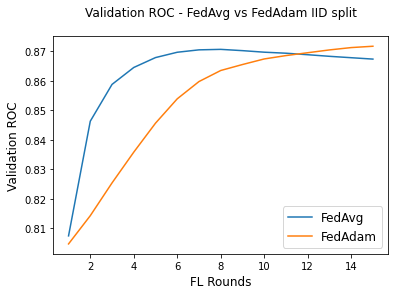

In [99]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_iid['val_roc'], label='FedAdam')

plt.title("Validation ROC - FedAvg vs FedAdam IID split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

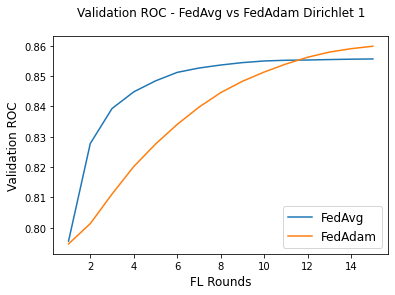

In [82]:
plt.plot(range(1,16),res_w6_c1_da1['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_da1['val_roc'], label='FedAdam')

plt.title("Validation ROC - FedAvg vs FedAdam Dirichlet 1",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

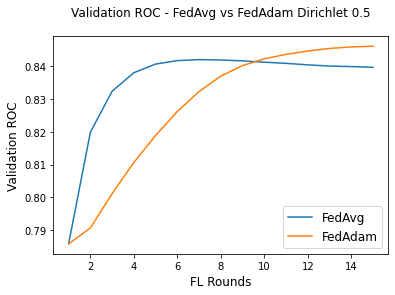

In [81]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam')

plt.title("Validation ROC - FedAvg vs FedAdam Dirichlet 0.5",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

###  1.2 FedAdam hyperparameter testing

Testing performed for the below hyper parameters
- Local learning rate decay
- Global learning rate
- Momentum and variance momentum weights Beta1 and Beta2
- Variance floor tau 


Federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch size 256
- FL rounds: 15

**Learning rate decay** :Similar to FedAvg, FedAdam requires a learning rate decay to converge, this is demonstrated in the results as very low learning rate reduced the model performance for late communication rounds. The below comparison shows that very high learning rate decay reduces the performance of the model. 

**Global learning rate**: The results show that low global learning rate lead to poor FedAdam learning performance. Increasing the global learning rate improves the performance for the initial communication rounds. This improvement is not sustained as high global learning rate show fast decrease in the performance for the later communication rounds. 

**Momentum and variance weights beta1,beta2**: Increasing the value of beta 1 and beta 2 reduces the performance of FedAdam for the early communication rounds and the algorithm fail to reach high ROC after 15 federated leanring rounds. Higher beta means higher weight to the momentum, which results in the model not benefiting form the early communication rounds.   

**Variance floor tau**: The effect of tau is the opposite of the effect of global learning rate. Higher tau will reduce the learning rate and results is slow learning, decreasing the tau can increase the global learing rate in some case which results in fast learning especially for the first communication rounds


#### Local learning rate decay

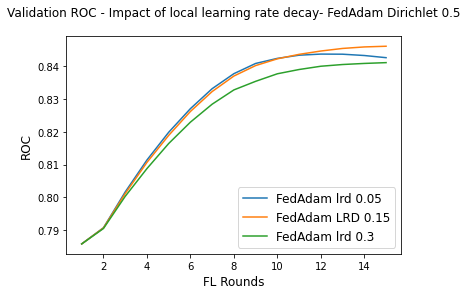

In [91]:


plt.plot(range(1,16),res_FedAdam_w6_LRD05_c1_da0_5['val_roc'], label='FedAdam lrd 0.05')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam LRD 0.15')
plt.plot(range(1,16),res_FedAdam_w6_LRD3_c1_da0_5['val_roc'], label='FedAdam lrd 0.3')

plt.title("Validation ROC - Impact of local learning rate decay- FedAdam Dirichlet 0.5",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("ROC", fontsize=12)
plt.show()

#### Global learning rate

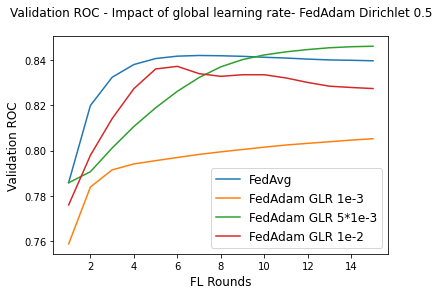

In [104]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_glr1e3_w6_c1_da0_5['val_roc'], label='FedAdam GLR 1e-3')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam GLR 5*1e-3')
plt.plot(range(1,16),res_FedAdam_glr1e2_w6_c1_da0_5['val_roc'], label='FedAdam GLR 1e-2')

plt.title("Validation ROC - Impact of global learning rate- FedAdam Dirichlet 0.5",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

#### Momentum and variance weights beta1,beta2

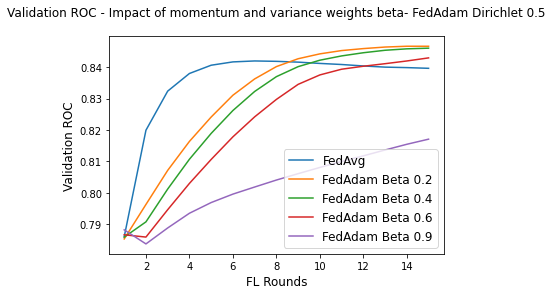

In [103]:

plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_b_0_2_w6_c1_da0_5['val_roc'], label='FedAdam Beta 0.2')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam Beta 0.4')
plt.plot(range(1,16),res_FedAdam_b_0_6_w6_c1_da0_5['val_roc'], label='FedAdam Beta 0.6')
plt.plot(range(1,16),res_FedAdam_b_0_9_w6_c1_da0_5['val_roc'], label='FedAdam Beta 0.9')

plt.title("Validation ROC - Impact of momentum and variance weights beta- FedAdam Dirichlet 0.5",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

In [41]:
print("Maximum ROC FedAdam 0.2: "+str(max(res_FedAdam_b_0_2_w6_c1_da0_5['val_roc']))+" at "+str(res_FedAdam_b_0_2_w6_c1_da0_5['val_roc'].index(max(res_FedAdam_b_0_2_w6_c1_da0_5['val_roc'])))+"Epochs")
print("Maximum ROC FedAdam 0.4: "+str(max(res_FedAdam_w6_c1_da0_5['val_roc']))+" at "+str(res_FedAdam_w6_c1_da0_5['val_roc'].index(max(res_FedAdam_w6_c1_da0_5['val_roc'])))+"Epochs")
print("Maximum ROC FedAdam 0.6: "+str(max(res_FedAdam_b_0_6_w6_c1_da0_5['val_roc']))+" at "+str(res_FedAdam_b_0_6_w6_c1_da0_5['val_roc'].index(max(res_FedAdam_b_0_6_w6_c1_da0_5['val_roc'])))+"Epochs")
print("Maximum ROC FedAdam 0.9: "+str(max(res_FedAdam_b_0_9_w6_c1_da0_5['val_roc']))+" at "+str(res_FedAdam_b_0_9_w6_c1_da0_5['val_roc'].index(max(res_FedAdam_b_0_9_w6_c1_da0_5['val_roc'])))+"Epochs")


Maximum ROC FedAdam 0.2: 0.846713755139939 at 13Epochs
Maximum ROC FedAdam 0.4: 0.8460988968475042 at 14Epochs
Maximum ROC FedAdam 0.6: 0.8429997347128266 at 14Epochs
Maximum ROC FedAdam 0.9: 0.8170720586284652 at 14Epochs


#### Variance floor tau

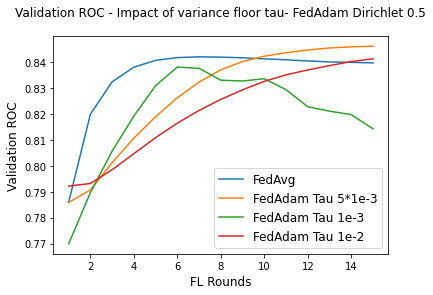

In [105]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam Tau 5*1e-3')
plt.plot(range(1,16),res_FedAdam_tau1e3_w6_c1_da0_5['val_roc'], label='FedAdam Tau 1e-3')
plt.plot(range(1,16),res_FedAdam_tau1e2_w6_c1_da0_5['val_roc'], label='FedAdam Tau 1e-2')

plt.title("Validation ROC - Impact of variance floor tau- FedAdam Dirichlet 0.5",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

## 2. FedProx

###  2.1 Testing FedProx on different dataset splits
global aggregation parameters:

- Regularization parameter 1e-4

Other federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch Size 256
- FL rounds: 15
- No Local learning rate decay

Interm of learning performance, FedProx improves the overall learning performance when compared to FedAvg and FedAdam as it increases the maximum ROC for the three dataset splits. For non IID Dirichlet 0.5 scenario, FedProx show significant increase in the maximum ROC score reached after 15 federated learning rounds.

FedProx shows similar communication efficiency for IID split compared to FedAvg and improved communication efficiency for non IID Dirichlet 1 scenario.

Eventhough FedProx gives a maximum ROC comparable to benchmark of central learning for Non IID Dirichlet 0.5 split, the communication efficiency remains a challengge as the algorithm requires more learning rounds with this scenario compared to Non IID Dirichlet 1 or IID one. 

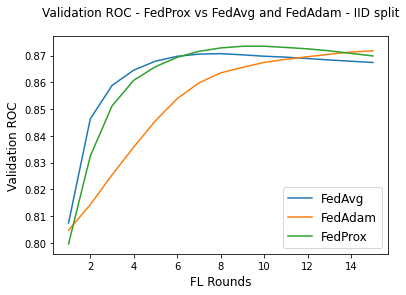

In [149]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_iid['val_roc'], label='FedAdam')
plt.plot(range(1,16),res_FedProx1e4_w6_c1_iid['val_roc'], label='FedProx')

plt.title("Validation ROC - FedProx vs FedAvg and FedAdam - IID split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

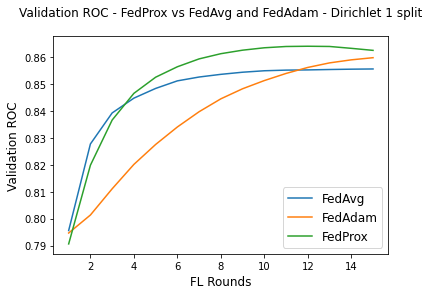

In [147]:
plt.plot(range(1,16),res_w6_c1_da1['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_da1['val_roc'], label='FedAdam')
plt.plot(range(1,16),res_FedProx1e4_w6_c1_da1['val_roc'], label='FedProx')

plt.title("Validation ROC - FedProx vs FedAvg and FedAdam - Dirichlet 1 split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

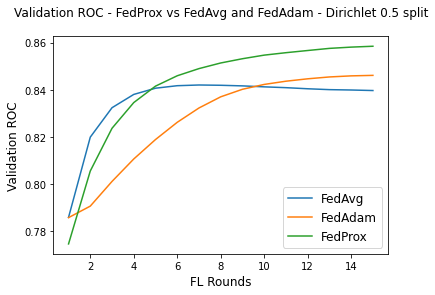

In [148]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedAdam_w6_c1_da0_5['val_roc'], label='FedAdam')
plt.plot(range(1,16),res_FedProx1e4_w6_c1_da0_5['val_roc'], label='FedProx')

plt.title("Validation ROC - FedProx vs FedAvg and FedAdam - Dirichlet 0.5 split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

###  2.2 FedProx hyperparameter testing

Testing performed for the below hyper parameters
- Local learning rate decay
- Regularization weight


Federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 5
- Local Batch size 256
- FL rounds: 15

Data split are 6 client for Learning rate decay impact and 6 and 96 clients for regularization weight impact. The data split for this testing is based on Dirchlet 0.5 on labels

**Learning reate decay**: Learning rate decay reduces the performance of FedProx overall. Thsi could be related to fact with FedAvg and similar algorithm, the learning rate decay is required to reduce the client drifts (difference between client updates and aggregated model) and ensure convergence. FedProx solves the issue of client drift with weight regularization the constrains the local updates to be close to the global model, therefore learning rate decay is not required for FedProx. 

**Regulatarization weight**: FedProx perofrmane drops with the regularization weight is too high or too low. For very low weights, the model algrithm behaves in similar way as FedAvg without learning rate decay, this is explained by the fact the additional loss from the regularization is too small compared to the loss leading to large differences between the clients updated models. When the regularization weights are high, FedProx the communication efficiency drop and the model is slow from learning after each communication round, this is related to fact the additional loss from regularization is too large compared to the loss of the local client. When the regularization weight is correctly choosen, the performance of FedProx for non IID scenarios is similar to one of central training for small and large number of workers. 

#### Learning rate decay


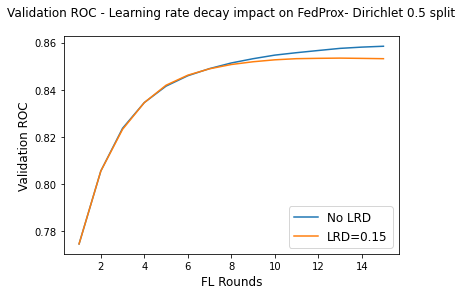

In [151]:
plt.plot(range(1,16),res_FedProx1e4_w6_c1_da0_5['val_roc'], label='No LRD')
plt.plot(range(1,16),res_FedProx1e4_w6_c1_LRD_da0_5['val_roc'], label='LRD=0.15')

plt.title("Validation ROC - Learning rate decay impact on FedProx- Dirichlet 0.5 split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

#### Regularization weight

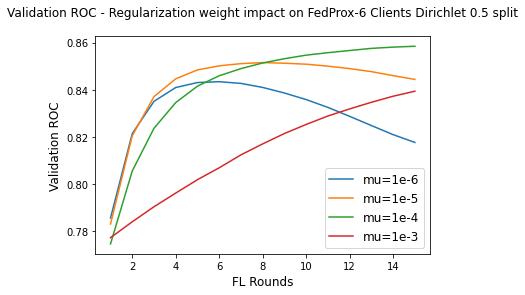

In [153]:
plt.plot(range(1,16),res_FedProx1e6_w6_c1_da0_5['val_roc'], label='mu=1e-6')
plt.plot(range(1,16),res_FedProx1e5_w6_c1_da0_5['val_roc'], label='mu=1e-5')
plt.plot(range(1,16),res_FedProx1e4_w6_c1_da0_5['val_roc'], label='mu=1e-4')
plt.plot(range(1,16),res_FedProx1e3_w6_c1_da0_5['val_roc'], label='mu=1e-3')

plt.title("Validation ROC - Regularization weight impact on FedProx-6 Clients Dirichlet 0.5 split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

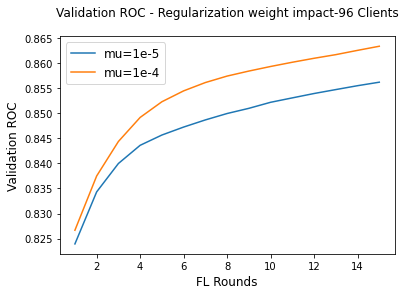

In [137]:
#plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='FedAvg')
plt.plot(range(1,16),res_FedProx1e5_w96_c1_da0_5['val_roc'], label='mu=1e-5')
plt.plot(range(1,16),res_FedProx1e4_w96_c1_da0_5['val_roc'], label='mu=1e-4')

plt.title("Validation ROC - Regularization weight impact-96 Clients Dirichlet 0.5 split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()